# *Without SMOTE


# 0. Initialize Environment


In [1]:
# -------------------------------
# PROJECT OBJECTIVES
# -------------------------------
# 1) Clean, explore, and analyze data on cardiovascular disease;
# 2) Build predictive models for CVD risk using key indicators;
# 3) Create visualizations to support findings;
# 4) Demonstrate collaboration in producing a final report.

# ----------------------------
# PROJECT WORKFLOW
# ----------------------------
# Step 1: Data acquisition & cleaning (DONE)
# Step 2: Feature engineering
# Step 3: Exploratory and descriptive data analysis
# Step 4: Predictive modeling
# Step 5: Data visualization
# Step 6: Interpretation and discussion
# Step 7: Conclusion
# Step 8: References

# -------------------------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import torch
import torch.nn as nn
import gc

from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.base import ClassifierMixin
from sklearn.calibration import calibration_curve
from torch.utils.data import TensorDataset, DataLoader
from lightgbm import LGBMClassifier, early_stopping
import optuna
import kagglehub

# -------------------------------------------------------------
# SEEDING
# -------------------------------------------------------------
seed = 88888
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
g = torch.Generator().manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sampler = optuna.samplers.TPESampler(seed=seed)
n_trials = 50
n_repeats = 10

# -------------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------------
path = kagglehub.dataset_download(
    "kamilpytlak/personal-key-indicators-of-heart-disease")
file = path + '/2022/heart_2022_with_nans.csv'
heart_df = pd.read_csv(file)


# Utility function to seperate outputs
def output_seperate(text):
    print('='*79, flush=True)
    print(text, flush=True)
    print('='*79, flush=True)

# 1. Exploratory Data Analysis


## 1.1. Data Overview


In [2]:
# General Information
output_seperate('Dataset Info')
heart_df.info(memory_usage='deep')
output_seperate('Data Head')
display(heart_df.head())
# Summary of missing values
# All missing values are less than 20% therefore all variables retained
missing_values = heart_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(heart_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent Missing': missing_percentage.round(2)
})
output_seperate('Variables with Missing Values (<20%):')
display(missing_df[missing_df['Missing Values'] > 0])

Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer   

State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0          NaN             No  ...            NaN   
1         6.0          NaN             No  ...           1.60   
2         5.0          NaN             No  ...           1.57   
3         7.0          NaN             No  ...           1.65   
4         9.0          NaN             No  ...           1.57   

  WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
0               NaN    NaN              No         No          Yes   
1             68.04  26.57              No         No           No   
2             63.50  25.61              No         No           No   
3             63.50  23.30              No         No          Yes   
4             53.98  21.77             Yes         No           No   

  PneumoVaxEver                                  TetanusLast10Tdap  \
0            No  Yes, received tetanus shot but not sure what type   
1            No  No, did not receive any tetanus shot in the pa...   
2            No                                                NaN   
3           Yes  No, did not receive any tetanus shot in the pa...   
4           Yes  No, did not receive any tetanus shot in the pa...   

  HighRiskLastYear CovidPos  
0               No       No  
1               No       No  
2               No      Yes  
3               No       No  
4               No       No  

[5 rows x 40 columns]

Variables with Missing Values (<20%):


Missing Values  Percent Missing
TetanusLast10Tdap                   82516            18.54
PneumoVaxEver                       77040            17.31
HIVTesting                          66127            14.86
ChestScan                           56046            12.59
CovidPos                            50764            11.40
HighRiskLastYear                    50623            11.37
BMI                                 48806            10.96
FluVaxLast12                        47121            10.59
AlcoholDrinkers                     46574            10.46
WeightInKilograms                   42078             9.45
ECigaretteUsage                     35660             8.01
SmokerStatus                        35462             7.97
HeightInMeters                      28652             6.44
DifficultyErrands                   25656             5.76
DifficultyConcentrating             24240             5.45
DifficultyWalking                   24012             5.39
DifficultyDressingBathing           23915             5.37
BlindOrVisionDifficulty             21564             4.84
DeafOrHardOfHearing                 20647             4.64
RaceEthnicityCategory               14057             3.16
RemovedTeeth                        11360             2.55
PhysicalHealthDays                  10927             2.45
AgeCategory                          9079             2.04
MentalHealthDays                     9067             2.04
LastCheckupTime                      8308             1.87
SleepHours                           5453             1.23
HadAngina                            4405             0.99
HadSkinCancer                        3143             0.71
HadHeartAttack                       3065             0.69
HadDepressiveDisorder                2812             0.63
HadArthritis                         2633             0.59
HadCOPD                              2219             0.50
HadKidneyDisease                     1926             0.43
HadAsthma                            1773             0.40
HadStroke                            1557             0.35
GeneralHealth                        1198             0.27
PhysicalActivities                   1093             0.25
HadDiabetes                          1087             0.24

## 1.2. Data Visualizations


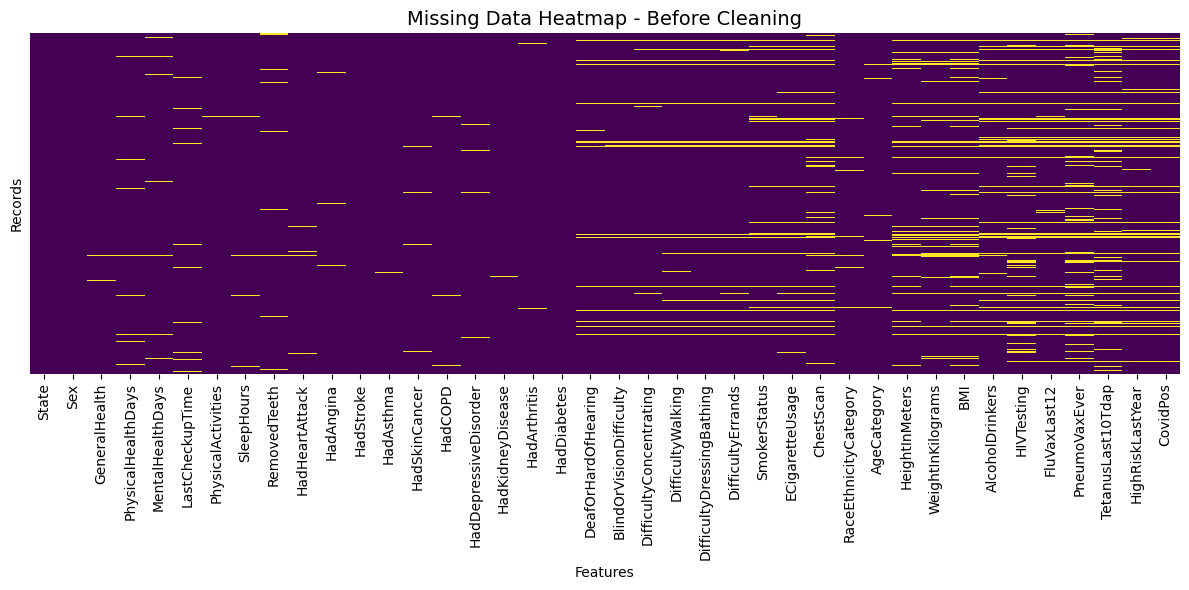

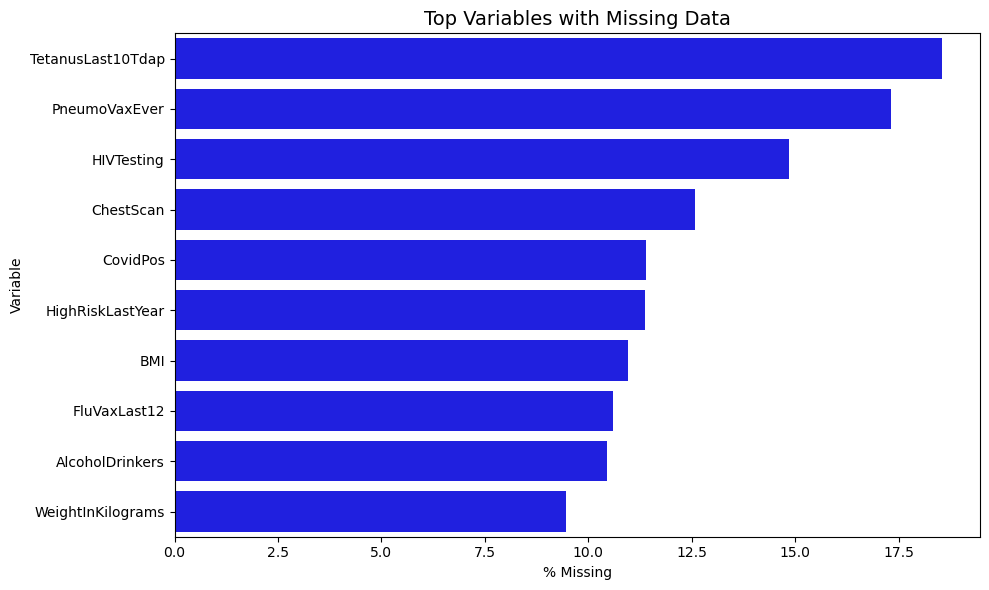

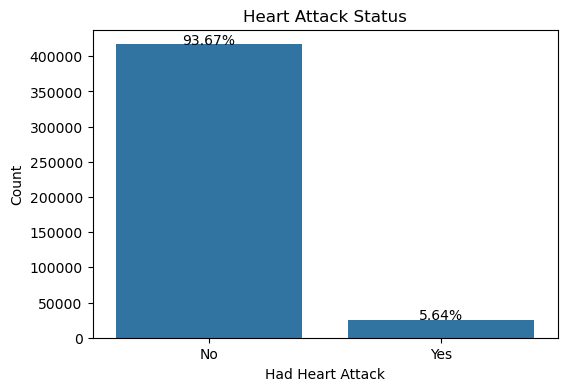

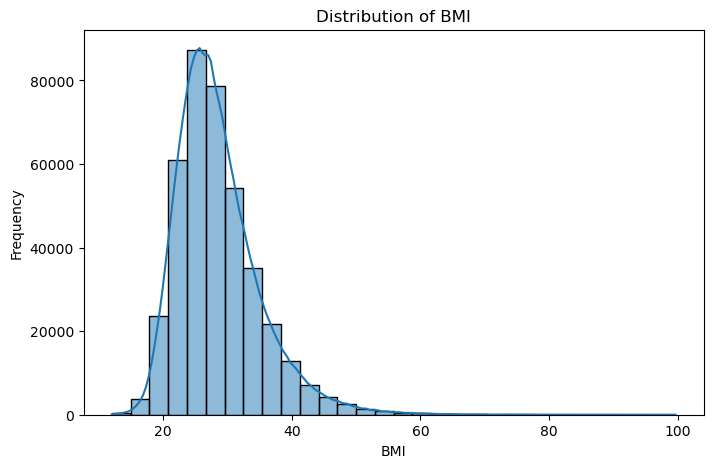

In [3]:
# Visualization of degree of missingness using a heatmap before cleaning
# Widespread but sparse missingness across many variables
# No large blocks of completely missing data for any one record or column
# There are very few individual rows with large amounts of missing data
# Further suggests it is not necessary to remove entire records
plt.figure(figsize=(12, 6))
sns.heatmap(heart_df.isnull(),
            cbar=False,
            yticklabels=False,
            cmap='viridis')
plt.title('Missing Data Heatmap - Before Cleaning', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Records')
plt.tight_layout()
plt.show()

# Visualization of top variables with missing data
top_missing = missing_df[missing_df['Missing Values'] > 0] \
    .sort_values(by='Missing Values', ascending=False) \
    .head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_missing,
    y='index',  # Variable names
    x='Percent Missing',
    color='blue'
)
plt.title('Top Variables with Missing Data', fontsize=14)
plt.xlabel('% Missing')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Bar plot of Heart Attack status with percentage labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='HadHeartAttack', data=heart_df)
total = len(heart_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 500,
            f'{100 * height / total:.2f}%', ha="center")
plt.title('Heart Attack Status')
plt.xlabel('Had Heart Attack')
plt.ylabel('Count')
plt.show()

# Histogram of BMI
plt.figure(figsize=(8, 5))
sns.histplot(data=heart_df, x='BMI', kde=True, bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# 2. Data Cleaning & Imputation


In [4]:
# Define target
target = 'HadHeartAttack'
# Drop rows with missing target variable and create a clean copy
heart_clean = heart_df.dropna(subset=['HadHeartAttack'])
# Reset index after row drops
heart_clean.reset_index(drop=True, inplace=True)
# Seperate features and target
y = heart_clean[target]
X = heart_clean.drop(columns=target)
# Train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
# Train/validation splits
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

# Impute missing numerical values with median due to non-normality
# Less sensitive to outliers than the mean
# Real-world health data (e.g., BMI) often have skewed distributions
# Using median values ensures imputed values do not distort the distribution or introduce bias from extreme values
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numerical_cols = X_train.select_dtypes(
    include=['float64', 'int64']).columns.tolist()
for col in numerical_cols:
    if X[col].isnull().any():
        imputer = X_train[col].median()
        X_train[col] = X_train[col].fillna(imputer)
        X_validation[col] = X_validation[col].fillna(imputer)
        X_test[col] = X_test[col].fillna(imputer)

# Impute missing categorical values with mode
  # Imputing with the mode preserves the most common pattern in the data
  # It avoids randomly assigning categories, which could mislead the model or analysis
for col in categorical_cols:
    if X[col].isnull().any():
        imputer = X_train[col].mode()[0]
        X_train[col] = X_train[col].fillna(imputer)
        X_validation[col] = X_validation[col].fillna(imputer)
        X_test[col] = X_test[col].fillna(imputer)

# Final check for missing values
# There are n=0 missing values
missing_after_cleaning = X_train.isnull().sum().sum() + \
    X_validation.isnull().sum().sum() + X_test.isnull().sum().sum()
output_seperate('Missing values after cleaning:')
print(missing_after_cleaning)
assert missing_after_cleaning == 0, "Some missing values still remain"
output_seperate('Information of X_train')
X_train.info()
output_seperate('Information of X_validation')
X_validation.info()
output_seperate('Information of X_test')
X_test.info()
print("Data cleaning complete and ready for analysis")

Missing values after cleaning:
0
Information of X_train
<class 'pandas.core.frame.DataFrame'>
Index: 282922 entries, 231375 to 421432
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      282922 non-null  object 
 1   Sex                        282922 non-null  object 
 2   GeneralHealth              282922 non-null  object 
 3   PhysicalHealthDays         282922 non-null  float64
 4   MentalHealthDays           282922 non-null  float64
 5   LastCheckupTime            282922 non-null  object 
 6   PhysicalActivities         282922 non-null  object 
 7   SleepHours                 282922 non-null  float64
 8   RemovedTeeth               282922 non-null  object 
 9   HadAngina                  282922 non-null  object 
 10  HadStroke                  282922 non-null  object 
 11  HadAsthma                  282922 non-null  object 
 12  HadSkinCancer              282

# 3. Feature Engineering


In [5]:
# ---------------------------------------------
# CREATE BMI CATEGORY
# ---------------------------------------------
def get_bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'


X_train['BMI_Category'] = X_train['BMI'].apply(get_bmi_category)
X_validation['BMI_Category'] = X_validation['BMI'].apply(get_bmi_category)
X_test['BMI_Category'] = X_test['BMI'].apply(get_bmi_category)

# ---------------------------------------------
# Convert AgeCategory into Numeric Order
# ---------------------------------------------
age_order = X['AgeCategory'].value_counts(
    dropna=False).sort_index().index.to_list()
age_group_numbers = {age: idx for idx, age in enumerate(age_order)}
X_train['AgeGroupNum'] = X_train['AgeCategory'].map(age_group_numbers)
X_validation['AgeGroupNum'] = X_validation['AgeCategory'].map(
    age_group_numbers)
X_test['AgeGroupNum'] = X_test['AgeCategory'].map(age_group_numbers)

output_seperate('Feature engineering complete. Sample data:')
display(X_train[['BMI_Category', 'AgeGroupNum']].head(10))

Feature engineering complete. Sample data:


BMI_Category  AgeGroupNum
231375       Normal            9
253304        Obese            6
84768    Overweight            2
217385        Obese           10
201405       Normal            0
73484    Overweight           12
337056       Normal            6
166732       Normal            3
247092        Obese            9
202184   Overweight            7

# 4. Data Preprocess


In [6]:
# Reset column names after feature engineering
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numerical_cols = X_train.select_dtypes(
    include=['float64', 'int64']).columns.tolist()
# Reorder train/test sets' columns
X_train = X_train[categorical_cols + numerical_cols]
X_validation = X_validation[categorical_cols + numerical_cols]
X_test = X_test[categorical_cols + numerical_cols]
# Record column names for later result analysis
col_names = X_train.columns.to_list()
# Standardlize numerical features
ss = StandardScaler()
X_train[numerical_cols] = ss.fit_transform(X_train[numerical_cols])
X_validation[numerical_cols] = ss.transform(X_validation[numerical_cols])
X_test[numerical_cols] = ss.transform(X_test[numerical_cols])
# Mapping target from 'Yes/No' to '1/0'
y_train = y_train.map({'Yes': 1, 'No': 0})
y_validation = y_validation.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})


# Define a function to transform categorical data into dummies, which
# will map 'Yes/No' to '1/0' since 'drop_first' enabled. This function
# will be reused in permutation importance analysis.
def process_data(X_train, X_validation, X_test):
    # Get dummies
    X_train_dummies = pd.get_dummies(X_train, drop_first=True, dtype='int64')
    X_validation_dummies = pd.get_dummies(
        X_validation, drop_first=True, dtype='int64')
    X_test_dummies = pd.get_dummies(X_test, drop_first=True, dtype='int64')
    # There are illegal strings in column names. Rename them.
    X_train_dummies.columns = X_train_dummies.columns.str.replace(r'\W+', '_', regex=True)
    X_validation_dummies.columns = X_validation_dummies.columns.str.replace(r'\W+', '_', regex=True)
    X_test_dummies.columns = X_test_dummies.columns.str.replace(r'\W+', '_', regex=True)
    dummies_col_names = X_train_dummies.columns

    # Check whether dummy cols are the same in case there are different classes in
    # validation set and test set.
    if (
        list(X_train_dummies.columns) == list(
            X_validation_dummies.columns) == list(X_test_dummies.columns)
    ):
        # If the same, return directly
        return X_train_dummies, X_validation_dummies, X_test_dummies, X_train_dummies.columns

    # If not the same, add col to validation set and test set with 0 or drop col.
    X_validation_dummies = X_validation_dummies.reindex(
        columns=dummies_col_names, fill_value=0)
    X_test_dummies = X_test_dummies.reindex(
        columns=dummies_col_names, fill_value=0)

    return X_train_dummies, X_validation_dummies, X_test_dummies, dummies_col_names


X_train_dummies, X_validation_dummies, X_test_dummies, dummies_col_names = process_data(
    X_train, X_validation, X_test)

# Delete unnecessary variables to save memory
del heart_df, heart_clean, X
gc.collect()

# Print information
output_seperate('X_train:')
display(X_train_dummies.describe())
output_seperate('X_validation:')
display(X_validation_dummies.describe())
output_seperate('X_test:')
display(X_test_dummies.describe())

X_train:


PhysicalHealthDays  MentalHealthDays    SleepHours  HeightInMeters  \
count        2.829220e+05      2.829220e+05  2.829220e+05    2.829220e+05   
mean        -2.788958e-17     -4.551992e-17 -2.406466e-16    4.861201e-15   
std          1.000002e+00      1.000002e+00  1.000002e+00    1.000002e+00   
min         -4.923737e-01     -5.153771e-01 -4.044858e+00   -7.648157e+00   
25%         -4.923737e-01     -5.153771e-01 -6.890388e-01   -6.990363e-01   
50%         -4.923737e-01     -5.153771e-01 -1.787496e-02   -2.342734e-02   
75%         -1.432857e-01     -3.410768e-02  6.532889e-01    7.486971e-01   
max          2.998507e+00      3.094143e+00  1.139191e+01    6.829177e+00   

       WeightInKilograms           BMI   AgeGroupNum   State_Alaska  \
count       2.829220e+05  2.829220e+05  2.829220e+05  282922.000000   
mean       -5.997077e-16 -6.180412e-16 -1.119099e-16       0.012890   
std         1.000002e+00  1.000002e+00  1.000002e+00       0.112802   
min        -2.946608e+00 -2.645394e+00 -1.867931e+00       0.000000   
25%        -7.251384e-01 -6.457575e-01 -7.467511e-01       0.000000   
50%        -1.031661e-01 -1.567422e-01  9.413374e-02       0.000000   
75%         4.301630e-01  4.194242e-01  9.350186e-01       0.000000   
max         1.027104e+01  1.149570e+01  1.495609e+00       1.000000   

       State_Arizona  State_Arkansas  ...  PneumoVaxEver_Yes  \
count  282922.000000   282922.000000  ...      282922.000000   
mean        0.022656        0.011756  ...           0.343102   
std         0.148806        0.107786  ...           0.474746   
min         0.000000        0.000000  ...           0.000000   
25%         0.000000        0.000000  ...           0.000000   
50%         0.000000        0.000000  ...           0.000000   
75%         0.000000        0.000000  ...           1.000000   
max         1.000000        1.000000  ...           1.000000   

       TetanusLast10Tdap_Yes_received_Tdap  \
count                        282922.000000   
mean                              0.225133   
std                               0.417670   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_sure_what_type  \
count                                      282922.000000                    
mean                                            0.255919                    
std                                             0.436377                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                             1.000000                    
max                                             1.000000                    

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_Tdap  \
count                                      282922.000000          
mean                                            0.062074          
std                                             0.241290          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                             1.000000          

       HighRiskLastYear_Yes  \
count         282922.000000   
mean               0.038375   
std                0.192099   
min                0.000000   
25%                0.000000   
50%                0.000000   
75%                0.000000   
max                1.000000   

       CovidPos_Tested_positive_using_home_test_without_a_health_professional  \
count                 

X_validation:


PhysicalHealthDays  MentalHealthDays    SleepHours  HeightInMeters  \
count        70731.000000      70731.000000  70731.000000    70731.000000   
mean            -0.007737          0.003387     -0.007048        0.003256   
std              0.992086          1.004659      1.004415        1.004764   
min             -0.492374         -0.515377     -4.044858       -7.648157   
25%             -0.492374         -0.515377     -0.689039       -0.699036   
50%             -0.492374         -0.515377     -0.017875       -0.023427   
75%             -0.143286         -0.034108      0.653289        0.748697   
max              2.998507          3.094143     11.391910        6.829177   

       WeightInKilograms           BMI   AgeGroupNum  State_Alaska  \
count       70731.000000  70731.000000  70731.000000  70731.000000   
mean           -0.001357     -0.002386     -0.000249      0.013799   
std             0.996413      0.992514      1.001680      0.116656   
min            -2.946608     -2.622799     -1.867931      0.000000   
25%            -0.725138     -0.645757     -0.746751      0.000000   
50%            -0.103166     -0.156742      0.094134      0.000000   
75%             0.430163      0.419424      0.935019      0.000000   
max            10.159867      9.956029      1.495609      1.000000   

       State_Arizona  State_Arkansas  ...  PneumoVaxEver_Yes  \
count   70731.000000    70731.000000  ...       70731.000000   
mean        0.023469        0.011890  ...           0.342664   
std         0.151389        0.108392  ...           0.474604   
min         0.000000        0.000000  ...           0.000000   
25%         0.000000        0.000000  ...           0.000000   
50%         0.000000        0.000000  ...           0.000000   
75%         0.000000        0.000000  ...           1.000000   
max         1.000000        1.000000  ...           1.000000   

       TetanusLast10Tdap_Yes_received_Tdap  \
count                         70731.000000   
mean                              0.227425   
std                               0.419172   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_sure_what_type  \
count                                       70731.000000                    
mean                                            0.254980                    
std                                             0.435853                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                             1.000000                    
max                                             1.000000                    

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_Tdap  \
count                                       70731.000000          
mean                                            0.061868          
std                                             0.240918          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                             1.000000          

       HighRiskLastYear_Yes  \
count          70731.000000   
mean               0.039106   
std                0.193848   
min                0.000000   
25%                0.000000   
50%                0.000000   
75%                0.000000   
max                1.000000   

       CovidPos_Tested_positive_using_home_test_without_a_health_professional  \
count                          

X_test:


PhysicalHealthDays  MentalHealthDays    SleepHours  HeightInMeters  \
count        88414.000000      88414.000000  88414.000000    88414.000000   
mean            -0.000997         -0.002117     -0.006572        0.004903   
std              1.000262          0.996337      0.988459        0.999439   
min             -0.492374         -0.515377     -4.044858       -7.648157   
25%             -0.492374         -0.515377     -0.689039       -0.699036   
50%             -0.492374         -0.515377     -0.017875       -0.023427   
75%             -0.143286         -0.034108      0.653289        0.748697   
max              2.998507          3.094143     11.391910        6.829177   

       WeightInKilograms           BMI   AgeGroupNum  State_Alaska  \
count       88414.000000  88414.000000  88414.000000  88414.000000   
mean            0.003917      0.000486      0.001791      0.013414   
std             1.003220      1.003842      0.999461      0.115041   
min            -2.946608     -2.630869     -1.867931      0.000000   
25%            -0.680572     -0.645757     -0.746751      0.000000   
50%            -0.103166     -0.156742      0.094134      0.000000   
75%             0.430163      0.419424      0.935019      0.000000   
max             9.704407     11.174532      1.495609      1.000000   

       State_Arizona  State_Arkansas  ...  PneumoVaxEver_Yes  \
count   88414.000000    88414.000000  ...       88414.000000   
mean        0.022836        0.012147  ...           0.340919   
std         0.149380        0.109544  ...           0.474021   
min         0.000000        0.000000  ...           0.000000   
25%         0.000000        0.000000  ...           0.000000   
50%         0.000000        0.000000  ...           0.000000   
75%         0.000000        0.000000  ...           1.000000   
max         1.000000        1.000000  ...           1.000000   

       TetanusLast10Tdap_Yes_received_Tdap  \
count                         88414.000000   
mean                              0.224308   
std                               0.417128   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_sure_what_type  \
count                                       88414.000000                    
mean                                            0.255401                    
std                                             0.436089                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                             1.000000                    
max                                             1.000000                    

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_Tdap  \
count                                        88414.00000          
mean                                             0.06076          
std                                              0.23889          
min                                              0.00000          
25%                                              0.00000          
50%                                              0.00000          
75%                                              0.00000          
max                                              1.00000          

       HighRiskLastYear_Yes  \
count          88414.000000   
mean               0.039168   
std                0.193996   
min                0.000000   
25%                0.000000   
50%                0.000000   
75%                0.000000   
max                1.000000   

       CovidPos_Tested_positive_using_home_test_without_a_health_professional  \
count                          

# 5: Predictive Modeling


Use optuna to find optimal hyperparameter. The evaluation matric is area under
Precision-Recall Curve (PR-Curve) for positive case. This is because the target is
imbalanced, and if this model is used for medical suggestion, positive case
may be more important. It is feasible to use other matrics.

The training has set random seed to ensure reproducability.
However, for pytorch, it is not perfectly reproducable. The results may vary
between different software and hardware platform.
From results, when dealing with tabular data, MLP not perform as good as Gradient
Boost Tree models, like LGBM. I noticed that some papers' findings support these
results。

Grinsztajn, L., Oyallon, E., & Varoquaux, G. (2022). Why do tree-based models still outperform deep learning on tabular data? (No. arXiv:2207.08815). arXiv. https://doi.org/10.48550/arXiv.2207.08815

https://medium.com/cuenex/advanced-evaluation-metrics-for-imbalanced-classification-models-ee6f248c90ca


## 5.1. Define Utility Function


In [7]:
# Utility function for plotting Precision-Recall Curve
def plot_pr_curve(y_test, proba, model_name, ax):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ax.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend()
    ax.grid()
    return ax


# Utility function for plotting Calibration Curve
def plot_cb_curve(y_test, proba, model_name, ax):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Curve - {model_name}')
    ax.legend()
    ax.grid()
    return ax


# Utility function for printing results
def output_results(score, study, y_test, pred, proba):
    output_seperate('Best Hyperparameters:')
    display(study.best_params)
    results = {
        'PR AUC': [score],
        'ROC AUC': [roc_auc_score(y_test, proba)],
        'F1 Score': [f1_score(y_test, pred)],
        'Precision': [precision_score(y_test, pred)],
        'Recall': [recall_score(y_test, pred)]
    }
    results = pd.DataFrame(results)
    output_seperate('Results')
    display(results.T)
    return results


# Utility function for plotting Permutation Importance
def plot_permutation_importance(importance_df, model_name, ax):
    bars = ax.barh(importance_df['feature'], importance_df['importance_mean'])
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.3f}', va='center')
    ax.set_xlabel('Permutation Importance')
    ax.set_ylabel('Features')
    ax.set_title(f'Permutation Feature Importance - {model_name}')
    ax.invert_yaxis()
    return ax


# Simple wrapper for immediate plotting
def plot_immediately(plot_func, figsize, *args):
    fig, ax = plt.subplots(figsize=figsize)
    plot_func(*args, ax=ax)
    plt.tight_layout()
    plt.show()


# Utility function for permutation importance
def calculate_permutation_importance(model, X_test):
    result = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=seed,
        scoring='average_precision'
    )
    # Create a df to store results
    importance_df = pd.DataFrame({
        'feature': col_names,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    display(importance_df)
    return importance_df

## 5.2. Logistic Regression


Searching Hyperparameters


[I 2025-04-13 14:09:06,063] A new study created in memory with name: no-name-bf3f8555-1092-4e45-9c87-f7e6e5650a9e
[I 2025-04-13 14:09:15,210] Trial 0 finished with value: 0.4142654353010765 and parameters: {'C': 26.010471763188242, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.4142654353010765.
[I 2025-04-13 14:09:15,212] Trial 1 pruned. 
[I 2025-04-13 14:09:15,212] Trial 2 pruned. 
[I 2025-04-13 14:09:30,893] Trial 3 finished with value: 0.41867225057768387 and parameters: {'C': 0.42912908497325414, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 3 with value: 0.41867225057768387.
[I 2025-04-13 14:12:21,006] Trial 4 finished with value: 0.41875634164805503 and parameters: {'C': 5.823332851075253, 'penalty': 'l2', 'solver': 'saga', 'class_weight': None}. Best is trial 4 with value: 0.41875634164805503.
[I 2025-04-13 14:12:21,007] Trial 5 pruned. 
[I 2025-04-13 14:12:31,571] Trial 6 finished with value: 0.41425

Train model with best hyperparameters...
Best Hyperparameters:


{'C': 236.23365870568975,
 'penalty': 'l2',
 'solver': 'liblinear',
 'class_weight': None}

Results


0
PR AUC     0.397730
ROC AUC    0.881143
F1 Score   0.330391
Precision  0.557447
Recall     0.234767

Coefficient - Logistic Regression


Coefficient
HadAngina_Yes                                          2.348868
GeneralHealth_Poor                                     0.993003
AgeGroupNum                                            0.929129
HadStroke_Yes                                          0.925750
GeneralHealth_Fair                                     0.824106
...                                                         ...
AgeCategory_Age_65_to_69                              -0.390608
CovidPos_Tested_positive_using_home_test_withou...    -0.417681
AgeCategory_Age_70_to_74                              -0.516047
AgeCategory_Age_75_to_79                              -0.666254
AgeCategory_Age_80_or_older                           -0.728160

[125 rows x 1 columns]

Plot Precision-Recall Curve


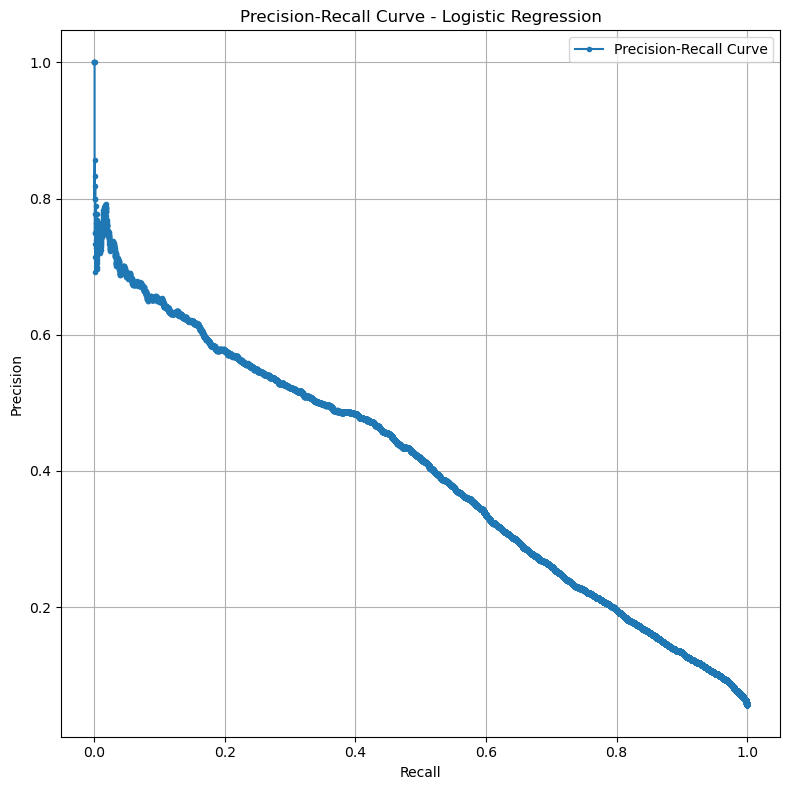

Plot Calibration Curve


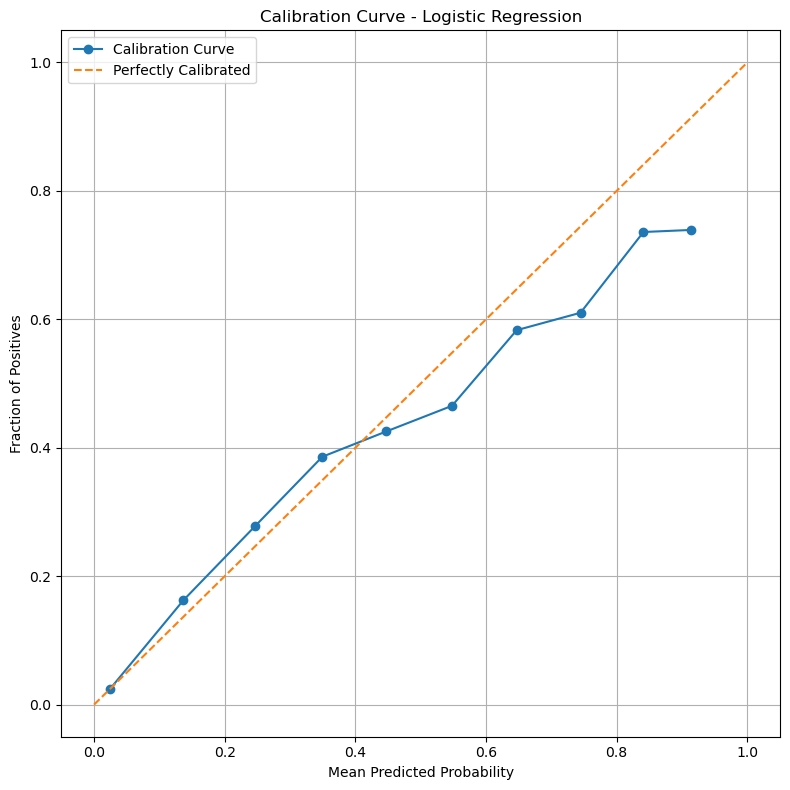

feature  importance_mean  importance_std
6                   HadAngina         0.214267        0.002426
40                AgeGroupNum         0.091147        0.001689
1                         Sex         0.028199        0.001177
7                   HadStroke         0.019249        0.001225
25                AgeCategory         0.016602        0.001128
2               GeneralHealth         0.015834        0.002251
23                  ChestScan         0.005771        0.001392
21               SmokerStatus         0.005664        0.000901
5                RemovedTeeth         0.005427        0.000493
14                HadDiabetes         0.004050        0.000857
0                       State         0.001090        0.000437
38          WeightInKilograms         0.001051        0.000279
24      RaceEthnicityCategory         0.000914        0.000424
3             LastCheckupTime         0.000840        0.000316
32                   CovidPos         0.000673        0.000469
29              PneumoVaxEver         0.000514        0.000085
30          TetanusLast10Tdap         0.000508        0.000544
10                    HadCOPD         0.000469        0.000237
26            AlcoholDrinkers         0.000457        0.000269
33               BMI_Category         0.000316        0.000326
28               FluVaxLast12         0.000305        0.000085
36                 SleepHours         0.000298        0.000118
19  DifficultyDressingBathing         0.000283        0.000142
16    BlindOrVisionDifficulty         0.000256        0.000191
35           MentalHealthDays         0.000164        0.000068
20          DifficultyErrands         0.000146        0.000095
11      HadDepressiveDisorder         0.000136        0.000072
9               HadSkinCancer         0.000099        0.000144
4          PhysicalActivities         0.000096        0.000132
39                        BMI         0.000039        0.000095
12           HadKidneyDisease         0.000036        0.000208
17    DifficultyConcentrating         0.000026        0.000096
34         PhysicalHealthDays         0.000018        0.000083
8                   HadAsthma         0.000002        0.000037
27                 HIVTesting        -0.000004        0.000030
37             HeightInMeters        -0.000014        0.000040
31           HighRiskLastYear        -0.000015        0.000125
22            ECigaretteUsage        -0.000065        0.000094
13               HadArthritis        -0.000196        0.000138
15        DeafOrHardOfHearing        -0.000278        0.000094
18          DifficultyWalking        -0.000454        0.000160

Plot Permutation Importance


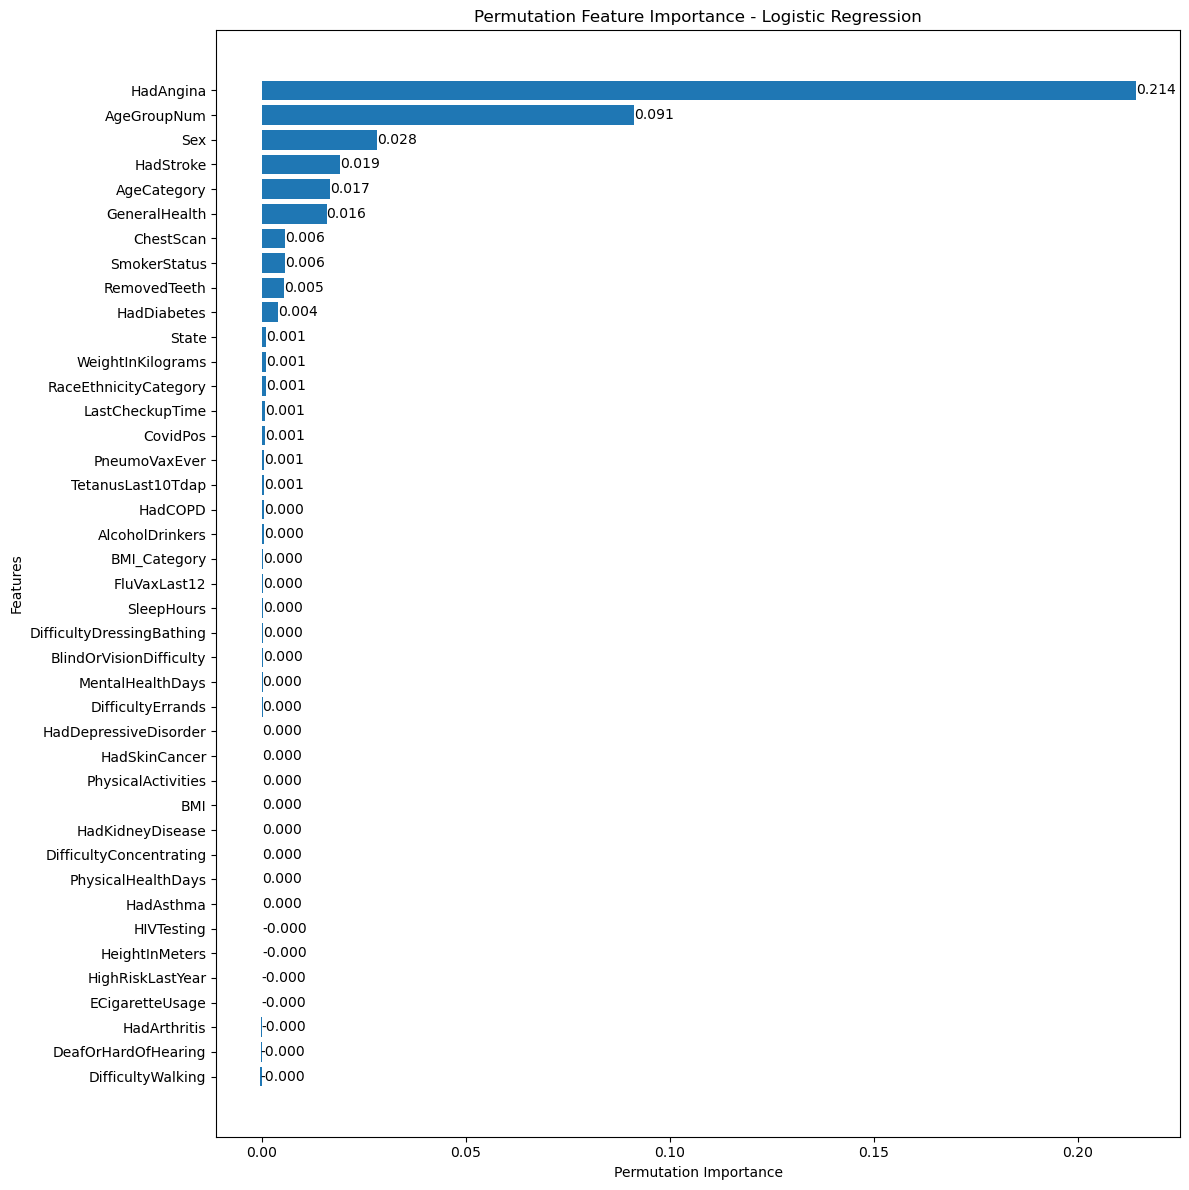

In [8]:
# Define optuna objective
def logistic_objective(trial):
    params = {
        # C stand for inverse of the regularization strength
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        # Determine what kinds of regularization algorithm to be applied
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        # Algorithm to find best coefficients.
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'sag', 'newton-cg']),
        # Mitigate effects of imbalanced data
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    # Logisitic Regression doen not allow certain combination of penalty methods and
    # solvers. When encounter such combinations, tell optuna to skip this trials
    if (params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']) or (
        params['penalty'] == 'l2' and params['solver'] not in [
            'liblinear', 'saga', 'lbfgs', 'sag', 'newton-cg']
    ):
        raise optuna.exceptions.TrialPruned()

    # Instantiate logistic model
    logistic_model = LogisticRegression(
        **params,
        random_state=seed,
        max_iter=1000,
    )
    logistic_model.fit(X_train_dummies, y_train)

    proba = logistic_model.predict_proba(X_validation_dummies)[:, 1]
    score = average_precision_score(y_validation, proba)
    return score


# Define wrap logistic model with data preprocess for permutation importance
class wrap_logistic(ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = model.classes_

    def fit(self, X_test, y=None):
        return self

    def predict_proba(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict_proba(X_test_permutation)

    def predict(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict(X_test_permutation)


# Define optuna study object, and direction is to maximize area under PR-Curve.
# Evaluated on validation set.
output_seperate('Searching Hyperparameters')
logistic_study = optuna.create_study(direction='maximize', sampler=sampler)
logistic_study.optimize(logistic_objective, n_trials=n_trials)

output_seperate('Train model with best hyperparameters...')
# Train model with best hyperparameters and calculate results on test set.
logistic_model = LogisticRegression(**logistic_study.best_params,
                                    random_state=seed,
                                    max_iter=1000,
                                    )
logistic_model.fit(X_train_dummies, y_train)
logistic_pred = logistic_model.predict(X_test_dummies)
logistic_proba = logistic_model.predict_proba(X_test_dummies)[:, 1]
logistic_score = average_precision_score(y_test, logistic_proba)
logistic_results = output_results(
    logistic_score, logistic_study, y_test, logistic_pred, logistic_proba)
# Show coefficients founded
output_seperate('Coefficient - Logistic Regression')
coef = pd.DataFrame(data=logistic_model.coef_.T,
                    index=dummies_col_names, columns=['Coefficient'])
display(coef.sort_values('Coefficient', ascending=False))
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test,
                 logistic_proba, 'Logistic Regression')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test,
                 logistic_proba, 'Logistic Regression')
wrapped_logistic = wrap_logistic(logistic_model)
logistic_important_df = calculate_permutation_importance(
    wrapped_logistic, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance, (12, 12),
                 logistic_important_df, 'Logistic Regression')

## 5.3. LightGBM


Searching Hyperparameters


[I 2025-04-13 14:19:56,607] A new study created in memory with name: no-name-119f3f57-cd65-48cc-b00b-e0f760176950


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:19:57,466] Trial 0 finished with value: 0.4129791047195529 and parameters: {'n_estimators': 11957, 'learning_rate': 0.021936895955419825, 'max_depth': 9, 'num_leaves': 106, 'min_child_samples': 18, 'subsample': 0.5110330248932573, 'colsample_bytree': 0.7282554824061971, 'reg_alpha': 4.125147530975503e-05, 'reg_lambda': 6.167783891050439, 'pos_weight': 9.712477200078323}. Best is trial 0 with value: 0.4129791047195529.


Early stopping, best iteration is:
[10]	valid_0's average_precision: 0.412979	valid_0's binary_logloss: 0.191551
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[374]	valid_0's average_precision: 0.429734	valid_0's binary_logloss: 0.169209


[I 2025-04-13 14:20:01,467] Trial 1 finished with value: 0.42973446768284934 and parameters: {'n_estimators': 15386, 'learning_rate': 0.01525630293674139, 'max_depth': 14, 'num_leaves': 114, 'min_child_samples': 10, 'subsample': 0.9792474334349497, 'colsample_bytree': 0.599305161764144, 'reg_alpha': 2.65933947919664, 'reg_lambda': 1.0901131957110004e-08, 'pos_weight': 0.3068854071246792}. Best is trial 1 with value: 0.42973446768284934.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:02,319] Trial 2 finished with value: 0.422718714485127 and parameters: {'n_estimators': 6191, 'learning_rate': 0.06867176171728802, 'max_depth': 11, 'num_leaves': 119, 'min_child_samples': 26, 'subsample': 0.8943032054410429, 'colsample_bytree': 0.8734971691018263, 'reg_alpha': 2.3138983394882494e-05, 'reg_lambda': 0.00023718121342309535, 'pos_weight': 2.5102307766652148}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[20]	valid_0's average_precision: 0.422719	valid_0's binary_logloss: 0.164668
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:03,761] Trial 3 finished with value: 0.42610319025904175 and parameters: {'n_estimators': 6669, 'learning_rate': 0.01935229957903338, 'max_depth': 26, 'num_leaves': 121, 'min_child_samples': 32, 'subsample': 0.5491150986185, 'colsample_bytree': 0.9873519401722483, 'reg_alpha': 1.8301028252195082e-06, 'reg_lambda': 0.0008165631312128769, 'pos_weight': 2.2649078380203536}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[79]	valid_0's average_precision: 0.426103	valid_0's binary_logloss: 0.161178
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:04,643] Trial 4 finished with value: 0.40404547772356797 and parameters: {'n_estimators': 7001, 'learning_rate': 0.04162956862402472, 'max_depth': 30, 'num_leaves': 128, 'min_child_samples': 22, 'subsample': 0.9782735959305433, 'colsample_bytree': 0.6967806181489811, 'reg_alpha': 0.09600326902403586, 'reg_lambda': 0.18172864847583461, 'pos_weight': 9.291990104127962}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[5]	valid_0's average_precision: 0.404045	valid_0's binary_logloss: 0.189193
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:05,538] Trial 5 finished with value: 0.4223950694850371 and parameters: {'n_estimators': 6924, 'learning_rate': 0.06526894855549809, 'max_depth': 26, 'num_leaves': 145, 'min_child_samples': 11, 'subsample': 0.595653544154967, 'colsample_bytree': 0.9805929556171984, 'reg_alpha': 0.008226871259966205, 'reg_lambda': 2.415716514030086, 'pos_weight': 3.198171812731262}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[12]	valid_0's average_precision: 0.422395	valid_0's binary_logloss: 0.169113
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:06,240] Trial 6 finished with value: 0.4151777880029352 and parameters: {'n_estimators': 10092, 'learning_rate': 0.018534305503761138, 'max_depth': 7, 'num_leaves': 72, 'min_child_samples': 16, 'subsample': 0.6183929894359687, 'colsample_bytree': 0.7732904176588946, 'reg_alpha': 0.006519855031360676, 'reg_lambda': 5.95928047501825, 'pos_weight': 7.668338049135917}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[14]	valid_0's average_precision: 0.415178	valid_0's binary_logloss: 0.189221
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:06,897] Trial 7 finished with value: 0.38044153828419 and parameters: {'n_estimators': 6682, 'learning_rate': 0.06176257598559333, 'max_depth': 11, 'num_leaves': 43, 'min_child_samples': 44, 'subsample': 0.7399489764154026, 'colsample_bytree': 0.9931674017616874, 'reg_alpha': 1.2803024236341942e-08, 'reg_lambda': 0.0007022845550453344, 'pos_weight': 9.979449938314744}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[3]	valid_0's average_precision: 0.380442	valid_0's binary_logloss: 0.189721
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:07,777] Trial 8 finished with value: 0.4166778116073378 and parameters: {'n_estimators': 12717, 'learning_rate': 0.07541448142760189, 'max_depth': 12, 'num_leaves': 115, 'min_child_samples': 27, 'subsample': 0.8621011623195498, 'colsample_bytree': 0.8215086343672195, 'reg_alpha': 3.178500885187852e-08, 'reg_lambda': 4.260755094680031, 'pos_weight': 4.334208283047629}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[7]	valid_0's average_precision: 0.416678	valid_0's binary_logloss: 0.176551
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:08,556] Trial 9 finished with value: 0.41300982339752 and parameters: {'n_estimators': 6250, 'learning_rate': 0.05052665797689063, 'max_depth': 8, 'num_leaves': 143, 'min_child_samples': 13, 'subsample': 0.7492780969709334, 'colsample_bytree': 0.5126178454850334, 'reg_alpha': 2.4500798743846562e-05, 'reg_lambda': 0.12575357847470803, 'pos_weight': 7.890576656019242}. Best is trial 1 with value: 0.42973446768284934.


Early stopping, best iteration is:
[5]	valid_0's average_precision: 0.41301	valid_0's binary_logloss: 0.191029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[611]	valid_0's average_precision: 0.429915	valid_0's binary_logloss: 0.167031


[I 2025-04-13 14:20:13,926] Trial 10 finished with value: 0.4299153324585243 and parameters: {'n_estimators': 18571, 'learning_rate': 0.010785188148581216, 'max_depth': 18, 'num_leaves': 67, 'min_child_samples': 6, 'subsample': 0.9795680743295653, 'colsample_bytree': 0.5549834119207513, 'reg_alpha': 4.626435205244538, 'reg_lambda': 1.0764345033694528e-08, 'pos_weight': 0.3315123006725009}. Best is trial 10 with value: 0.4299153324585243.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[767]	valid_0's average_precision: 0.42996	valid_0's binary_logloss: 0.165296


[I 2025-04-13 14:20:20,765] Trial 11 finished with value: 0.42996021730694656 and parameters: {'n_estimators': 18264, 'learning_rate': 0.010320589378028605, 'max_depth': 18, 'num_leaves': 78, 'min_child_samples': 5, 'subsample': 0.9726540729867185, 'colsample_bytree': 0.5557238936790906, 'reg_alpha': 5.7502936001705205, 'reg_lambda': 1.095336159806195e-08, 'pos_weight': 0.34843544533060855}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[784]	valid_0's average_precision: 0.429925	valid_0's binary_logloss: 0.171131


[I 2025-04-13 14:20:27,835] Trial 12 finished with value: 0.4299245390360521 and parameters: {'n_estimators': 19686, 'learning_rate': 0.010416621722155751, 'max_depth': 19, 'num_leaves': 71, 'min_child_samples': 6, 'subsample': 0.8747501379165511, 'colsample_bytree': 0.5008290772034352, 'reg_alpha': 6.655168627365114, 'reg_lambda': 1.061973421374841e-08, 'pos_weight': 0.29262189842069575}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[542]	valid_0's average_precision: 0.426342	valid_0's binary_logloss: 0.150288


[I 2025-04-13 14:20:31,501] Trial 13 finished with value: 0.4263420523386972 and parameters: {'n_estimators': 19882, 'learning_rate': 0.010328140223028807, 'max_depth': 19, 'num_leaves': 22, 'min_child_samples': 5, 'subsample': 0.855997366023471, 'colsample_bytree': 0.6299006386554298, 'reg_alpha': 0.43632558448377357, 'reg_lambda': 5.336556092790156e-07, 'pos_weight': 1.374498694852317}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:32,381] Trial 14 finished with value: 0.41822380765401884 and parameters: {'n_estimators': 301, 'learning_rate': 0.02912931272284286, 'max_depth': 21, 'num_leaves': 87, 'min_child_samples': 36, 'subsample': 0.905138809750055, 'colsample_bytree': 0.5111807092954332, 'reg_alpha': 0.0377617697622328, 'reg_lambda': 1.0132825968260802e-06, 'pos_weight': 5.282257773021496}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[14]	valid_0's average_precision: 0.418224	valid_0's binary_logloss: 0.185047
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:33,413] Trial 15 finished with value: 0.4188150172149245 and parameters: {'n_estimators': 17365, 'learning_rate': 0.013577851833123116, 'max_depth': 22, 'num_leaves': 90, 'min_child_samples': 5, 'subsample': 0.828331975099421, 'colsample_bytree': 0.6510845528601492, 'reg_alpha': 6.774576030766499, 'reg_lambda': 4.611025701483256e-07, 'pos_weight': 5.165357498296337}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[34]	valid_0's average_precision: 0.418815	valid_0's binary_logloss: 0.183215
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:35,706] Trial 16 finished with value: 0.4279030860031799 and parameters: {'n_estimators': 15741, 'learning_rate': 0.026499866873080646, 'max_depth': 16, 'num_leaves': 53, 'min_child_samples': 47, 'subsample': 0.8163093047805943, 'colsample_bytree': 0.5747701562309175, 'reg_alpha': 0.0009423221382256676, 'reg_lambda': 1.0501271424514954e-05, 'pos_weight': 1.348954282148207}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[228]	valid_0's average_precision: 0.427903	valid_0's binary_logloss: 0.149781
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:36,543] Trial 17 finished with value: 0.4168386613156535 and parameters: {'n_estimators': 15444, 'learning_rate': 0.09555434927917893, 'max_depth': 23, 'num_leaves': 67, 'min_child_samples': 20, 'subsample': 0.9247614550838213, 'colsample_bytree': 0.5015133970050317, 'reg_alpha': 0.5668506555748061, 'reg_lambda': 8.911772405375046e-08, 'pos_weight': 3.5920383583481157}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[7]	valid_0's average_precision: 0.416839	valid_0's binary_logloss: 0.176251
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:39,299] Trial 18 finished with value: 0.42632011733410713 and parameters: {'n_estimators': 19702, 'learning_rate': 0.013426153203102677, 'max_depth': 15, 'num_leaves': 43, 'min_child_samples': 11, 'subsample': 0.6851989396605647, 'colsample_bytree': 0.6532228859833858, 'reg_alpha': 0.21734468585098227, 'reg_lambda': 1.8297341293248414e-05, 'pos_weight': 1.3830399490493819}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[335]	valid_0's average_precision: 0.42632	valid_0's binary_logloss: 0.150473
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:40,077] Trial 19 finished with value: 0.4160247766184165 and parameters: {'n_estimators': 13075, 'learning_rate': 0.03661797681717766, 'max_depth': 20, 'num_leaves': 96, 'min_child_samples': 40, 'subsample': 0.7995051057190175, 'colsample_bytree': 0.5603831178478913, 'reg_alpha': 0.0009061455530616978, 'reg_lambda': 9.312910171690175e-08, 'pos_weight': 6.985993894699757}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[7]	valid_0's average_precision: 0.416025	valid_0's binary_logloss: 0.187928
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:41,394] Trial 20 finished with value: 0.42485273546287544 and parameters: {'n_estimators': 17186, 'learning_rate': 0.015568363218729982, 'max_depth': 17, 'num_leaves': 77, 'min_child_samples': 23, 'subsample': 0.9358623082007291, 'colsample_bytree': 0.6882480224229417, 'reg_alpha': 0.01449876501968966, 'reg_lambda': 1.2862373313572532e-05, 'pos_weight': 0.335715219728826}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[87]	valid_0's average_precision: 0.424853	valid_0's binary_logloss: 0.172591
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:20:43,080] Trial 21 finished with value: 0.42386491095965173 and parameters: {'n_estimators': 18015, 'learning_rate': 0.010134816581579614, 'max_depth': 18, 'num_leaves': 62, 'min_child_samples': 5, 'subsample': 0.9979320420725288, 'colsample_bytree': 0.5557920062125533, 'reg_alpha': 8.84667183506312, 'reg_lambda': 1.5875261780177664e-08, 'pos_weight': 0.151685015036354}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[210]	valid_0's average_precision: 0.423865	valid_0's binary_logloss: 0.196231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[588]	valid_0's average_precision: 0.42859	valid_0's binary_logloss: 0.148097


[I 2025-04-13 14:20:47,919] Trial 22 finished with value: 0.4285904401489406 and parameters: {'n_estimators': 18492, 'learning_rate': 0.01256315229917497, 'max_depth': 24, 'num_leaves': 56, 'min_child_samples': 9, 'subsample': 0.9502053343735788, 'colsample_bytree': 0.6012952788172519, 'reg_alpha': 1.645381436221848, 'reg_lambda': 6.487583906851687e-08, 'pos_weight': 1.1642459388748014}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[669]	valid_0's average_precision: 0.428773	valid_0's binary_logloss: 0.160398


[I 2025-04-13 14:20:54,500] Trial 23 finished with value: 0.4287729610116403 and parameters: {'n_estimators': 14743, 'learning_rate': 0.010059617066965836, 'max_depth': 18, 'num_leaves': 79, 'min_child_samples': 14, 'subsample': 0.8957318146681988, 'colsample_bytree': 0.5437575152602134, 'reg_alpha': 9.999931724111024, 'reg_lambda': 1.558131184160778e-06, 'pos_weight': 2.1087996575416836}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid_0's average_precision: 0.428851	valid_0's binary_logloss: 0.14823


[I 2025-04-13 14:20:59,217] Trial 24 finished with value: 0.4288513327170984 and parameters: {'n_estimators': 19925, 'learning_rate': 0.011773704226833086, 'max_depth': 14, 'num_leaves': 102, 'min_child_samples': 8, 'subsample': 0.9544363656728906, 'colsample_bytree': 0.5392686768867279, 'reg_alpha': 0.9448339088445593, 'reg_lambda': 1.1520605659407823e-08, 'pos_weight': 0.8974962022375305}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:00,266] Trial 25 finished with value: 0.42517438077363656 and parameters: {'n_estimators': 16782, 'learning_rate': 0.01679409476283183, 'max_depth': 5, 'num_leaves': 42, 'min_child_samples': 16, 'subsample': 0.8757722862084966, 'colsample_bytree': 0.5917516415384004, 'reg_alpha': 0.08811093937440849, 'reg_lambda': 8.189709985610808e-08, 'pos_weight': 2.976555924852931}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[78]	valid_0's average_precision: 0.425174	valid_0's binary_logloss: 0.172834
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:01,017] Trial 26 finished with value: 0.41694288606306645 and parameters: {'n_estimators': 14221, 'learning_rate': 0.024206379802885283, 'max_depth': 20, 'num_leaves': 31, 'min_child_samples': 8, 'subsample': 0.9997812557025665, 'colsample_bytree': 0.62333093765203, 'reg_alpha': 1.765300091816018, 'reg_lambda': 4.330863625262758e-06, 'pos_weight': 6.052862627473376}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[14]	valid_0's average_precision: 0.416943	valid_0's binary_logloss: 0.187184
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:02,249] Trial 27 finished with value: 0.41995340644068657 and parameters: {'n_estimators': 18628, 'learning_rate': 0.011976980819495775, 'max_depth': 25, 'num_leaves': 81, 'min_child_samples': 31, 'subsample': 0.7877817335367416, 'colsample_bytree': 0.8864767693836687, 'reg_alpha': 0.3601164193032645, 'reg_lambda': 6.883466800238402e-05, 'pos_weight': 4.056247068807695}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[50]	valid_0's average_precision: 0.419953	valid_0's binary_logloss: 0.175803
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:04,979] Trial 28 finished with value: 0.42750975787386297 and parameters: {'n_estimators': 10325, 'learning_rate': 0.02075443259114771, 'max_depth': 16, 'num_leaves': 57, 'min_child_samples': 14, 'subsample': 0.9503330101188628, 'colsample_bytree': 0.5335962248853556, 'reg_alpha': 0.03967074805843902, 'reg_lambda': 0.007058981855243042, 'pos_weight': 1.897743228330703}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[261]	valid_0's average_precision: 0.42751	valid_0's binary_logloss: 0.157172
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:07,073] Trial 29 finished with value: 0.42751870511501555 and parameters: {'n_estimators': 3207, 'learning_rate': 0.016431823149552948, 'max_depth': 28, 'num_leaves': 72, 'min_child_samples': 18, 'subsample': 0.8424696032079362, 'colsample_bytree': 0.7671870973472863, 'reg_alpha': 0.00014484360527316253, 'reg_lambda': 1.9852019268617346e-07, 'pos_weight': 0.7035651592125156}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[171]	valid_0's average_precision: 0.427519	valid_0's binary_logloss: 0.151642
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:09,746] Trial 30 finished with value: 0.4262417071060286 and parameters: {'n_estimators': 11317, 'learning_rate': 0.011461382789003719, 'max_depth': 13, 'num_leaves': 99, 'min_child_samples': 7, 'subsample': 0.9178374909902147, 'colsample_bytree': 0.702575252464641, 'reg_alpha': 3.2183931838447354e-07, 'reg_lambda': 3.0632343790718186e-08, 'pos_weight': 1.826376362589512}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[223]	valid_0's average_precision: 0.426242	valid_0's binary_logloss: 0.156258
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:11,112] Trial 31 finished with value: 0.4267141139433865 and parameters: {'n_estimators': 16185, 'learning_rate': 0.014710711619344216, 'max_depth': 14, 'num_leaves': 107, 'min_child_samples': 11, 'subsample': 0.9700805838595302, 'colsample_bytree': 0.6076349737609699, 'reg_alpha': 2.3395788214358952, 'reg_lambda': 3.4976553210055716e-08, 'pos_weight': 0.14410960656483526}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[119]	valid_0's average_precision: 0.426714	valid_0's binary_logloss: 0.195562
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:14,510] Trial 32 finished with value: 0.4289926091814127 and parameters: {'n_estimators': 18729, 'learning_rate': 0.01403760177501197, 'max_depth': 10, 'num_leaves': 65, 'min_child_samples': 10, 'subsample': 0.9725048479972462, 'colsample_bytree': 0.6468533349348524, 'reg_alpha': 3.917916817145661, 'reg_lambda': 1.7886617531087498e-08, 'pos_weight': 0.7046464338061764}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[372]	valid_0's average_precision: 0.428993	valid_0's binary_logloss: 0.149972
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:15,934] Trial 33 finished with value: 0.42662793006528255 and parameters: {'n_estimators': 13969, 'learning_rate': 0.011646512747403106, 'max_depth': 16, 'num_leaves': 89, 'min_child_samples': 6, 'subsample': 0.8850380168264487, 'colsample_bytree': 0.5715402317078027, 'reg_alpha': 1.7276633202816145, 'reg_lambda': 1.0514402726340447e-08, 'pos_weight': 0.7251949207378499}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[78]	valid_0's average_precision: 0.426628	valid_0's binary_logloss: 0.167245
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:17,922] Trial 34 finished with value: 0.4240612639964157 and parameters: {'n_estimators': 17553, 'learning_rate': 0.01816303775521712, 'max_depth': 19, 'num_leaves': 137, 'min_child_samples': 8, 'subsample': 0.9996898295380272, 'colsample_bytree': 0.5227953604203777, 'reg_alpha': 5.793769531044537e-06, 'reg_lambda': 3.8696361901631043e-07, 'pos_weight': 2.5162237364030053}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[78]	valid_0's average_precision: 0.424061	valid_0's binary_logloss: 0.166115
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:20,193] Trial 35 finished with value: 0.4278063643846903 and parameters: {'n_estimators': 16328, 'learning_rate': 0.022232289150114576, 'max_depth': 22, 'num_leaves': 115, 'min_child_samples': 12, 'subsample': 0.9202556146269302, 'colsample_bytree': 0.5838834108480163, 'reg_alpha': 0.15825985677400056, 'reg_lambda': 1.5613787398443493e-07, 'pos_weight': 1.7004143055553191}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[169]	valid_0's average_precision: 0.427806	valid_0's binary_logloss: 0.154178
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:22,118] Trial 36 finished with value: 0.4251686124323266 and parameters: {'n_estimators': 19212, 'learning_rate': 0.01119697632956634, 'max_depth': 17, 'num_leaves': 130, 'min_child_samples': 23, 'subsample': 0.9714663512847064, 'colsample_bytree': 0.6702596511689628, 'reg_alpha': 0.7893887536750333, 'reg_lambda': 1.565022629694759e-06, 'pos_weight': 2.603680953504942}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[119]	valid_0's average_precision: 0.425169	valid_0's binary_logloss: 0.166074
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:23,127] Trial 37 finished with value: 0.42307990425988573 and parameters: {'n_estimators': 17867, 'learning_rate': 0.014641475680233135, 'max_depth': 14, 'num_leaves': 50, 'min_child_samples': 16, 'subsample': 0.710742919127145, 'colsample_bytree': 0.7169708453237719, 'reg_alpha': 3.644881523806956, 'reg_lambda': 4.374076996440695e-08, 'pos_weight': 0.11740010733137876}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[89]	valid_0's average_precision: 0.42308	valid_0's binary_logloss: 0.20052
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:25,739] Trial 38 finished with value: 0.4268162814536896 and parameters: {'n_estimators': 15462, 'learning_rate': 0.017603338227268266, 'max_depth': 12, 'num_leaves': 73, 'min_child_samples': 9, 'subsample': 0.5421745422927879, 'colsample_bytree': 0.5524020826610248, 'reg_alpha': 0.06200983857509105, 'reg_lambda': 0.008090313902634516, 'pos_weight': 0.8170751890734185}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[240]	valid_0's average_precision: 0.426816	valid_0's binary_logloss: 0.149105
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:27,277] Trial 39 finished with value: 0.4231916023717344 and parameters: {'n_estimators': 8526, 'learning_rate': 0.012787353864686962, 'max_depth': 20, 'num_leaves': 94, 'min_child_samples': 30, 'subsample': 0.9335080848106377, 'colsample_bytree': 0.5006585949127669, 'reg_alpha': 0.017992297234417597, 'reg_lambda': 1.0398365415449918e-08, 'pos_weight': 2.9962129470681087}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[78]	valid_0's average_precision: 0.423192	valid_0's binary_logloss: 0.171576
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:28,084] Trial 40 finished with value: 0.41119713521759343 and parameters: {'n_estimators': 12135, 'learning_rate': 0.0356956659347043, 'max_depth': 18, 'num_leaves': 107, 'min_child_samples': 19, 'subsample': 0.6524210109637886, 'colsample_bytree': 0.8811576781009361, 'reg_alpha': 0.0025429411463927317, 'reg_lambda': 1.9732013648312953e-07, 'pos_weight': 8.632144698520158}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[7]	valid_0's average_precision: 0.411197	valid_0's binary_logloss: 0.188562
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:31,314] Trial 41 finished with value: 0.428587516474062 and parameters: {'n_estimators': 18867, 'learning_rate': 0.014364040780835932, 'max_depth': 8, 'num_leaves': 63, 'min_child_samples': 10, 'subsample': 0.9738372889892887, 'colsample_bytree': 0.6210924623578852, 'reg_alpha': 3.7420811854119447, 'reg_lambda': 3.476637016953975e-08, 'pos_weight': 0.5906601561477429}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[357]	valid_0's average_precision: 0.428588	valid_0's binary_logloss: 0.152704
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:33,805] Trial 42 finished with value: 0.4264684904916899 and parameters: {'n_estimators': 18773, 'learning_rate': 0.01066748885910121, 'max_depth': 11, 'num_leaves': 66, 'min_child_samples': 13, 'subsample': 0.9700950222990745, 'colsample_bytree': 0.7432737559573249, 'reg_alpha': 3.936095789257191, 'reg_lambda': 3.240351895391966e-08, 'pos_weight': 1.1136333183956855}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[227]	valid_0's average_precision: 0.426468	valid_0's binary_logloss: 0.150267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[380]	valid_0's average_precision: 0.42811	valid_0's binary_logloss: 0.151914


[I 2025-04-13 14:21:37,517] Trial 43 finished with value: 0.42811008725027155 and parameters: {'n_estimators': 16972, 'learning_rate': 0.012982505573737004, 'max_depth': 9, 'num_leaves': 79, 'min_child_samples': 5, 'subsample': 0.9037484371348681, 'colsample_bytree': 0.6420228777900329, 'reg_alpha': 9.964370452343003, 'reg_lambda': 2.0639973496862975e-08, 'pos_weight': 1.5361667994378565}. Best is trial 11 with value: 0.42996021730694656.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:40,413] Trial 44 finished with value: 0.42673009042063564 and parameters: {'n_estimators': 19962, 'learning_rate': 0.010095243403833172, 'max_depth': 10, 'num_leaves': 67, 'min_child_samples': 7, 'subsample': 0.9464407442538727, 'colsample_bytree': 0.8224808197280933, 'reg_alpha': 0.2750793452149694, 'reg_lambda': 2.69710736733655e-07, 'pos_weight': 0.5350542230295253}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[292]	valid_0's average_precision: 0.42673	valid_0's binary_logloss: 0.155659
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:41,656] Trial 45 finished with value: 0.4249972633889417 and parameters: {'n_estimators': 17957, 'learning_rate': 0.0195075831575664, 'max_depth': 5, 'num_leaves': 84, 'min_child_samples': 10, 'subsample': 0.9823024016713049, 'colsample_bytree': 0.5881382588413469, 'reg_alpha': 0.6342989582014211, 'reg_lambda': 8.352260854410748e-07, 'pos_weight': 2.3488586429760905}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[91]	valid_0's average_precision: 0.424997	valid_0's binary_logloss: 0.165493
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:44,540] Trial 46 finished with value: 0.42809302109274544 and parameters: {'n_estimators': 14756, 'learning_rate': 0.015596820973658285, 'max_depth': 12, 'num_leaves': 49, 'min_child_samples': 15, 'subsample': 0.8633358410707827, 'colsample_bytree': 0.5264197825987534, 'reg_alpha': 1.1540256548246706, 'reg_lambda': 1.0009485325806152e-08, 'pos_weight': 1.0743938899906977}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[276]	valid_0's average_precision: 0.428093	valid_0's binary_logloss: 0.148424
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:46,291] Trial 47 finished with value: 0.4273890689597166 and parameters: {'n_estimators': 19038, 'learning_rate': 0.04763107006105087, 'max_depth': 15, 'num_leaves': 149, 'min_child_samples': 12, 'subsample': 0.7756974029880273, 'colsample_bytree': 0.6092885780711088, 'reg_alpha': 4.49897852784639, 'reg_lambda': 0.3267174102369279, 'pos_weight': 0.500072523440598}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[108]	valid_0's average_precision: 0.427389	valid_0's binary_logloss: 0.156024
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:48,371] Trial 48 finished with value: 0.4266823106703061 and parameters: {'n_estimators': 4136, 'learning_rate': 0.01393525127620127, 'max_depth': 21, 'num_leaves': 72, 'min_child_samples': 36, 'subsample': 0.9127381191795506, 'colsample_bytree': 0.6692955248060338, 'reg_alpha': 0.15364560604653119, 'reg_lambda': 2.9912509699221554e-06, 'pos_weight': 1.453971174732135}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[169]	valid_0's average_precision: 0.426682	valid_0's binary_logloss: 0.152618
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 14:21:49,358] Trial 49 finished with value: 0.4181390018371143 and parameters: {'n_estimators': 16218, 'learning_rate': 0.010961372229221228, 'max_depth': 19, 'num_leaves': 58, 'min_child_samples': 25, 'subsample': 0.8796993589666265, 'colsample_bytree': 0.5686071157282583, 'reg_alpha': 2.8074629461905847, 'reg_lambda': 7.42508058814989e-08, 'pos_weight': 5.826955168866978}. Best is trial 11 with value: 0.42996021730694656.


Early stopping, best iteration is:
[36]	valid_0's average_precision: 0.418139	valid_0's binary_logloss: 0.186763
Train model with best hyperparameters...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[533]	valid_0's average_precision: 0.429301	valid_0's binary_logloss: 0.147786
Best Hyperparameters:


{'n_estimators': 18264,
 'learning_rate': 0.010320589378028605,
 'max_depth': 18,
 'num_leaves': 78,
 'min_child_samples': 5,
 'subsample': 0.9726540729867185,
 'colsample_bytree': 0.5557238936790906,
 'reg_alpha': 5.7502936001705205,
 'reg_lambda': 1.095336159806195e-08,
 'pos_weight': 0.34843544533060855}

Results


0
PR AUC     0.410261
ROC AUC    0.884743
F1 Score   0.308832
Precision  0.603708
Recall     0.207487

Plot Precision-Recall Curve


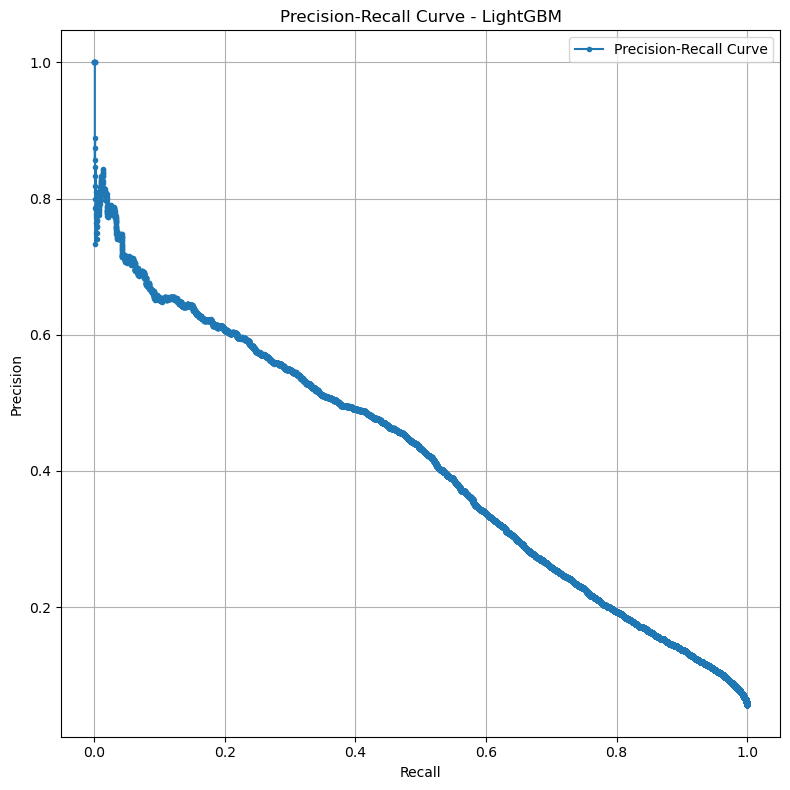

Plot Calibration Curve


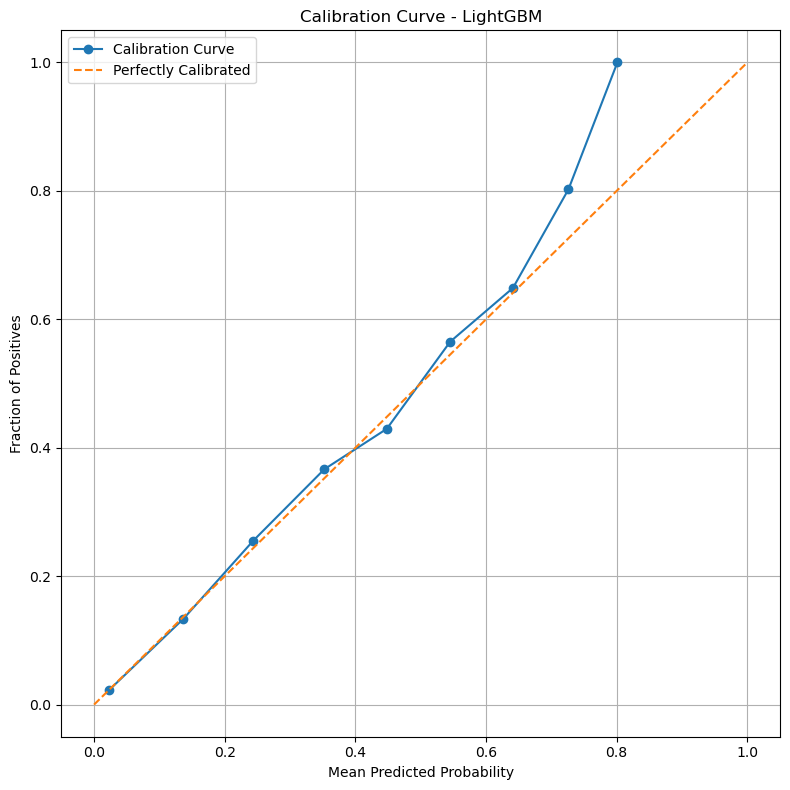

feature  importance_mean  importance_std
6                   HadAngina     2.452533e-01        0.002234
1                         Sex     2.427568e-02        0.001378
40                AgeGroupNum     2.128426e-02        0.001271
7                   HadStroke     2.116901e-02        0.001230
2               GeneralHealth     8.309527e-03        0.001455
21               SmokerStatus     6.444611e-03        0.001017
5                RemovedTeeth     5.864780e-03        0.000493
23                  ChestScan     5.007369e-03        0.001057
14                HadDiabetes     4.332782e-03        0.001008
36                 SleepHours     1.606835e-03        0.000550
26            AlcoholDrinkers     1.272301e-03        0.000200
13               HadArthritis     1.262327e-03        0.000320
28               FluVaxLast12     1.240790e-03        0.000444
10                    HadCOPD     1.139599e-03        0.000339
39                        BMI     1.093953e-03        0.000536
24      RaceEthnicityCategory     8.586449e-04        0.000369
29              PneumoVaxEver     8.179523e-04        0.000269
37             HeightInMeters     6.541875e-04        0.000420
25                AgeCategory     5.761366e-04        0.000555
34         PhysicalHealthDays     5.594793e-04        0.000257
3             LastCheckupTime     5.435218e-04        0.000278
38          WeightInKilograms     5.120572e-04        0.000425
32                   CovidPos     4.330295e-04        0.000399
30          TetanusLast10Tdap     4.318586e-04        0.000247
16    BlindOrVisionDifficulty     4.311594e-04        0.000100
0                       State     2.480859e-04        0.000295
8                   HadAsthma     2.427877e-04        0.000145
17    DifficultyConcentrating     1.332139e-04        0.000188
27                 HIVTesting     1.250587e-04        0.000098
19  DifficultyDressingBathing     1.071817e-04        0.000065
35           MentalHealthDays     9.721248e-05        0.000279
20          DifficultyErrands     4.513372e-05        0.000034
33               BMI_Category     4.039199e-05        0.000033
22            ECigaretteUsage     9.684676e-06        0.000082
4          PhysicalActivities     5.624864e-06        0.000099
31           HighRiskLastYear    -1.886184e-08        0.000008
9               HadSkinCancer    -2.694402e-05        0.000398
12           HadKidneyDisease    -3.163582e-05        0.000129
18          DifficultyWalking    -6.254155e-05        0.000389
11      HadDepressiveDisorder    -7.715830e-05        0.000054
15        DeafOrHardOfHearing    -1.364690e-04        0.000151

Plot Permutation Importance


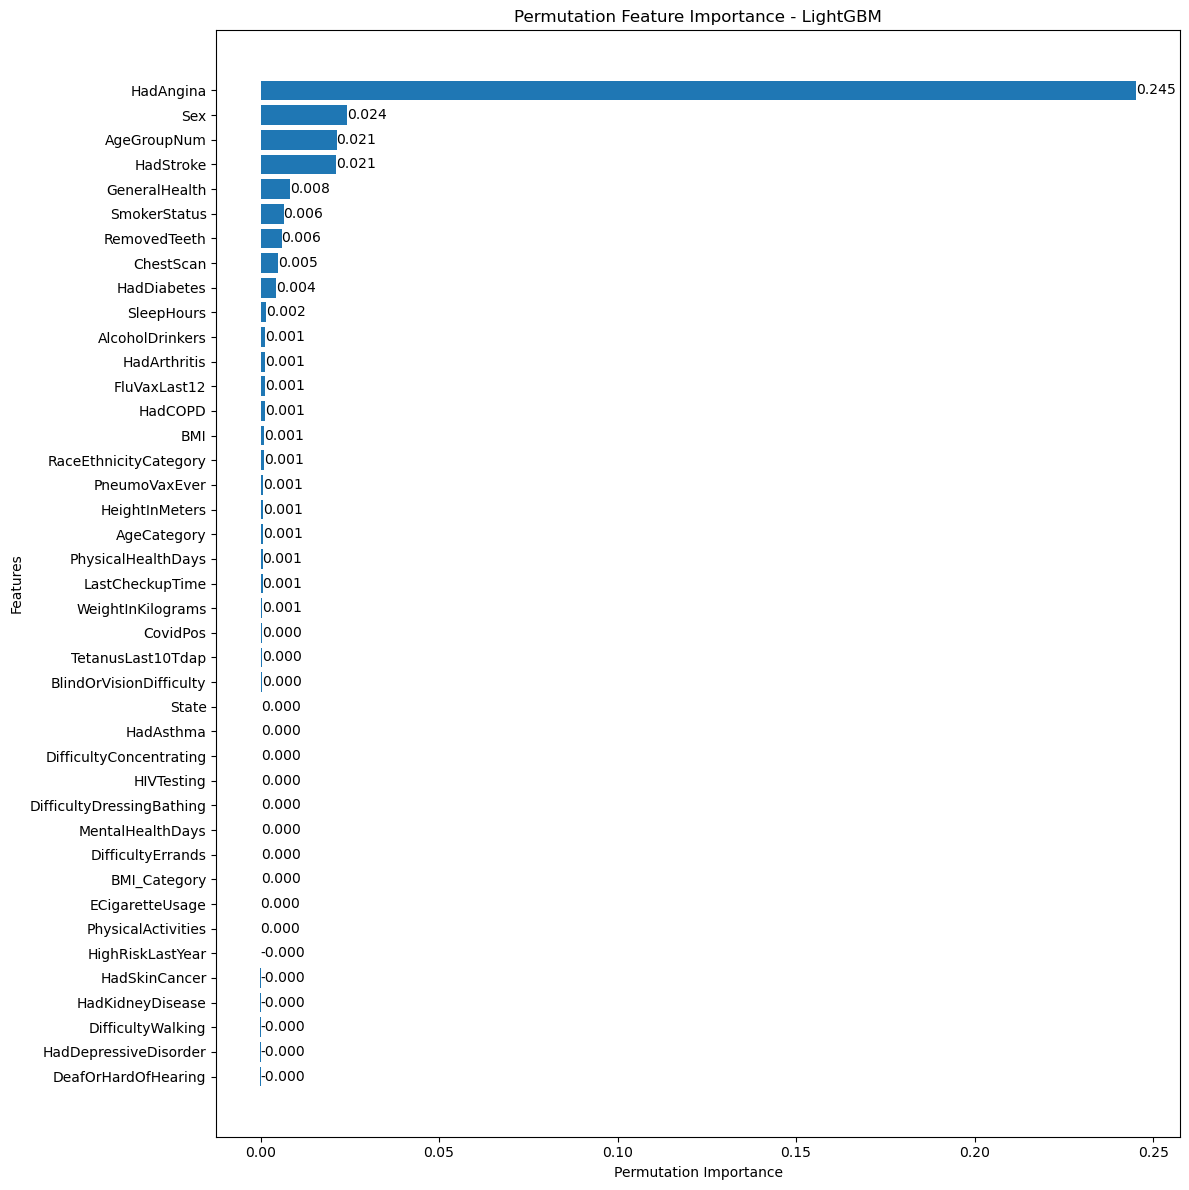

In [9]:
# Define optuna objective
def lgbm_objective(trial):
    # Define hyperparameter search space
    params = {
        # Trees that will be built
        'n_estimators': trial.suggest_int('n_estimators', 100, 20000),
        # It likes a step to move each time to find best model parameters (not hyperparameters)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        # The maximum depth that tree will grow
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        # The maximum number of leaves for one tree
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        # The minimum number of number on one leaf.
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        # Determine the portion of train set be randomly selected and passed to each tree
        # to avoid overfitting.
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # Determine the portion of features be passed to each tree to avoid overfitting.
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # L1 Regularization. Avoid overfitting.
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        # L2 Regularization. Avoid overfitting.
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        # Scale_pos_weight for imbalanced target
        'scale_pos_weight': trial.suggest_float('pos_weight', 0.1, 10)
    }

    # Define model to be optimized
    lgbm_model = LGBMClassifier(
        **params,
        objective='binary',
        random_state=seed,
        verbose=-1)
    lgbm_model.fit(
        X_train_dummies, y_train,
        eval_set=[(X_validation_dummies, y_validation)],
        # Use Area Under Precision-Recall Curve to evaluate
        eval_metric='average_precision',
        # Configure a early stopping to save time and avoid overfitting
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    # Define optuna evaluation matric, proba is predicted probabilities
    # for positive class. The evaluation matric is still area under PR-Curve
    # The 'average_precision_score' in scikit-learn is equivalent to
    # 'average_precision' in LGBM.
    proba = lgbm_model.predict_proba(X_validation_dummies)[:, 1]
    return average_precision_score(y_validation, proba)


# Wrap logistic model with data preprocess for permutation importance
class wrap_lgbm(ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = model.classes_

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict_proba(X_test_permutation)

    def predict(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict(X_test_permutation)


# Define optuna study object, and direction is to maximize area under PR-Curve
# Evaluated on validation set.
output_seperate('Searching Hyperparameters')
lgbm_study = optuna.create_study(direction='maximize', sampler=sampler)
lgbm_study.optimize(lgbm_objective, n_trials=n_trials)


# Use best hyperparameters to train model
output_seperate('Train model with best hyperparameters...')
lgbm_model = LGBMClassifier(
    **lgbm_study.best_params,
    objective='binary',
    random_state=seed
)
lgbm_model.fit(
    X_train_dummies, y_train,
    eval_set=[(X_validation_dummies, y_validation)],
    eval_metric='average_precision',
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Using model to predict whether had having heart attack on test set.
lgbm_pred = lgbm_model.predict(X_test_dummies)
# Using model to generate probabilities for positive case on test set.
lgbm_proba = lgbm_model.predict_proba(X_test_dummies)[:, 1]
lgbm_score = average_precision_score(y_test, lgbm_proba)
lgbm_results = output_results(
    lgbm_score, lgbm_study, y_test, lgbm_pred, lgbm_proba)
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test, lgbm_proba, 'LightGBM')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test, lgbm_proba, 'LightGBM')
wrapped_lgbm = wrap_lgbm(lgbm_model)
lgbm_important_df = calculate_permutation_importance(wrapped_lgbm, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance, (12, 12),
                 lgbm_important_df, 'LightGBM')

## 5.4. MLP


Searching Hyperparameters


[I 2025-04-13 14:29:30,191] A new study created in memory with name: no-name-d60be02f-87a7-4def-87d0-716f721bef19


Epoch 1, Loss: 1.0026, Score: 0.1846, 4.41
Epoch 2, Loss: 0.9212, Score: 0.2299, 3.49
Epoch 3, Loss: 0.8708, Score: 0.2597, 3.72
Epoch 4, Loss: 0.8278, Score: 0.2854, 3.57
Epoch 5, Loss: 0.7967, Score: 0.3081, 3.55
Epoch 6, Loss: 0.7705, Score: 0.3274, 3.75
Epoch 7, Loss: 0.7452, Score: 0.3432, 3.50
Epoch 8, Loss: 0.7272, Score: 0.3566, 3.48
Epoch 9, Loss: 0.7109, Score: 0.3678, 3.67
Epoch 10, Loss: 0.6956, Score: 0.3762, 3.47
Epoch 11, Loss: 0.6818, Score: 0.3834, 3.47
Epoch 12, Loss: 0.6704, Score: 0.3887, 3.56
Epoch 13, Loss: 0.6614, Score: 0.3931, 3.45
Epoch 14, Loss: 0.6528, Score: 0.3968, 3.40
Epoch 15, Loss: 0.6467, Score: 0.3997, 3.63
Epoch 16, Loss: 0.6384, Score: 0.4019, 3.47
Epoch 17, Loss: 0.6338, Score: 0.4036, 3.49
Epoch 18, Loss: 0.6286, Score: 0.4049, 3.63
Epoch 19, Loss: 0.6257, Score: 0.4063, 3.56
Epoch 20, Loss: 0.6208, Score: 0.4073, 3.43
Epoch 21, Loss: 0.6185, Score: 0.4082, 3.62
Epoch 22, Loss: 0.6151, Score: 0.4092, 3.57
Epoch 23, Loss: 0.6093, Score: 0.4100, 3.

[I 2025-04-13 14:39:46,576] Trial 0 finished with value: 0.4228919853090842 and parameters: {'batch_size': 6459, 'num_layers': 3, 'hidden_dim': 433, 'dropout': 0.45223365158733303, 'pos_weight': 8.500596791927224, 'lr': 1.1914169202120593e-05}. Best is trial 0 with value: 0.4228919853090842.


Epoch 1, Loss: 0.6697, Score: 0.4131, 3.28
Epoch 2, Loss: 0.5878, Score: 0.4242, 3.48
Epoch 3, Loss: 0.5790, Score: 0.4211, 3.33
Epoch 4, Loss: 0.5697, Score: 0.4196, 3.43
Epoch 5, Loss: 0.5603, Score: 0.4199, 3.48
Epoch 6, Loss: 0.5473, Score: 0.4105, 3.34
Epoch 7, Loss: 0.5321, Score: 0.4135, 3.42
Epoch 8, Loss: 0.5182, Score: 0.4059, 3.28
Epoch 9, Loss: 0.4979, Score: 0.4055, 3.43
Epoch 10, Loss: 0.4799, Score: 0.4040, 3.40
Epoch 11, Loss: 0.4584, Score: 0.3982, 3.39
Epoch 12, Loss: 0.4366, Score: 0.3864, 3.35
Early stopping triggered at epoch 12 with score 0.4242087006432632


[I 2025-04-13 14:40:27,334] Trial 1 finished with value: 0.4242087006432632 and parameters: {'batch_size': 6842, 'num_layers': 4, 'hidden_dim': 396, 'dropout': 0.09927954860593174, 'pos_weight': 9.351774364374691, 'lr': 0.0031095882802486333}. Best is trial 1 with value: 0.4242087006432632.


Epoch 1, Loss: 0.6396, Score: 0.3699, 3.01
Epoch 2, Loss: 0.4865, Score: 0.4110, 2.91
Epoch 3, Loss: 0.4554, Score: 0.4193, 2.96
Epoch 4, Loss: 0.4467, Score: 0.4211, 2.80
Epoch 5, Loss: 0.4402, Score: 0.4198, 2.94
Epoch 6, Loss: 0.4362, Score: 0.4218, 3.00
Epoch 7, Loss: 0.4323, Score: 0.4224, 2.99
Epoch 8, Loss: 0.4300, Score: 0.4218, 2.84
Epoch 9, Loss: 0.4276, Score: 0.4209, 2.97
Epoch 10, Loss: 0.4234, Score: 0.4226, 3.02
Epoch 11, Loss: 0.4210, Score: 0.4225, 2.98
Epoch 12, Loss: 0.4180, Score: 0.4217, 2.80
Epoch 13, Loss: 0.4153, Score: 0.4184, 2.97
Epoch 14, Loss: 0.4100, Score: 0.4202, 2.97
Epoch 15, Loss: 0.4096, Score: 0.4176, 2.85
Epoch 16, Loss: 0.4062, Score: 0.4172, 2.95
Epoch 17, Loss: 0.4031, Score: 0.4185, 3.00
Epoch 18, Loss: 0.3991, Score: 0.4147, 2.92
Epoch 19, Loss: 0.3941, Score: 0.4142, 2.93
Epoch 20, Loss: 0.3916, Score: 0.4133, 2.95
Early stopping triggered at epoch 20 with score 0.4226176687406914


[I 2025-04-13 14:41:26,211] Trial 2 finished with value: 0.4226176687406914 and parameters: {'batch_size': 12163, 'num_layers': 2, 'hidden_dim': 232, 'dropout': 0.2855854789727364, 'pos_weight': 5.496416476147694, 'lr': 0.00041932433115958684}. Best is trial 1 with value: 0.4242087006432632.


Epoch 1, Loss: 0.7008, Score: 0.3804, 2.79
Epoch 2, Loss: 0.5483, Score: 0.4216, 2.87
Epoch 3, Loss: 0.5368, Score: 0.4219, 3.05
Epoch 4, Loss: 0.5335, Score: 0.4237, 2.91
Epoch 5, Loss: 0.5278, Score: 0.4213, 2.90
Epoch 6, Loss: 0.5233, Score: 0.4203, 2.88
Epoch 7, Loss: 0.5158, Score: 0.4207, 2.85
Epoch 8, Loss: 0.5103, Score: 0.4182, 2.92
Epoch 9, Loss: 0.5029, Score: 0.4180, 2.91
Epoch 10, Loss: 0.4911, Score: 0.4163, 2.76
Epoch 11, Loss: 0.4834, Score: 0.4111, 3.00
Epoch 12, Loss: 0.4699, Score: 0.4104, 2.87
Epoch 13, Loss: 0.4602, Score: 0.4046, 2.84
Epoch 14, Loss: 0.4509, Score: 0.4084, 2.86
Early stopping triggered at epoch 14 with score 0.4236665743893332


[I 2025-04-13 14:42:06,723] Trial 3 finished with value: 0.4236665743893332 and parameters: {'batch_size': 11578, 'num_layers': 2, 'hidden_dim': 377, 'dropout': 0.31702962741461627, 'pos_weight': 7.814830258958545, 'lr': 0.017430876867081068}. Best is trial 1 with value: 0.4242087006432632.


Epoch 1, Loss: 0.4693, Score: 0.1795, 2.93
Epoch 2, Loss: 0.3253, Score: 0.3224, 2.77
Epoch 3, Loss: 0.3021, Score: 0.3690, 2.91
Epoch 4, Loss: 0.2896, Score: 0.4041, 2.85
Epoch 5, Loss: 0.2894, Score: 0.3901, 2.98
Epoch 6, Loss: 0.2853, Score: 0.4130, 2.91
Epoch 7, Loss: 0.2855, Score: 0.4185, 2.90
Epoch 8, Loss: 0.2846, Score: 0.4132, 2.93
Epoch 9, Loss: 0.2811, Score: 0.4175, 2.92
Epoch 10, Loss: 0.2848, Score: 0.4157, 2.95
Epoch 11, Loss: 0.2876, Score: 0.4231, 2.94
Epoch 12, Loss: 0.2842, Score: 0.4210, 2.91
Epoch 13, Loss: 0.2857, Score: 0.4185, 2.93
Epoch 14, Loss: 0.2818, Score: 0.4247, 2.93
Epoch 15, Loss: 0.2824, Score: 0.4219, 2.90
Epoch 16, Loss: 0.2816, Score: 0.4139, 2.89
Epoch 17, Loss: 0.2795, Score: 0.4061, 2.91
Epoch 18, Loss: 0.2768, Score: 0.4253, 2.90
Epoch 19, Loss: 0.2750, Score: 0.4157, 2.97
Epoch 20, Loss: 0.2721, Score: 0.4131, 2.97
Epoch 21, Loss: 0.2671, Score: 0.4018, 2.91
Epoch 22, Loss: 0.2721, Score: 0.3938, 2.89
Epoch 23, Loss: 0.2701, Score: 0.4003, 2.

[I 2025-04-13 14:43:28,323] Trial 4 finished with value: 0.42532787433150865 and parameters: {'batch_size': 11299, 'num_layers': 2, 'hidden_dim': 254, 'dropout': 0.29363718048350024, 'pos_weight': 2.5907709835248958, 'lr': 0.0807604270757282}. Best is trial 4 with value: 0.42532787433150865.


Epoch 1, Loss: 0.7271, Score: 0.1359, 3.09
Epoch 2, Loss: 0.4004, Score: 0.2222, 3.02
Epoch 3, Loss: 0.3728, Score: 0.3601, 3.02
Epoch 4, Loss: 0.3504, Score: 0.3780, 3.09
Epoch 5, Loss: 0.3438, Score: 0.4024, 3.07
Epoch 6, Loss: 0.3403, Score: 0.3818, 3.08
Epoch 7, Loss: 0.3389, Score: 0.3913, 3.07
Epoch 8, Loss: 0.3371, Score: 0.4054, 3.24
Epoch 9, Loss: 0.3343, Score: 0.4173, 3.29
Epoch 10, Loss: 0.3348, Score: 0.4174, 3.18
Epoch 11, Loss: 0.3330, Score: 0.4191, 3.23
Epoch 12, Loss: 0.3337, Score: 0.4231, 3.27
Epoch 13, Loss: 0.3301, Score: 0.4210, 3.12
Epoch 14, Loss: 0.3287, Score: 0.4170, 3.21
Epoch 15, Loss: 0.3258, Score: 0.4166, 3.09
Epoch 16, Loss: 0.3249, Score: 0.4194, 3.17
Epoch 17, Loss: 0.3242, Score: 0.3971, 3.21
Epoch 18, Loss: 0.3206, Score: 0.4132, 3.23
Epoch 19, Loss: 0.3169, Score: 0.4203, 3.22
Epoch 20, Loss: 0.3146, Score: 0.4120, 3.12
Epoch 21, Loss: 0.3115, Score: 0.4018, 3.21
Epoch 22, Loss: 0.3083, Score: 0.4152, 3.23
Early stopping triggered at epoch 22 with

[I 2025-04-13 14:44:37,914] Trial 5 finished with value: 0.42313578727108764 and parameters: {'batch_size': 10944, 'num_layers': 3, 'hidden_dim': 461, 'dropout': 0.4489003994841459, 'pos_weight': 3.3945889422530495, 'lr': 0.07347047723255008}. Best is trial 4 with value: 0.42532787433150865.


Epoch 1, Loss: 0.6196, Score: 0.4134, 2.66
Epoch 2, Loss: 0.5232, Score: 0.4209, 2.62
Epoch 3, Loss: 0.5070, Score: 0.4231, 2.74
Epoch 4, Loss: 0.4998, Score: 0.4219, 2.71
Epoch 5, Loss: 0.4905, Score: 0.4200, 2.61
Epoch 6, Loss: 0.4815, Score: 0.4189, 2.64
Epoch 7, Loss: 0.4703, Score: 0.4140, 2.63
Epoch 8, Loss: 0.4587, Score: 0.4083, 2.63
Epoch 9, Loss: 0.4459, Score: 0.4082, 2.61
Epoch 10, Loss: 0.4321, Score: 0.3997, 2.60
Epoch 11, Loss: 0.4191, Score: 0.3906, 2.58
Epoch 12, Loss: 0.4050, Score: 0.3943, 2.59
Epoch 13, Loss: 0.3905, Score: 0.3796, 2.62
Early stopping triggered at epoch 13 with score 0.4230785696020477


[I 2025-04-13 14:45:12,210] Trial 6 finished with value: 0.4230785696020477 and parameters: {'batch_size': 14891, 'num_layers': 1, 'hidden_dim': 269, 'dropout': 0.2993407205198823, 'pos_weight': 7.302988104897524, 'lr': 0.004202104046581834}. Best is trial 4 with value: 0.42532787433150865.


Epoch 1, Loss: 0.7525, Score: 0.4098, 3.21
Epoch 2, Loss: 0.6192, Score: 0.4195, 3.19
Epoch 3, Loss: 0.6124, Score: 0.4231, 3.20
Epoch 4, Loss: 0.6066, Score: 0.4215, 3.23
Epoch 5, Loss: 0.6000, Score: 0.4236, 3.23
Epoch 6, Loss: 0.5951, Score: 0.4213, 3.25
Epoch 7, Loss: 0.5877, Score: 0.4191, 3.20
Epoch 8, Loss: 0.5778, Score: 0.4125, 3.24
Epoch 9, Loss: 0.5677, Score: 0.4164, 3.36
Epoch 10, Loss: 0.5549, Score: 0.4155, 3.24
Epoch 11, Loss: 0.5358, Score: 0.4083, 3.24
Epoch 12, Loss: 0.5242, Score: 0.4046, 3.23
Epoch 13, Loss: 0.5137, Score: 0.4079, 3.24
Epoch 14, Loss: 0.4983, Score: 0.4052, 3.20
Epoch 15, Loss: 0.4851, Score: 0.3925, 3.21
Early stopping triggered at epoch 15 with score 0.4235563138435234


[I 2025-04-13 14:46:00,793] Trial 7 finished with value: 0.4235563138435234 and parameters: {'batch_size': 6443, 'num_layers': 3, 'hidden_dim': 425, 'dropout': 0.34427992139654984, 'pos_weight': 9.925362064256964, 'lr': 0.01891705061209834}. Best is trial 4 with value: 0.42532787433150865.


Epoch 1, Loss: 0.8943, Score: 0.3329, 2.96
Epoch 2, Loss: 0.7133, Score: 0.3769, 2.99
Epoch 3, Loss: 0.6061, Score: 0.3896, 2.85
Epoch 4, Loss: 0.5434, Score: 0.3947, 2.97
Epoch 5, Loss: 0.5070, Score: 0.3941, 2.90
Epoch 6, Loss: 0.4840, Score: 0.3988, 2.96
Epoch 7, Loss: 0.4689, Score: 0.3970, 2.89
Epoch 8, Loss: 0.4585, Score: 0.3959, 2.96
Epoch 9, Loss: 0.4513, Score: 0.3932, 2.86
Epoch 10, Loss: 0.4452, Score: 0.3996, 2.97
Epoch 11, Loss: 0.4409, Score: 0.3984, 2.85
Epoch 12, Loss: 0.4374, Score: 0.4009, 3.05
Epoch 13, Loss: 0.4340, Score: 0.3997, 2.95
Epoch 14, Loss: 0.4321, Score: 0.3963, 2.87
Epoch 15, Loss: 0.4304, Score: 0.4013, 2.95
Epoch 16, Loss: 0.4274, Score: 0.4025, 2.83
Epoch 17, Loss: 0.4256, Score: 0.4078, 2.99
Epoch 18, Loss: 0.4242, Score: 0.4068, 2.88
Epoch 19, Loss: 0.4234, Score: 0.4063, 2.98
Epoch 20, Loss: 0.4220, Score: 0.4073, 2.86
Epoch 21, Loss: 0.4200, Score: 0.4025, 3.03
Epoch 22, Loss: 0.4191, Score: 0.4086, 2.87
Epoch 23, Loss: 0.4173, Score: 0.4108, 2.

[I 2025-04-13 14:47:37,417] Trial 8 finished with value: 0.4108049179855358 and parameters: {'batch_size': 7746, 'num_layers': 2, 'hidden_dim': 480, 'dropout': 0.4252572611644295, 'pos_weight': 5.226009341768489, 'lr': 5.877505000067754e-05}. Best is trial 4 with value: 0.42532787433150865.


Epoch 1, Loss: 0.5344, Score: 0.4175, 3.34
Epoch 2, Loss: 0.4697, Score: 0.4215, 3.26
Epoch 3, Loss: 0.4649, Score: 0.4208, 3.19
Epoch 4, Loss: 0.4647, Score: 0.4228, 3.19
Epoch 5, Loss: 0.4591, Score: 0.4263, 3.29
Epoch 6, Loss: 0.4574, Score: 0.4217, 3.24
Epoch 7, Loss: 0.4543, Score: 0.4236, 3.15
Epoch 8, Loss: 0.4497, Score: 0.4238, 3.33
Epoch 9, Loss: 0.4459, Score: 0.4199, 3.28
Epoch 10, Loss: 0.4423, Score: 0.4194, 3.27
Epoch 11, Loss: 0.4366, Score: 0.4161, 3.19
Epoch 12, Loss: 0.4309, Score: 0.4187, 3.37
Epoch 13, Loss: 0.4247, Score: 0.4172, 3.13
Epoch 14, Loss: 0.4179, Score: 0.4113, 3.22
Epoch 15, Loss: 0.4139, Score: 0.4123, 3.12
Early stopping triggered at epoch 15 with score 0.42631624205351726


[I 2025-04-13 14:48:26,094] Trial 9 finished with value: 0.42631624205351726 and parameters: {'batch_size': 4184, 'num_layers': 4, 'hidden_dim': 222, 'dropout': 0.31285595876558936, 'pos_weight': 5.955253392726492, 'lr': 0.0493744102515502}. Best is trial 9 with value: 0.42631624205351726.


Epoch 1, Loss: 0.2587, Score: 0.2182, 3.25
Epoch 2, Loss: 0.0530, Score: 0.3940, 3.12
Epoch 3, Loss: 0.0366, Score: 0.4118, 3.06
Epoch 4, Loss: 0.0323, Score: 0.4125, 3.06
Epoch 5, Loss: 0.0303, Score: 0.4195, 3.00
Epoch 6, Loss: 0.0293, Score: 0.4119, 3.13
Epoch 7, Loss: 0.0287, Score: 0.4206, 3.05
Epoch 8, Loss: 0.0284, Score: 0.4193, 3.04
Epoch 9, Loss: 0.0281, Score: 0.4216, 3.05
Epoch 10, Loss: 0.0279, Score: 0.4229, 3.07
Epoch 11, Loss: 0.0277, Score: 0.4231, 3.00
Epoch 12, Loss: 0.0276, Score: 0.4216, 3.04
Epoch 13, Loss: 0.0274, Score: 0.4111, 3.17
Epoch 14, Loss: 0.0274, Score: 0.4180, 3.20
Epoch 15, Loss: 0.0273, Score: 0.4157, 3.10
Epoch 16, Loss: 0.0272, Score: 0.4148, 3.25
Epoch 17, Loss: 0.0269, Score: 0.4121, 3.12
Epoch 18, Loss: 0.0268, Score: 0.4098, 3.11
Epoch 19, Loss: 0.0266, Score: 0.4076, 3.20
Epoch 20, Loss: 0.0265, Score: 0.4042, 3.36
Epoch 21, Loss: 0.0264, Score: 0.3968, 3.26
Early stopping triggered at epoch 21 with score 0.4231279220188154


[I 2025-04-13 14:49:31,868] Trial 10 finished with value: 0.4231279220188154 and parameters: {'batch_size': 2638, 'num_layers': 4, 'hidden_dim': 157, 'dropout': 0.15620088689133516, 'pos_weight': 0.10164769913792249, 'lr': 0.0004936794046124961}. Best is trial 9 with value: 0.42631624205351726.


Epoch 1, Loss: 0.3299, Score: 0.4188, 2.61
Epoch 2, Loss: 0.2899, Score: 0.4156, 2.32
Epoch 3, Loss: 0.2885, Score: 0.4191, 2.42
Epoch 4, Loss: 0.2861, Score: 0.4216, 2.43
Epoch 5, Loss: 0.2846, Score: 0.4206, 2.44
Epoch 6, Loss: 0.2838, Score: 0.4208, 2.48
Epoch 7, Loss: 0.2837, Score: 0.4241, 2.36
Epoch 8, Loss: 0.2807, Score: 0.4197, 2.47
Epoch 9, Loss: 0.2788, Score: 0.4196, 2.46
Epoch 10, Loss: 0.2765, Score: 0.4193, 2.40
Epoch 11, Loss: 0.2722, Score: 0.4141, 2.30
Epoch 12, Loss: 0.2712, Score: 0.4151, 2.46
Epoch 13, Loss: 0.2675, Score: 0.4112, 2.32
Epoch 14, Loss: 0.2632, Score: 0.4098, 2.47
Epoch 15, Loss: 0.2611, Score: 0.4066, 2.46
Epoch 16, Loss: 0.2579, Score: 0.4049, 2.35
Epoch 17, Loss: 0.2542, Score: 0.4005, 2.46
Early stopping triggered at epoch 17 with score 0.4240788615104465


[I 2025-04-13 14:50:13,217] Trial 11 finished with value: 0.4240788615104465 and parameters: {'batch_size': 2278, 'num_layers': 1, 'hidden_dim': 188, 'dropout': 0.2213106964509288, 'pos_weight': 2.6379779481834755, 'lr': 0.08331580829678377}. Best is trial 9 with value: 0.42631624205351726.


Epoch 1, Loss: 0.4818, Score: 0.2591, 3.31
Epoch 2, Loss: 0.3296, Score: 0.4164, 3.29
Epoch 3, Loss: 0.3147, Score: 0.4216, 3.21
Epoch 4, Loss: 0.3120, Score: 0.4229, 3.31
Epoch 5, Loss: 0.3107, Score: 0.4251, 3.39
Epoch 6, Loss: 0.3085, Score: 0.4263, 3.24
Epoch 7, Loss: 0.3070, Score: 0.4235, 3.26
Epoch 8, Loss: 0.3045, Score: 0.4209, 3.32
Epoch 9, Loss: 0.3018, Score: 0.4184, 3.32
Epoch 10, Loss: 0.2985, Score: 0.4191, 3.36
Epoch 11, Loss: 0.2959, Score: 0.4170, 3.32
Epoch 12, Loss: 0.2918, Score: 0.4078, 3.22
Epoch 13, Loss: 0.2878, Score: 0.4134, 3.24
Epoch 14, Loss: 0.2835, Score: 0.4075, 3.23
Epoch 15, Loss: 0.2765, Score: 0.4063, 3.22
Epoch 16, Loss: 0.2729, Score: 0.4004, 3.14
Early stopping triggered at epoch 16 with score 0.4262897973528087


[I 2025-04-13 14:51:05,718] Trial 12 finished with value: 0.4262897973528087 and parameters: {'batch_size': 15231, 'num_layers': 4, 'hidden_dim': 311, 'dropout': 0.212053960064492, 'pos_weight': 3.0902392039595172, 'lr': 0.013695643795308026}. Best is trial 9 with value: 0.42631624205351726.


Epoch 1, Loss: 0.4768, Score: 0.4016, 3.21
Epoch 2, Loss: 0.3684, Score: 0.4195, 3.22
Epoch 3, Loss: 0.3613, Score: 0.4210, 3.16
Epoch 4, Loss: 0.3577, Score: 0.4218, 3.20
Epoch 5, Loss: 0.3554, Score: 0.4219, 3.22
Epoch 6, Loss: 0.3520, Score: 0.4270, 3.24
Epoch 7, Loss: 0.3500, Score: 0.4259, 3.26
Epoch 8, Loss: 0.3447, Score: 0.4171, 3.26
Epoch 9, Loss: 0.3395, Score: 0.4146, 3.22
Epoch 10, Loss: 0.3351, Score: 0.4057, 3.30
Epoch 11, Loss: 0.3304, Score: 0.4111, 3.19
Epoch 12, Loss: 0.3247, Score: 0.4081, 3.17
Epoch 13, Loss: 0.3162, Score: 0.3990, 3.16
Epoch 14, Loss: 0.3038, Score: 0.4030, 3.23
Epoch 15, Loss: 0.2975, Score: 0.3842, 3.22
Epoch 16, Loss: 0.2909, Score: 0.3907, 3.18
Early stopping triggered at epoch 16 with score 0.42695526179367244


[I 2025-04-13 14:51:57,274] Trial 13 finished with value: 0.42695526179367244 and parameters: {'batch_size': 15260, 'num_layers': 4, 'hidden_dim': 329, 'dropout': 0.019283857499043655, 'pos_weight': 3.9574779375231097, 'lr': 0.012526506291634527}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.5241, Score: 0.4204, 3.36
Epoch 2, Loss: 0.4787, Score: 0.4207, 3.40
Epoch 3, Loss: 0.4731, Score: 0.4248, 3.29
Epoch 4, Loss: 0.4659, Score: 0.4224, 3.33
Epoch 5, Loss: 0.4597, Score: 0.4168, 3.36
Epoch 6, Loss: 0.4498, Score: 0.4196, 3.34
Epoch 7, Loss: 0.4397, Score: 0.4082, 3.48
Epoch 8, Loss: 0.4277, Score: 0.4060, 3.36
Epoch 9, Loss: 0.4138, Score: 0.3995, 3.33
Epoch 10, Loss: 0.4006, Score: 0.4064, 3.37
Epoch 11, Loss: 0.3865, Score: 0.4005, 3.39
Epoch 12, Loss: 0.3697, Score: 0.3944, 3.42
Epoch 13, Loss: 0.3505, Score: 0.3955, 3.33
Early stopping triggered at epoch 13 with score 0.42480058573526713


[I 2025-04-13 14:52:41,137] Trial 14 finished with value: 0.42480058573526713 and parameters: {'batch_size': 4046, 'num_layers': 4, 'hidden_dim': 338, 'dropout': 0.04667598282812304, 'pos_weight': 6.391960111720418, 'lr': 0.004079167653955298}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.5396, Score: 0.3908, 3.40
Epoch 2, Loss: 0.3802, Score: 0.4162, 3.37
Epoch 3, Loss: 0.3682, Score: 0.4211, 3.35
Epoch 4, Loss: 0.3659, Score: 0.4239, 3.43
Epoch 5, Loss: 0.3632, Score: 0.4244, 3.37
Epoch 6, Loss: 0.3617, Score: 0.4230, 3.39
Epoch 7, Loss: 0.3591, Score: 0.4246, 3.41
Epoch 8, Loss: 0.3574, Score: 0.4267, 3.43
Epoch 9, Loss: 0.3548, Score: 0.4213, 3.32
Epoch 10, Loss: 0.3527, Score: 0.4251, 3.41
Epoch 11, Loss: 0.3475, Score: 0.4185, 3.38
Epoch 12, Loss: 0.3423, Score: 0.4155, 3.35
Epoch 13, Loss: 0.3404, Score: 0.4177, 3.38
Epoch 14, Loss: 0.3358, Score: 0.4163, 3.37
Epoch 15, Loss: 0.3308, Score: 0.4119, 3.48
Epoch 16, Loss: 0.3254, Score: 0.4119, 3.49
Epoch 17, Loss: 0.3203, Score: 0.4065, 3.39
Epoch 18, Loss: 0.3151, Score: 0.4046, 3.55
Early stopping triggered at epoch 18 with score 0.4267457605811713


[I 2025-04-13 14:53:42,532] Trial 15 finished with value: 0.4267457605811713 and parameters: {'batch_size': 16279, 'num_layers': 4, 'hidden_dim': 305, 'dropout': 0.3906917320027312, 'pos_weight': 3.9759292970603513, 'lr': 0.02273154313262503}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.4613, Score: 0.4129, 3.82
Epoch 2, Loss: 0.3712, Score: 0.4217, 3.03
Epoch 3, Loss: 0.3601, Score: 0.4239, 3.02
Epoch 4, Loss: 0.3501, Score: 0.4155, 3.08
Epoch 5, Loss: 0.3386, Score: 0.4087, 3.02
Epoch 6, Loss: 0.3255, Score: 0.4001, 2.96
Epoch 7, Loss: 0.3087, Score: 0.3951, 2.98
Epoch 8, Loss: 0.2915, Score: 0.3757, 2.98
Epoch 9, Loss: 0.2762, Score: 0.3732, 2.94
Epoch 10, Loss: 0.2562, Score: 0.3602, 2.98
Epoch 11, Loss: 0.2324, Score: 0.3628, 2.93
Epoch 12, Loss: 0.2140, Score: 0.3036, 3.06
Epoch 13, Loss: 0.1973, Score: 0.3410, 2.97
Early stopping triggered at epoch 13 with score 0.423948675084738


[I 2025-04-13 14:54:22,414] Trial 16 finished with value: 0.423948675084738 and parameters: {'batch_size': 16164, 'num_layers': 3, 'hidden_dim': 313, 'dropout': 0.02568638462285483, 'pos_weight': 4.137921414517787, 'lr': 0.001659858797577439}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.3126, Score: 0.1008, 3.79
Epoch 2, Loss: 0.2044, Score: 0.3440, 3.31
Epoch 3, Loss: 0.1925, Score: 0.4204, 3.34
Epoch 4, Loss: 0.1891, Score: 0.4173, 3.31
Epoch 5, Loss: 0.1864, Score: 0.4193, 3.32
Epoch 6, Loss: 0.1845, Score: 0.4150, 3.36
Epoch 7, Loss: 0.1829, Score: 0.4246, 3.33
Epoch 8, Loss: 0.1814, Score: 0.4236, 3.37
Epoch 9, Loss: 0.1796, Score: 0.4227, 3.41
Epoch 10, Loss: 0.1779, Score: 0.4178, 3.37
Epoch 11, Loss: 0.1765, Score: 0.4124, 3.33
Epoch 12, Loss: 0.1742, Score: 0.4140, 3.27
Epoch 13, Loss: 0.1714, Score: 0.4101, 3.38
Epoch 14, Loss: 0.1688, Score: 0.4103, 3.37
Epoch 15, Loss: 0.1660, Score: 0.4057, 3.44
Epoch 16, Loss: 0.1638, Score: 0.4007, 3.19
Epoch 17, Loss: 0.1611, Score: 0.4009, 3.43
Early stopping triggered at epoch 17 with score 0.4245601838154924


[I 2025-04-13 14:55:19,830] Trial 17 finished with value: 0.4245601838154924 and parameters: {'batch_size': 13514, 'num_layers': 4, 'hidden_dim': 355, 'dropout': 0.39389067759918533, 'pos_weight': 1.3581259587614825, 'lr': 0.010199141206860789}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.7042, Score: 0.3665, 3.56
Epoch 2, Loss: 0.4654, Score: 0.4132, 3.04
Epoch 3, Loss: 0.4068, Score: 0.4193, 3.09
Epoch 4, Loss: 0.3899, Score: 0.4225, 3.00
Epoch 5, Loss: 0.3815, Score: 0.4225, 3.04
Epoch 6, Loss: 0.3775, Score: 0.4239, 2.96
Epoch 7, Loss: 0.3742, Score: 0.4246, 3.00
Epoch 8, Loss: 0.3715, Score: 0.4245, 3.04
Epoch 9, Loss: 0.3692, Score: 0.4256, 3.00
Epoch 10, Loss: 0.3661, Score: 0.4251, 2.98
Epoch 11, Loss: 0.3637, Score: 0.4256, 2.99
Epoch 12, Loss: 0.3617, Score: 0.4246, 3.03
Epoch 13, Loss: 0.3597, Score: 0.4244, 3.03
Epoch 14, Loss: 0.3584, Score: 0.4234, 3.01
Epoch 15, Loss: 0.3571, Score: 0.4246, 2.97
Epoch 16, Loss: 0.3552, Score: 0.4231, 3.12
Epoch 17, Loss: 0.3529, Score: 0.4237, 3.03
Epoch 18, Loss: 0.3512, Score: 0.4230, 2.99
Epoch 19, Loss: 0.3486, Score: 0.4231, 3.11
Early stopping triggered at epoch 19 with score 0.4256124697558231


[I 2025-04-13 14:56:17,943] Trial 18 finished with value: 0.4256124697558231 and parameters: {'batch_size': 13688, 'num_layers': 3, 'hidden_dim': 279, 'dropout': 0.4896093481513464, 'pos_weight': 4.02256670911531, 'lr': 0.0004870193683314587}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.2476, Score: 0.3864, 3.95
Epoch 2, Loss: 0.1971, Score: 0.4223, 3.22
Epoch 3, Loss: 0.1937, Score: 0.4241, 3.36
Epoch 4, Loss: 0.1920, Score: 0.4221, 3.35
Epoch 5, Loss: 0.1910, Score: 0.4221, 3.35
Epoch 6, Loss: 0.1897, Score: 0.4183, 3.35
Epoch 7, Loss: 0.1888, Score: 0.4194, 3.41
Epoch 8, Loss: 0.1873, Score: 0.4157, 3.28
Epoch 9, Loss: 0.1851, Score: 0.4153, 3.36
Epoch 10, Loss: 0.1830, Score: 0.4115, 3.40
Epoch 11, Loss: 0.1805, Score: 0.4071, 3.38
Epoch 12, Loss: 0.1773, Score: 0.4017, 3.40
Epoch 13, Loss: 0.1748, Score: 0.3972, 3.26
Early stopping triggered at epoch 13 with score 0.42413791331310063


[I 2025-04-13 14:57:02,128] Trial 19 finished with value: 0.42413791331310063 and parameters: {'batch_size': 9475, 'num_layers': 4, 'hidden_dim': 298, 'dropout': 0.14868400296377257, 'pos_weight': 1.4587679278741614, 'lr': 0.025249921338662724}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.4766, Score: 0.4150, 3.69
Epoch 2, Loss: 0.4112, Score: 0.4208, 2.93
Epoch 3, Loss: 0.4036, Score: 0.4260, 2.98
Epoch 4, Loss: 0.4015, Score: 0.4226, 2.98
Epoch 5, Loss: 0.3971, Score: 0.4212, 2.94
Epoch 6, Loss: 0.3946, Score: 0.4245, 3.00
Epoch 7, Loss: 0.3911, Score: 0.4228, 3.00
Epoch 8, Loss: 0.3882, Score: 0.4208, 3.00
Epoch 9, Loss: 0.3841, Score: 0.4225, 3.01
Epoch 10, Loss: 0.3779, Score: 0.4172, 2.91
Epoch 11, Loss: 0.3748, Score: 0.4184, 2.94
Epoch 12, Loss: 0.3711, Score: 0.4174, 2.86
Epoch 13, Loss: 0.3645, Score: 0.4158, 2.96
Early stopping triggered at epoch 13 with score 0.4259604328942278


[I 2025-04-13 14:57:41,449] Trial 20 finished with value: 0.4259604328942278 and parameters: {'batch_size': 13743, 'num_layers': 3, 'hidden_dim': 128, 'dropout': 0.3700467337306635, 'pos_weight': 4.716612758266442, 'lr': 0.006913293924634386}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.6023, Score: 0.3964, 3.96
Epoch 2, Loss: 0.4834, Score: 0.4192, 3.20
Epoch 3, Loss: 0.4730, Score: 0.4209, 3.18
Epoch 4, Loss: 0.4702, Score: 0.4254, 3.11
Epoch 5, Loss: 0.4677, Score: 0.4263, 3.20
Epoch 6, Loss: 0.4639, Score: 0.4252, 3.18
Epoch 7, Loss: 0.4616, Score: 0.4267, 3.27
Epoch 8, Loss: 0.4596, Score: 0.4230, 3.18
Epoch 9, Loss: 0.4546, Score: 0.4251, 3.22
Epoch 10, Loss: 0.4488, Score: 0.4199, 3.22
Epoch 11, Loss: 0.4440, Score: 0.4166, 3.16
Epoch 12, Loss: 0.4406, Score: 0.4173, 3.12
Epoch 13, Loss: 0.4327, Score: 0.4158, 3.24
Epoch 14, Loss: 0.4290, Score: 0.4128, 3.11
Epoch 15, Loss: 0.4212, Score: 0.4084, 3.10
Epoch 16, Loss: 0.4143, Score: 0.4091, 3.15
Epoch 17, Loss: 0.4052, Score: 0.4017, 3.18
Early stopping triggered at epoch 17 with score 0.42671623929325253


[I 2025-04-13 14:58:36,364] Trial 21 finished with value: 0.42671623929325253 and parameters: {'batch_size': 16268, 'num_layers': 4, 'hidden_dim': 230, 'dropout': 0.25600976913076895, 'pos_weight': 6.161490984181533, 'lr': 0.03546278955375146}. Best is trial 13 with value: 0.42695526179367244.


Epoch 1, Loss: 0.7544, Score: 0.3043, 4.13
Epoch 2, Loss: 0.5403, Score: 0.4119, 3.17
Epoch 3, Loss: 0.5042, Score: 0.4229, 3.26
Epoch 4, Loss: 0.4994, Score: 0.4226, 3.20
Epoch 5, Loss: 0.4957, Score: 0.4254, 3.12
Epoch 6, Loss: 0.4921, Score: 0.4275, 3.21
Epoch 7, Loss: 0.4897, Score: 0.4240, 3.00
Epoch 8, Loss: 0.4876, Score: 0.4239, 3.29
Epoch 9, Loss: 0.4853, Score: 0.4228, 3.27
Epoch 10, Loss: 0.4813, Score: 0.4227, 3.22
Epoch 11, Loss: 0.4776, Score: 0.4215, 3.29
Epoch 12, Loss: 0.4715, Score: 0.4198, 3.23
Epoch 13, Loss: 0.4656, Score: 0.4188, 3.26
Epoch 14, Loss: 0.4618, Score: 0.4184, 3.18
Epoch 15, Loss: 0.4572, Score: 0.4179, 3.24
Epoch 16, Loss: 0.4472, Score: 0.4125, 3.21
Early stopping triggered at epoch 16 with score 0.4275113890982607


[I 2025-04-13 14:59:28,748] Trial 22 finished with value: 0.4275113890982607 and parameters: {'batch_size': 15968, 'num_layers': 4, 'hidden_dim': 226, 'dropout': 0.17622634843613527, 'pos_weight': 6.8217841533346935, 'lr': 0.033133405942739357}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.6240, Score: 0.3973, 3.96
Epoch 2, Loss: 0.5122, Score: 0.4171, 3.13
Epoch 3, Loss: 0.4985, Score: 0.4218, 3.26
Epoch 4, Loss: 0.4894, Score: 0.4223, 3.14
Epoch 5, Loss: 0.4811, Score: 0.4180, 3.26
Epoch 6, Loss: 0.4702, Score: 0.4161, 3.32
Epoch 7, Loss: 0.4609, Score: 0.4149, 3.07
Epoch 8, Loss: 0.4465, Score: 0.4104, 3.26
Epoch 9, Loss: 0.4353, Score: 0.4060, 3.25
Epoch 10, Loss: 0.4222, Score: 0.4062, 3.05
Epoch 11, Loss: 0.4117, Score: 0.3965, 3.14
Epoch 12, Loss: 0.3947, Score: 0.3990, 3.29
Epoch 13, Loss: 0.3826, Score: 0.3877, 3.08
Epoch 14, Loss: 0.3691, Score: 0.3955, 3.18
Early stopping triggered at epoch 14 with score 0.4222923489265936


[I 2025-04-13 15:00:14,256] Trial 23 finished with value: 0.4222923489265936 and parameters: {'batch_size': 14982, 'num_layers': 4, 'hidden_dim': 194, 'dropout': 0.08116030852459495, 'pos_weight': 7.064312212081097, 'lr': 0.0014105821884179274}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.5560, Score: 0.3926, 4.05
Epoch 2, Loss: 0.4104, Score: 0.4208, 3.52
Epoch 3, Loss: 0.4011, Score: 0.4229, 3.42
Epoch 4, Loss: 0.4004, Score: 0.4252, 3.41
Epoch 5, Loss: 0.3978, Score: 0.4249, 3.49
Epoch 6, Loss: 0.3947, Score: 0.4248, 3.35
Epoch 7, Loss: 0.3909, Score: 0.4226, 3.63
Epoch 8, Loss: 0.3881, Score: 0.4214, 3.55
Epoch 9, Loss: 0.3829, Score: 0.4178, 3.57
Epoch 10, Loss: 0.3782, Score: 0.4140, 3.63
Epoch 11, Loss: 0.3715, Score: 0.4136, 3.52
Epoch 12, Loss: 0.3649, Score: 0.4115, 3.47
Epoch 13, Loss: 0.3601, Score: 0.4109, 3.52
Epoch 14, Loss: 0.3520, Score: 0.4015, 3.48
Early stopping triggered at epoch 14 with score 0.42524709961718726


[I 2025-04-13 15:01:03,976] Trial 24 finished with value: 0.42524709961718726 and parameters: {'batch_size': 13049, 'num_layers': 4, 'hidden_dim': 355, 'dropout': 0.1649865449488702, 'pos_weight': 4.715211387753488, 'lr': 0.028435357675836832}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.5644, Score: 0.3923, 3.74
Epoch 2, Loss: 0.3688, Score: 0.4213, 3.06
Epoch 3, Loss: 0.3612, Score: 0.4231, 3.08
Epoch 4, Loss: 0.3587, Score: 0.4236, 3.13
Epoch 5, Loss: 0.3551, Score: 0.4258, 3.13
Epoch 6, Loss: 0.3520, Score: 0.4215, 3.15
Epoch 7, Loss: 0.3490, Score: 0.4241, 3.08
Epoch 8, Loss: 0.3440, Score: 0.4137, 3.07
Epoch 9, Loss: 0.3401, Score: 0.4181, 3.08
Epoch 10, Loss: 0.3343, Score: 0.4084, 3.15
Epoch 11, Loss: 0.3295, Score: 0.4144, 3.28
Epoch 12, Loss: 0.3223, Score: 0.4079, 3.11
Epoch 13, Loss: 0.3139, Score: 0.4028, 3.19
Epoch 14, Loss: 0.3071, Score: 0.3953, 3.10
Epoch 15, Loss: 0.3016, Score: 0.3928, 3.16
Early stopping triggered at epoch 15 with score 0.4257806359325088


[I 2025-04-13 15:01:51,595] Trial 25 finished with value: 0.4257806359325088 and parameters: {'batch_size': 16334, 'num_layers': 3, 'hidden_dim': 281, 'dropout': 0.10366011456066476, 'pos_weight': 3.9308549666618173, 'lr': 0.007757681788919601}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.5679, Score: 0.1757, 4.10
Epoch 2, Loss: 0.4721, Score: 0.3361, 3.52
Epoch 3, Loss: 0.3960, Score: 0.3683, 3.34
Epoch 4, Loss: 0.3403, Score: 0.3799, 3.37
Epoch 5, Loss: 0.3042, Score: 0.3912, 3.34
Epoch 6, Loss: 0.2816, Score: 0.4046, 3.41
Epoch 7, Loss: 0.2668, Score: 0.4023, 3.36
Epoch 8, Loss: 0.2552, Score: 0.4103, 3.36
Epoch 9, Loss: 0.2471, Score: 0.4080, 3.31
Epoch 10, Loss: 0.2401, Score: 0.4108, 3.26
Epoch 11, Loss: 0.2359, Score: 0.4129, 3.36
Epoch 12, Loss: 0.2311, Score: 0.4095, 3.45
Epoch 13, Loss: 0.2277, Score: 0.4123, 3.33
Epoch 14, Loss: 0.2249, Score: 0.4055, 3.30
Epoch 15, Loss: 0.2223, Score: 0.4090, 3.19
Epoch 16, Loss: 0.2195, Score: 0.4092, 3.34
Epoch 17, Loss: 0.2171, Score: 0.4104, 3.33
Epoch 18, Loss: 0.2145, Score: 0.4095, 3.27
Epoch 19, Loss: 0.2136, Score: 0.4010, 3.42
Epoch 20, Loss: 0.2107, Score: 0.4095, 3.51
Epoch 21, Loss: 0.2094, Score: 0.4053, 3.33
Early stopping triggered at epoch 21 with score 0.41291936550408137


[I 2025-04-13 15:03:02,949] Trial 26 finished with value: 0.41291936550408137 and parameters: {'batch_size': 14659, 'num_layers': 4, 'hidden_dim': 194, 'dropout': 0.002212699538744242, 'pos_weight': 1.7576328376310402, 'lr': 0.00012277691682373567}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.5615, Score: 0.4147, 3.70
Epoch 2, Loss: 0.4950, Score: 0.4214, 3.16
Epoch 3, Loss: 0.4874, Score: 0.4221, 2.98
Epoch 4, Loss: 0.4787, Score: 0.4223, 3.10
Epoch 5, Loss: 0.4699, Score: 0.4185, 3.13
Epoch 6, Loss: 0.4590, Score: 0.4156, 3.05
Epoch 7, Loss: 0.4478, Score: 0.4092, 3.14
Epoch 8, Loss: 0.4335, Score: 0.4139, 3.08
Epoch 9, Loss: 0.4217, Score: 0.4088, 3.03
Epoch 10, Loss: 0.4068, Score: 0.4056, 3.09
Epoch 11, Loss: 0.3936, Score: 0.3947, 3.12
Epoch 12, Loss: 0.3780, Score: 0.4051, 3.07
Epoch 13, Loss: 0.3670, Score: 0.3974, 3.25
Epoch 14, Loss: 0.3528, Score: 0.3844, 3.00
Early stopping triggered at epoch 14 with score 0.42232799705682317


[I 2025-04-13 15:03:46,965] Trial 27 finished with value: 0.42232799705682317 and parameters: {'batch_size': 9527, 'num_layers': 3, 'hidden_dim': 333, 'dropout': 0.19711217197313755, 'pos_weight': 6.806978423513413, 'lr': 0.0025192636403634275}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.8210, Score: 0.3644, 3.93
Epoch 2, Loss: 0.5943, Score: 0.4187, 3.38
Epoch 3, Loss: 0.5751, Score: 0.4219, 3.38
Epoch 4, Loss: 0.5702, Score: 0.4235, 3.32
Epoch 5, Loss: 0.5699, Score: 0.4257, 3.31
Epoch 6, Loss: 0.5674, Score: 0.4263, 3.36
Epoch 7, Loss: 0.5632, Score: 0.4243, 3.22
Epoch 8, Loss: 0.5584, Score: 0.4244, 3.37
Epoch 9, Loss: 0.5553, Score: 0.4233, 3.32
Epoch 10, Loss: 0.5520, Score: 0.4274, 3.29
Epoch 11, Loss: 0.5441, Score: 0.4234, 3.31
Epoch 12, Loss: 0.5351, Score: 0.4244, 3.45
Epoch 13, Loss: 0.5317, Score: 0.4205, 3.31
Epoch 14, Loss: 0.5215, Score: 0.4192, 3.30
Epoch 15, Loss: 0.5128, Score: 0.4149, 3.37
Epoch 16, Loss: 0.5062, Score: 0.4135, 3.42
Epoch 17, Loss: 0.4973, Score: 0.4136, 3.43
Epoch 18, Loss: 0.4895, Score: 0.4107, 3.32
Epoch 19, Loss: 0.4815, Score: 0.4117, 3.29
Epoch 20, Loss: 0.4743, Score: 0.4112, 3.37
Early stopping triggered at epoch 20 with score 0.4273578997984501


[I 2025-04-13 15:04:54,548] Trial 28 finished with value: 0.4273578997984501 and parameters: {'batch_size': 12675, 'num_layers': 4, 'hidden_dim': 257, 'dropout': 0.24871761218295543, 'pos_weight': 8.71256443432292, 'lr': 0.042987411337892266}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.9799, Score: 0.1714, 3.82
Epoch 2, Loss: 0.9249, Score: 0.2083, 3.04
Epoch 3, Loss: 0.8846, Score: 0.2364, 3.17
Epoch 4, Loss: 0.8563, Score: 0.2612, 3.13
Epoch 5, Loss: 0.8323, Score: 0.2850, 3.09
Epoch 6, Loss: 0.8098, Score: 0.3050, 3.18
Epoch 7, Loss: 0.7888, Score: 0.3235, 3.12
Epoch 8, Loss: 0.7721, Score: 0.3390, 3.33
Epoch 9, Loss: 0.7549, Score: 0.3520, 3.15
Epoch 10, Loss: 0.7400, Score: 0.3629, 3.07
Epoch 11, Loss: 0.7264, Score: 0.3719, 3.13
Epoch 12, Loss: 0.7147, Score: 0.3792, 3.14
Epoch 13, Loss: 0.7023, Score: 0.3851, 3.07
Epoch 14, Loss: 0.6929, Score: 0.3899, 3.10
Epoch 15, Loss: 0.6848, Score: 0.3938, 3.11
Epoch 16, Loss: 0.6746, Score: 0.3969, 3.20
Epoch 17, Loss: 0.6675, Score: 0.3996, 3.08
Epoch 18, Loss: 0.6610, Score: 0.4019, 3.04
Epoch 19, Loss: 0.6544, Score: 0.4041, 3.10
Epoch 20, Loss: 0.6495, Score: 0.4056, 3.05
Epoch 21, Loss: 0.6420, Score: 0.4070, 3.09
Epoch 22, Loss: 0.6382, Score: 0.4082, 3.19
Epoch 23, Loss: 0.6333, Score: 0.4093, 3.

[I 2025-04-13 15:10:41,287] Trial 29 finished with value: 0.42215367656157343 and parameters: {'batch_size': 12588, 'num_layers': 3, 'hidden_dim': 261, 'dropout': 0.25415091649284555, 'pos_weight': 8.561497285759941, 'lr': 1.9628645398136124e-05}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.7379, Score: 0.3877, 3.90
Epoch 2, Loss: 0.5718, Score: 0.4215, 3.26
Epoch 3, Loss: 0.5646, Score: 0.4213, 3.21
Epoch 4, Loss: 0.5656, Score: 0.4244, 3.28
Epoch 5, Loss: 0.5597, Score: 0.4235, 3.26
Epoch 6, Loss: 0.5552, Score: 0.4231, 3.19
Epoch 7, Loss: 0.5523, Score: 0.4246, 3.13
Epoch 8, Loss: 0.5486, Score: 0.4200, 3.24
Epoch 9, Loss: 0.5453, Score: 0.4230, 3.20
Epoch 10, Loss: 0.5422, Score: 0.4211, 3.23
Epoch 11, Loss: 0.5372, Score: 0.4180, 3.09
Epoch 12, Loss: 0.5297, Score: 0.4146, 3.31
Epoch 13, Loss: 0.5232, Score: 0.4121, 3.34
Epoch 14, Loss: 0.5133, Score: 0.4153, 3.25
Epoch 15, Loss: 0.5089, Score: 0.4129, 3.10
Epoch 16, Loss: 0.5012, Score: 0.4119, 3.27
Epoch 17, Loss: 0.4950, Score: 0.4039, 3.25
Early stopping triggered at epoch 17 with score 0.42460049839214065


[I 2025-04-13 15:11:36,927] Trial 30 finished with value: 0.42460049839214065 and parameters: {'batch_size': 10407, 'num_layers': 4, 'hidden_dim': 165, 'dropout': 0.12848295089650388, 'pos_weight': 8.470928935125164, 'lr': 0.049615941206229044}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.8145, Score: 0.3327, 3.80
Epoch 2, Loss: 0.6000, Score: 0.4092, 3.12
Epoch 3, Loss: 0.5757, Score: 0.4198, 3.18
Epoch 4, Loss: 0.5706, Score: 0.4214, 3.12
Epoch 5, Loss: 0.5668, Score: 0.4227, 3.18
Epoch 6, Loss: 0.5648, Score: 0.4230, 3.12
Epoch 7, Loss: 0.5608, Score: 0.4212, 3.20
Epoch 8, Loss: 0.5597, Score: 0.4231, 3.21
Epoch 9, Loss: 0.5566, Score: 0.4217, 3.30
Epoch 10, Loss: 0.5499, Score: 0.4259, 3.10
Epoch 11, Loss: 0.5419, Score: 0.4245, 3.10
Epoch 12, Loss: 0.5340, Score: 0.4218, 3.18
Epoch 13, Loss: 0.5263, Score: 0.4160, 3.21
Epoch 14, Loss: 0.5183, Score: 0.4144, 3.18
Epoch 15, Loss: 0.5128, Score: 0.4145, 3.18
Epoch 16, Loss: 0.5028, Score: 0.4066, 3.17
Epoch 17, Loss: 0.4955, Score: 0.4111, 3.15
Epoch 18, Loss: 0.4846, Score: 0.3983, 3.19
Epoch 19, Loss: 0.4734, Score: 0.4073, 3.20
Epoch 20, Loss: 0.4614, Score: 0.4009, 3.14
Early stopping triggered at epoch 20 with score 0.4258857724232166


[I 2025-04-13 15:12:41,099] Trial 31 finished with value: 0.4258857724232166 and parameters: {'batch_size': 14370, 'num_layers': 4, 'hidden_dim': 291, 'dropout': 0.18718326265567492, 'pos_weight': 8.700931255988205, 'lr': 0.03605243397498613}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.9346, Score: 0.3079, 3.79
Epoch 2, Loss: 0.5616, Score: 0.4156, 3.22
Epoch 3, Loss: 0.5322, Score: 0.4208, 3.23
Epoch 4, Loss: 0.5247, Score: 0.4250, 3.23
Epoch 5, Loss: 0.5243, Score: 0.4250, 3.21
Epoch 6, Loss: 0.5159, Score: 0.4253, 3.25
Epoch 7, Loss: 0.5097, Score: 0.4207, 3.22
Epoch 8, Loss: 0.5031, Score: 0.4182, 3.19
Epoch 9, Loss: 0.4968, Score: 0.4027, 3.20
Epoch 10, Loss: 0.4899, Score: 0.4031, 3.15
Epoch 11, Loss: 0.4749, Score: 0.4081, 3.22
Epoch 12, Loss: 0.4644, Score: 0.4042, 3.21
Epoch 13, Loss: 0.4568, Score: 0.3977, 3.16
Epoch 14, Loss: 0.4387, Score: 0.3984, 3.16
Epoch 15, Loss: 0.4238, Score: 0.3851, 3.21
Epoch 16, Loss: 0.4144, Score: 0.3832, 3.17
Early stopping triggered at epoch 16 with score 0.4253309021797901


[I 2025-04-13 15:13:33,019] Trial 32 finished with value: 0.4253309021797901 and parameters: {'batch_size': 15543, 'num_layers': 4, 'hidden_dim': 397, 'dropout': 0.060981500617235646, 'pos_weight': 7.664867821960245, 'lr': 0.006969999310315159}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.5776, Score: 0.4015, 3.73
Epoch 2, Loss: 0.4570, Score: 0.4201, 3.08
Epoch 3, Loss: 0.4456, Score: 0.4217, 3.19
Epoch 4, Loss: 0.4427, Score: 0.4253, 3.23
Epoch 5, Loss: 0.4383, Score: 0.4252, 3.02
Epoch 6, Loss: 0.4368, Score: 0.4241, 3.10
Epoch 7, Loss: 0.4322, Score: 0.4255, 3.38
Epoch 8, Loss: 0.4300, Score: 0.4233, 3.20
Epoch 9, Loss: 0.4251, Score: 0.4227, 3.02
Epoch 10, Loss: 0.4189, Score: 0.4198, 3.17
Epoch 11, Loss: 0.4136, Score: 0.4211, 3.20
Epoch 12, Loss: 0.4064, Score: 0.4177, 3.07
Epoch 13, Loss: 0.4028, Score: 0.4160, 2.97
Epoch 14, Loss: 0.3922, Score: 0.4138, 3.08
Epoch 15, Loss: 0.3878, Score: 0.4138, 3.35
Epoch 16, Loss: 0.3781, Score: 0.4119, 3.11
Epoch 17, Loss: 0.3731, Score: 0.4121, 3.02
Early stopping triggered at epoch 17 with score 0.42552162781707104


[I 2025-04-13 15:14:27,052] Trial 33 finished with value: 0.42552162781707104 and parameters: {'batch_size': 15515, 'num_layers': 4, 'hidden_dim': 246, 'dropout': 0.23882831459883705, 'pos_weight': 5.576929051831428, 'lr': 0.014233947988451762}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 1.3575, Score: 0.2184, 3.90
Epoch 2, Loss: 0.7603, Score: 0.3724, 3.22
Epoch 3, Loss: 0.6588, Score: 0.4131, 3.31
Epoch 4, Loss: 0.6359, Score: 0.4200, 3.17
Epoch 5, Loss: 0.6292, Score: 0.4214, 3.13
Epoch 6, Loss: 0.6225, Score: 0.4235, 3.33
Epoch 7, Loss: 0.6206, Score: 0.4193, 3.16
Epoch 8, Loss: 0.6258, Score: 0.4236, 3.20
Epoch 9, Loss: 0.6135, Score: 0.4246, 3.17
Epoch 10, Loss: 0.6193, Score: 0.4243, 3.23
Epoch 11, Loss: 0.6078, Score: 0.4262, 3.29
Epoch 12, Loss: 0.6100, Score: 0.4265, 3.17
Epoch 13, Loss: 0.6036, Score: 0.4259, 3.17
Epoch 14, Loss: 0.6087, Score: 0.4274, 3.27
Epoch 15, Loss: 0.6043, Score: 0.4233, 3.32
Epoch 16, Loss: 0.5995, Score: 0.4243, 3.23
Epoch 17, Loss: 0.5993, Score: 0.4261, 3.35
Epoch 18, Loss: 0.5986, Score: 0.4250, 3.26
Epoch 19, Loss: 0.5907, Score: 0.4249, 3.36
Epoch 20, Loss: 0.5895, Score: 0.4220, 3.24
Epoch 21, Loss: 0.5860, Score: 0.4215, 3.36
Epoch 22, Loss: 0.5800, Score: 0.4236, 3.21
Epoch 23, Loss: 0.5782, Score: 0.4223, 3.

[I 2025-04-13 15:15:45,540] Trial 34 finished with value: 0.4273629737472664 and parameters: {'batch_size': 14077, 'num_layers': 4, 'hidden_dim': 213, 'dropout': 0.3619785018114202, 'pos_weight': 9.415674104797725, 'lr': 0.09836407315242215}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 1.2228, Score: 0.2593, 4.01
Epoch 2, Loss: 0.6772, Score: 0.4036, 3.57
Epoch 3, Loss: 0.6256, Score: 0.4199, 3.39
Epoch 4, Loss: 0.6200, Score: 0.4210, 3.52
Epoch 5, Loss: 0.6154, Score: 0.4216, 3.55
Epoch 6, Loss: 0.6108, Score: 0.4230, 3.36
Epoch 7, Loss: 0.6067, Score: 0.4227, 3.21
Epoch 8, Loss: 0.6062, Score: 0.4248, 3.41
Epoch 9, Loss: 0.6011, Score: 0.4240, 3.39
Epoch 10, Loss: 0.5992, Score: 0.4254, 3.38
Epoch 11, Loss: 0.5982, Score: 0.4248, 3.28
Epoch 12, Loss: 0.5920, Score: 0.4229, 3.35
Epoch 13, Loss: 0.5924, Score: 0.4237, 3.50
Epoch 14, Loss: 0.5825, Score: 0.4224, 3.48
Epoch 15, Loss: 0.5820, Score: 0.4223, 3.32
Epoch 16, Loss: 0.5749, Score: 0.4220, 3.31
Epoch 17, Loss: 0.5703, Score: 0.4214, 3.36
Epoch 18, Loss: 0.5705, Score: 0.4186, 3.43
Epoch 19, Loss: 0.5681, Score: 0.4191, 3.44
Epoch 20, Loss: 0.5628, Score: 0.4156, 3.46
Early stopping triggered at epoch 20 with score 0.4253918416949097


[I 2025-04-13 15:16:54,408] Trial 35 finished with value: 0.4253918416949097 and parameters: {'batch_size': 12158, 'num_layers': 4, 'hidden_dim': 218, 'dropout': 0.3306788236449141, 'pos_weight': 9.559676039948508, 'lr': 0.08721979659962545}. Best is trial 22 with value: 0.4275113890982607.


Epoch 1, Loss: 0.8450, Score: 0.3533, 3.65
Epoch 2, Loss: 0.6110, Score: 0.4188, 2.98
Epoch 3, Loss: 0.5922, Score: 0.4259, 3.00
Epoch 4, Loss: 0.5870, Score: 0.4247, 3.00
Epoch 5, Loss: 0.5832, Score: 0.4269, 2.98
Epoch 6, Loss: 0.5808, Score: 0.4233, 3.00
Epoch 7, Loss: 0.5774, Score: 0.4280, 3.03
Epoch 8, Loss: 0.5741, Score: 0.4279, 3.06
Epoch 9, Loss: 0.5703, Score: 0.4226, 2.98
Epoch 10, Loss: 0.5652, Score: 0.4242, 3.02
Epoch 11, Loss: 0.5601, Score: 0.4215, 3.00
Epoch 12, Loss: 0.5560, Score: 0.4234, 3.02
Epoch 13, Loss: 0.5503, Score: 0.4173, 3.05
Epoch 14, Loss: 0.5475, Score: 0.4174, 3.05
Epoch 15, Loss: 0.5377, Score: 0.4159, 3.02
Epoch 16, Loss: 0.5319, Score: 0.4133, 2.97
Epoch 17, Loss: 0.5236, Score: 0.4156, 3.03
Early stopping triggered at epoch 17 with score 0.4280421951700891


[I 2025-04-13 15:17:46,357] Trial 36 finished with value: 0.4280421951700891 and parameters: {'batch_size': 14230, 'num_layers': 3, 'hidden_dim': 245, 'dropout': 0.27350787091270745, 'pos_weight': 9.159973867158042, 'lr': 0.04913944715124086}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.8069, Score: 0.3697, 3.53
Epoch 2, Loss: 0.6032, Score: 0.4209, 2.84
Epoch 3, Loss: 0.5872, Score: 0.4216, 2.80
Epoch 4, Loss: 0.5835, Score: 0.4254, 2.89
Epoch 5, Loss: 0.5805, Score: 0.4244, 2.89
Epoch 6, Loss: 0.5770, Score: 0.4274, 2.88
Epoch 7, Loss: 0.5740, Score: 0.4248, 2.89
Epoch 8, Loss: 0.5711, Score: 0.4232, 2.87
Epoch 9, Loss: 0.5659, Score: 0.4219, 2.78
Epoch 10, Loss: 0.5608, Score: 0.4208, 2.86
Epoch 11, Loss: 0.5555, Score: 0.4178, 2.82
Epoch 12, Loss: 0.5483, Score: 0.4182, 2.87
Epoch 13, Loss: 0.5428, Score: 0.4144, 2.81
Epoch 14, Loss: 0.5353, Score: 0.4165, 2.83
Epoch 15, Loss: 0.5301, Score: 0.4113, 2.82
Epoch 16, Loss: 0.5200, Score: 0.4105, 2.91
Early stopping triggered at epoch 16 with score 0.427363391762605


[I 2025-04-13 15:18:32,753] Trial 37 finished with value: 0.427363391762605 and parameters: {'batch_size': 11810, 'num_layers': 2, 'hidden_dim': 239, 'dropout': 0.27510698613722634, 'pos_weight': 9.051937573533504, 'lr': 0.05778382710397409}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.7465, Score: 0.3974, 3.45
Epoch 2, Loss: 0.5583, Score: 0.4192, 2.94
Epoch 3, Loss: 0.5514, Score: 0.4262, 2.89
Epoch 4, Loss: 0.5489, Score: 0.4265, 2.82
Epoch 5, Loss: 0.5446, Score: 0.4259, 2.87
Epoch 6, Loss: 0.5419, Score: 0.4270, 2.87
Epoch 7, Loss: 0.5394, Score: 0.4263, 2.94
Epoch 8, Loss: 0.5353, Score: 0.4249, 2.99
Epoch 9, Loss: 0.5370, Score: 0.4253, 2.94
Epoch 10, Loss: 0.5327, Score: 0.4261, 3.03
Epoch 11, Loss: 0.5257, Score: 0.4238, 3.00
Epoch 12, Loss: 0.5229, Score: 0.4264, 2.98
Epoch 13, Loss: 0.5164, Score: 0.4226, 2.90
Epoch 14, Loss: 0.5145, Score: 0.4195, 2.97
Epoch 15, Loss: 0.5066, Score: 0.4202, 2.95
Epoch 16, Loss: 0.4989, Score: 0.4209, 2.93
Early stopping triggered at epoch 16 with score 0.4269666794134667


[I 2025-04-13 15:19:20,359] Trial 38 finished with value: 0.4269666794134667 and parameters: {'batch_size': 11711, 'num_layers': 2, 'hidden_dim': 205, 'dropout': 0.27761442855044616, 'pos_weight': 7.997039477376935, 'lr': 0.06857346682122797}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.7636, Score: 0.3983, 3.52
Epoch 2, Loss: 0.6144, Score: 0.4132, 2.86
Epoch 3, Loss: 0.6021, Score: 0.4257, 2.84
Epoch 4, Loss: 0.5995, Score: 0.4239, 2.79
Epoch 5, Loss: 0.5964, Score: 0.4240, 2.76
Epoch 6, Loss: 0.5917, Score: 0.4253, 2.66
Epoch 7, Loss: 0.5902, Score: 0.4222, 2.73
Epoch 8, Loss: 0.5848, Score: 0.4257, 2.80
Epoch 9, Loss: 0.5800, Score: 0.4233, 2.76
Epoch 10, Loss: 0.5730, Score: 0.4173, 2.78
Epoch 11, Loss: 0.5658, Score: 0.4164, 2.76
Epoch 12, Loss: 0.5594, Score: 0.4170, 2.74
Epoch 13, Loss: 0.5545, Score: 0.4173, 2.74
Epoch 14, Loss: 0.5471, Score: 0.4167, 2.81
Epoch 15, Loss: 0.5423, Score: 0.4117, 2.72
Epoch 16, Loss: 0.5335, Score: 0.4072, 2.78
Epoch 17, Loss: 0.5201, Score: 0.4123, 2.64
Epoch 18, Loss: 0.5171, Score: 0.4102, 2.77
Early stopping triggered at epoch 18 with score 0.4257485460738945


[I 2025-04-13 15:20:10,928] Trial 39 finished with value: 0.4257485460738945 and parameters: {'batch_size': 10524, 'num_layers': 2, 'hidden_dim': 163, 'dropout': 0.27857143876824736, 'pos_weight': 9.521247530979256, 'lr': 0.05623723450523149}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 1.0809, Score: 0.1834, 3.46
Epoch 2, Loss: 0.7057, Score: 0.3010, 2.91
Epoch 3, Loss: 0.6427, Score: 0.4104, 3.01
Epoch 4, Loss: 0.6081, Score: 0.4200, 2.85
Epoch 5, Loss: 0.6046, Score: 0.4148, 2.93
Epoch 6, Loss: 0.5936, Score: 0.4225, 2.97
Epoch 7, Loss: 0.6071, Score: 0.4226, 2.88
Epoch 8, Loss: 0.6021, Score: 0.4201, 2.83
Epoch 9, Loss: 0.5877, Score: 0.4218, 2.89
Epoch 10, Loss: 0.5933, Score: 0.4243, 3.05
Epoch 11, Loss: 0.5892, Score: 0.4240, 2.99
Epoch 12, Loss: 0.5879, Score: 0.4232, 2.82
Epoch 13, Loss: 0.5861, Score: 0.4207, 2.90
Epoch 14, Loss: 0.5848, Score: 0.4206, 2.87
Epoch 15, Loss: 0.5797, Score: 0.4208, 2.81
Epoch 16, Loss: 0.5813, Score: 0.4241, 2.91
Epoch 17, Loss: 0.5824, Score: 0.4223, 2.92
Epoch 18, Loss: 0.5681, Score: 0.4222, 2.81
Epoch 19, Loss: 0.5770, Score: 0.4233, 2.97
Epoch 20, Loss: 0.5734, Score: 0.4203, 2.93
Early stopping triggered at epoch 20 with score 0.42434064071810496


[I 2025-04-13 15:21:09,763] Trial 40 finished with value: 0.42434064071810496 and parameters: {'batch_size': 14129, 'num_layers': 2, 'hidden_dim': 231, 'dropout': 0.34317975916070387, 'pos_weight': 9.117131582374952, 'lr': 0.09770851770994127}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.9069, Score: 0.3682, 3.30
Epoch 2, Loss: 0.6375, Score: 0.4145, 2.63
Epoch 3, Loss: 0.6170, Score: 0.4194, 2.63
Epoch 4, Loss: 0.6118, Score: 0.4212, 2.64
Epoch 5, Loss: 0.6103, Score: 0.4185, 2.52
Epoch 6, Loss: 0.6059, Score: 0.4236, 2.63
Epoch 7, Loss: 0.6025, Score: 0.4233, 2.65
Epoch 8, Loss: 0.5984, Score: 0.4223, 2.62
Epoch 9, Loss: 0.5927, Score: 0.4233, 2.69
Epoch 10, Loss: 0.5892, Score: 0.4168, 2.62
Epoch 11, Loss: 0.5814, Score: 0.4155, 2.66
Epoch 12, Loss: 0.5710, Score: 0.4131, 2.64
Epoch 13, Loss: 0.5632, Score: 0.4138, 2.75
Epoch 14, Loss: 0.5564, Score: 0.4050, 2.59
Epoch 15, Loss: 0.5439, Score: 0.4111, 2.62
Epoch 16, Loss: 0.5319, Score: 0.4046, 2.64
Early stopping triggered at epoch 16 with score 0.42364653501676997


[I 2025-04-13 15:21:52,715] Trial 41 finished with value: 0.42364653501676997 and parameters: {'batch_size': 13003, 'num_layers': 1, 'hidden_dim': 258, 'dropout': 0.23050851919819615, 'pos_weight': 9.982325743474833, 'lr': 0.04319732037794484}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.7149, Score: 0.4017, 3.58
Epoch 2, Loss: 0.5988, Score: 0.4226, 2.81
Epoch 3, Loss: 0.5866, Score: 0.4243, 2.94
Epoch 4, Loss: 0.5807, Score: 0.4249, 2.96
Epoch 5, Loss: 0.5785, Score: 0.4226, 2.78
Epoch 6, Loss: 0.5718, Score: 0.4226, 2.90
Epoch 7, Loss: 0.5658, Score: 0.4195, 2.89
Epoch 8, Loss: 0.5581, Score: 0.4200, 2.88
Epoch 9, Loss: 0.5527, Score: 0.4213, 2.75
Epoch 10, Loss: 0.5465, Score: 0.4174, 2.86
Epoch 11, Loss: 0.5390, Score: 0.4114, 2.89
Epoch 12, Loss: 0.5275, Score: 0.4085, 2.87
Epoch 13, Loss: 0.5159, Score: 0.4121, 2.87
Epoch 14, Loss: 0.5044, Score: 0.4001, 2.85
Early stopping triggered at epoch 14 with score 0.4248946449561054


[I 2025-04-13 15:22:33,669] Trial 42 finished with value: 0.4248946449561054 and parameters: {'batch_size': 12117, 'num_layers': 2, 'hidden_dim': 246, 'dropout': 0.2689545828227458, 'pos_weight': 9.1556035486197, 'lr': 0.021957538475181147}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.7235, Score: 0.3770, 3.75
Epoch 2, Loss: 0.5704, Score: 0.4162, 3.10
Epoch 3, Loss: 0.5582, Score: 0.4230, 3.02
Epoch 4, Loss: 0.5525, Score: 0.4230, 3.19
Epoch 5, Loss: 0.5503, Score: 0.4244, 3.16
Epoch 6, Loss: 0.5478, Score: 0.4257, 3.10
Epoch 7, Loss: 0.5426, Score: 0.4242, 3.10
Epoch 8, Loss: 0.5383, Score: 0.4195, 3.10
Epoch 9, Loss: 0.5351, Score: 0.4220, 3.10
Epoch 10, Loss: 0.5290, Score: 0.4189, 3.12
Epoch 11, Loss: 0.5214, Score: 0.4195, 3.14
Epoch 12, Loss: 0.5181, Score: 0.4162, 3.02
Epoch 13, Loss: 0.5111, Score: 0.4122, 3.13
Epoch 14, Loss: 0.5044, Score: 0.4177, 3.12
Epoch 15, Loss: 0.4995, Score: 0.4081, 3.11
Epoch 16, Loss: 0.4913, Score: 0.4146, 3.13
Early stopping triggered at epoch 16 with score 0.4257201913150206


[I 2025-04-13 15:23:24,180] Trial 43 finished with value: 0.4257201913150206 and parameters: {'batch_size': 12889, 'num_layers': 3, 'hidden_dim': 182, 'dropout': 0.3027497218057158, 'pos_weight': 8.221171747935877, 'lr': 0.05379660782201322}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.6306, Score: 0.4098, 3.50
Epoch 2, Loss: 0.5415, Score: 0.4210, 2.90
Epoch 3, Loss: 0.5314, Score: 0.4203, 2.85
Epoch 4, Loss: 0.5311, Score: 0.4223, 2.89
Epoch 5, Loss: 0.5262, Score: 0.4224, 2.83
Epoch 6, Loss: 0.5225, Score: 0.4258, 2.88
Epoch 7, Loss: 0.5184, Score: 0.4241, 2.88
Epoch 8, Loss: 0.5134, Score: 0.4214, 2.90
Epoch 9, Loss: 0.5088, Score: 0.4185, 2.84
Epoch 10, Loss: 0.5020, Score: 0.4210, 2.89
Epoch 11, Loss: 0.4944, Score: 0.4131, 2.92
Epoch 12, Loss: 0.4882, Score: 0.4089, 2.91
Epoch 13, Loss: 0.4777, Score: 0.4076, 2.91
Epoch 14, Loss: 0.4681, Score: 0.4026, 2.95
Epoch 15, Loss: 0.4628, Score: 0.3992, 2.88
Epoch 16, Loss: 0.4530, Score: 0.3996, 2.91
Early stopping triggered at epoch 16 with score 0.42575497225604086


[I 2025-04-13 15:24:11,141] Trial 44 finished with value: 0.42575497225604086 and parameters: {'batch_size': 11219, 'num_layers': 2, 'hidden_dim': 249, 'dropout': 0.18844625415291882, 'pos_weight': 7.676578864874283, 'lr': 0.033341641622553396}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 0.7099, Score: 0.4037, 3.56
Epoch 2, Loss: 0.5915, Score: 0.4166, 3.10
Epoch 3, Loss: 0.5804, Score: 0.4239, 3.00
Epoch 4, Loss: 0.5760, Score: 0.4251, 3.16
Epoch 5, Loss: 0.5715, Score: 0.4238, 2.93
Epoch 6, Loss: 0.5665, Score: 0.4253, 2.99
Epoch 7, Loss: 0.5626, Score: 0.4242, 3.00
Epoch 8, Loss: 0.5576, Score: 0.4248, 3.00
Epoch 9, Loss: 0.5512, Score: 0.4211, 2.98
Epoch 10, Loss: 0.5468, Score: 0.4186, 2.99
Epoch 11, Loss: 0.5373, Score: 0.4185, 3.00
Epoch 12, Loss: 0.5318, Score: 0.4138, 2.89
Epoch 13, Loss: 0.5205, Score: 0.4159, 2.88
Epoch 14, Loss: 0.5119, Score: 0.4152, 3.07
Epoch 15, Loss: 0.5073, Score: 0.4118, 2.87
Epoch 16, Loss: 0.4982, Score: 0.4061, 2.93
Early stopping triggered at epoch 16 with score 0.4252735522274063


[I 2025-04-13 15:24:59,608] Trial 45 finished with value: 0.4252735522274063 and parameters: {'batch_size': 13981, 'num_layers': 3, 'hidden_dim': 217, 'dropout': 0.3729733857138124, 'pos_weight': 8.874825567589228, 'lr': 0.017847123984880548}. Best is trial 36 with value: 0.4280421951700891.


Epoch 1, Loss: 1.2708, Score: 0.2837, 3.23
Epoch 2, Loss: 0.6704, Score: 0.3775, 2.62
Epoch 3, Loss: 0.6157, Score: 0.4212, 2.61
Epoch 4, Loss: 0.6012, Score: 0.4234, 2.60
Epoch 5, Loss: 0.5996, Score: 0.4251, 2.60
Epoch 6, Loss: 0.5983, Score: 0.4246, 2.64
Epoch 7, Loss: 0.5942, Score: 0.4268, 2.58
Epoch 8, Loss: 0.5907, Score: 0.4247, 2.62
Epoch 9, Loss: 0.5901, Score: 0.4250, 2.56
Epoch 10, Loss: 0.5878, Score: 0.4248, 2.50
Epoch 11, Loss: 0.5839, Score: 0.4282, 2.61
Epoch 12, Loss: 0.5801, Score: 0.4231, 2.60
Epoch 13, Loss: 0.5778, Score: 0.4260, 2.71
Epoch 14, Loss: 0.5710, Score: 0.4221, 2.64
Epoch 15, Loss: 0.5651, Score: 0.4193, 2.61
Epoch 16, Loss: 0.5568, Score: 0.4191, 2.62
Epoch 17, Loss: 0.5538, Score: 0.4194, 2.56
Epoch 18, Loss: 0.5464, Score: 0.4135, 2.50
Epoch 19, Loss: 0.5396, Score: 0.4181, 2.65
Epoch 20, Loss: 0.5318, Score: 0.4138, 2.60
Epoch 21, Loss: 0.5188, Score: 0.4088, 2.59
Early stopping triggered at epoch 21 with score 0.4281718986091585


[I 2025-04-13 15:25:54,995] Trial 46 finished with value: 0.4281718986091585 and parameters: {'batch_size': 14501, 'num_layers': 1, 'hidden_dim': 511, 'dropout': 0.3250524119462468, 'pos_weight': 9.513257989172235, 'lr': 0.0671746431281976}. Best is trial 46 with value: 0.4281718986091585.


Epoch 1, Loss: 1.6866, Score: 0.2834, 3.16
Epoch 2, Loss: 0.7028, Score: 0.3213, 2.57
Epoch 3, Loss: 0.6508, Score: 0.3804, 2.53
Epoch 4, Loss: 0.6237, Score: 0.4156, 2.52
Epoch 5, Loss: 0.6095, Score: 0.4224, 2.55
Epoch 6, Loss: 0.6064, Score: 0.4232, 2.53
Epoch 7, Loss: 0.6066, Score: 0.4249, 2.51
Epoch 8, Loss: 0.6027, Score: 0.4247, 2.54
Epoch 9, Loss: 0.6025, Score: 0.4233, 2.58
Epoch 10, Loss: 0.6013, Score: 0.4266, 2.53
Epoch 11, Loss: 0.5971, Score: 0.4268, 2.55
Epoch 12, Loss: 0.5932, Score: 0.4260, 2.56
Epoch 13, Loss: 0.5928, Score: 0.4264, 2.53
Epoch 14, Loss: 0.5892, Score: 0.4263, 2.56
Epoch 15, Loss: 0.5855, Score: 0.4260, 2.51
Epoch 16, Loss: 0.5805, Score: 0.4260, 2.54
Epoch 17, Loss: 0.5802, Score: 0.4251, 2.53
Epoch 18, Loss: 0.5745, Score: 0.4198, 2.57
Epoch 19, Loss: 0.5694, Score: 0.4218, 2.63
Epoch 20, Loss: 0.5639, Score: 0.4195, 2.55
Epoch 21, Loss: 0.5617, Score: 0.4242, 2.60
Early stopping triggered at epoch 21 with score 0.4267651298795002


[I 2025-04-13 15:26:49,280] Trial 47 finished with value: 0.4267651298795002 and parameters: {'batch_size': 14577, 'num_layers': 1, 'hidden_dim': 452, 'dropout': 0.4266389036993665, 'pos_weight': 9.630997274762036, 'lr': 0.09463976135440919}. Best is trial 46 with value: 0.4281718986091585.


Epoch 1, Loss: 0.9498, Score: 0.3830, 3.25
Epoch 2, Loss: 0.5722, Score: 0.4226, 2.50
Epoch 3, Loss: 0.5608, Score: 0.4246, 2.64
Epoch 4, Loss: 0.5541, Score: 0.4253, 2.51
Epoch 5, Loss: 0.5497, Score: 0.4266, 2.61
Epoch 6, Loss: 0.5498, Score: 0.4249, 2.56
Epoch 7, Loss: 0.5450, Score: 0.4251, 2.64
Epoch 8, Loss: 0.5394, Score: 0.4255, 2.51
Epoch 9, Loss: 0.5369, Score: 0.4226, 2.62
Epoch 10, Loss: 0.5317, Score: 0.4240, 2.50
Epoch 11, Loss: 0.5263, Score: 0.4238, 2.60
Epoch 12, Loss: 0.5193, Score: 0.4184, 2.47
Epoch 13, Loss: 0.5137, Score: 0.4160, 2.61
Epoch 14, Loss: 0.5049, Score: 0.4147, 2.51
Epoch 15, Loss: 0.4981, Score: 0.4029, 2.65
Early stopping triggered at epoch 15 with score 0.4265708051910699


[I 2025-04-13 15:27:28,608] Trial 48 finished with value: 0.4265708051910699 and parameters: {'batch_size': 7403, 'num_layers': 1, 'hidden_dim': 497, 'dropout': 0.32124810046709484, 'pos_weight': 8.235897819608397, 'lr': 0.06654839963029394}. Best is trial 46 with value: 0.4281718986091585.


Epoch 1, Loss: 0.7837, Score: 0.3441, 3.25
Epoch 2, Loss: 0.6179, Score: 0.3939, 2.73
Epoch 3, Loss: 0.5631, Score: 0.4081, 2.65
Epoch 4, Loss: 0.5401, Score: 0.4120, 2.68
Epoch 5, Loss: 0.5297, Score: 0.4166, 2.53
Epoch 6, Loss: 0.5217, Score: 0.4182, 2.67
Epoch 7, Loss: 0.5169, Score: 0.4198, 2.67
Epoch 8, Loss: 0.5142, Score: 0.4215, 2.66
Epoch 9, Loss: 0.5097, Score: 0.4221, 2.55
Epoch 10, Loss: 0.5078, Score: 0.4221, 2.66
Epoch 11, Loss: 0.5064, Score: 0.4219, 2.67
Epoch 12, Loss: 0.5034, Score: 0.4235, 2.69
Epoch 13, Loss: 0.5015, Score: 0.4236, 2.54
Epoch 14, Loss: 0.4990, Score: 0.4234, 2.63
Epoch 15, Loss: 0.4976, Score: 0.4230, 2.63
Epoch 16, Loss: 0.4954, Score: 0.4240, 2.54
Epoch 17, Loss: 0.4942, Score: 0.4231, 2.66
Epoch 18, Loss: 0.4924, Score: 0.4236, 2.64
Epoch 19, Loss: 0.4904, Score: 0.4216, 2.70
Epoch 20, Loss: 0.4882, Score: 0.4232, 2.67
Epoch 21, Loss: 0.4873, Score: 0.4233, 2.48
Epoch 22, Loss: 0.4841, Score: 0.4228, 2.73
Epoch 23, Loss: 0.4825, Score: 0.4226, 2.

[I 2025-04-13 15:28:37,806] Trial 49 finished with value: 0.4240467550412603 and parameters: {'batch_size': 8587, 'num_layers': 1, 'hidden_dim': 395, 'dropout': 0.3430580204722799, 'pos_weight': 7.3203706778108355, 'lr': 0.00011000314476278429}. Best is trial 46 with value: 0.4281718986091585.


Train model with best hyperparameters...
Epoch 1, Loss: 1.3974, Score: 0.2797, 2.61
Epoch 2, Loss: 0.6751, Score: 0.3732, 2.51
Epoch 3, Loss: 0.6200, Score: 0.4161, 2.63
Epoch 4, Loss: 0.6043, Score: 0.4230, 2.61
Epoch 5, Loss: 0.6034, Score: 0.4222, 2.60
Epoch 6, Loss: 0.5994, Score: 0.4235, 2.62
Epoch 7, Loss: 0.5969, Score: 0.4238, 2.47
Epoch 8, Loss: 0.5952, Score: 0.4239, 2.59
Epoch 9, Loss: 0.5927, Score: 0.4255, 2.60
Epoch 10, Loss: 0.5889, Score: 0.4235, 2.57
Epoch 11, Loss: 0.5840, Score: 0.4249, 2.59
Epoch 12, Loss: 0.5791, Score: 0.4245, 2.62
Epoch 13, Loss: 0.5764, Score: 0.4232, 2.63
Epoch 14, Loss: 0.5706, Score: 0.4207, 2.59
Epoch 15, Loss: 0.5663, Score: 0.4209, 2.58
Epoch 16, Loss: 0.5534, Score: 0.4176, 2.50
Epoch 17, Loss: 0.5484, Score: 0.4191, 2.62
Epoch 18, Loss: 0.5420, Score: 0.4112, 2.61
Epoch 19, Loss: 0.5292, Score: 0.4162, 2.58
Early stopping triggered at epoch 19 with score 0.4255131037619779
Best Hyperparameters:


{'batch_size': 14501,
 'num_layers': 1,
 'hidden_dim': 511,
 'dropout': 0.3250524119462468,
 'pos_weight': 9.513257989172235,
 'lr': 0.0671746431281976}

Results


0
PR AUC     0.403138
ROC AUC    0.880697
F1 Score   0.394982
Precision  0.280445
Recall     0.667662

Plot Precision-Recall Curve


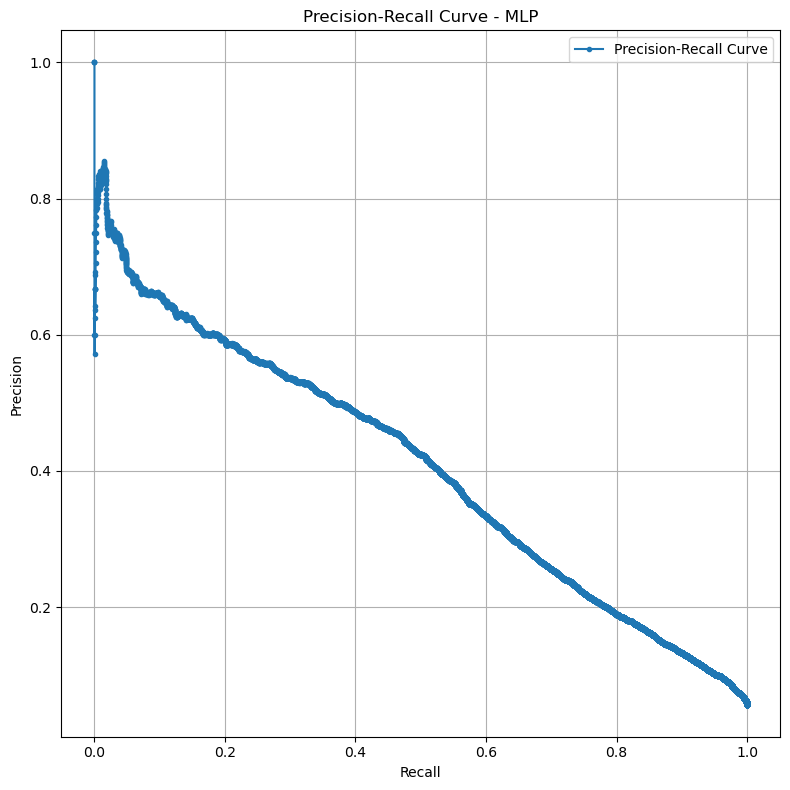

Plot Calibration Curve


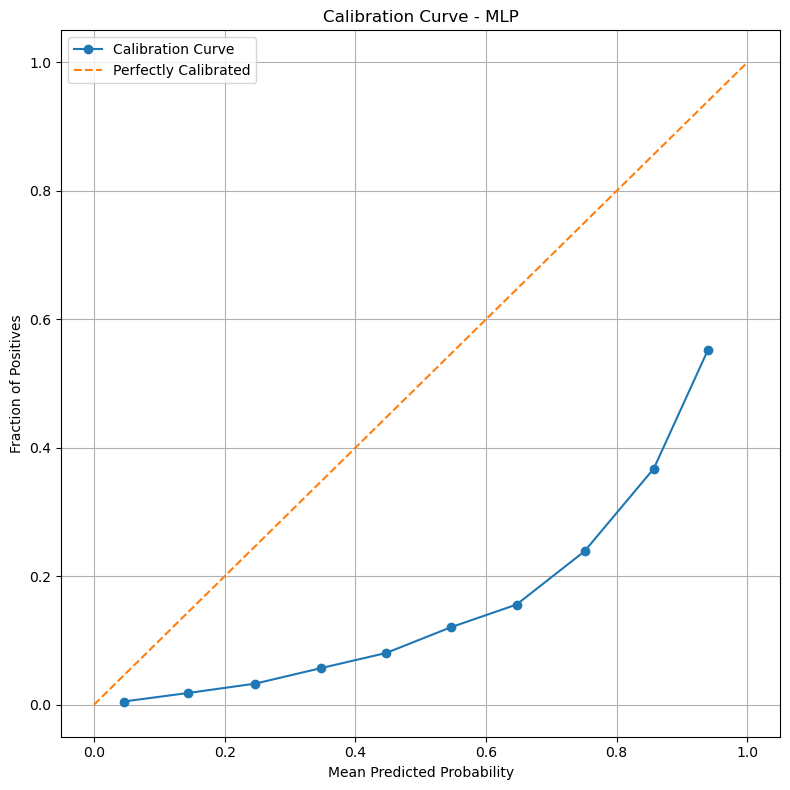

feature  importance_mean  importance_std
6                   HadAngina         0.238394        0.002298
1                         Sex         0.025616        0.001133
7                   HadStroke         0.022685        0.001184
2               GeneralHealth         0.013724        0.002551
40                AgeGroupNum         0.010768        0.000920
21               SmokerStatus         0.005486        0.000941
23                  ChestScan         0.004846        0.000684
5                RemovedTeeth         0.004426        0.000581
14                HadDiabetes         0.004291        0.000835
25                AgeCategory         0.002484        0.000667
38          WeightInKilograms         0.001303        0.000423
36                 SleepHours         0.001261        0.000358
0                       State         0.001166        0.000894
10                    HadCOPD         0.001117        0.000280
29              PneumoVaxEver         0.001112        0.000274
24      RaceEthnicityCategory         0.000961        0.000326
27                 HIVTesting         0.000805        0.000376
26            AlcoholDrinkers         0.000749        0.000246
28               FluVaxLast12         0.000668        0.000146
33               BMI_Category         0.000624        0.000406
32                   CovidPos         0.000521        0.000523
19  DifficultyDressingBathing         0.000499        0.000276
18          DifficultyWalking         0.000484        0.000109
3             LastCheckupTime         0.000428        0.000229
16    BlindOrVisionDifficulty         0.000360        0.000085
13               HadArthritis         0.000342        0.000192
12           HadKidneyDisease         0.000324        0.000246
34         PhysicalHealthDays         0.000320        0.000264
15        DeafOrHardOfHearing         0.000269        0.000103
20          DifficultyErrands         0.000236        0.000037
17    DifficultyConcentrating         0.000223        0.000132
30          TetanusLast10Tdap         0.000185        0.000290
37             HeightInMeters         0.000046        0.000147
22            ECigaretteUsage         0.000008        0.000164
9               HadSkinCancer        -0.000006        0.000116
35           MentalHealthDays        -0.000029        0.000214
8                   HadAsthma        -0.000055        0.000136
11      HadDepressiveDisorder        -0.000126        0.000155
31           HighRiskLastYear        -0.000154        0.000124
4          PhysicalActivities        -0.000211        0.000121
39                        BMI        -0.000327        0.000140

Plot Permutation Importance


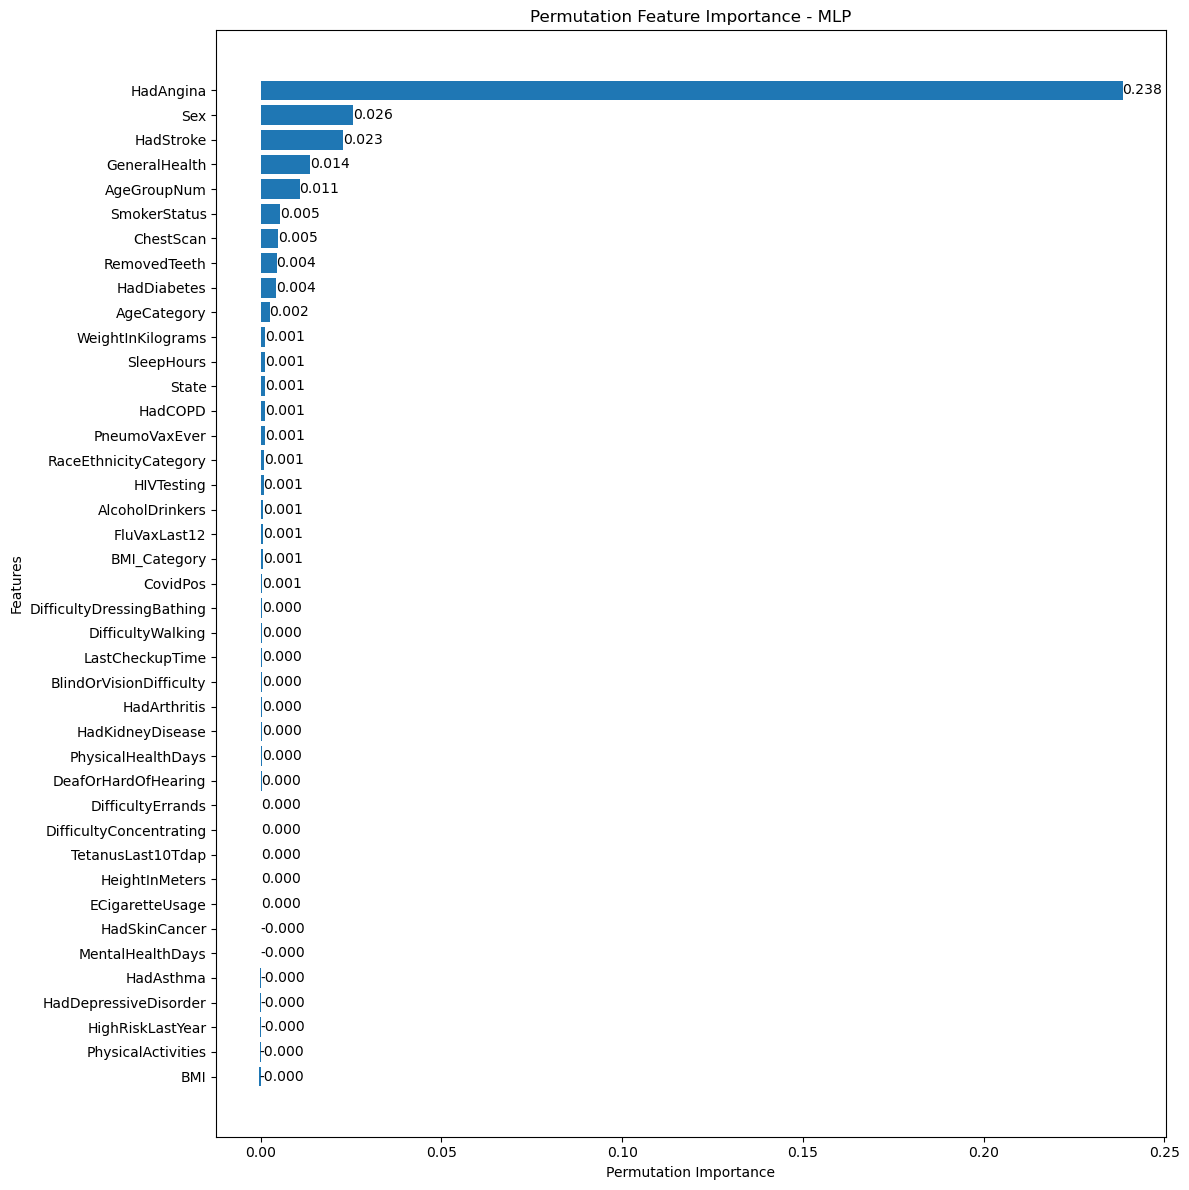

In [10]:
# Record number of columns to fill input dimension of MLP.
input_dimension = X_train_dummies.shape[1]


# Transform numpy array to torch tensors and create torch dataset.
def data_to_tensor(
        X_train_dummies,
        X_validation_dummies,
        X_test_dummies,
        y_train,
        y_validation,
        y_test):
    X_train_tensor = torch.tensor(
        X_train_dummies.to_numpy(), dtype=torch.float32)
    X_validation_tensor = torch.tensor(
        X_validation_dummies.to_numpy(), dtype=torch.float32)
    X_test_tensor = torch.tensor(
        X_test_dummies.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(
        y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
    y_validation_tensor = torch.tensor(
        y_validation.to_numpy(), dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(
        y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    validation_ds = TensorDataset(X_validation_tensor, y_validation_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)
    return train_ds, validation_ds, test_ds


# Define a class to stop training when detected overfitting.
class EarlyStopping:
    def __init__(self, patience, mode='max'):
        # Set some class attribute to record
        self.patience = patience
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model = None
        self.best_proba = None

    def __call__(self, model, proba, score):
        # Use deepcopy to store copies of the instances
        if self.best_score is None:
            self.best_model = deepcopy(model)
            self.best_proba = deepcopy(proba)
            self.best_score = deepcopy(score)
        else:
            if self.mode == 'max':
                improve = score - self.best_score > 0
            else:
                improve = self.best_score - score > 0
            if improve:
                self.best_model = deepcopy(model)
                self.best_proba = deepcopy(proba)
                self.best_score = deepcopy(score)
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True


# Define the structure of neurol network
class MLP(nn.Module):
    # Leave some hyperparameters for tuning.
    def __init__(self, input_dim, num_layers, hidden_dim, dropout):
        super().__init__()
        layers = []
        # Make the number of hidden layers adjustable
        for i in range(num_layers):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                # Normalize output, mitigate over-fitting.
                nn.BatchNorm1d(hidden_dim),
                # ReLU is non-linear activation function, which is the core of hidden layers to
                # capture non-linear relationship of dataset.
                nn.ReLU(),
                # Drop some neuron output to mitigate over-fitting
                nn.Dropout(dropout)
            ])
        # Define the actual structure
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # Unpack hidden layers into model structure
            *layers,
            # Full connection layer to output result
            nn.Linear(hidden_dim, 1),
        )

    # Define the forward propagation process.
    def forward(self, X):
        # Put into model for propagation
        return self.model(X)


# Define a train function to reuse in optuna and train final model
def trainMLP(batch_size, num_layers, hidden_dim, dropout, pos_weight, lr):
    # Define pytorch datalodaer
    train_ds, validation_ds, _ = data_to_tensor(
        X_train_dummies,
        X_validation_dummies,
        X_test_dummies,
        y_train,
        y_validation,
        y_test
    )
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, generator=g)
    validation_loader = DataLoader(validation_ds, batch_size=batch_size)
    # Instantiate MLP model, and sent it to GPU if available
    model = MLP(
        input_dim=input_dimension,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    # Set weight to mitigate imbalanced target.
    pos_weight = torch.tensor([pos_weight], device=device)
    # Use BCEWithLogitsLoss as loss function, which is suitable for binary classification
    # with imbalanced data
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Specify optimizer. Optimizer is a algorithm to update model parameters to minimize
    # loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Instantiate early stopper. When there are no improvement in eval function, stop the
    # training and restore best model.
    early_stopper = EarlyStopping(patience=10, mode='max')
    # Train the neurol network
    for epoch in range(200):
        start_time = time.time()
        # Set model to train mode
        model.train()
        # Record loss for batches
        total_loss = 0
        # Feed model in batches
        for xb, yb in train_loader:
            # Sent batches to GPU when available.
            xb, yb = xb.to(device), yb.to(device)
            # Get the logits of forward propagation.
            logits = model(xb)
            # Use loss function to calculate losses.
            loss = criterion(logits, yb)
            # Clean optimizer's gradient record.
            optimizer.zero_grad()
            # Back-propagation and calculate gradient
            loss.backward()
            # Use optimizer to update parameters.
            optimizer.step()
            # Record loss for the batches
            total_loss += loss.item()
        # Get average losses
        avg_loss = total_loss / len(train_loader)
        # Set model to evaluate mode
        model.eval()
        logits = []
        # Tell model not to calculate and record gradient
        with torch.no_grad():
            for xb, yb in validation_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits.append(model(xb))
            logits = torch.cat(logits, dim=0)
        # Use sigmoid to get probability
        proba = torch.sigmoid(logits).cpu().numpy().squeeze()
        # Calculate the average precision score, i.e., the area under the PR curve.
        score = average_precision_score(y_validation, proba)
        end_time = time.time()
        # Print verbose
        print(
            f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Score: {score:.4f}, {end_time - start_time:.2f}', flush=True)
        # Use early stopper to check improvement and detect overfitting
        early_stopper(model, proba, score)
        if early_stopper.early_stop:
            print(
                f'Early stopping triggered at epoch {epoch+1} with score {early_stopper.best_score}', flush=True)
            break
    # Restore model, proba, score from best epoch
    model = deepcopy(early_stopper.best_model)
    proba = deepcopy(early_stopper.best_proba)
    score = deepcopy(early_stopper.best_score)
    # Return model, proba, score to external
    return model, proba, score


class wrap_mlp(ClassifierMixin):
    def __init__(self, model, batch_size):
        self.classes_ = np.array([0, 1])
        self.model = model
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        _, _, test_ds = data_to_tensor(
            X_train_dummies,
            X_validation_dummies,
            X_test_permutation,
            y_train,
            y_validation,
            y_test
        )
        test_loader = DataLoader(test_ds, batch_size=self.batch_size)
        self.model.eval()
        logits = []
        with torch.no_grad():
            for xb in test_loader:
                xb = xb[0].to(device)
                logits.append(self.model(xb))
            logits = torch.cat(logits, dim=0)
        proba = torch.sigmoid(logits).cpu().numpy()
        return np.hstack(tup=[1 - proba, proba])

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


# Define optuna objective
def mlp_objective(trial):
    # How much records being feeded into model each time
    batch_size = trial.suggest_int('batch_size', 2048, 16384)
    # Number of hidden layers
    num_layers = trial.suggest_int('num_layers', 1, 4)
    # Dimension of hidden layers, i.e., neurons.
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    # How many portion of neurons being dropped to avoid over-fitting.
    dropout = trial.suggest_float('dropout', 0, 0.5)
    # Set wights to handle imbalanced target.
    pos_weight = trial.suggest_float('pos_weight', 0.1, 10)
    # Set learning rate.
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Use hyperparameters to train model and get score. Do not need model and proba during tunning.
    _, _, score = trainMLP(
        batch_size=batch_size,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout=dropout,
        pos_weight=pos_weight,
        lr=lr
    )
    return score


# Define optuna study object, and direction is to maximize area under PR-Curve
# Evaluated on validation set.
output_seperate('Searching Hyperparameters')
mlp_study = optuna.create_study(direction='maximize', sampler=sampler)
mlp_study.optimize(mlp_objective, n_trials=n_trials)

# Use best hyperparameters to train final model and retrieve the results on the test set
output_seperate('Train model with best hyperparameters...')
mlp_model, _, _ = trainMLP(**mlp_study.best_params)
wrapped_mlp = wrap_mlp(
    mlp_model, batch_size=mlp_study.best_params['batch_size'])
mlp_proba = wrapped_mlp.predict_proba(X_test)[:,1]
mlp_score = average_precision_score(y_test, mlp_proba)
mlp_pred = (mlp_proba > 0.5).astype(int)
mlp_results = output_results(
    mlp_score, mlp_study, y_test, mlp_pred, mlp_proba)
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test, mlp_proba, 'MLP')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test, mlp_proba, 'MLP')

mlp_important_df = calculate_permutation_importance(wrapped_mlp, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance,
                 (12, 12), mlp_important_df, 'MLP')

## 5.5. Model comparison


Plot Precison-Recall Curve Comparison


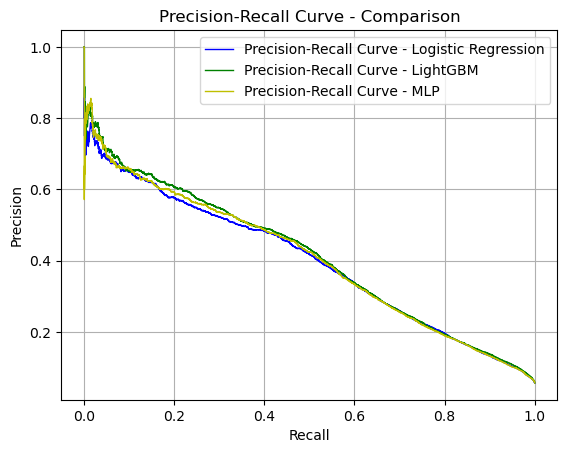

Plot Calibration Curve Compaision


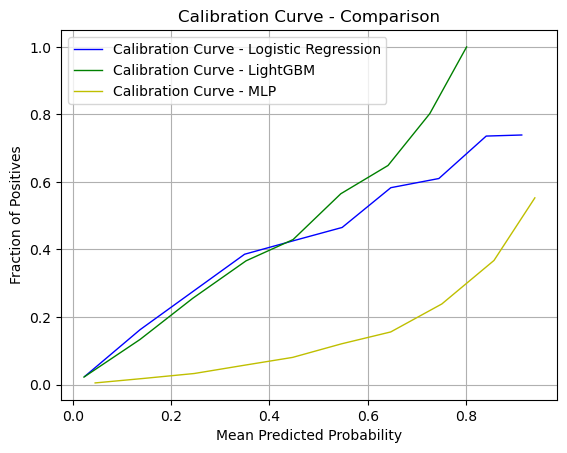

Plot Permutation importance


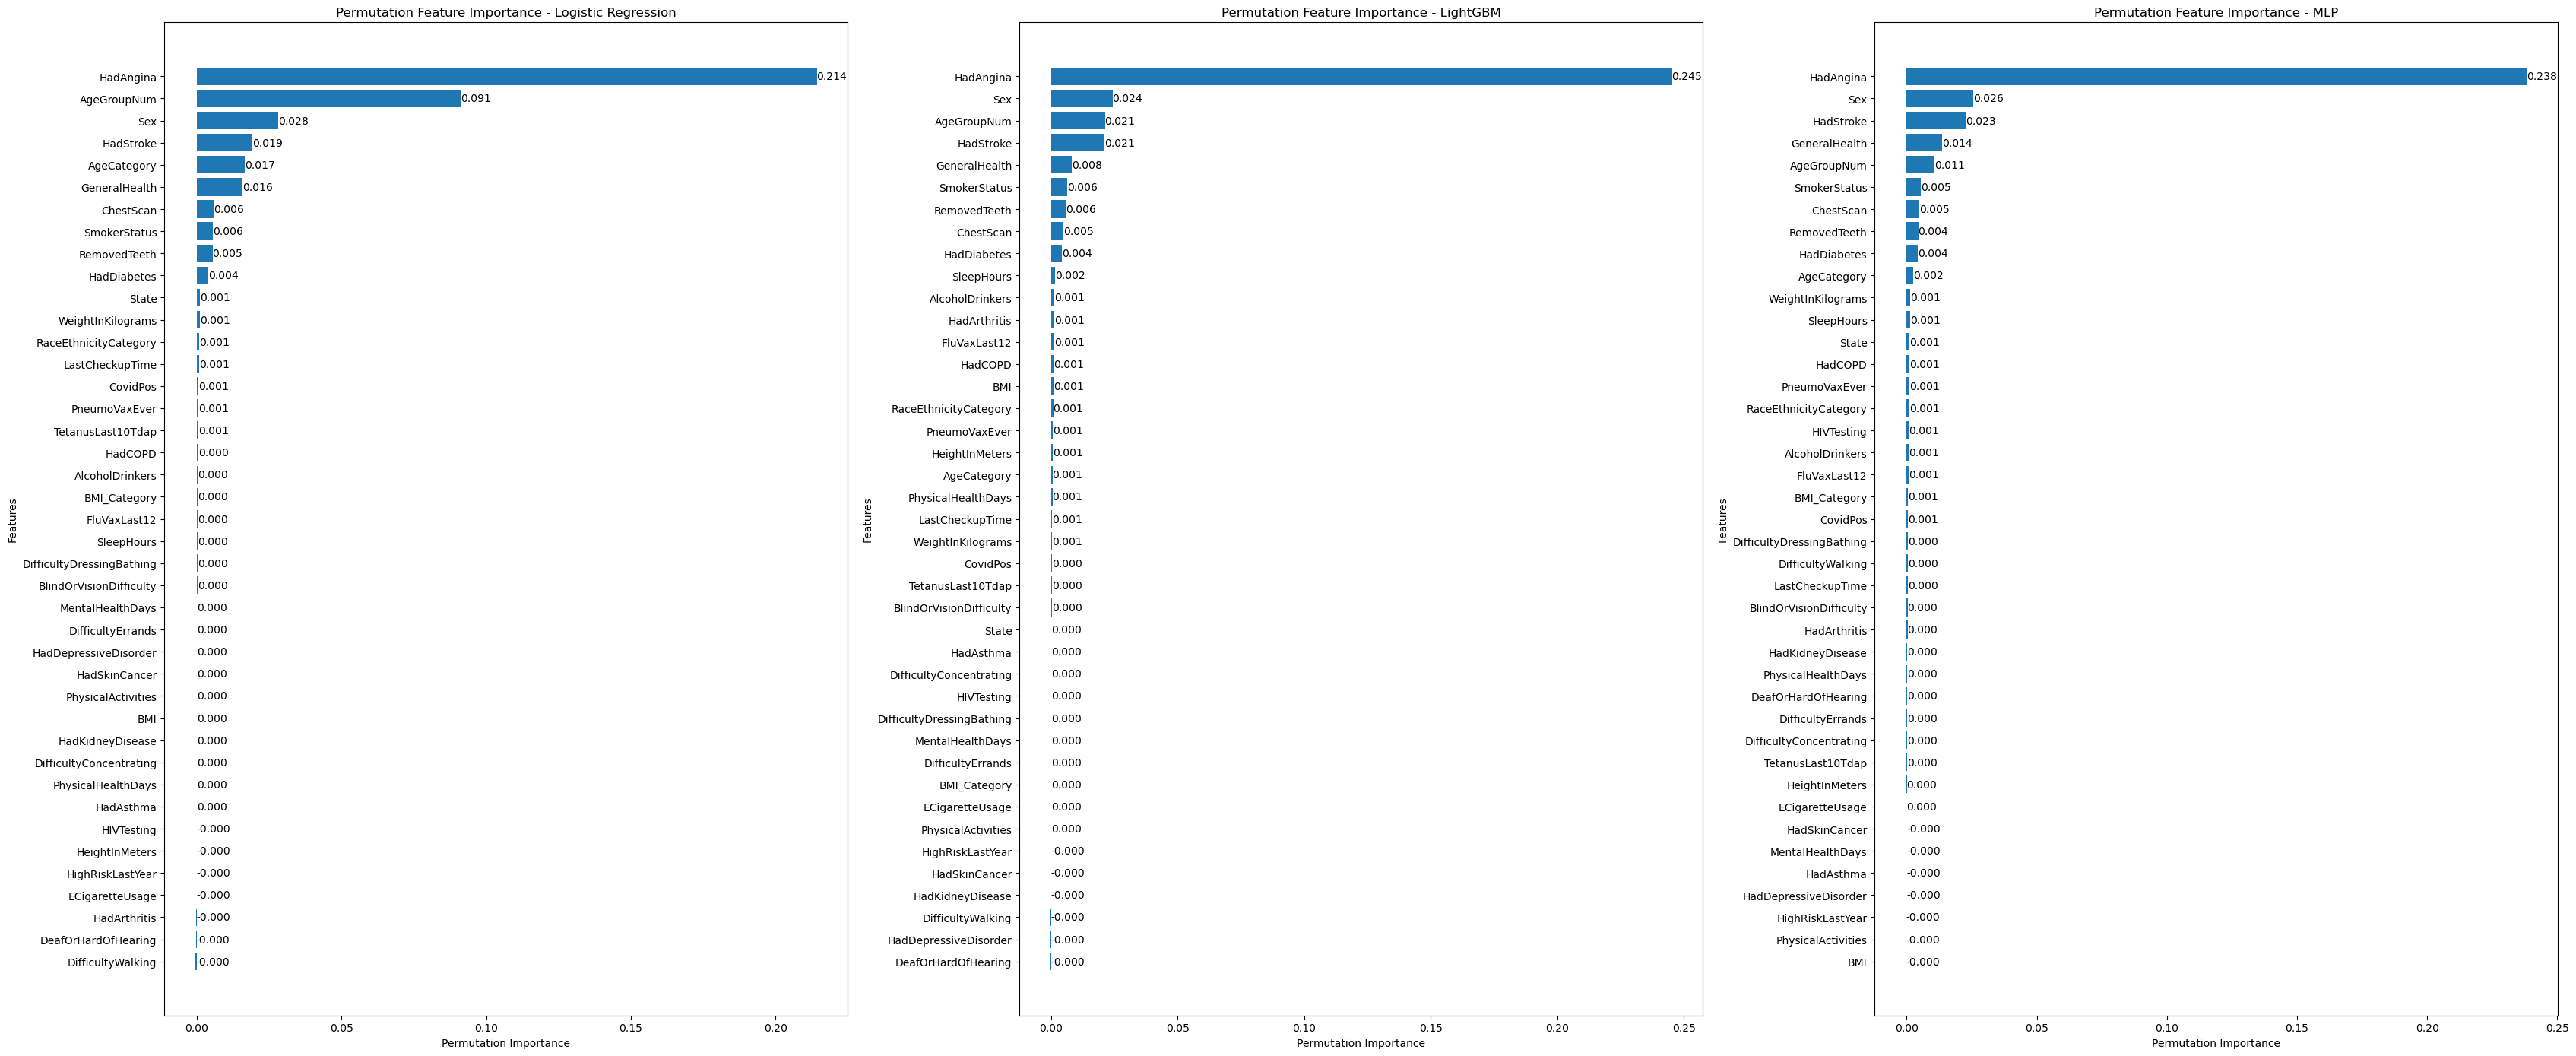

PR AUC   ROC AUC  F1 Score  Precision    Recall
Logistic Regression  0.397730  0.881143  0.330391   0.557447  0.234767
LightGBM             0.410261  0.884743  0.308832   0.603708  0.207487
MLP                  0.403138  0.880697  0.394982   0.280445  0.667662

In [11]:
# Plot PR curve comparison
output_seperate('Plot Precison-Recall Curve Comparison')
fig, ax = plt.subplots()
precision, recall, _ = precision_recall_curve(y_test, logistic_proba)
ax.plot(recall, precision, color='b', linewidth=1,
        label='Precision-Recall Curve - Logistic Regression')
precision, recall, _ = precision_recall_curve(y_test, lgbm_proba)
ax.plot(recall, precision, color='g', linewidth=1,
        label='Precision-Recall Curve - LightGBM')
precision, recall, _ = precision_recall_curve(y_test, mlp_proba)
ax.plot(recall, precision, color='y', linewidth=1,
        label='Precision-Recall Curve - MLP')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title(f'Precision-Recall Curve - Comparison')
ax.legend()
ax.grid()
plt.show()

# Plot Calibaration Curve comparison
output_seperate('Plot Calibration Curve Compaision')
fig, ax = plt.subplots()
prob_true, prob_pred = calibration_curve(y_test, logistic_proba, n_bins=10)
ax.plot(prob_pred, prob_true, color='b', linewidth=1,
        label='Calibration Curve - Logistic Regression')
prob_true, prob_pred = calibration_curve(y_test, lgbm_proba, n_bins=10)
ax.plot(prob_pred, prob_true, color='g', linewidth=1,
        label='Calibration Curve - LightGBM')
prob_true, prob_pred = calibration_curve(y_test, mlp_proba, n_bins=10)
ax.plot(prob_pred, prob_true, color='y', linewidth=1,
        label='Calibration Curve - MLP')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title(f'Calibration Curve - Comparison')
ax.legend()
ax.grid()
plt.show()

# Plot permutation importance comparison
output_seperate('Plot Permutation importance')
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(34, 14))
plot_permutation_importance(logistic_important_df,
                            'Logistic Regression', ax=axes[0])
plot_permutation_importance(lgbm_important_df, 'LightGBM', ax=axes[1])
plot_permutation_importance(mlp_important_df, 'MLP', ax=axes[2])
plt.tight_layout()
plt.show()

# Print scores comparison
comparison = pd.concat([logistic_results, lgbm_results, mlp_results])
comparison.index = ['Logistic Regression', 'LightGBM', 'MLP']
display(comparison)

# *With SMOTE

# 0. Initialize Environment


In [12]:
# -------------------------------
# PROJECT OBJECTIVES
# -------------------------------
# 1) Clean, explore, and analyze data on cardiovascular disease;
# 2) Build predictive models for CVD risk using key indicators;
# 3) Create visualizations to support findings;
# 4) Demonstrate collaboration in producing a final report.

# ----------------------------
# PROJECT WORKFLOW
# ----------------------------
# Step 1: Data acquisition & cleaning (DONE)
# Step 2: Feature engineering
# Step 3: Exploratory and descriptive data analysis
# Step 4: Predictive modeling
# Step 5: Data visualization
# Step 6: Interpretation and discussion
# Step 7: Conclusion
# Step 8: References

# -------------------------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import torch
import torch.nn as nn
import gc

from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.base import ClassifierMixin
from sklearn.calibration import calibration_curve
from torch.utils.data import TensorDataset, DataLoader
from lightgbm import LGBMClassifier, early_stopping
import optuna
import kagglehub
from imblearn.over_sampling import SMOTE

# -------------------------------------------------------------
# SEEDING
# -------------------------------------------------------------
seed = 88888
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
g = torch.Generator().manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sampler = optuna.samplers.TPESampler(seed=seed)
n_trials = 50
n_repeats = 10

# -------------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------------
path = kagglehub.dataset_download(
    "kamilpytlak/personal-key-indicators-of-heart-disease")
file = path + '/2022/heart_2022_with_nans.csv'
heart_df = pd.read_csv(file)


# Utility function to seperate outputs
def output_seperate(text):
    print('='*79, flush=True)
    print(text, flush=True)
    print('='*79, flush=True)

# 1. Exploratory Data Analysis


## 1.1. Data Overview


In [13]:
# General Information
output_seperate('Dataset Info')
heart_df.info(memory_usage='deep')
output_seperate('Data Head')
display(heart_df.head())
# Summary of missing values
# All missing values are less than 20% therefore all variables retained
missing_values = heart_df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(heart_df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percent Missing': missing_percentage.round(2)
})
output_seperate('Variables with Missing Values (<20%):')
display(missing_df[missing_df['Missing Values'] > 0])

Dataset Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer   

State     Sex GeneralHealth  PhysicalHealthDays  MentalHealthDays  \
0  Alabama  Female     Very good                 0.0               0.0   
1  Alabama  Female     Excellent                 0.0               0.0   
2  Alabama  Female     Very good                 2.0               3.0   
3  Alabama  Female     Excellent                 0.0               0.0   
4  Alabama  Female          Fair                 2.0               0.0   

                                     LastCheckupTime PhysicalActivities  \
0  Within past year (anytime less than 12 months ...                 No   
1                                                NaN                 No   
2  Within past year (anytime less than 12 months ...                Yes   
3  Within past year (anytime less than 12 months ...                Yes   
4  Within past year (anytime less than 12 months ...                Yes   

   SleepHours RemovedTeeth HadHeartAttack  ... HeightInMeters  \
0         8.0          NaN             No  ...            NaN   
1         6.0          NaN             No  ...           1.60   
2         5.0          NaN             No  ...           1.57   
3         7.0          NaN             No  ...           1.65   
4         9.0          NaN             No  ...           1.57   

  WeightInKilograms    BMI AlcoholDrinkers HIVTesting FluVaxLast12  \
0               NaN    NaN              No         No          Yes   
1             68.04  26.57              No         No           No   
2             63.50  25.61              No         No           No   
3             63.50  23.30              No         No          Yes   
4             53.98  21.77             Yes         No           No   

  PneumoVaxEver                                  TetanusLast10Tdap  \
0            No  Yes, received tetanus shot but not sure what type   
1            No  No, did not receive any tetanus shot in the pa...   
2            No                                                NaN   
3           Yes  No, did not receive any tetanus shot in the pa...   
4           Yes  No, did not receive any tetanus shot in the pa...   

  HighRiskLastYear CovidPos  
0               No       No  
1               No       No  
2               No      Yes  
3               No       No  
4               No       No  

[5 rows x 40 columns]

Variables with Missing Values (<20%):


Missing Values  Percent Missing
TetanusLast10Tdap                   82516            18.54
PneumoVaxEver                       77040            17.31
HIVTesting                          66127            14.86
ChestScan                           56046            12.59
CovidPos                            50764            11.40
HighRiskLastYear                    50623            11.37
BMI                                 48806            10.96
FluVaxLast12                        47121            10.59
AlcoholDrinkers                     46574            10.46
WeightInKilograms                   42078             9.45
ECigaretteUsage                     35660             8.01
SmokerStatus                        35462             7.97
HeightInMeters                      28652             6.44
DifficultyErrands                   25656             5.76
DifficultyConcentrating             24240             5.45
DifficultyWalking                   24012             5.39
DifficultyDressingBathing           23915             5.37
BlindOrVisionDifficulty             21564             4.84
DeafOrHardOfHearing                 20647             4.64
RaceEthnicityCategory               14057             3.16
RemovedTeeth                        11360             2.55
PhysicalHealthDays                  10927             2.45
AgeCategory                          9079             2.04
MentalHealthDays                     9067             2.04
LastCheckupTime                      8308             1.87
SleepHours                           5453             1.23
HadAngina                            4405             0.99
HadSkinCancer                        3143             0.71
HadHeartAttack                       3065             0.69
HadDepressiveDisorder                2812             0.63
HadArthritis                         2633             0.59
HadCOPD                              2219             0.50
HadKidneyDisease                     1926             0.43
HadAsthma                            1773             0.40
HadStroke                            1557             0.35
GeneralHealth                        1198             0.27
PhysicalActivities                   1093             0.25
HadDiabetes                          1087             0.24

## 1.2. Data Visualizations


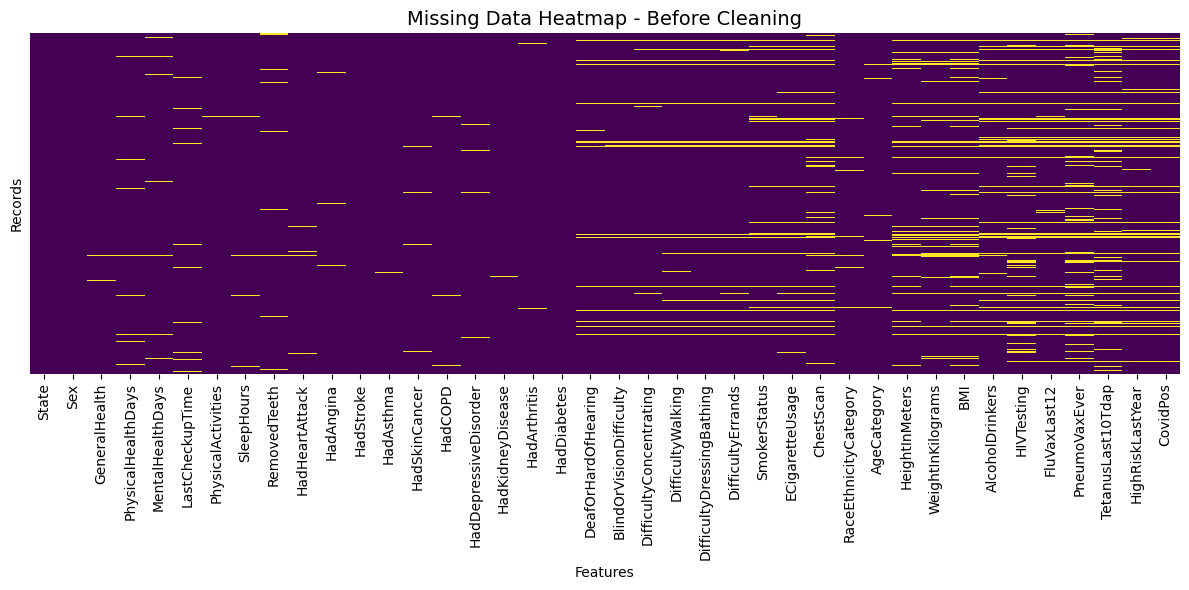

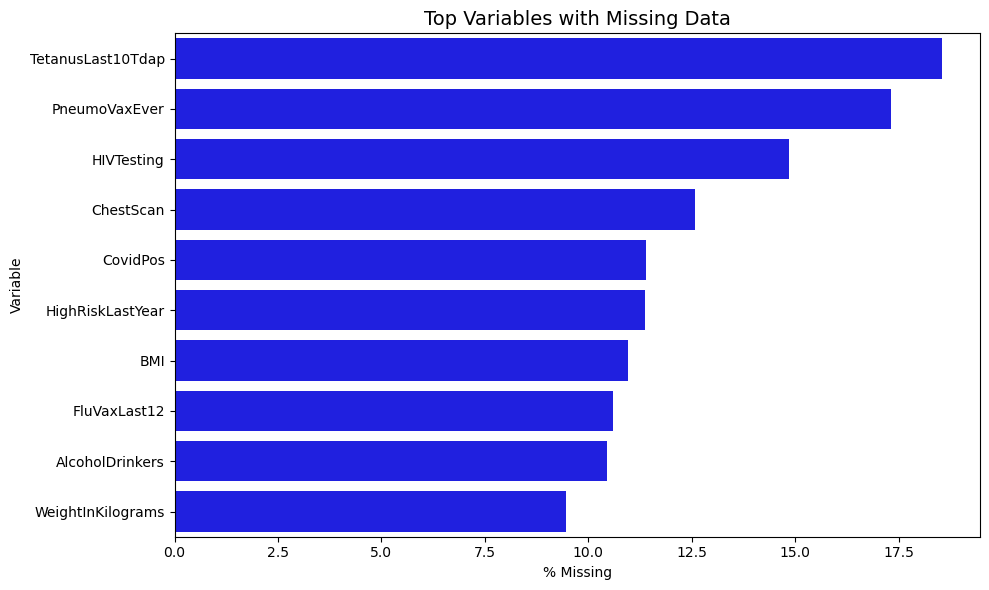

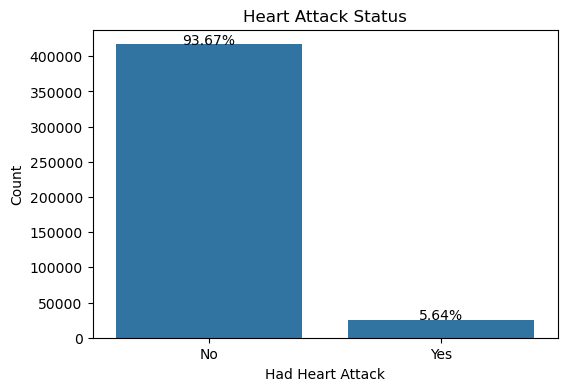

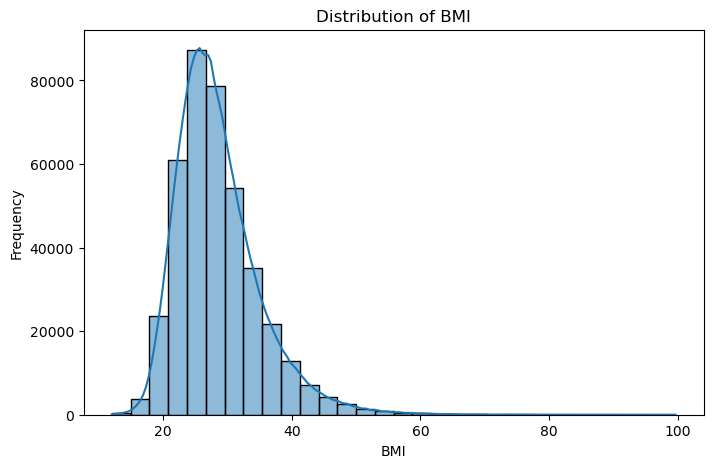

In [14]:
# Visualization of degree of missingness using a heatmap before cleaning
# Widespread but sparse missingness across many variables
# No large blocks of completely missing data for any one record or column
# There are very few individual rows with large amounts of missing data
# Further suggests it is not necessary to remove entire records
plt.figure(figsize=(12, 6))
sns.heatmap(heart_df.isnull(),
            cbar=False,
            yticklabels=False,
            cmap='viridis')
plt.title('Missing Data Heatmap - Before Cleaning', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Records')
plt.tight_layout()
plt.show()

# Visualization of top variables with missing data
top_missing = missing_df[missing_df['Missing Values'] > 0] \
    .sort_values(by='Missing Values', ascending=False) \
    .head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_missing,
    y='index',  # Variable names
    x='Percent Missing',
    color='blue'
)
plt.title('Top Variables with Missing Data', fontsize=14)
plt.xlabel('% Missing')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Bar plot of Heart Attack status with percentage labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='HadHeartAttack', data=heart_df)
total = len(heart_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 500,
            f'{100 * height / total:.2f}%', ha="center")
plt.title('Heart Attack Status')
plt.xlabel('Had Heart Attack')
plt.ylabel('Count')
plt.show()

# Histogram of BMI
plt.figure(figsize=(8, 5))
sns.histplot(data=heart_df, x='BMI', kde=True, bins=30)
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.show()

# 2. Data Cleaning & Imputation


In [15]:
# Define target
target = 'HadHeartAttack'
# Drop rows with missing target variable and create a clean copy
heart_clean = heart_df.dropna(subset=['HadHeartAttack'])
# Reset index after row drops
heart_clean.reset_index(drop=True, inplace=True)
# Seperate features and target
y = heart_clean[target]
X = heart_clean.drop(columns=target)
# Train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
# Train/validation splits
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

# Impute missing numerical values with median due to non-normality
# Less sensitive to outliers than the mean
# Real-world health data (e.g., BMI) often have skewed distributions
# Using median values ensures imputed values do not distort the distribution or introduce bias from extreme values
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numerical_cols = X_train.select_dtypes(
    include=['float64', 'int64']).columns.tolist()
for col in numerical_cols:
    if X[col].isnull().any():
        imputer = X_train[col].median()
        X_train[col] = X_train[col].fillna(imputer)
        X_validation[col] = X_validation[col].fillna(imputer)
        X_test[col] = X_test[col].fillna(imputer)

# Impute missing categorical values with mode
  # Imputing with the mode preserves the most common pattern in the data
  # It avoids randomly assigning categories, which could mislead the model or analysis
for col in categorical_cols:
    if X[col].isnull().any():
        imputer = X_train[col].mode()[0]
        X_train[col] = X_train[col].fillna(imputer)
        X_validation[col] = X_validation[col].fillna(imputer)
        X_test[col] = X_test[col].fillna(imputer)

# Final check for missing values
# There are n=0 missing values
missing_after_cleaning = X_train.isnull().sum().sum() + \
    X_validation.isnull().sum().sum() + X_test.isnull().sum().sum()
output_seperate('Missing values after cleaning:')
print(missing_after_cleaning)
assert missing_after_cleaning == 0, "Some missing values still remain"
output_seperate('Information of X_train')
X_train.info()
output_seperate('Information of X_validation')
X_validation.info()
output_seperate('Information of X_test')
X_test.info()
print("Data cleaning complete and ready for analysis")

Missing values after cleaning:
0
Information of X_train
<class 'pandas.core.frame.DataFrame'>
Index: 282922 entries, 231375 to 421432
Data columns (total 39 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      282922 non-null  object 
 1   Sex                        282922 non-null  object 
 2   GeneralHealth              282922 non-null  object 
 3   PhysicalHealthDays         282922 non-null  float64
 4   MentalHealthDays           282922 non-null  float64
 5   LastCheckupTime            282922 non-null  object 
 6   PhysicalActivities         282922 non-null  object 
 7   SleepHours                 282922 non-null  float64
 8   RemovedTeeth               282922 non-null  object 
 9   HadAngina                  282922 non-null  object 
 10  HadStroke                  282922 non-null  object 
 11  HadAsthma                  282922 non-null  object 
 12  HadSkinCancer              282

# 3. Feature Engineering


In [16]:
# ---------------------------------------------
# CREATE BMI CATEGORY
# ---------------------------------------------
def get_bmi_category(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'


X_train['BMI_Category'] = X_train['BMI'].apply(get_bmi_category)
X_validation['BMI_Category'] = X_validation['BMI'].apply(get_bmi_category)
X_test['BMI_Category'] = X_test['BMI'].apply(get_bmi_category)

# ---------------------------------------------
# Convert AgeCategory into Numeric Order
# ---------------------------------------------
age_order = X['AgeCategory'].value_counts(
    dropna=False).sort_index().index.to_list()
age_group_numbers = {age: idx for idx, age in enumerate(age_order)}
X_train['AgeGroupNum'] = X_train['AgeCategory'].map(age_group_numbers)
X_validation['AgeGroupNum'] = X_validation['AgeCategory'].map(
    age_group_numbers)
X_test['AgeGroupNum'] = X_test['AgeCategory'].map(age_group_numbers)

output_seperate('Feature engineering complete. Sample data:')
display(X_train[['BMI_Category', 'AgeGroupNum']].head(10))

Feature engineering complete. Sample data:


BMI_Category  AgeGroupNum
231375       Normal            9
253304        Obese            6
84768    Overweight            2
217385        Obese           10
201405       Normal            0
73484    Overweight           12
337056       Normal            6
166732       Normal            3
247092        Obese            9
202184   Overweight            7

# 4. Data Preprocess


In [17]:
# Reset column names after feature engineering
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numerical_cols = X_train.select_dtypes(
    include=['float64', 'int64']).columns.tolist()
# Reorder train/test sets' columns
X_train = X_train[categorical_cols + numerical_cols]
X_validation = X_validation[categorical_cols + numerical_cols]
X_test = X_test[categorical_cols + numerical_cols]
# Record column names for later result analysis
col_names = X_train.columns.to_list()
# Standardlize numerical features
ss = StandardScaler()
X_train[numerical_cols] = ss.fit_transform(X_train[numerical_cols])
X_validation[numerical_cols] = ss.transform(X_validation[numerical_cols])
X_test[numerical_cols] = ss.transform(X_test[numerical_cols])
# Mapping target from 'Yes/No' to '1/0'
y_train = y_train.map({'Yes': 1, 'No': 0})
y_validation = y_validation.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})


# Define a function to transform categorical data into dummies, which
# will map 'Yes/No' to '1/0' since 'drop_first' enabled. This function
# will be reused in permutation importance analysis.
def process_data(X_train, X_validation, X_test):
    # Get dummies
    X_train_dummies = pd.get_dummies(X_train, drop_first=True, dtype='int64')
    X_validation_dummies = pd.get_dummies(
        X_validation, drop_first=True, dtype='int64')
    X_test_dummies = pd.get_dummies(X_test, drop_first=True, dtype='int64')
    # There are illegal strings in column names. Rename them.
    X_train_dummies.columns = X_train_dummies.columns.str.replace(r'\W+', '_', regex=True)
    X_validation_dummies.columns = X_validation_dummies.columns.str.replace(r'\W+', '_', regex=True)
    X_test_dummies.columns = X_test_dummies.columns.str.replace(r'\W+', '_', regex=True)
    dummies_col_names = X_train_dummies.columns

    # Check whether dummy cols are the same in case there are different classes in
    # validation set and test set.
    if (
        list(X_train_dummies.columns) == list(
            X_validation_dummies.columns) == list(X_test_dummies.columns)
    ):
        # If the same, return directly
        return X_train_dummies, X_validation_dummies, X_test_dummies, X_train_dummies.columns

    # If not the same, add col to validation set and test set with 0 or drop col.
    X_validation_dummies = X_validation_dummies.reindex(
        columns=dummies_col_names, fill_value=0)
    X_test_dummies = X_test_dummies.reindex(
        columns=dummies_col_names, fill_value=0)

    return X_train_dummies, X_validation_dummies, X_test_dummies, dummies_col_names


X_train_dummies, X_validation_dummies, X_test_dummies, dummies_col_names = process_data(
    X_train, X_validation, X_test)

# Delete unnecessary variables to save memory
del heart_df, heart_clean, X
gc.collect()

# Print information
output_seperate('X_train:')
display(X_train_dummies.describe())
output_seperate('X_validation:')
display(X_validation_dummies.describe())
output_seperate('X_test:')
display(X_test_dummies.describe())

X_train:


PhysicalHealthDays  MentalHealthDays    SleepHours  HeightInMeters  \
count        2.829220e+05      2.829220e+05  2.829220e+05    2.829220e+05   
mean        -2.788958e-17     -4.551992e-17 -2.406466e-16    4.861201e-15   
std          1.000002e+00      1.000002e+00  1.000002e+00    1.000002e+00   
min         -4.923737e-01     -5.153771e-01 -4.044858e+00   -7.648157e+00   
25%         -4.923737e-01     -5.153771e-01 -6.890388e-01   -6.990363e-01   
50%         -4.923737e-01     -5.153771e-01 -1.787496e-02   -2.342734e-02   
75%         -1.432857e-01     -3.410768e-02  6.532889e-01    7.486971e-01   
max          2.998507e+00      3.094143e+00  1.139191e+01    6.829177e+00   

       WeightInKilograms           BMI   AgeGroupNum   State_Alaska  \
count       2.829220e+05  2.829220e+05  2.829220e+05  282922.000000   
mean       -5.997077e-16 -6.180412e-16 -1.119099e-16       0.012890   
std         1.000002e+00  1.000002e+00  1.000002e+00       0.112802   
min        -2.946608e+00 -2.645394e+00 -1.867931e+00       0.000000   
25%        -7.251384e-01 -6.457575e-01 -7.467511e-01       0.000000   
50%        -1.031661e-01 -1.567422e-01  9.413374e-02       0.000000   
75%         4.301630e-01  4.194242e-01  9.350186e-01       0.000000   
max         1.027104e+01  1.149570e+01  1.495609e+00       1.000000   

       State_Arizona  State_Arkansas  ...  PneumoVaxEver_Yes  \
count  282922.000000   282922.000000  ...      282922.000000   
mean        0.022656        0.011756  ...           0.343102   
std         0.148806        0.107786  ...           0.474746   
min         0.000000        0.000000  ...           0.000000   
25%         0.000000        0.000000  ...           0.000000   
50%         0.000000        0.000000  ...           0.000000   
75%         0.000000        0.000000  ...           1.000000   
max         1.000000        1.000000  ...           1.000000   

       TetanusLast10Tdap_Yes_received_Tdap  \
count                        282922.000000   
mean                              0.225133   
std                               0.417670   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_sure_what_type  \
count                                      282922.000000                    
mean                                            0.255919                    
std                                             0.436377                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                             1.000000                    
max                                             1.000000                    

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_Tdap  \
count                                      282922.000000          
mean                                            0.062074          
std                                             0.241290          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                             1.000000          

       HighRiskLastYear_Yes  \
count         282922.000000   
mean               0.038375   
std                0.192099   
min                0.000000   
25%                0.000000   
50%                0.000000   
75%                0.000000   
max                1.000000   

       CovidPos_Tested_positive_using_home_test_without_a_health_professional  \
count                 

X_validation:


PhysicalHealthDays  MentalHealthDays    SleepHours  HeightInMeters  \
count        70731.000000      70731.000000  70731.000000    70731.000000   
mean            -0.007737          0.003387     -0.007048        0.003256   
std              0.992086          1.004659      1.004415        1.004764   
min             -0.492374         -0.515377     -4.044858       -7.648157   
25%             -0.492374         -0.515377     -0.689039       -0.699036   
50%             -0.492374         -0.515377     -0.017875       -0.023427   
75%             -0.143286         -0.034108      0.653289        0.748697   
max              2.998507          3.094143     11.391910        6.829177   

       WeightInKilograms           BMI   AgeGroupNum  State_Alaska  \
count       70731.000000  70731.000000  70731.000000  70731.000000   
mean           -0.001357     -0.002386     -0.000249      0.013799   
std             0.996413      0.992514      1.001680      0.116656   
min            -2.946608     -2.622799     -1.867931      0.000000   
25%            -0.725138     -0.645757     -0.746751      0.000000   
50%            -0.103166     -0.156742      0.094134      0.000000   
75%             0.430163      0.419424      0.935019      0.000000   
max            10.159867      9.956029      1.495609      1.000000   

       State_Arizona  State_Arkansas  ...  PneumoVaxEver_Yes  \
count   70731.000000    70731.000000  ...       70731.000000   
mean        0.023469        0.011890  ...           0.342664   
std         0.151389        0.108392  ...           0.474604   
min         0.000000        0.000000  ...           0.000000   
25%         0.000000        0.000000  ...           0.000000   
50%         0.000000        0.000000  ...           0.000000   
75%         0.000000        0.000000  ...           1.000000   
max         1.000000        1.000000  ...           1.000000   

       TetanusLast10Tdap_Yes_received_Tdap  \
count                         70731.000000   
mean                              0.227425   
std                               0.419172   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_sure_what_type  \
count                                       70731.000000                    
mean                                            0.254980                    
std                                             0.435853                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                             1.000000                    
max                                             1.000000                    

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_Tdap  \
count                                       70731.000000          
mean                                            0.061868          
std                                             0.240918          
min                                             0.000000          
25%                                             0.000000          
50%                                             0.000000          
75%                                             0.000000          
max                                             1.000000          

       HighRiskLastYear_Yes  \
count          70731.000000   
mean               0.039106   
std                0.193848   
min                0.000000   
25%                0.000000   
50%                0.000000   
75%                0.000000   
max                1.000000   

       CovidPos_Tested_positive_using_home_test_without_a_health_professional  \
count                          

X_test:


PhysicalHealthDays  MentalHealthDays    SleepHours  HeightInMeters  \
count        88414.000000      88414.000000  88414.000000    88414.000000   
mean            -0.000997         -0.002117     -0.006572        0.004903   
std              1.000262          0.996337      0.988459        0.999439   
min             -0.492374         -0.515377     -4.044858       -7.648157   
25%             -0.492374         -0.515377     -0.689039       -0.699036   
50%             -0.492374         -0.515377     -0.017875       -0.023427   
75%             -0.143286         -0.034108      0.653289        0.748697   
max              2.998507          3.094143     11.391910        6.829177   

       WeightInKilograms           BMI   AgeGroupNum  State_Alaska  \
count       88414.000000  88414.000000  88414.000000  88414.000000   
mean            0.003917      0.000486      0.001791      0.013414   
std             1.003220      1.003842      0.999461      0.115041   
min            -2.946608     -2.630869     -1.867931      0.000000   
25%            -0.680572     -0.645757     -0.746751      0.000000   
50%            -0.103166     -0.156742      0.094134      0.000000   
75%             0.430163      0.419424      0.935019      0.000000   
max             9.704407     11.174532      1.495609      1.000000   

       State_Arizona  State_Arkansas  ...  PneumoVaxEver_Yes  \
count   88414.000000    88414.000000  ...       88414.000000   
mean        0.022836        0.012147  ...           0.340919   
std         0.149380        0.109544  ...           0.474021   
min         0.000000        0.000000  ...           0.000000   
25%         0.000000        0.000000  ...           0.000000   
50%         0.000000        0.000000  ...           0.000000   
75%         0.000000        0.000000  ...           1.000000   
max         1.000000        1.000000  ...           1.000000   

       TetanusLast10Tdap_Yes_received_Tdap  \
count                         88414.000000   
mean                              0.224308   
std                               0.417128   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_sure_what_type  \
count                                       88414.000000                    
mean                                            0.255401                    
std                                             0.436089                    
min                                             0.000000                    
25%                                             0.000000                    
50%                                             0.000000                    
75%                                             1.000000                    
max                                             1.000000                    

       TetanusLast10Tdap_Yes_received_tetanus_shot_but_not_Tdap  \
count                                        88414.00000          
mean                                             0.06076          
std                                              0.23889          
min                                              0.00000          
25%                                              0.00000          
50%                                              0.00000          
75%                                              0.00000          
max                                              1.00000          

       HighRiskLastYear_Yes  \
count          88414.000000   
mean               0.039168   
std                0.193996   
min                0.000000   
25%                0.000000   
50%                0.000000   
75%                0.000000   
max                1.000000   

       CovidPos_Tested_positive_using_home_test_without_a_health_professional  \
count                          

# 5. SMOTE

In [18]:
sm = SMOTE(random_state=seed)
X_train_dummies, y_train = sm.fit_resample(X_train_dummies,y_train)

/home/er133/miniconda3/envs/JS/lib/python3.10/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


# 6: Predictive Modeling


Use optuna to find optimal hyperparameter. The evaluation matric is area under
Precision-Recall Curve (PR-Curve) for positive case. This is because the target is
imbalanced, and if this model is used for medical suggestion, positive case
may be more important. It is feasible to use other matrics.

The training has set random seed to ensure reproducability.
However, for pytorch, it is not perfectly reproducable. The results may vary
between different software and hardware platform.
From results, when dealing with tabular data, MLP not perform as good as Gradient
Boost Tree models, like LGBM. I noticed that some papers' findings support these
results。

Grinsztajn, L., Oyallon, E., & Varoquaux, G. (2022). Why do tree-based models still outperform deep learning on tabular data? (No. arXiv:2207.08815). arXiv. https://doi.org/10.48550/arXiv.2207.08815

https://medium.com/cuenex/advanced-evaluation-metrics-for-imbalanced-classification-models-ee6f248c90ca


## 6.1. Define Utility Function


In [19]:
# Utility function for plotting Precision-Recall Curve
def plot_pr_curve(y_test, proba, model_name, ax):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ax.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend()
    ax.grid()
    return ax


# Utility function for plotting Calibration Curve
def plot_cb_curve(y_test, proba, model_name, ax):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Curve - {model_name}')
    ax.legend()
    ax.grid()
    return ax


# Utility function for printing results
def output_results(score, study, y_test, pred, proba):
    output_seperate('Best Hyperparameters:')
    display(study.best_params)
    results = {
        'PR AUC': [score],
        'ROC AUC': [roc_auc_score(y_test, proba)],
        'F1 Score': [f1_score(y_test, pred)],
        'Precision': [precision_score(y_test, pred)],
        'Recall': [recall_score(y_test, pred)]
    }
    results = pd.DataFrame(results)
    output_seperate('Results')
    display(results.T)
    return results


# Utility function for plotting Permutation Importance
def plot_permutation_importance(importance_df, model_name, ax):
    bars = ax.barh(importance_df['feature'], importance_df['importance_mean'])
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.3f}', va='center')
    ax.set_xlabel('Permutation Importance')
    ax.set_ylabel('Features')
    ax.set_title(f'Permutation Feature Importance - {model_name}')
    ax.invert_yaxis()
    return ax


# Simple wrapper for immediate plotting
def plot_immediately(plot_func, figsize, *args):
    fig, ax = plt.subplots(figsize=figsize)
    plot_func(*args, ax=ax)
    plt.tight_layout()
    plt.show()


# Utility function for permutation importance
def calculate_permutation_importance(model, X_test):
    result = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=seed,
        scoring='average_precision'
    )
    # Create a df to store results
    importance_df = pd.DataFrame({
        'feature': col_names,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    display(importance_df)
    return importance_df

## 6.2. Logistic Regression


Searching Hyperparameters


[I 2025-04-13 15:37:48,325] A new study created in memory with name: no-name-ec6cc54b-5f7b-4c6a-9b92-f3cc248bbc3b
/home/er133/miniconda3/envs/JS/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-04-13 15:45:48,349] Trial 0 finished with value: 0.24594917907708946 and parameters: {'C': 26.010471763188242, 'penalty': 'l1', 'solver': 'saga', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.24594917907708946.
[I 2025-04-13 15:45:48,350] Trial 1 pruned. 
[I 2025-04-13 15:45:48,351] Trial 2 pruned. 
[I 2025-04-13 15:46:24,768] Trial 3 finished with value: 0.2459116269886033 and parameters: {'C': 0.42912908497325414, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None}. Best is trial 0 with value: 0.24594917907708946.
[I 2025-04-13 15:51:02,880] Trial 4 finished with value: 0.2457156299986016 and parameters: {'C': 5.823332851075253, 'penalty': 'l2', 'sol

Train model with best hyperparameters...
Best Hyperparameters:


{'C': 0.00015910904380480337,
 'penalty': 'l2',
 'solver': 'liblinear',
 'class_weight': None}

Results


0
PR AUC     0.283605
ROC AUC    0.828819
F1 Score   0.297485
Precision  0.194055
Recall     0.636997

Coefficient - Logistic Regression


Coefficient
HadAngina_Yes                                          1.155412
AgeGroupNum                                            0.780532
Sex_Male                                               0.365443
ChestScan_Yes                                          0.348573
LastCheckupTime_Within_past_year_anytime_less_t...     0.348152
...                                                         ...
ECigaretteUsage_Not_at_all_right_now_                 -0.405334
TetanusLast10Tdap_Yes_received_Tdap                   -0.486485
GeneralHealth_Very_good                               -0.531004
SmokerStatus_Never_smoked                             -0.542873
RemovedTeeth_None_of_them                             -0.583010

[125 rows x 1 columns]

Plot Precision-Recall Curve


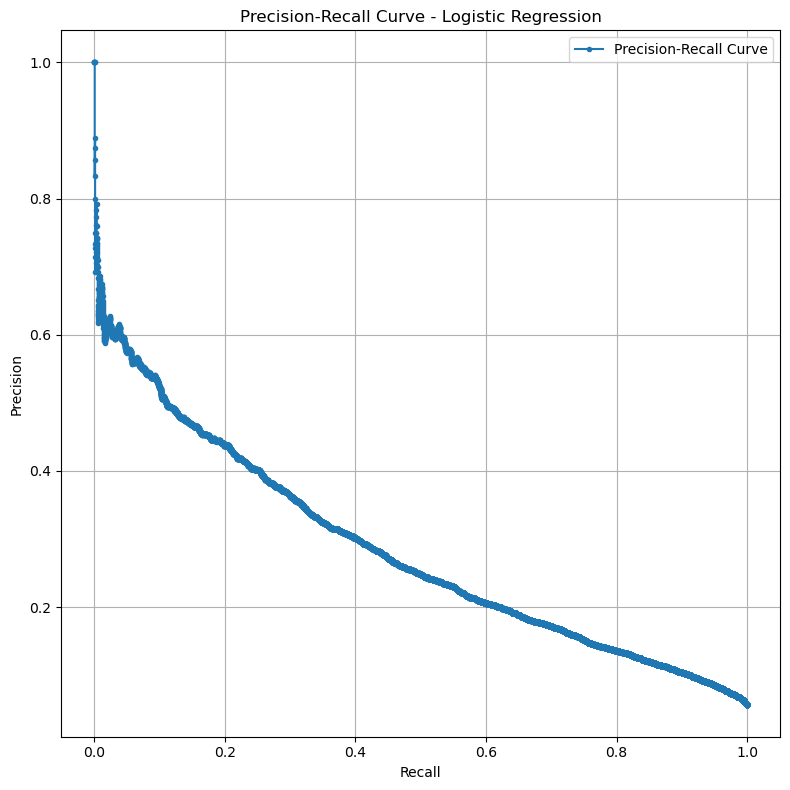

Plot Calibration Curve


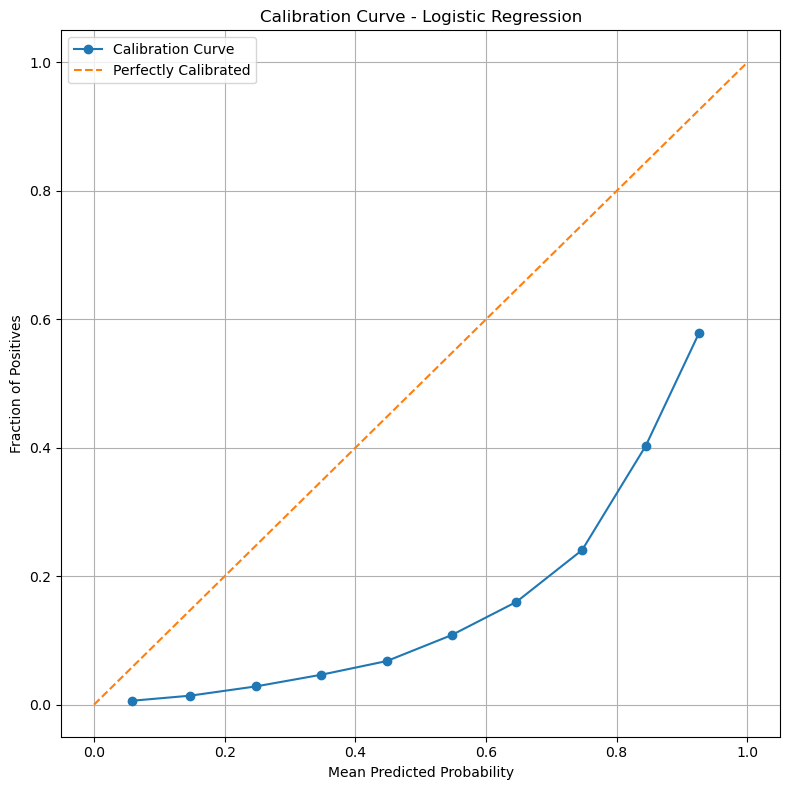

feature  importance_mean  importance_std
6                   HadAngina         0.132662        0.001020
40                AgeGroupNum         0.082094        0.002277
34         PhysicalHealthDays         0.016647        0.001387
1                         Sex         0.015415        0.000989
21               SmokerStatus         0.014914        0.001007
2               GeneralHealth         0.014357        0.001372
23                  ChestScan         0.013651        0.001075
3             LastCheckupTime         0.008374        0.000717
5                RemovedTeeth         0.006886        0.001250
35           MentalHealthDays         0.005911        0.000631
26            AlcoholDrinkers         0.005123        0.001185
7                   HadStroke         0.004514        0.000160
4          PhysicalActivities         0.002260        0.000326
36                 SleepHours         0.001635        0.000290
37             HeightInMeters         0.001127        0.000399
28               FluVaxLast12         0.000719        0.000226
0                       State         0.000357        0.000567
39                        BMI         0.000334        0.000243
33               BMI_Category         0.000161        0.000131
14                HadDiabetes         0.000134        0.000203
38          WeightInKilograms         0.000015        0.000169
29              PneumoVaxEver        -0.000018        0.000082
31           HighRiskLastYear        -0.000082        0.000077
13               HadArthritis        -0.000251        0.000125
24      RaceEthnicityCategory        -0.000270        0.000644
32                   CovidPos        -0.000322        0.001458
22            ECigaretteUsage        -0.000374        0.000842
25                AgeCategory        -0.000378        0.000256
18          DifficultyWalking        -0.000515        0.000151
19  DifficultyDressingBathing        -0.000756        0.000134
20          DifficultyErrands        -0.001107        0.000241
10                    HadCOPD        -0.001148        0.000127
9               HadSkinCancer        -0.001151        0.000636
30          TetanusLast10Tdap        -0.001344        0.001530
12           HadKidneyDisease        -0.001598        0.000202
17    DifficultyConcentrating        -0.001764        0.000371
8                   HadAsthma        -0.001770        0.000319
16    BlindOrVisionDifficulty        -0.001812        0.000277
15        DeafOrHardOfHearing        -0.001861        0.000420
11      HadDepressiveDisorder        -0.002332        0.000456
27                 HIVTesting        -0.003547        0.000748

Plot Permutation Importance


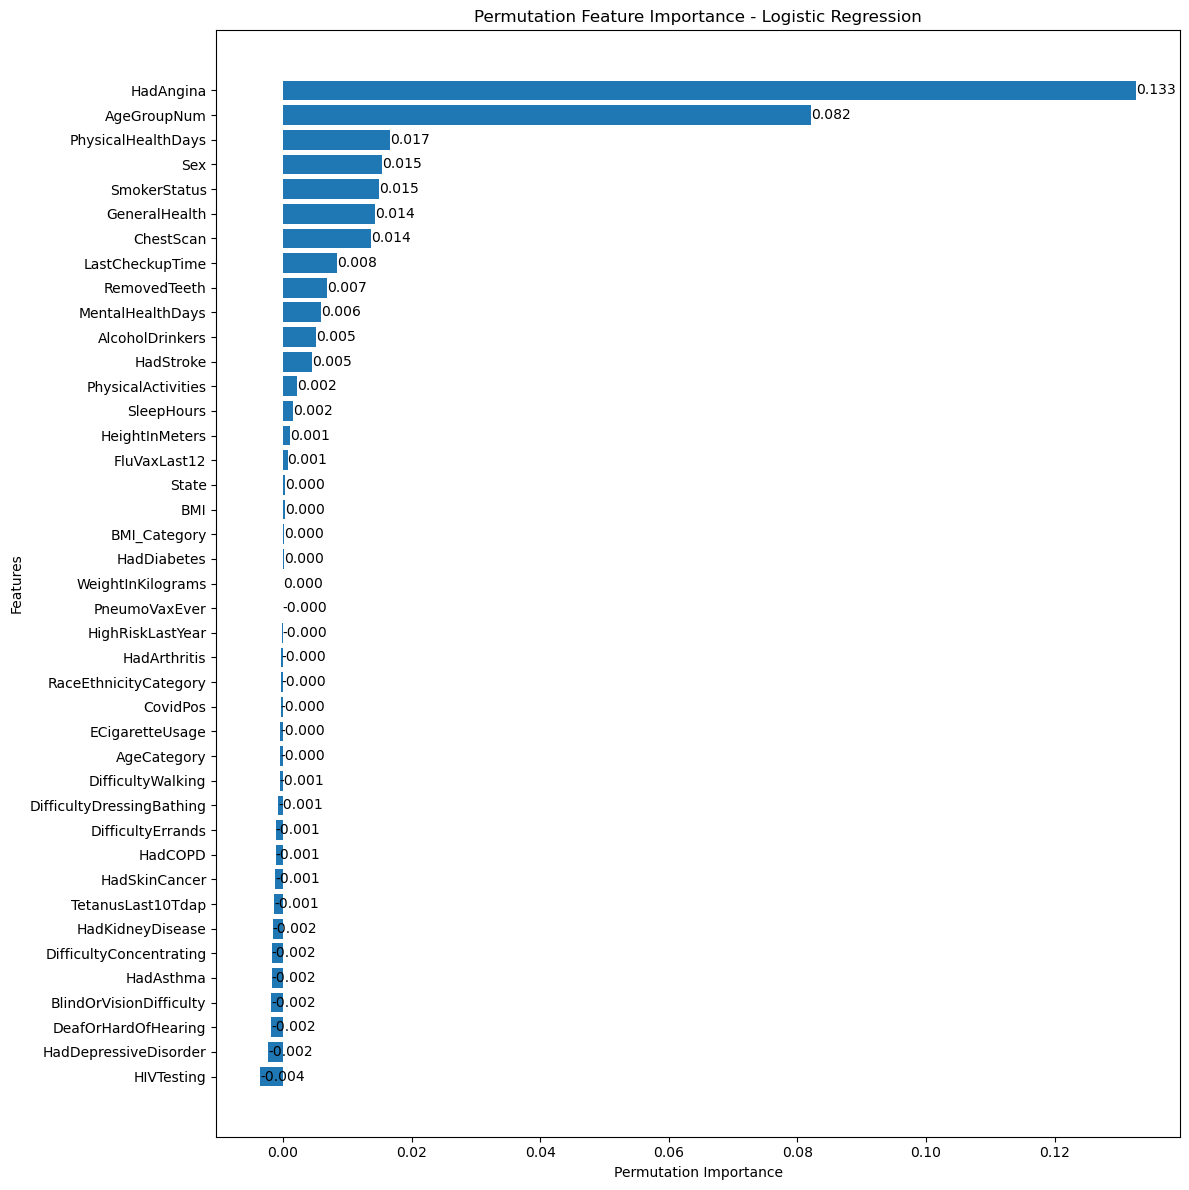

In [20]:
# Define optuna objective
def logistic_objective(trial):
    params = {
        # C stand for inverse of the regularization strength
        'C': trial.suggest_float('C', 1e-4, 1e4, log=True),
        # Determine what kinds of regularization algorithm to be applied
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        # Algorithm to find best coefficients.
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga', 'lbfgs', 'sag', 'newton-cg']),
        # Mitigate effects of imbalanced data
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }

    # Logisitic Regression doen not allow certain combination of penalty methods and
    # solvers. When encounter such combinations, tell optuna to skip this trials
    if (params['penalty'] == 'l1' and params['solver'] not in ['liblinear', 'saga']) or (
        params['penalty'] == 'l2' and params['solver'] not in [
            'liblinear', 'saga', 'lbfgs', 'sag', 'newton-cg']
    ):
        raise optuna.exceptions.TrialPruned()

    # Instantiate logistic model
    logistic_model = LogisticRegression(
        **params,
        random_state=seed,
        max_iter=1000,
    )
    logistic_model.fit(X_train_dummies, y_train)

    proba = logistic_model.predict_proba(X_validation_dummies)[:, 1]
    score = average_precision_score(y_validation, proba)
    return score


# Define wrap logistic model with data preprocess for permutation importance
class wrap_logistic(ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = model.classes_

    def fit(self, X_test, y=None):
        return self

    def predict_proba(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict_proba(X_test_permutation)

    def predict(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict(X_test_permutation)


# Define optuna study object, and direction is to maximize area under PR-Curve.
# Evaluated on validation set.
output_seperate('Searching Hyperparameters')
logistic_study = optuna.create_study(direction='maximize', sampler=sampler)
logistic_study.optimize(logistic_objective, n_trials=n_trials)

output_seperate('Train model with best hyperparameters...')
# Train model with best hyperparameters and calculate results on test set.
logistic_model = LogisticRegression(**logistic_study.best_params,
                                    random_state=seed,
                                    max_iter=1000,
                                    )
logistic_model.fit(X_train_dummies, y_train)
logistic_pred = logistic_model.predict(X_test_dummies)
logistic_proba = logistic_model.predict_proba(X_test_dummies)[:, 1]
logistic_score = average_precision_score(y_test, logistic_proba)
logistic_results = output_results(
    logistic_score, logistic_study, y_test, logistic_pred, logistic_proba)
# Show coefficients founded
output_seperate('Coefficient - Logistic Regression')
coef = pd.DataFrame(data=logistic_model.coef_.T,
                    index=dummies_col_names, columns=['Coefficient'])
display(coef.sort_values('Coefficient', ascending=False))
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test,
                 logistic_proba, 'Logistic Regression')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test,
                 logistic_proba, 'Logistic Regression')
wrapped_logistic = wrap_logistic(logistic_model)
logistic_important_df = calculate_permutation_importance(
    wrapped_logistic, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance, (12, 12),
                 logistic_important_df, 'Logistic Regression')

## 6.3. LightGBM


Searching Hyperparameters


[I 2025-04-13 16:28:16,295] A new study created in memory with name: no-name-c953ce56-d46b-446f-a643-ab98533bf06e


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:17,435] Trial 0 finished with value: 0.3041017490044116 and parameters: {'n_estimators': 11957, 'learning_rate': 0.021936895955419825, 'max_depth': 9, 'num_leaves': 106, 'min_child_samples': 18, 'subsample': 0.5110330248932573, 'colsample_bytree': 0.7282554824061971, 'reg_alpha': 4.125147530975503e-05, 'reg_lambda': 6.167783891050439, 'pos_weight': 9.712477200078323}. Best is trial 0 with value: 0.3041017490044116.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.304102	valid_0's binary_logloss: 0.698476
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:18,626] Trial 1 finished with value: 0.33591732350220127 and parameters: {'n_estimators': 15386, 'learning_rate': 0.01525630293674139, 'max_depth': 14, 'num_leaves': 114, 'min_child_samples': 10, 'subsample': 0.9792474334349497, 'colsample_bytree': 0.599305161764144, 'reg_alpha': 2.65933947919664, 'reg_lambda': 1.0901131957110004e-08, 'pos_weight': 0.3068854071246792}. Best is trial 1 with value: 0.33591732350220127.


Early stopping, best iteration is:
[10]	valid_0's average_precision: 0.335917	valid_0's binary_logloss: 0.60026
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:20,134] Trial 2 finished with value: 0.33978042762446836 and parameters: {'n_estimators': 6191, 'learning_rate': 0.06867176171728802, 'max_depth': 11, 'num_leaves': 119, 'min_child_samples': 26, 'subsample': 0.8943032054410429, 'colsample_bytree': 0.8734971691018263, 'reg_alpha': 2.3138983394882494e-05, 'reg_lambda': 0.00023718121342309535, 'pos_weight': 2.5102307766652148}. Best is trial 2 with value: 0.33978042762446836.


Early stopping, best iteration is:
[34]	valid_0's average_precision: 0.33978	valid_0's binary_logloss: 0.482637
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:22,627] Trial 3 finished with value: 0.341858408202513 and parameters: {'n_estimators': 6669, 'learning_rate': 0.01935229957903338, 'max_depth': 26, 'num_leaves': 121, 'min_child_samples': 32, 'subsample': 0.5491150986185, 'colsample_bytree': 0.9873519401722483, 'reg_alpha': 1.8301028252195082e-06, 'reg_lambda': 0.0008165631312128769, 'pos_weight': 2.2649078380203536}. Best is trial 3 with value: 0.341858408202513.


Early stopping, best iteration is:
[48]	valid_0's average_precision: 0.341858	valid_0's binary_logloss: 0.535024
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:23,683] Trial 4 finished with value: 0.31115209640537234 and parameters: {'n_estimators': 7001, 'learning_rate': 0.04162956862402472, 'max_depth': 30, 'num_leaves': 128, 'min_child_samples': 22, 'subsample': 0.9782735959305433, 'colsample_bytree': 0.6967806181489811, 'reg_alpha': 0.09600326902403586, 'reg_lambda': 0.18172864847583461, 'pos_weight': 9.291990104127962}. Best is trial 3 with value: 0.341858408202513.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.311152	valid_0's binary_logloss: 0.698389
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:27,725] Trial 5 finished with value: 0.3604881120233412 and parameters: {'n_estimators': 6924, 'learning_rate': 0.06526894855549809, 'max_depth': 26, 'num_leaves': 145, 'min_child_samples': 11, 'subsample': 0.595653544154967, 'colsample_bytree': 0.9805929556171984, 'reg_alpha': 0.008226871259966205, 'reg_lambda': 2.415716514030086, 'pos_weight': 3.198171812731262}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[203]	valid_0's average_precision: 0.360488	valid_0's binary_logloss: 0.212437
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:28,844] Trial 6 finished with value: 0.2841762082627266 and parameters: {'n_estimators': 10092, 'learning_rate': 0.018534305503761138, 'max_depth': 7, 'num_leaves': 72, 'min_child_samples': 16, 'subsample': 0.6183929894359687, 'colsample_bytree': 0.7732904176588946, 'reg_alpha': 0.006519855031360676, 'reg_lambda': 5.95928047501825, 'pos_weight': 7.668338049135917}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.284176	valid_0's binary_logloss: 0.697936
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:29,730] Trial 7 finished with value: 0.3049902366752286 and parameters: {'n_estimators': 6682, 'learning_rate': 0.06176257598559333, 'max_depth': 11, 'num_leaves': 43, 'min_child_samples': 44, 'subsample': 0.7399489764154026, 'colsample_bytree': 0.9931674017616874, 'reg_alpha': 1.2803024236341942e-08, 'reg_lambda': 0.0007022845550453344, 'pos_weight': 9.979449938314744}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.30499	valid_0's binary_logloss: 0.70546
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:34,065] Trial 8 finished with value: 0.3574192492633105 and parameters: {'n_estimators': 12717, 'learning_rate': 0.07541448142760189, 'max_depth': 12, 'num_leaves': 115, 'min_child_samples': 27, 'subsample': 0.8621011623195498, 'colsample_bytree': 0.8215086343672195, 'reg_alpha': 3.178500885187852e-08, 'reg_lambda': 4.260755094680031, 'pos_weight': 4.334208283047629}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[300]	valid_0's average_precision: 0.357419	valid_0's binary_logloss: 0.240009
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:35,518] Trial 9 finished with value: 0.2900054265557395 and parameters: {'n_estimators': 6250, 'learning_rate': 0.05052665797689063, 'max_depth': 8, 'num_leaves': 143, 'min_child_samples': 13, 'subsample': 0.7492780969709334, 'colsample_bytree': 0.5126178454850334, 'reg_alpha': 2.4500798743846562e-05, 'reg_lambda': 0.12575357847470803, 'pos_weight': 7.890576656019242}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.290005	valid_0's binary_logloss: 0.705208
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:36,345] Trial 10 finished with value: 0.2990818921101688 and parameters: {'n_estimators': 984, 'learning_rate': 0.03367993710149549, 'max_depth': 22, 'num_leaves': 20, 'min_child_samples': 6, 'subsample': 0.6489421139156842, 'colsample_bytree': 0.9044738399629577, 'reg_alpha': 0.004840036824920579, 'reg_lambda': 1.6382391536892774e-06, 'pos_weight': 5.27877010850554}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.299082	valid_0's binary_logloss: 0.699827
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:39,210] Trial 11 finished with value: 0.35732625775277793 and parameters: {'n_estimators': 18262, 'learning_rate': 0.09788091935286757, 'max_depth': 18, 'num_leaves': 149, 'min_child_samples': 37, 'subsample': 0.8416124053460612, 'colsample_bytree': 0.8666151640266968, 'reg_alpha': 1.284839022147652e-07, 'reg_lambda': 0.07972062198398075, 'pos_weight': 4.469039888042246}. Best is trial 5 with value: 0.3604881120233412.


Early stopping, best iteration is:
[145]	valid_0's average_precision: 0.357326	valid_0's binary_logloss: 0.246711
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:41,998] Trial 12 finished with value: 0.36688224730592905 and parameters: {'n_estimators': 13331, 'learning_rate': 0.09738619318375756, 'max_depth': 19, 'num_leaves': 87, 'min_child_samples': 46, 'subsample': 0.8445902284341672, 'colsample_bytree': 0.8010481939298615, 'reg_alpha': 0.0010067070195852767, 'reg_lambda': 9.691709947050345, 'pos_weight': 4.622332550334392}. Best is trial 12 with value: 0.36688224730592905.


Early stopping, best iteration is:
[158]	valid_0's average_precision: 0.366882	valid_0's binary_logloss: 0.25667
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:44,729] Trial 13 finished with value: 0.36602386197182446 and parameters: {'n_estimators': 2524, 'learning_rate': 0.09826106134744862, 'max_depth': 21, 'num_leaves': 79, 'min_child_samples': 49, 'subsample': 0.6733578206102047, 'colsample_bytree': 0.675416244547318, 'reg_alpha': 0.00476016920305389, 'reg_lambda': 0.015912369370614715, 'pos_weight': 5.908003041177824}. Best is trial 12 with value: 0.36688224730592905.


Early stopping, best iteration is:
[142]	valid_0's average_precision: 0.366024	valid_0's binary_logloss: 0.292975
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:45,976] Trial 14 finished with value: 0.3101373141357896 and parameters: {'n_estimators': 301, 'learning_rate': 0.01059962500926425, 'max_depth': 19, 'num_leaves': 83, 'min_child_samples': 50, 'subsample': 0.6876863816118144, 'colsample_bytree': 0.6498728832913, 'reg_alpha': 0.0006071329995411911, 'reg_lambda': 0.010118677786985397, 'pos_weight': 6.239454822990515}. Best is trial 12 with value: 0.36688224730592905.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.310137	valid_0's binary_logloss: 0.694082
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:49,561] Trial 15 finished with value: 0.3705359092910386 and parameters: {'n_estimators': 2774, 'learning_rate': 0.0786332944695579, 'max_depth': 22, 'num_leaves': 65, 'min_child_samples': 49, 'subsample': 0.8095223159004326, 'colsample_bytree': 0.5972538118795192, 'reg_alpha': 0.3059733688322757, 'reg_lambda': 3.284601739566397e-06, 'pos_weight': 6.218381735845424}. Best is trial 15 with value: 0.3705359092910386.


Early stopping, best iteration is:
[260]	valid_0's average_precision: 0.370536	valid_0's binary_logloss: 0.283091
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:50,744] Trial 16 finished with value: 0.3076620240604687 and parameters: {'n_estimators': 15266, 'learning_rate': 0.04602595550377977, 'max_depth': 15, 'num_leaves': 60, 'min_child_samples': 41, 'subsample': 0.8127803124816833, 'colsample_bytree': 0.5403801015278881, 'reg_alpha': 1.918292963355201, 'reg_lambda': 2.308928612936796e-06, 'pos_weight': 7.109136358494936}. Best is trial 15 with value: 0.3705359092910386.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.307662	valid_0's binary_logloss: 0.701702
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:51,762] Trial 17 finished with value: 0.33167974055366795 and parameters: {'n_estimators': 3431, 'learning_rate': 0.02908830759953825, 'max_depth': 24, 'num_leaves': 97, 'min_child_samples': 36, 'subsample': 0.9284957156040923, 'colsample_bytree': 0.6032963225140723, 'reg_alpha': 0.20242593451665475, 'reg_lambda': 6.0105002730187126e-06, 'pos_weight': 3.743869860250277}. Best is trial 15 with value: 0.3705359092910386.


Early stopping, best iteration is:
[3]	valid_0's average_precision: 0.33168	valid_0's binary_logloss: 0.68395
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:52,843] Trial 18 finished with value: 0.33865737199145274 and parameters: {'n_estimators': 19591, 'learning_rate': 0.08523849822711457, 'max_depth': 29, 'num_leaves': 55, 'min_child_samples': 44, 'subsample': 0.77400001297065, 'colsample_bytree': 0.7807467059525269, 'reg_alpha': 0.29340576308018507, 'reg_lambda': 6.451432547243308e-08, 'pos_weight': 0.49782577899999136}. Best is trial 15 with value: 0.3705359092910386.


Early stopping, best iteration is:
[19]	valid_0's average_precision: 0.338657	valid_0's binary_logloss: 0.300573
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:53,845] Trial 19 finished with value: 0.3058413981222985 and parameters: {'n_estimators': 9821, 'learning_rate': 0.03485131255040064, 'max_depth': 16, 'num_leaves': 37, 'min_child_samples': 46, 'subsample': 0.7995051057190175, 'colsample_bytree': 0.6090116989687798, 'reg_alpha': 0.0005403494800370967, 'reg_lambda': 3.9989232666733345e-05, 'pos_weight': 6.578182099065816}. Best is trial 15 with value: 0.3705359092910386.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.305841	valid_0's binary_logloss: 0.699961
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:54,836] Trial 20 finished with value: 0.3118389404440418 and parameters: {'n_estimators': 15226, 'learning_rate': 0.054045356817301125, 'max_depth': 20, 'num_leaves': 93, 'min_child_samples': 37, 'subsample': 0.8991669777004277, 'colsample_bytree': 0.8095667439948564, 'reg_alpha': 0.03624786693368222, 'reg_lambda': 1.846844990429439e-07, 'pos_weight': 8.388490500438536}. Best is trial 15 with value: 0.3705359092910386.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.311839	valid_0's binary_logloss: 0.699642
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:28:57,873] Trial 21 finished with value: 0.37099077176434264 and parameters: {'n_estimators': 2591, 'learning_rate': 0.09437430834694677, 'max_depth': 22, 'num_leaves': 75, 'min_child_samples': 50, 'subsample': 0.6881426463112725, 'colsample_bytree': 0.6927477522881575, 'reg_alpha': 8.84667183506312, 'reg_lambda': 0.01296012080303103, 'pos_weight': 5.5206174590425885}. Best is trial 21 with value: 0.37099077176434264.


Early stopping, best iteration is:
[183]	valid_0's average_precision: 0.370991	valid_0's binary_logloss: 0.272965
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:00,784] Trial 22 finished with value: 0.3688729043810575 and parameters: {'n_estimators': 3612, 'learning_rate': 0.08177661721891723, 'max_depth': 23, 'num_leaves': 67, 'min_child_samples': 50, 'subsample': 0.7190331549946032, 'colsample_bytree': 0.7212702695628787, 'reg_alpha': 2.457991684269747, 'reg_lambda': 6.178851886236078e-05, 'pos_weight': 5.421017875701675}. Best is trial 21 with value: 0.37099077176434264.


Early stopping, best iteration is:
[186]	valid_0's average_precision: 0.368873	valid_0's binary_logloss: 0.278147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's average_precision: 0.373985	valid_0's binary_logloss: 0.255322


[I 2025-04-13 16:29:05,359] Trial 23 finished with value: 0.3739850164954864 and parameters: {'n_estimators': 3921, 'learning_rate': 0.07839481361052801, 'max_depth': 23, 'num_leaves': 65, 'min_child_samples': 50, 'subsample': 0.7127836836507093, 'colsample_bytree': 0.727302241864279, 'reg_alpha': 9.999937356517764, 'reg_lambda': 6.865774724740675e-05, 'pos_weight': 5.468856326227526}. Best is trial 23 with value: 0.3739850164954864.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:06,505] Trial 24 finished with value: 0.30623000560359426 and parameters: {'n_estimators': 4804, 'learning_rate': 0.05574250521293068, 'max_depth': 25, 'num_leaves': 48, 'min_child_samples': 41, 'subsample': 0.7006052931912737, 'colsample_bytree': 0.6553621969445065, 'reg_alpha': 6.1912045702335625, 'reg_lambda': 2.4037606283170675e-05, 'pos_weight': 6.768112200759356}. Best is trial 23 with value: 0.3739850164954864.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.30623	valid_0's binary_logloss: 0.703079
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:09,636] Trial 25 finished with value: 0.37502825001714346 and parameters: {'n_estimators': 1372, 'learning_rate': 0.08037611621591167, 'max_depth': 22, 'num_leaves': 71, 'min_child_samples': 33, 'subsample': 0.7853649922248751, 'colsample_bytree': 0.552510927939077, 'reg_alpha': 9.883911425147067, 'reg_lambda': 0.0028735821885471262, 'pos_weight': 5.92301939961169}. Best is trial 25 with value: 0.37502825001714346.


Early stopping, best iteration is:
[192]	valid_0's average_precision: 0.375028	valid_0's binary_logloss: 0.291298
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:13,876] Trial 26 finished with value: 0.3748580850918705 and parameters: {'n_estimators': 1840, 'learning_rate': 0.06490764605882851, 'max_depth': 27, 'num_leaves': 77, 'min_child_samples': 32, 'subsample': 0.648768267902619, 'colsample_bytree': 0.5713025049394714, 'reg_alpha': 8.381092229178421, 'reg_lambda': 0.004749385497390868, 'pos_weight': 5.481241698823121}. Best is trial 25 with value: 0.37502825001714346.


Early stopping, best iteration is:
[259]	valid_0's average_precision: 0.374858	valid_0's binary_logloss: 0.268274
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:16,070] Trial 27 finished with value: 0.3562234610353799 and parameters: {'n_estimators': 1305, 'learning_rate': 0.041254571928168116, 'max_depth': 28, 'num_leaves': 32, 'min_child_samples': 31, 'subsample': 0.6330136447474084, 'colsample_bytree': 0.548884356667855, 'reg_alpha': 0.9342716755022407, 'reg_lambda': 0.003119664192080104, 'pos_weight': 3.1670639301914587}. Best is trial 25 with value: 0.37502825001714346.


Early stopping, best iteration is:
[107]	valid_0's average_precision: 0.356223	valid_0's binary_logloss: 0.420031
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:19,914] Trial 28 finished with value: 0.37648618036554615 and parameters: {'n_estimators': 8409, 'learning_rate': 0.06580971206721849, 'max_depth': 27, 'num_leaves': 55, 'min_child_samples': 32, 'subsample': 0.6091335500061033, 'colsample_bytree': 0.5061206302018516, 'reg_alpha': 0.714470543743254, 'reg_lambda': 0.0001852478859873905, 'pos_weight': 7.279154881311867}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[246]	valid_0's average_precision: 0.376486	valid_0's binary_logloss: 0.320124
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:21,277] Trial 29 finished with value: 0.3073534752116581 and parameters: {'n_estimators': 9573, 'learning_rate': 0.05840216415794989, 'max_depth': 28, 'num_leaves': 54, 'min_child_samples': 22, 'subsample': 0.5110672953736739, 'colsample_bytree': 0.5017382496524394, 'reg_alpha': 0.875027225005239, 'reg_lambda': 0.002777708195740429, 'pos_weight': 8.93326084171169}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.307353	valid_0's binary_logloss: 0.706715
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:22,592] Trial 30 finished with value: 0.31374813310414257 and parameters: {'n_estimators': 5023, 'learning_rate': 0.02422402956734127, 'max_depth': 26, 'num_leaves': 98, 'min_child_samples': 32, 'subsample': 0.5737354706305349, 'colsample_bytree': 0.5582353442809578, 'reg_alpha': 0.056429200296465844, 'reg_lambda': 0.6338546986668434, 'pos_weight': 7.351682405328011}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.313748	valid_0's binary_logloss: 0.695949
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:27,350] Trial 31 finished with value: 0.3726707251362541 and parameters: {'n_estimators': 4668, 'learning_rate': 0.07037402844681134, 'max_depth': 27, 'num_leaves': 68, 'min_child_samples': 23, 'subsample': 0.6575035007537477, 'colsample_bytree': 0.5677898503352932, 'reg_alpha': 7.180310231846069, 'reg_lambda': 0.0002037048933635994, 'pos_weight': 5.107595853802357}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[309]	valid_0's average_precision: 0.372671	valid_0's binary_logloss: 0.252734
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:28,662] Trial 32 finished with value: 0.30772331318550405 and parameters: {'n_estimators': 1756, 'learning_rate': 0.04845007536207564, 'max_depth': 24, 'num_leaves': 59, 'min_child_samples': 30, 'subsample': 0.6040827856353836, 'colsample_bytree': 0.5228329357175839, 'reg_alpha': 0.8771957024436686, 'reg_lambda': 0.0016545159045950135, 'pos_weight': 8.48932768940648}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.307723	valid_0's binary_logloss: 0.703229
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:31,815] Trial 33 finished with value: 0.37402917270019165 and parameters: {'n_estimators': 8725, 'learning_rate': 0.06741064761607386, 'max_depth': 30, 'num_leaves': 86, 'min_child_samples': 36, 'subsample': 0.729541159779113, 'colsample_bytree': 0.6353934133971938, 'reg_alpha': 9.407712915815774, 'reg_lambda': 0.0002348478837326754, 'pos_weight': 5.77643982944633}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[191]	valid_0's average_precision: 0.374029	valid_0's binary_logloss: 0.285982
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:35,792] Trial 34 finished with value: 0.3757415530837331 and parameters: {'n_estimators': 8450, 'learning_rate': 0.06521468808366994, 'max_depth': 30, 'num_leaves': 107, 'min_child_samples': 35, 'subsample': 0.5444610583996761, 'colsample_bytree': 0.6266556578082237, 'reg_alpha': 1.4508178639126577, 'reg_lambda': 0.00029778495633316483, 'pos_weight': 6.814091819381794}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[252]	valid_0's average_precision: 0.375742	valid_0's binary_logloss: 0.286364
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:37,029] Trial 35 finished with value: 0.3135623149705292 and parameters: {'n_estimators': 8731, 'learning_rate': 0.041010608511649414, 'max_depth': 28, 'num_leaves': 105, 'min_child_samples': 34, 'subsample': 0.5408663494459824, 'colsample_bytree': 0.5771609089611819, 'reg_alpha': 0.023566091256267685, 'reg_lambda': 0.03008777313434595, 'pos_weight': 6.91119848775639}. Best is trial 28 with value: 0.37648618036554615.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.313562	valid_0's binary_logloss: 0.697806
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:40,684] Trial 36 finished with value: 0.37772462365578635 and parameters: {'n_estimators': 11264, 'learning_rate': 0.06168670200816118, 'max_depth': 30, 'num_leaves': 105, 'min_child_samples': 28, 'subsample': 0.5707556467324868, 'colsample_bytree': 0.6265370219459241, 'reg_alpha': 1.7306755952064374, 'reg_lambda': 0.0006472436272383553, 'pos_weight': 8.007573928975924}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[209]	valid_0's average_precision: 0.377725	valid_0's binary_logloss: 0.326489
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:44,283] Trial 37 finished with value: 0.3755287794701399 and parameters: {'n_estimators': 11361, 'learning_rate': 0.05793391768684046, 'max_depth': 30, 'num_leaves': 128, 'min_child_samples': 25, 'subsample': 0.5204120631391509, 'colsample_bytree': 0.6250394974522766, 'reg_alpha': 0.00011736154628058447, 'reg_lambda': 0.00055207178316862, 'pos_weight': 7.9662942761722295}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[187]	valid_0's average_precision: 0.375529	valid_0's binary_logloss: 0.332759
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:45,441] Trial 38 finished with value: 0.3140755698588376 and parameters: {'n_estimators': 11255, 'learning_rate': 0.03848648307161642, 'max_depth': 30, 'num_leaves': 132, 'min_child_samples': 25, 'subsample': 0.5181118036516519, 'colsample_bytree': 0.6387104721802198, 'reg_alpha': 3.924928350082017e-06, 'reg_lambda': 0.0007170039252434027, 'pos_weight': 9.33927599026065}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.314076	valid_0's binary_logloss: 0.698099
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:46,613] Trial 39 finished with value: 0.31477266970820705 and parameters: {'n_estimators': 11619, 'learning_rate': 0.04654701806486069, 'max_depth': 30, 'num_leaves': 124, 'min_child_samples': 18, 'subsample': 0.5680331730454645, 'colsample_bytree': 0.617806503902515, 'reg_alpha': 8.181185048349595e-05, 'reg_lambda': 1.5918264334161997e-05, 'pos_weight': 8.026713176063792}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.314773	valid_0's binary_logloss: 0.698056
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:49,760] Trial 40 finished with value: 0.3748776855704702 and parameters: {'n_estimators': 7824, 'learning_rate': 0.0591299526944964, 'max_depth': 29, 'num_leaves': 106, 'min_child_samples': 29, 'subsample': 0.5432491848601491, 'colsample_bytree': 0.6817543831503601, 'reg_alpha': 0.000155689105135976, 'reg_lambda': 0.00047092017265849834, 'pos_weight': 7.555769572377955}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[189]	valid_0's average_precision: 0.374878	valid_0's binary_logloss: 0.330917
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:50,760] Trial 41 finished with value: 0.292277760512163 and parameters: {'n_estimators': 13885, 'learning_rate': 0.07187305273927741, 'max_depth': 5, 'num_leaves': 134, 'min_child_samples': 25, 'subsample': 0.5031829185180067, 'colsample_bytree': 0.5874159035427624, 'reg_alpha': 5.922054400140544e-06, 'reg_lambda': 0.00013650691699861235, 'pos_weight': 8.258752171708776}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.292278	valid_0's binary_logloss: 0.719582
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:53,949] Trial 42 finished with value: 0.3715438043168184 and parameters: {'n_estimators': 11153, 'learning_rate': 0.08467445435632173, 'max_depth': 26, 'num_leaves': 112, 'min_child_samples': 19, 'subsample': 0.5726039348027196, 'colsample_bytree': 0.5239806669715238, 'reg_alpha': 0.1351323047623625, 'reg_lambda': 0.0013516876860605012, 'pos_weight': 8.849792261783028}. Best is trial 36 with value: 0.37772462365578635.


Early stopping, best iteration is:
[169]	valid_0's average_precision: 0.371544	valid_0's binary_logloss: 0.336227
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:29:58,075] Trial 43 finished with value: 0.37895451249016626 and parameters: {'n_estimators': 12482, 'learning_rate': 0.054412472071423384, 'max_depth': 29, 'num_leaves': 113, 'min_child_samples': 28, 'subsample': 0.5941466751329497, 'colsample_bytree': 0.6223390450095374, 'reg_alpha': 1.949234639978758, 'reg_lambda': 0.0003977073378743687, 'pos_weight': 7.257181778858737}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[259]	valid_0's average_precision: 0.378955	valid_0's binary_logloss: 0.30138
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:30:01,318] Trial 44 finished with value: 0.374558186346459 and parameters: {'n_estimators': 10649, 'learning_rate': 0.05230637798852569, 'max_depth': 29, 'num_leaves': 116, 'min_child_samples': 28, 'subsample': 0.5929873044190636, 'colsample_bytree': 0.6623168415279322, 'reg_alpha': 0.01307955271693123, 'reg_lambda': 1.006295907336759e-05, 'pos_weight': 7.650133955188324}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[184]	valid_0's average_precision: 0.374558	valid_0's binary_logloss: 0.346752
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:30:02,496] Trial 45 finished with value: 0.3132082054674351 and parameters: {'n_estimators': 12655, 'learning_rate': 0.06166564469519416, 'max_depth': 27, 'num_leaves': 123, 'min_child_samples': 27, 'subsample': 0.5293437253192448, 'colsample_bytree': 0.7111324355026618, 'reg_alpha': 0.6380257278359026, 'reg_lambda': 0.00012233936277685663, 'pos_weight': 9.596287630579761}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.313208	valid_0's binary_logloss: 0.701429
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:30:03,520] Trial 46 finished with value: 0.3130920553114529 and parameters: {'n_estimators': 7927, 'learning_rate': 0.04572779514665248, 'max_depth': 30, 'num_leaves': 138, 'min_child_samples': 20, 'subsample': 0.615255166842121, 'colsample_bytree': 0.7490099536510635, 'reg_alpha': 0.11808125292055892, 'reg_lambda': 0.0005438266648557515, 'pos_weight': 8.76283717253552}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.313092	valid_0's binary_logloss: 0.697448
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:30:06,581] Trial 47 finished with value: 0.3763105433935532 and parameters: {'n_estimators': 14010, 'learning_rate': 0.06571277339578906, 'max_depth': 28, 'num_leaves': 109, 'min_child_samples': 16, 'subsample': 0.5543951674129506, 'colsample_bytree': 0.6308794486289685, 'reg_alpha': 0.0015220886751980982, 'reg_lambda': 0.04758306448069352, 'pos_weight': 7.317954692675848}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[185]	valid_0's average_precision: 0.376311	valid_0's binary_logloss: 0.317037
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:30:07,691] Trial 48 finished with value: 0.31345947174908034 and parameters: {'n_estimators': 16485, 'learning_rate': 0.01393525127620127, 'max_depth': 25, 'num_leaves': 112, 'min_child_samples': 15, 'subsample': 0.5632114074965114, 'colsample_bytree': 0.664793856041583, 'reg_alpha': 0.0014822221588773193, 'reg_lambda': 0.040177746349258615, 'pos_weight': 6.509379111033719}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.313459	valid_0's binary_logloss: 0.694116
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 16:30:10,858] Trial 49 finished with value: 0.3740365592585887 and parameters: {'n_estimators': 13934, 'learning_rate': 0.07057103790034816, 'max_depth': 28, 'num_leaves': 101, 'min_child_samples': 7, 'subsample': 0.5900109054776778, 'colsample_bytree': 0.7477825412514422, 'reg_alpha': 2.1637547632595644, 'reg_lambda': 0.377448142052772, 'pos_weight': 7.209752427020209}. Best is trial 43 with value: 0.37895451249016626.


Early stopping, best iteration is:
[195]	valid_0's average_precision: 0.374037	valid_0's binary_logloss: 0.307635
Train model with best hyperparameters...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[68]	valid_0's average_precision: 0.349502	valid_0's binary_logloss: 0.226211
Best Hyperparameters:


{'n_estimators': 12482,
 'learning_rate': 0.054412472071423384,
 'max_depth': 29,
 'num_leaves': 113,
 'min_child_samples': 28,
 'subsample': 0.5941466751329497,
 'colsample_bytree': 0.6223390450095374,
 'reg_alpha': 1.949234639978758,
 'reg_lambda': 0.0003977073378743687,
 'pos_weight': 7.257181778858737}

Results


0
PR AUC     0.342687
ROC AUC    0.853125
F1 Score   0.431669
Precision  0.397884
Recall     0.471724

Plot Precision-Recall Curve


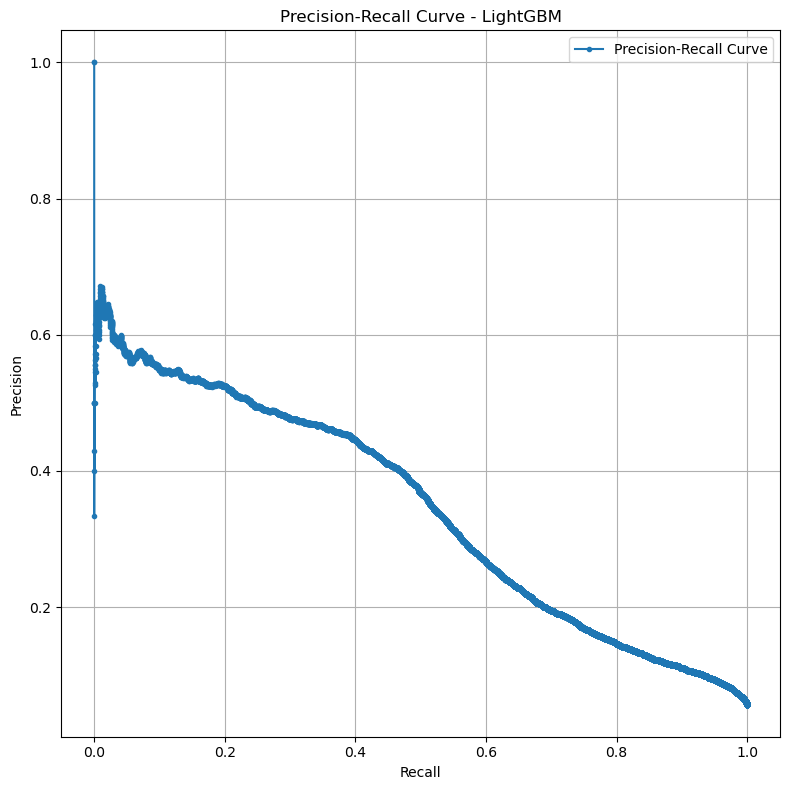

Plot Calibration Curve


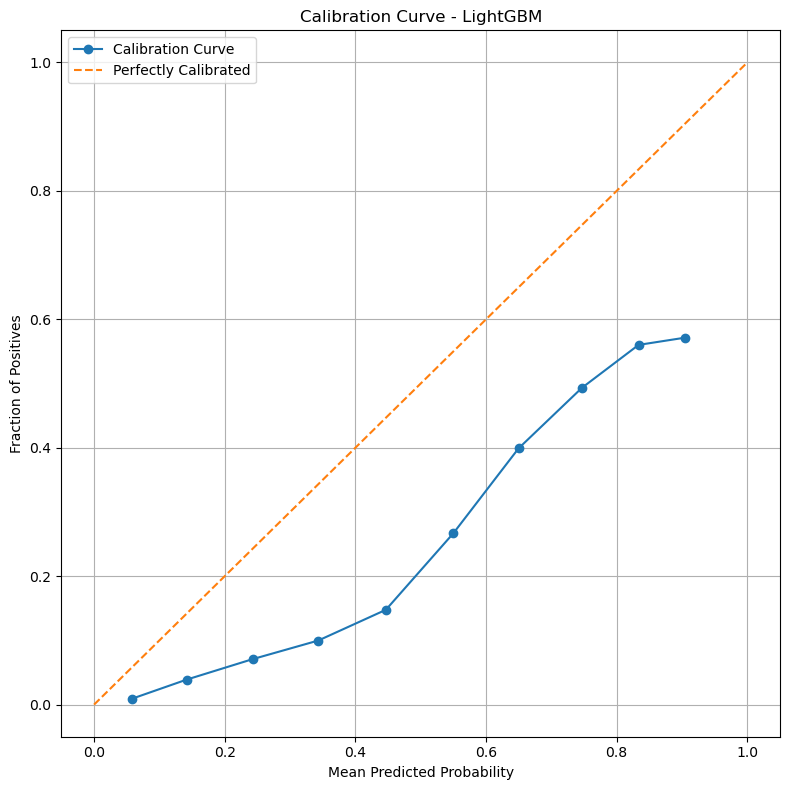

feature  importance_mean  importance_std
6                   HadAngina     2.202510e-01        0.001137
40                AgeGroupNum     2.699533e-02        0.001795
21               SmokerStatus     1.683439e-02        0.001371
2               GeneralHealth     1.503220e-02        0.002088
25                AgeCategory     1.269030e-02        0.000614
34         PhysicalHealthDays     9.426815e-03        0.001476
37             HeightInMeters     6.831484e-03        0.001176
26            AlcoholDrinkers     5.149135e-03        0.000983
5                RemovedTeeth     3.979193e-03        0.001022
23                  ChestScan     2.333191e-03        0.000259
1                         Sex     1.428339e-03        0.000260
3             LastCheckupTime     1.201000e-03        0.000693
22            ECigaretteUsage     1.022791e-03        0.000590
7                   HadStroke     9.286230e-04        0.000066
32                   CovidPos     6.074082e-04        0.001272
24      RaceEthnicityCategory     3.698183e-04        0.000399
36                 SleepHours     3.650610e-04        0.000414
39                        BMI     3.378366e-04        0.000189
20          DifficultyErrands     3.127672e-04        0.000117
19  DifficultyDressingBathing     2.966226e-04        0.000058
13               HadArthritis     2.603744e-04        0.000265
18          DifficultyWalking     2.071483e-04        0.000105
4          PhysicalActivities     1.325862e-04        0.000626
14                HadDiabetes     1.167243e-04        0.000534
28               FluVaxLast12     1.001818e-04        0.000140
0                       State     4.047808e-05        0.002159
38          WeightInKilograms     3.988213e-07        0.000255
16    BlindOrVisionDifficulty    -8.291028e-06        0.000184
29              PneumoVaxEver    -2.493607e-05        0.000052
31           HighRiskLastYear    -3.054922e-05        0.000045
35           MentalHealthDays    -4.723552e-05        0.000257
33               BMI_Category    -4.951137e-05        0.000096
12           HadKidneyDisease    -1.288111e-04        0.000113
8                   HadAsthma    -1.471198e-04        0.000455
17    DifficultyConcentrating    -2.046490e-04        0.000268
15        DeafOrHardOfHearing    -2.934081e-04        0.000099
10                    HadCOPD    -3.443515e-04        0.000029
30          TetanusLast10Tdap    -4.698650e-04        0.001191
9               HadSkinCancer    -9.813269e-04        0.000778
11      HadDepressiveDisorder    -1.194109e-03        0.000359
27                 HIVTesting    -1.891400e-03        0.000305

Plot Permutation Importance


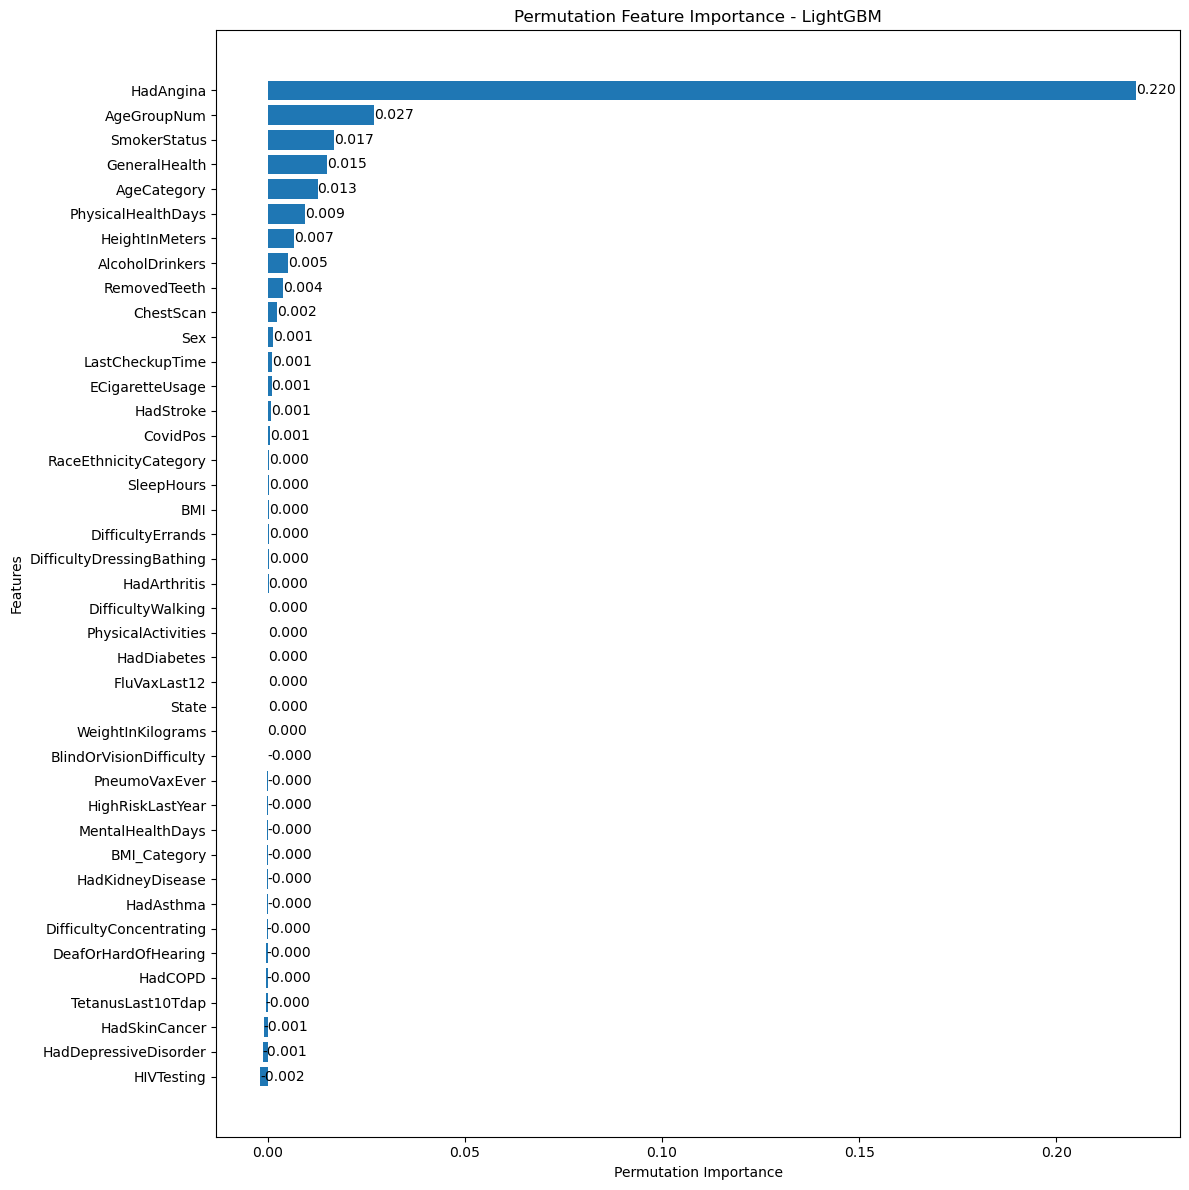

In [21]:
# Define optuna objective
def lgbm_objective(trial):
    # Define hyperparameter search space
    params = {
        # Trees that will be built
        'n_estimators': trial.suggest_int('n_estimators', 100, 20000),
        # It likes a step to move each time to find best model parameters (not hyperparameters)
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        # The maximum depth that tree will grow
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        # The maximum number of leaves for one tree
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        # The minimum number of number on one leaf.
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        # Determine the portion of train set be randomly selected and passed to each tree
        # to avoid overfitting.
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        # Determine the portion of features be passed to each tree to avoid overfitting.
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        # L1 Regularization. Avoid overfitting.
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        # L2 Regularization. Avoid overfitting.
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        # Scale_pos_weight for imbalanced target
        'scale_pos_weight': trial.suggest_float('pos_weight', 0.1, 10)
    }

    # Define model to be optimized
    lgbm_model = LGBMClassifier(
        **params,
        objective='binary',
        random_state=seed,
        verbose=-1)
    lgbm_model.fit(
        X_train_dummies, y_train,
        eval_set=[(X_validation_dummies, y_validation)],
        # Use Area Under Precision-Recall Curve to evaluate
        eval_metric='average_precision',
        # Configure a early stopping to save time and avoid overfitting
        callbacks=[early_stopping(stopping_rounds=50)]
    )

    # Define optuna evaluation matric, proba is predicted probabilities
    # for positive class. The evaluation matric is still area under PR-Curve
    # The 'average_precision_score' in scikit-learn is equivalent to
    # 'average_precision' in LGBM.
    proba = lgbm_model.predict_proba(X_validation_dummies)[:, 1]
    return average_precision_score(y_validation, proba)


# Wrap logistic model with data preprocess for permutation importance
class wrap_lgbm(ClassifierMixin):
    def __init__(self, model):
        self.model = model
        self.classes_ = model.classes_

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict_proba(X_test_permutation)

    def predict(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        return self.model.predict(X_test_permutation)


# Define optuna study object, and direction is to maximize area under PR-Curve
# Evaluated on validation set.
output_seperate('Searching Hyperparameters')
lgbm_study = optuna.create_study(direction='maximize', sampler=sampler)
lgbm_study.optimize(lgbm_objective, n_trials=n_trials)


# Use best hyperparameters to train model
output_seperate('Train model with best hyperparameters...')
lgbm_model = LGBMClassifier(
    **lgbm_study.best_params,
    objective='binary',
    random_state=seed
)
lgbm_model.fit(
    X_train_dummies, y_train,
    eval_set=[(X_validation_dummies, y_validation)],
    eval_metric='average_precision',
    callbacks=[early_stopping(stopping_rounds=50)]
)

# Using model to predict whether had having heart attack on test set.
lgbm_pred = lgbm_model.predict(X_test_dummies)
# Using model to generate probabilities for positive case on test set.
lgbm_proba = lgbm_model.predict_proba(X_test_dummies)[:, 1]
lgbm_score = average_precision_score(y_test, lgbm_proba)
lgbm_results = output_results(
    lgbm_score, lgbm_study, y_test, lgbm_pred, lgbm_proba)
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test, lgbm_proba, 'LightGBM')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test, lgbm_proba, 'LightGBM')
wrapped_lgbm = wrap_lgbm(lgbm_model)
lgbm_important_df = calculate_permutation_importance(wrapped_lgbm, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance, (12, 12),
                 lgbm_important_df, 'LightGBM')

## 6.4. MLP


Searching Hyperparameters


[I 2025-04-13 16:34:01,232] A new study created in memory with name: no-name-7e724b7b-2f00-4479-98d4-3f13431d72ba


Epoch 1, Loss: 2.8788, Score: 0.1833, 5.77
Epoch 2, Loss: 2.0844, Score: 0.1930, 5.62
Epoch 3, Loss: 1.6001, Score: 0.1908, 5.52
Epoch 4, Loss: 1.3106, Score: 0.1871, 5.66
Epoch 5, Loss: 1.1252, Score: 0.1874, 5.59
Epoch 6, Loss: 0.9974, Score: 0.1931, 5.71
Epoch 7, Loss: 0.9046, Score: 0.2020, 5.79
Epoch 8, Loss: 0.8320, Score: 0.2122, 5.92
Epoch 9, Loss: 0.7789, Score: 0.2209, 5.79
Epoch 10, Loss: 0.7365, Score: 0.2299, 5.76
Epoch 11, Loss: 0.6986, Score: 0.2359, 5.77
Epoch 12, Loss: 0.6694, Score: 0.2418, 5.92
Epoch 13, Loss: 0.6453, Score: 0.2459, 5.83
Epoch 14, Loss: 0.6255, Score: 0.2481, 5.74
Epoch 15, Loss: 0.6083, Score: 0.2520, 5.72
Epoch 16, Loss: 0.5931, Score: 0.2527, 5.77
Epoch 17, Loss: 0.5787, Score: 0.2530, 5.79
Epoch 18, Loss: 0.5669, Score: 0.2542, 5.91
Epoch 19, Loss: 0.5554, Score: 0.2542, 5.78
Epoch 20, Loss: 0.5460, Score: 0.2548, 5.68
Epoch 21, Loss: 0.5371, Score: 0.2541, 5.74
Epoch 22, Loss: 0.5301, Score: 0.2538, 5.92
Epoch 23, Loss: 0.5236, Score: 0.2523, 5.

[I 2025-04-13 16:36:54,758] Trial 0 finished with value: 0.25475302486417334 and parameters: {'batch_size': 6459, 'num_layers': 3, 'hidden_dim': 433, 'dropout': 0.45223365158733303, 'pos_weight': 8.500596791927224, 'lr': 1.1914169202120593e-05}. Best is trial 0 with value: 0.25475302486417334.


Epoch 1, Loss: 0.6552, Score: 0.2655, 5.86
Epoch 2, Loss: 0.4247, Score: 0.2707, 6.04
Epoch 3, Loss: 0.4029, Score: 0.2329, 6.09
Epoch 4, Loss: 0.3770, Score: 0.2681, 6.02
Epoch 5, Loss: 0.3569, Score: 0.2418, 6.15
Epoch 6, Loss: 0.3395, Score: 0.2645, 6.04
Epoch 7, Loss: 0.3309, Score: 0.2840, 5.90
Epoch 8, Loss: 0.3500, Score: 0.2708, 6.11
Epoch 9, Loss: 0.3705, Score: 0.2202, 6.16
Epoch 10, Loss: 0.3280, Score: 0.3068, 6.01
Epoch 11, Loss: 0.4037, Score: 0.2445, 6.07
Epoch 12, Loss: 0.3766, Score: 0.2164, 5.95
Epoch 13, Loss: 0.3231, Score: 0.2487, 5.94
Epoch 14, Loss: 0.3269, Score: 0.2435, 6.10
Epoch 15, Loss: 0.3152, Score: 0.2403, 6.15
Epoch 16, Loss: 0.4004, Score: 0.2157, 6.04
Epoch 17, Loss: 0.3275, Score: 0.2171, 5.94
Epoch 18, Loss: 0.2955, Score: 0.2369, 6.08
Epoch 19, Loss: 0.2772, Score: 0.2645, 6.04
Epoch 20, Loss: 0.3121, Score: 0.2630, 6.18
Early stopping triggered at epoch 20 with score 0.30676388826773626


[I 2025-04-13 16:38:55,857] Trial 1 finished with value: 0.30676388826773626 and parameters: {'batch_size': 6842, 'num_layers': 4, 'hidden_dim': 396, 'dropout': 0.09927954860593174, 'pos_weight': 9.351774364374691, 'lr': 0.0031095882802486333}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.8727, Score: 0.2421, 5.27
Epoch 2, Loss: 0.4276, Score: 0.2652, 5.35
Epoch 3, Loss: 0.3690, Score: 0.2630, 5.15
Epoch 4, Loss: 0.3510, Score: 0.2484, 5.23
Epoch 5, Loss: 0.3384, Score: 0.2530, 5.32
Epoch 6, Loss: 0.3279, Score: 0.2556, 5.44
Epoch 7, Loss: 0.3197, Score: 0.2491, 5.29
Epoch 8, Loss: 0.3113, Score: 0.2585, 5.27
Epoch 9, Loss: 0.3043, Score: 0.2523, 5.30
Epoch 10, Loss: 0.2978, Score: 0.2539, 5.27
Epoch 11, Loss: 0.2914, Score: 0.2507, 5.29
Epoch 12, Loss: 0.2862, Score: 0.2404, 5.24
Early stopping triggered at epoch 12 with score 0.26516430163210597


[I 2025-04-13 16:39:59,460] Trial 2 finished with value: 0.26516430163210597 and parameters: {'batch_size': 12163, 'num_layers': 2, 'hidden_dim': 232, 'dropout': 0.2855854789727364, 'pos_weight': 5.496416476147694, 'lr': 0.00041932433115958684}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6740, Score: 0.2779, 5.20
Epoch 2, Loss: 0.4242, Score: 0.2346, 5.02
Epoch 3, Loss: 0.3975, Score: 0.2423, 5.04
Epoch 4, Loss: 0.3778, Score: 0.2633, 4.98
Epoch 5, Loss: 0.3622, Score: 0.2438, 5.13
Epoch 6, Loss: 0.3500, Score: 0.2764, 5.06
Epoch 7, Loss: 0.3374, Score: 0.2536, 5.08
Epoch 8, Loss: 0.3267, Score: 0.2837, 5.17
Epoch 9, Loss: 0.3193, Score: 0.2351, 4.94
Epoch 10, Loss: 0.3116, Score: 0.2865, 5.11
Epoch 11, Loss: 0.3013, Score: 0.2571, 5.02
Epoch 12, Loss: 0.2914, Score: 0.2998, 5.02
Epoch 13, Loss: 0.2828, Score: 0.2875, 5.19
Epoch 14, Loss: 0.2729, Score: 0.2537, 5.06
Epoch 15, Loss: 0.2720, Score: 0.2178, 5.06
Epoch 16, Loss: 0.2635, Score: 0.2291, 4.95
Epoch 17, Loss: 0.2591, Score: 0.2664, 5.02
Epoch 18, Loss: 0.2464, Score: 0.2719, 5.19
Epoch 19, Loss: 0.2420, Score: 0.2612, 5.05
Epoch 20, Loss: 0.2376, Score: 0.2662, 5.19
Epoch 21, Loss: 0.2238, Score: 0.2503, 5.05
Epoch 22, Loss: 0.2211, Score: 0.2659, 5.01
Early stopping triggered at epoch 22 with

[I 2025-04-13 16:41:51,207] Trial 3 finished with value: 0.29976351943457635 and parameters: {'batch_size': 11578, 'num_layers': 2, 'hidden_dim': 377, 'dropout': 0.31702962741461627, 'pos_weight': 7.814830258958545, 'lr': 0.017430876867081068}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.4806, Score: 0.2456, 5.26
Epoch 2, Loss: 0.2584, Score: 0.2440, 5.39
Epoch 3, Loss: 0.2444, Score: 0.2504, 5.12
Epoch 4, Loss: 0.2341, Score: 0.2463, 5.08
Epoch 5, Loss: 0.2272, Score: 0.2511, 5.26
Epoch 6, Loss: 0.2203, Score: 0.2504, 5.29
Epoch 7, Loss: 0.2148, Score: 0.2697, 5.16
Epoch 8, Loss: 0.2090, Score: 0.2393, 5.03
Epoch 9, Loss: 0.2028, Score: 0.2455, 5.07
Epoch 10, Loss: 0.1983, Score: 0.2730, 5.13
Epoch 11, Loss: 0.1944, Score: 0.2809, 5.18
Epoch 12, Loss: 0.1899, Score: 0.2699, 5.06
Epoch 13, Loss: 0.1921, Score: 0.2255, 5.08
Epoch 14, Loss: 0.1834, Score: 0.2325, 5.13
Epoch 15, Loss: 0.1792, Score: 0.2693, 5.03
Epoch 16, Loss: 0.1782, Score: 0.2724, 5.04
Epoch 17, Loss: 0.1755, Score: 0.2588, 5.11
Epoch 18, Loss: 0.1736, Score: 0.2782, 5.04
Epoch 19, Loss: 0.1723, Score: 0.2949, 4.96
Epoch 20, Loss: 0.1695, Score: 0.2375, 5.18
Epoch 21, Loss: 0.1646, Score: 0.2711, 5.23
Epoch 22, Loss: 0.1616, Score: 0.2749, 5.23
Epoch 23, Loss: 0.1604, Score: 0.2644, 5.

[I 2025-04-13 16:44:20,485] Trial 4 finished with value: 0.2948893596870786 and parameters: {'batch_size': 11299, 'num_layers': 2, 'hidden_dim': 254, 'dropout': 0.29363718048350024, 'pos_weight': 2.5907709835248958, 'lr': 0.0807604270757282}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.8462, Score: 0.2674, 5.61
Epoch 2, Loss: 0.3029, Score: 0.2459, 5.47
Epoch 3, Loss: 0.2830, Score: 0.2528, 5.64
Epoch 4, Loss: 0.2708, Score: 0.2482, 5.47
Epoch 5, Loss: 0.2599, Score: 0.2494, 5.57
Epoch 6, Loss: 0.2518, Score: 0.2454, 5.72
Epoch 7, Loss: 0.2426, Score: 0.2540, 5.70
Epoch 8, Loss: 0.2366, Score: 0.2496, 5.71
Epoch 9, Loss: 0.2293, Score: 0.2279, 5.54
Epoch 10, Loss: 0.2264, Score: 0.2555, 5.62
Epoch 11, Loss: 0.2168, Score: 0.2365, 5.59
Early stopping triggered at epoch 11 with score 0.26736501778592875


[I 2025-04-13 16:45:22,318] Trial 5 finished with value: 0.26736501778592875 and parameters: {'batch_size': 10944, 'num_layers': 3, 'hidden_dim': 461, 'dropout': 0.4489003994841459, 'pos_weight': 3.3945889422530495, 'lr': 0.07347047723255008}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6923, Score: 0.2789, 4.66
Epoch 2, Loss: 0.4021, Score: 0.2609, 4.56
Epoch 3, Loss: 0.3775, Score: 0.2499, 4.56
Epoch 4, Loss: 0.3618, Score: 0.2426, 4.77
Epoch 5, Loss: 0.3450, Score: 0.2498, 4.60
Epoch 6, Loss: 0.3307, Score: 0.2427, 4.78
Epoch 7, Loss: 0.3204, Score: 0.2675, 4.51
Epoch 8, Loss: 0.3087, Score: 0.2533, 4.45
Epoch 9, Loss: 0.2983, Score: 0.2724, 4.58
Epoch 10, Loss: 0.2895, Score: 0.2760, 4.35
Epoch 11, Loss: 0.2801, Score: 0.2807, 4.50
Epoch 12, Loss: 0.2722, Score: 0.2247, 4.40
Epoch 13, Loss: 0.2635, Score: 0.2095, 4.58
Epoch 14, Loss: 0.2533, Score: 0.2591, 4.45
Epoch 15, Loss: 0.2506, Score: 0.2579, 4.42
Epoch 16, Loss: 0.2423, Score: 0.2354, 4.54
Epoch 17, Loss: 0.2342, Score: 0.2456, 4.47
Epoch 18, Loss: 0.2283, Score: 0.2693, 4.49
Epoch 19, Loss: 0.2204, Score: 0.2791, 4.55
Epoch 20, Loss: 0.2195, Score: 0.2594, 4.37
Epoch 21, Loss: 0.2148, Score: 0.2716, 4.55
Early stopping triggered at epoch 21 with score 0.2807070745938699


[I 2025-04-13 16:46:57,683] Trial 6 finished with value: 0.2807070745938699 and parameters: {'batch_size': 14891, 'num_layers': 1, 'hidden_dim': 269, 'dropout': 0.2993407205198823, 'pos_weight': 7.302988104897524, 'lr': 0.004202104046581834}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.7036, Score: 0.2590, 5.72
Epoch 2, Loss: 0.4565, Score: 0.2333, 5.63
Epoch 3, Loss: 0.4298, Score: 0.2509, 5.64
Epoch 4, Loss: 0.4069, Score: 0.2630, 5.70
Epoch 5, Loss: 0.3896, Score: 0.2660, 5.06
Epoch 6, Loss: 0.3721, Score: 0.2518, 5.77
Epoch 7, Loss: 0.3593, Score: 0.2386, 5.70
Epoch 8, Loss: 0.3437, Score: 0.2338, 5.53
Epoch 9, Loss: 0.3348, Score: 0.2887, 5.88
Epoch 10, Loss: 0.3213, Score: 0.2348, 5.65
Epoch 11, Loss: 0.3110, Score: 0.2510, 5.56
Epoch 12, Loss: 0.3007, Score: 0.2891, 5.64
Epoch 13, Loss: 0.2928, Score: 0.2743, 5.18
Epoch 14, Loss: 0.2809, Score: 0.2395, 5.65
Epoch 15, Loss: 0.2736, Score: 0.2464, 5.68
Epoch 16, Loss: 0.2663, Score: 0.2608, 5.68
Epoch 17, Loss: 0.2547, Score: 0.2399, 5.62
Epoch 18, Loss: 0.2487, Score: 0.2440, 5.62
Epoch 19, Loss: 0.2409, Score: 0.2417, 5.66
Epoch 20, Loss: 0.2340, Score: 0.2178, 5.54
Epoch 21, Loss: 0.2283, Score: 0.2217, 5.57
Epoch 22, Loss: 0.2191, Score: 0.2469, 5.57
Early stopping triggered at epoch 22 with

[I 2025-04-13 16:49:01,155] Trial 7 finished with value: 0.28907585952442405 and parameters: {'batch_size': 6443, 'num_layers': 3, 'hidden_dim': 425, 'dropout': 0.34427992139654984, 'pos_weight': 9.925362064256964, 'lr': 0.01891705061209834}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 1.1028, Score: 0.2000, 5.23
Epoch 2, Loss: 0.6418, Score: 0.2337, 5.04
Epoch 3, Loss: 0.4950, Score: 0.2526, 5.16
Epoch 4, Loss: 0.4275, Score: 0.2556, 5.09
Epoch 5, Loss: 0.3936, Score: 0.2544, 5.15
Epoch 6, Loss: 0.3742, Score: 0.2611, 5.04
Epoch 7, Loss: 0.3613, Score: 0.2567, 5.13
Epoch 8, Loss: 0.3531, Score: 0.2628, 5.18
Epoch 9, Loss: 0.3447, Score: 0.2565, 5.21
Epoch 10, Loss: 0.3381, Score: 0.2553, 5.19
Epoch 11, Loss: 0.3335, Score: 0.2584, 5.04
Epoch 12, Loss: 0.3287, Score: 0.2565, 4.76
Epoch 13, Loss: 0.3237, Score: 0.2554, 5.19
Epoch 14, Loss: 0.3200, Score: 0.2545, 5.17
Epoch 15, Loss: 0.3158, Score: 0.2542, 5.09
Epoch 16, Loss: 0.3130, Score: 0.2549, 5.18
Epoch 17, Loss: 0.3100, Score: 0.2599, 5.22
Epoch 18, Loss: 0.3066, Score: 0.2601, 5.14
Early stopping triggered at epoch 18 with score 0.26280974987214745


[I 2025-04-13 16:50:33,576] Trial 8 finished with value: 0.26280974987214745 and parameters: {'batch_size': 7746, 'num_layers': 2, 'hidden_dim': 480, 'dropout': 0.4252572611644295, 'pos_weight': 5.226009341768489, 'lr': 5.877505000067754e-05}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5888, Score: 0.2475, 5.43
Epoch 2, Loss: 0.3765, Score: 0.2520, 5.48
Epoch 3, Loss: 0.3486, Score: 0.2641, 5.56
Epoch 4, Loss: 0.3342, Score: 0.2681, 5.60
Epoch 5, Loss: 0.3205, Score: 0.2321, 5.56
Epoch 6, Loss: 0.3091, Score: 0.2702, 5.54
Epoch 7, Loss: 0.3033, Score: 0.2621, 5.43
Epoch 8, Loss: 0.2942, Score: 0.2694, 5.50
Epoch 9, Loss: 0.2865, Score: 0.2677, 5.54
Epoch 10, Loss: 0.2814, Score: 0.2466, 5.56
Epoch 11, Loss: 0.2731, Score: 0.2713, 5.57
Epoch 12, Loss: 0.2666, Score: 0.2677, 5.56
Epoch 13, Loss: 0.2609, Score: 0.2742, 5.51
Epoch 14, Loss: 0.2605, Score: 0.2740, 5.55
Epoch 15, Loss: 0.2541, Score: 0.2795, 5.60
Epoch 16, Loss: 0.2481, Score: 0.2455, 5.65
Epoch 17, Loss: 0.2426, Score: 0.2431, 5.49
Epoch 18, Loss: 0.2384, Score: 0.2491, 5.59
Epoch 19, Loss: 0.2345, Score: 0.2457, 5.45
Epoch 20, Loss: 0.2294, Score: 0.2507, 5.56
Epoch 21, Loss: 0.2263, Score: 0.2675, 5.63
Epoch 22, Loss: 0.2222, Score: 0.2453, 5.63
Epoch 23, Loss: 0.2175, Score: 0.2378, 5.

[I 2025-04-13 16:52:52,536] Trial 9 finished with value: 0.27952192972572476 and parameters: {'batch_size': 4184, 'num_layers': 4, 'hidden_dim': 222, 'dropout': 0.31285595876558936, 'pos_weight': 5.955253392726492, 'lr': 0.0493744102515502}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.0453, Score: 0.2943, 6.20
Epoch 2, Loss: 0.0304, Score: 0.2447, 5.48
Epoch 3, Loss: 0.0285, Score: 0.2762, 5.51
Epoch 4, Loss: 0.0270, Score: 0.2779, 5.40
Epoch 5, Loss: 0.0260, Score: 0.2675, 5.26
Epoch 6, Loss: 0.0246, Score: 0.2479, 5.44
Epoch 7, Loss: 0.0235, Score: 0.2522, 5.36
Epoch 8, Loss: 0.0227, Score: 0.2357, 5.52
Epoch 9, Loss: 0.0217, Score: 0.2502, 5.37
Epoch 10, Loss: 0.0210, Score: 0.2812, 5.53
Epoch 11, Loss: 0.0203, Score: 0.2875, 5.54
Early stopping triggered at epoch 11 with score 0.294301586432945


[I 2025-04-13 16:53:53,347] Trial 10 finished with value: 0.294301586432945 and parameters: {'batch_size': 2770, 'num_layers': 4, 'hidden_dim': 359, 'dropout': 0.12325655124892304, 'pos_weight': 0.10164769913792249, 'lr': 0.0007843832292463169}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.8086, Score: 0.2767, 5.05
Epoch 2, Loss: 0.4645, Score: 0.2661, 4.14
Epoch 3, Loss: 0.4350, Score: 0.2569, 4.64
Epoch 4, Loss: 0.4134, Score: 0.2327, 4.44
Epoch 5, Loss: 0.3949, Score: 0.2453, 4.56
Epoch 6, Loss: 0.3797, Score: 0.2450, 4.49
Epoch 7, Loss: 0.3645, Score: 0.2412, 4.57
Epoch 8, Loss: 0.3499, Score: 0.2348, 4.47
Epoch 9, Loss: 0.3376, Score: 0.2267, 4.58
Epoch 10, Loss: 0.3208, Score: 0.2478, 4.34
Epoch 11, Loss: 0.3072, Score: 0.2604, 4.52
Early stopping triggered at epoch 11 with score 0.2767033445893735


[I 2025-04-13 16:54:43,349] Trial 11 finished with value: 0.2767033445893735 and parameters: {'batch_size': 16007, 'num_layers': 1, 'hidden_dim': 372, 'dropout': 0.022411274854223964, 'pos_weight': 9.747886868207472, 'lr': 0.002944451296441852}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5490, Score: 0.2813, 6.56
Epoch 2, Loss: 0.3896, Score: 0.2623, 5.70
Epoch 3, Loss: 0.3687, Score: 0.2344, 5.71
Epoch 4, Loss: 0.3511, Score: 0.2888, 5.71
Epoch 5, Loss: 0.3414, Score: 0.2813, 5.58
Epoch 6, Loss: 0.3292, Score: 0.2400, 5.65
Epoch 7, Loss: 0.3205, Score: 0.2360, 5.69
Epoch 8, Loss: 0.3129, Score: 0.3019, 5.72
Epoch 9, Loss: 0.3064, Score: 0.2698, 5.75
Epoch 10, Loss: 0.3014, Score: 0.2497, 5.64
Epoch 11, Loss: 0.2943, Score: 0.2497, 5.62
Epoch 12, Loss: 0.2883, Score: 0.2281, 5.65
Epoch 13, Loss: 0.2821, Score: 0.2836, 5.68
Epoch 14, Loss: 0.2790, Score: 0.2628, 5.70
Epoch 15, Loss: 0.2756, Score: 0.2588, 5.71
Epoch 16, Loss: 0.2684, Score: 0.2634, 5.56
Epoch 17, Loss: 0.2639, Score: 0.2276, 5.76
Epoch 18, Loss: 0.2620, Score: 0.2374, 5.68
Early stopping triggered at epoch 18 with score 0.30189940779941643


[I 2025-04-13 16:56:26,635] Trial 12 finished with value: 0.30189940779941643 and parameters: {'batch_size': 9573, 'num_layers': 4, 'hidden_dim': 134, 'dropout': 0.15726005474802834, 'pos_weight': 7.320906518006368, 'lr': 0.008291565178960295}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5883, Score: 0.2753, 6.11
Epoch 2, Loss: 0.3781, Score: 0.2699, 5.58
Epoch 3, Loss: 0.3535, Score: 0.2273, 5.55
Epoch 4, Loss: 0.3384, Score: 0.2728, 5.39
Epoch 5, Loss: 0.3256, Score: 0.2417, 5.48
Epoch 6, Loss: 0.3162, Score: 0.2896, 5.51
Epoch 7, Loss: 0.3065, Score: 0.2590, 5.62
Epoch 8, Loss: 0.2998, Score: 0.2658, 5.55
Epoch 9, Loss: 0.2921, Score: 0.2661, 5.52
Epoch 10, Loss: 0.2868, Score: 0.2642, 5.46
Epoch 11, Loss: 0.2822, Score: 0.2594, 5.53
Epoch 12, Loss: 0.2764, Score: 0.2390, 5.58
Epoch 13, Loss: 0.2697, Score: 0.2850, 5.61
Epoch 14, Loss: 0.2652, Score: 0.2594, 5.60
Epoch 15, Loss: 0.2627, Score: 0.2855, 5.50
Epoch 16, Loss: 0.2594, Score: 0.2478, 5.49
Early stopping triggered at epoch 16 with score 0.2896481867499904


[I 2025-04-13 16:57:55,904] Trial 13 finished with value: 0.2896481867499904 and parameters: {'batch_size': 8475, 'num_layers': 4, 'hidden_dim': 133, 'dropout': 0.16232276182006458, 'pos_weight': 6.875868277937445, 'lr': 0.0034977876309679745}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 1.4444, Score: 0.2604, 6.27
Epoch 2, Loss: 0.6123, Score: 0.2708, 5.65
Epoch 3, Loss: 0.5123, Score: 0.2620, 5.67
Epoch 4, Loss: 0.4769, Score: 0.2524, 5.67
Epoch 5, Loss: 0.4568, Score: 0.2465, 5.45
Epoch 6, Loss: 0.4402, Score: 0.2445, 5.50
Epoch 7, Loss: 0.4281, Score: 0.2448, 5.69
Epoch 8, Loss: 0.4178, Score: 0.2509, 5.62
Epoch 9, Loss: 0.4094, Score: 0.2492, 5.83
Epoch 10, Loss: 0.4008, Score: 0.2470, 5.59
Epoch 11, Loss: 0.3944, Score: 0.2395, 5.42
Epoch 12, Loss: 0.3890, Score: 0.2485, 5.63
Early stopping triggered at epoch 12 with score 0.27077633701185516


[I 2025-04-13 16:59:04,083] Trial 14 finished with value: 0.27077633701185516 and parameters: {'batch_size': 5057, 'num_layers': 4, 'hidden_dim': 133, 'dropout': 0.17593189436926482, 'pos_weight': 8.788902723405975, 'lr': 0.00021526348449092217}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5506, Score: 0.2714, 7.07
Epoch 2, Loss: 0.3642, Score: 0.2075, 6.23
Epoch 3, Loss: 0.3421, Score: 0.2169, 6.29
Epoch 4, Loss: 0.3254, Score: 0.2470, 6.24
Epoch 5, Loss: 0.3112, Score: 0.2663, 6.22
Epoch 6, Loss: 0.2997, Score: 0.2628, 6.25
Epoch 7, Loss: 0.2888, Score: 0.2674, 6.38
Epoch 8, Loss: 0.2791, Score: 0.2709, 6.30
Epoch 9, Loss: 0.2670, Score: 0.2629, 6.28
Epoch 10, Loss: 0.2588, Score: 0.2516, 6.25
Epoch 11, Loss: 0.2538, Score: 0.2506, 5.78
Early stopping triggered at epoch 11 with score 0.2713936974052303


[I 2025-04-13 17:00:13,567] Trial 15 finished with value: 0.2713936974052303 and parameters: {'batch_size': 9518, 'num_layers': 4, 'hidden_dim': 308, 'dropout': 0.04818197052872017, 'pos_weight': 6.567870834905342, 'lr': 0.009521674912957053}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.4934, Score: 0.2668, 5.91
Epoch 2, Loss: 0.2962, Score: 0.2606, 5.30
Epoch 3, Loss: 0.2745, Score: 0.2511, 5.20
Epoch 4, Loss: 0.2596, Score: 0.2466, 5.33
Epoch 5, Loss: 0.2487, Score: 0.2099, 5.28
Epoch 6, Loss: 0.2393, Score: 0.2710, 5.26
Epoch 7, Loss: 0.2302, Score: 0.2416, 5.30
Epoch 8, Loss: 0.2219, Score: 0.2394, 5.18
Epoch 9, Loss: 0.2151, Score: 0.2608, 5.18
Epoch 10, Loss: 0.2096, Score: 0.2342, 5.24
Epoch 11, Loss: 0.2041, Score: 0.2644, 5.40
Epoch 12, Loss: 0.2025, Score: 0.2522, 5.18
Epoch 13, Loss: 0.1953, Score: 0.2383, 5.08
Epoch 14, Loss: 0.1903, Score: 0.2562, 5.20
Epoch 15, Loss: 0.1852, Score: 0.2549, 5.23
Epoch 16, Loss: 0.1794, Score: 0.2601, 5.40
Early stopping triggered at epoch 16 with score 0.27098356123515593


[I 2025-04-13 17:01:38,418] Trial 16 finished with value: 0.27098356123515593 and parameters: {'batch_size': 13272, 'num_layers': 3, 'hidden_dim': 191, 'dropout': 0.1026426995941084, 'pos_weight': 4.048182855597505, 'lr': 0.0018341179588120574}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6852, Score: 0.2598, 6.98
Epoch 2, Loss: 0.4200, Score: 0.2382, 6.10
Epoch 3, Loss: 0.3922, Score: 0.2575, 6.08
Epoch 4, Loss: 0.3721, Score: 0.2488, 6.11
Epoch 5, Loss: 0.3524, Score: 0.2999, 6.06
Epoch 6, Loss: 0.3360, Score: 0.2431, 6.04
Epoch 7, Loss: 0.3262, Score: 0.2394, 5.95
Epoch 8, Loss: 0.3140, Score: 0.2270, 5.88
Epoch 9, Loss: 0.3042, Score: 0.2496, 5.92
Epoch 10, Loss: 0.2897, Score: 0.2715, 6.07
Epoch 11, Loss: 0.2821, Score: 0.2273, 6.03
Epoch 12, Loss: 0.2746, Score: 0.2700, 5.99
Epoch 13, Loss: 0.2612, Score: 0.2786, 5.85
Epoch 14, Loss: 0.2557, Score: 0.2150, 5.91
Epoch 15, Loss: 0.2470, Score: 0.2467, 6.09
Early stopping triggered at epoch 15 with score 0.29994561203821635


[I 2025-04-13 17:03:09,671] Trial 17 finished with value: 0.29994561203821635 and parameters: {'batch_size': 9902, 'num_layers': 4, 'hidden_dim': 315, 'dropout': 0.2151978158085847, 'pos_weight': 8.103862155984487, 'lr': 0.010404048393293423}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 1.6016, Score: 0.2502, 6.08
Epoch 2, Loss: 0.6608, Score: 0.2639, 5.32
Epoch 3, Loss: 0.5310, Score: 0.2649, 5.40
Epoch 4, Loss: 0.4847, Score: 0.2617, 5.26
Epoch 5, Loss: 0.4589, Score: 0.2545, 5.23
Epoch 6, Loss: 0.4417, Score: 0.2545, 5.40
Epoch 7, Loss: 0.4289, Score: 0.2461, 5.40
Epoch 8, Loss: 0.4174, Score: 0.2493, 5.42
Epoch 9, Loss: 0.4076, Score: 0.2425, 5.27
Epoch 10, Loss: 0.3990, Score: 0.2378, 5.26
Epoch 11, Loss: 0.3918, Score: 0.2513, 5.17
Epoch 12, Loss: 0.3838, Score: 0.2456, 5.35
Epoch 13, Loss: 0.3781, Score: 0.2494, 5.41
Early stopping triggered at epoch 13 with score 0.2649321945167632


[I 2025-04-13 17:04:19,837] Trial 18 finished with value: 0.2649321945167632 and parameters: {'batch_size': 7232, 'num_layers': 3, 'hidden_dim': 176, 'dropout': 0.08761853001371332, 'pos_weight': 9.078891196987977, 'lr': 0.00019700663585914136}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.1759, Score: 0.2566, 5.89
Epoch 2, Loss: 0.1440, Score: 0.2630, 4.50
Epoch 3, Loss: 0.1335, Score: 0.2937, 5.11
Epoch 4, Loss: 0.1244, Score: 0.2610, 4.76
Epoch 5, Loss: 0.1176, Score: 0.2959, 5.03
Epoch 6, Loss: 0.1119, Score: 0.2925, 5.26
Epoch 7, Loss: 0.1062, Score: 0.2723, 4.83
Epoch 8, Loss: 0.1017, Score: 0.2747, 5.24
Epoch 9, Loss: 0.0976, Score: 0.2836, 4.85
Epoch 10, Loss: 0.0922, Score: 0.2584, 5.20
Epoch 11, Loss: 0.0879, Score: 0.2746, 4.89
Epoch 12, Loss: 0.0833, Score: 0.2535, 5.31
Epoch 13, Loss: 0.0793, Score: 0.2544, 4.93
Epoch 14, Loss: 0.0749, Score: 0.2618, 5.32
Epoch 15, Loss: 0.0714, Score: 0.2666, 4.88
Early stopping triggered at epoch 15 with score 0.2958943017675366


[I 2025-04-13 17:05:36,023] Trial 19 finished with value: 0.2958943017675366 and parameters: {'batch_size': 2105, 'num_layers': 4, 'hidden_dim': 499, 'dropout': 0.21704522609148044, 'pos_weight': 1.3060191545704591, 'lr': 0.0015182726379548172}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.4309, Score: 0.2577, 5.99
Epoch 2, Loss: 0.2910, Score: 0.2713, 5.73
Epoch 3, Loss: 0.2701, Score: 0.2486, 5.64
Epoch 4, Loss: 0.2540, Score: 0.3002, 5.62
Epoch 5, Loss: 0.2409, Score: 0.2509, 5.62
Epoch 6, Loss: 0.2298, Score: 0.2627, 5.53
Epoch 7, Loss: 0.2188, Score: 0.2678, 5.54
Epoch 8, Loss: 0.2080, Score: 0.2882, 5.60
Epoch 9, Loss: 0.2001, Score: 0.2604, 5.51
Epoch 10, Loss: 0.1894, Score: 0.2368, 5.61
Epoch 11, Loss: 0.1795, Score: 0.2779, 5.62
Epoch 12, Loss: 0.1736, Score: 0.2338, 5.51
Epoch 13, Loss: 0.1641, Score: 0.2675, 5.61
Epoch 14, Loss: 0.1557, Score: 0.1892, 5.62
Early stopping triggered at epoch 14 with score 0.3002466599668181


[I 2025-04-13 17:06:54,944] Trial 20 finished with value: 0.3002466599668181 and parameters: {'batch_size': 5547, 'num_layers': 3, 'hidden_dim': 398, 'dropout': 0.007785616211877927, 'pos_weight': 4.421517515797095, 'lr': 0.006510546446366199}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.4032, Score: 0.2633, 6.46
Epoch 2, Loss: 0.2902, Score: 0.2702, 5.78
Epoch 3, Loss: 0.2687, Score: 0.2532, 5.79
Epoch 4, Loss: 0.2540, Score: 0.2768, 5.63
Epoch 5, Loss: 0.2417, Score: 0.2828, 5.74
Epoch 6, Loss: 0.2294, Score: 0.2574, 5.70
Epoch 7, Loss: 0.2185, Score: 0.2400, 5.91
Epoch 8, Loss: 0.2084, Score: 0.2306, 5.92
Epoch 9, Loss: 0.1981, Score: 0.2365, 5.94
Epoch 10, Loss: 0.1886, Score: 0.2596, 5.95
Epoch 11, Loss: 0.1792, Score: 0.2553, 5.92
Epoch 12, Loss: 0.1681, Score: 0.2528, 6.05
Epoch 13, Loss: 0.1613, Score: 0.2487, 6.07
Epoch 14, Loss: 0.1517, Score: 0.2567, 5.89
Epoch 15, Loss: 0.1426, Score: 0.2437, 5.91
Early stopping triggered at epoch 15 with score 0.2828498680362571


[I 2025-04-13 17:08:23,801] Trial 21 finished with value: 0.2828498680362571 and parameters: {'batch_size': 5123, 'num_layers': 3, 'hidden_dim': 413, 'dropout': 0.014852918420871136, 'pos_weight': 4.438849450801883, 'lr': 0.007228236573704506}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.4831, Score: 0.2275, 6.75
Epoch 2, Loss: 0.3662, Score: 0.2787, 6.07
Epoch 3, Loss: 0.3419, Score: 0.2642, 6.20
Epoch 4, Loss: 0.3266, Score: 0.2804, 6.22
Epoch 5, Loss: 0.3144, Score: 0.2424, 6.01
Epoch 6, Loss: 0.3013, Score: 0.2843, 6.09
Epoch 7, Loss: 0.2874, Score: 0.2478, 6.02
Epoch 8, Loss: 0.2763, Score: 0.2955, 6.17
Epoch 9, Loss: 0.2681, Score: 0.2416, 6.17
Epoch 10, Loss: 0.2585, Score: 0.2721, 6.01
Epoch 11, Loss: 0.2501, Score: 0.2275, 5.97
Epoch 12, Loss: 0.2406, Score: 0.2551, 6.17
Epoch 13, Loss: 0.2305, Score: 0.2863, 6.20
Epoch 14, Loss: 0.2241, Score: 0.2483, 6.20
Epoch 15, Loss: 0.2135, Score: 0.2607, 6.09
Epoch 16, Loss: 0.2061, Score: 0.2667, 6.03
Epoch 17, Loss: 0.1971, Score: 0.2599, 5.99
Epoch 18, Loss: 0.1898, Score: 0.2736, 6.14
Early stopping triggered at epoch 18 with score 0.2954598769702105


[I 2025-04-13 17:10:14,496] Trial 22 finished with value: 0.2954598769702105 and parameters: {'batch_size': 4163, 'num_layers': 4, 'hidden_dim': 345, 'dropout': 0.07196862933746173, 'pos_weight': 6.777762384256878, 'lr': 0.025297508521173687}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.3542, Score: 0.2669, 6.49
Epoch 2, Loss: 0.2336, Score: 0.2723, 6.13
Epoch 3, Loss: 0.2163, Score: 0.2488, 5.79
Epoch 4, Loss: 0.2019, Score: 0.2927, 5.75
Epoch 5, Loss: 0.1924, Score: 0.2539, 5.77
Epoch 6, Loss: 0.1830, Score: 0.2797, 5.83
Epoch 7, Loss: 0.1747, Score: 0.2617, 5.80
Epoch 8, Loss: 0.1687, Score: 0.2652, 5.54
Epoch 9, Loss: 0.1610, Score: 0.2568, 5.57
Epoch 10, Loss: 0.1541, Score: 0.2824, 5.62
Epoch 11, Loss: 0.1493, Score: 0.2766, 5.66
Epoch 12, Loss: 0.1409, Score: 0.2240, 5.64
Epoch 13, Loss: 0.1344, Score: 0.2332, 5.70
Epoch 14, Loss: 0.1294, Score: 0.2707, 5.54
Early stopping triggered at epoch 14 with score 0.29265985425424945


[I 2025-04-13 17:11:35,533] Trial 23 finished with value: 0.29265985425424945 and parameters: {'batch_size': 5890, 'num_layers': 3, 'hidden_dim': 404, 'dropout': 0.14029506749297163, 'pos_weight': 2.861242295990383, 'lr': 0.005895484975134748}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5008, Score: 0.2632, 6.62
Epoch 2, Loss: 0.3354, Score: 0.2556, 6.07
Epoch 3, Loss: 0.3112, Score: 0.2898, 6.12
Epoch 4, Loss: 0.2931, Score: 0.2384, 6.00
Epoch 5, Loss: 0.2766, Score: 0.2404, 5.97
Epoch 6, Loss: 0.2624, Score: 0.2249, 5.99
Epoch 7, Loss: 0.2504, Score: 0.2341, 6.07
Epoch 8, Loss: 0.2413, Score: 0.2622, 5.98
Epoch 9, Loss: 0.2280, Score: 0.2673, 6.13
Epoch 10, Loss: 0.2187, Score: 0.2565, 6.05
Epoch 11, Loss: 0.2067, Score: 0.2680, 6.02
Epoch 12, Loss: 0.1979, Score: 0.2582, 6.08
Epoch 13, Loss: 0.1918, Score: 0.2405, 6.11
Early stopping triggered at epoch 13 with score 0.28979016907409744


[I 2025-04-13 17:12:55,081] Trial 24 finished with value: 0.28979016907409744 and parameters: {'batch_size': 8459, 'num_layers': 4, 'hidden_dim': 297, 'dropout': 0.06155305978975473, 'pos_weight': 5.994394613489161, 'lr': 0.001032775523821579}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6129, Score: 0.2532, 6.58
Epoch 2, Loss: 0.3239, Score: 0.2424, 5.96
Epoch 3, Loss: 0.3068, Score: 0.2344, 5.79
Epoch 4, Loss: 0.2929, Score: 0.2456, 6.01
Epoch 5, Loss: 0.2799, Score: 0.2265, 5.93
Epoch 6, Loss: 0.2684, Score: 0.2369, 5.98
Epoch 7, Loss: 0.2568, Score: 0.2257, 5.97
Epoch 8, Loss: 0.2477, Score: 0.2926, 5.82
Epoch 9, Loss: 0.2363, Score: 0.2567, 5.94
Epoch 10, Loss: 0.2340, Score: 0.2662, 5.93
Epoch 11, Loss: 0.2230, Score: 0.2423, 5.91
Epoch 12, Loss: 0.2158, Score: 0.2666, 6.03
Epoch 13, Loss: 0.2107, Score: 0.2683, 5.91
Epoch 14, Loss: 0.2032, Score: 0.2894, 5.77
Epoch 15, Loss: 0.1959, Score: 0.2592, 5.86
Epoch 16, Loss: 0.1900, Score: 0.1699, 5.93
Epoch 17, Loss: 0.1859, Score: 0.2866, 6.07
Epoch 18, Loss: 0.1756, Score: 0.2942, 5.97
Epoch 19, Loss: 0.1710, Score: 0.2054, 5.77
Epoch 20, Loss: 0.1641, Score: 0.2457, 5.96
Epoch 21, Loss: 0.1588, Score: 0.2332, 5.84
Epoch 22, Loss: 0.1547, Score: 0.2563, 5.92
Epoch 23, Loss: 0.1463, Score: 0.2702, 5.

[I 2025-04-13 17:15:41,597] Trial 25 finished with value: 0.2942493974058698 and parameters: {'batch_size': 10147, 'num_layers': 3, 'hidden_dim': 458, 'dropout': 0.010934846839535715, 'pos_weight': 4.57857373337402, 'lr': 0.03415326292900845}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6202, Score: 0.2812, 6.74
Epoch 2, Loss: 0.4040, Score: 0.2481, 6.19
Epoch 3, Loss: 0.3800, Score: 0.2436, 6.05
Epoch 4, Loss: 0.3592, Score: 0.2488, 6.12
Epoch 5, Loss: 0.3437, Score: 0.2381, 6.15
Epoch 6, Loss: 0.3312, Score: 0.2561, 5.59
Epoch 7, Loss: 0.3185, Score: 0.2943, 6.05
Epoch 8, Loss: 0.3077, Score: 0.2547, 6.15
Epoch 9, Loss: 0.2971, Score: 0.2685, 6.03
Epoch 10, Loss: 0.2872, Score: 0.2821, 6.15
Epoch 11, Loss: 0.2778, Score: 0.2668, 6.18
Epoch 12, Loss: 0.2702, Score: 0.3034, 5.87
Epoch 13, Loss: 0.2565, Score: 0.2705, 6.04
Epoch 14, Loss: 0.2485, Score: 0.2409, 6.10
Epoch 15, Loss: 0.2411, Score: 0.2156, 6.05
Epoch 16, Loss: 0.2314, Score: 0.2672, 6.16
Epoch 17, Loss: 0.2238, Score: 0.2780, 5.95
Epoch 18, Loss: 0.2151, Score: 0.2775, 6.00
Epoch 19, Loss: 0.2090, Score: 0.2616, 6.18
Epoch 20, Loss: 0.2003, Score: 0.2686, 6.21
Epoch 21, Loss: 0.1921, Score: 0.2803, 6.46
Epoch 22, Loss: 0.1867, Score: 0.2360, 6.22
Early stopping triggered at epoch 22 with

[I 2025-04-13 17:17:56,444] Trial 26 finished with value: 0.3034400917260565 and parameters: {'batch_size': 7441, 'num_layers': 4, 'hidden_dim': 393, 'dropout': 0.19861736609650826, 'pos_weight': 7.70845844607082, 'lr': 0.013619843912641432}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5748, Score: 0.2763, 6.84
Epoch 2, Loss: 0.4015, Score: 0.2411, 6.32
Epoch 3, Loss: 0.3764, Score: 0.2343, 6.34
Epoch 4, Loss: 0.3555, Score: 0.2502, 6.31
Epoch 5, Loss: 0.3402, Score: 0.3067, 6.32
Epoch 6, Loss: 0.3265, Score: 0.2082, 6.18
Epoch 7, Loss: 0.3142, Score: 0.2647, 6.16
Epoch 8, Loss: 0.3044, Score: 0.2833, 6.37
Epoch 9, Loss: 0.2905, Score: 0.2440, 6.59
Epoch 10, Loss: 0.2809, Score: 0.2336, 6.24
Epoch 11, Loss: 0.2740, Score: 0.2336, 6.35
Epoch 12, Loss: 0.2641, Score: 0.2600, 6.30
Epoch 13, Loss: 0.2590, Score: 0.2286, 6.32
Epoch 14, Loss: 0.2494, Score: 0.2526, 6.32
Epoch 15, Loss: 0.2410, Score: 0.2512, 6.27
Early stopping triggered at epoch 15 with score 0.30671109869265134


[I 2025-04-13 17:19:31,869] Trial 27 finished with value: 0.30671109869265134 and parameters: {'batch_size': 8579, 'num_layers': 4, 'hidden_dim': 344, 'dropout': 0.2123418717513808, 'pos_weight': 7.629098709772194, 'lr': 0.015324684252948197}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.7068, Score: 0.2644, 6.58
Epoch 2, Loss: 0.4412, Score: 0.2273, 6.06
Epoch 3, Loss: 0.4119, Score: 0.2304, 6.12
Epoch 4, Loss: 0.3914, Score: 0.2281, 6.16
Epoch 5, Loss: 0.3721, Score: 0.2770, 6.16
Epoch 6, Loss: 0.3556, Score: 0.2353, 5.86
Epoch 7, Loss: 0.3441, Score: 0.2592, 6.08
Epoch 8, Loss: 0.3289, Score: 0.2770, 6.13
Epoch 9, Loss: 0.3173, Score: 0.2164, 6.04
Epoch 10, Loss: 0.3046, Score: 0.1957, 6.23
Epoch 11, Loss: 0.2949, Score: 0.2552, 6.03
Epoch 12, Loss: 0.2868, Score: 0.2424, 6.09
Epoch 13, Loss: 0.2744, Score: 0.2606, 6.16
Epoch 14, Loss: 0.2636, Score: 0.2720, 6.03
Epoch 15, Loss: 0.2514, Score: 0.2463, 6.11
Epoch 16, Loss: 0.2467, Score: 0.2638, 5.99
Epoch 17, Loss: 0.2402, Score: 0.2234, 5.90
Epoch 18, Loss: 0.2349, Score: 0.2403, 6.06
Early stopping triggered at epoch 18 with score 0.2770074872247288


[I 2025-04-13 17:21:21,860] Trial 28 finished with value: 0.2770074872247288 and parameters: {'batch_size': 8252, 'num_layers': 4, 'hidden_dim': 339, 'dropout': 0.20970458081469118, 'pos_weight': 9.25764618968396, 'lr': 0.01370084779611462}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 1.9448, Score: 0.2081, 7.48
Epoch 2, Loss: 1.1474, Score: 0.1959, 6.89
Epoch 3, Loss: 0.8668, Score: 0.2104, 6.77
Epoch 4, Loss: 0.7403, Score: 0.2242, 6.79
Epoch 5, Loss: 0.6701, Score: 0.2320, 6.87
Epoch 6, Loss: 0.6211, Score: 0.2356, 6.84
Epoch 7, Loss: 0.5863, Score: 0.2411, 6.94
Epoch 8, Loss: 0.5585, Score: 0.2404, 6.85
Epoch 9, Loss: 0.5376, Score: 0.2387, 6.87
Epoch 10, Loss: 0.5180, Score: 0.2398, 6.96
Epoch 11, Loss: 0.5040, Score: 0.2358, 6.88
Epoch 12, Loss: 0.4907, Score: 0.2374, 6.84
Epoch 13, Loss: 0.4806, Score: 0.2366, 6.88
Epoch 14, Loss: 0.4695, Score: 0.2343, 6.80
Epoch 15, Loss: 0.4597, Score: 0.2339, 6.95
Epoch 16, Loss: 0.4533, Score: 0.2325, 6.89
Epoch 17, Loss: 0.4472, Score: 0.2313, 6.84
Early stopping triggered at epoch 17 with score 0.24105006738097745


[I 2025-04-13 17:23:19,420] Trial 29 finished with value: 0.24105006738097745 and parameters: {'batch_size': 6961, 'num_layers': 4, 'hidden_dim': 439, 'dropout': 0.24140671864039603, 'pos_weight': 8.268592424434, 'lr': 1.9628645398136124e-05}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.7569, Score: 0.2423, 6.54
Epoch 2, Loss: 0.4493, Score: 0.2525, 5.94
Epoch 3, Loss: 0.4212, Score: 0.1837, 6.05
Epoch 4, Loss: 0.4025, Score: 0.2582, 5.94
Epoch 5, Loss: 0.3832, Score: 0.2588, 6.06
Epoch 6, Loss: 0.3716, Score: 0.2856, 5.73
Epoch 7, Loss: 0.3615, Score: 0.2144, 6.04
Epoch 8, Loss: 0.3467, Score: 0.2356, 5.95
Epoch 9, Loss: 0.3412, Score: 0.2204, 6.01
Epoch 10, Loss: 0.3360, Score: 0.2407, 5.85
Epoch 11, Loss: 0.3286, Score: 0.1980, 5.91
Epoch 12, Loss: 0.3214, Score: 0.2595, 5.86
Epoch 13, Loss: 0.3062, Score: 0.2689, 5.94
Epoch 14, Loss: 0.3027, Score: 0.2824, 5.86
Epoch 15, Loss: 0.2936, Score: 0.2789, 6.24
Epoch 16, Loss: 0.2871, Score: 0.2273, 5.90
Early stopping triggered at epoch 16 with score 0.2855659244275127


[I 2025-04-13 17:24:55,434] Trial 30 finished with value: 0.2855659244275127 and parameters: {'batch_size': 7112, 'num_layers': 4, 'hidden_dim': 383, 'dropout': 0.3653410192559038, 'pos_weight': 8.470928935125164, 'lr': 0.03499156298623488}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5861, Score: 0.2702, 6.38
Epoch 2, Loss: 0.3861, Score: 0.2607, 5.94
Epoch 3, Loss: 0.3570, Score: 0.2787, 5.86
Epoch 4, Loss: 0.3391, Score: 0.2831, 5.92
Epoch 5, Loss: 0.3234, Score: 0.2200, 5.90
Epoch 6, Loss: 0.3105, Score: 0.2729, 5.61
Epoch 7, Loss: 0.2981, Score: 0.2698, 5.73
Epoch 8, Loss: 0.2869, Score: 0.2487, 5.79
Epoch 9, Loss: 0.2749, Score: 0.2588, 5.87
Epoch 10, Loss: 0.2657, Score: 0.2514, 5.86
Epoch 11, Loss: 0.2574, Score: 0.2426, 5.82
Epoch 12, Loss: 0.2481, Score: 0.2681, 5.70
Epoch 13, Loss: 0.2414, Score: 0.2470, 5.72
Epoch 14, Loss: 0.2296, Score: 0.2524, 5.88
Early stopping triggered at epoch 14 with score 0.28314916052362127


[I 2025-04-13 17:26:17,611] Trial 31 finished with value: 0.28314916052362127 and parameters: {'batch_size': 9150, 'num_layers': 4, 'hidden_dim': 282, 'dropout': 0.1690322810081184, 'pos_weight': 7.586363898205851, 'lr': 0.00232429595471762}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5737, Score: 0.2741, 6.89
Epoch 2, Loss: 0.3858, Score: 0.2352, 6.31
Epoch 3, Loss: 0.3578, Score: 0.2488, 6.19
Epoch 4, Loss: 0.3386, Score: 0.2368, 6.32
Epoch 5, Loss: 0.3241, Score: 0.2448, 6.22
Epoch 6, Loss: 0.3087, Score: 0.2801, 6.24
Epoch 7, Loss: 0.2959, Score: 0.2713, 6.33
Epoch 8, Loss: 0.2866, Score: 0.2462, 6.14
Epoch 9, Loss: 0.2734, Score: 0.2323, 6.26
Epoch 10, Loss: 0.2621, Score: 0.2258, 6.32
Epoch 11, Loss: 0.2525, Score: 0.2431, 6.49
Epoch 12, Loss: 0.2429, Score: 0.2447, 6.41
Epoch 13, Loss: 0.2356, Score: 0.2358, 6.19
Epoch 14, Loss: 0.2237, Score: 0.2434, 6.25
Epoch 15, Loss: 0.2163, Score: 0.2290, 6.33
Epoch 16, Loss: 0.2088, Score: 0.2373, 6.32
Early stopping triggered at epoch 16 with score 0.2800606201056496


[I 2025-04-13 17:27:59,028] Trial 32 finished with value: 0.2800606201056496 and parameters: {'batch_size': 9109, 'num_layers': 4, 'hidden_dim': 358, 'dropout': 0.2568756237329559, 'pos_weight': 7.386776418047926, 'lr': 0.004760766186227468}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 1.0749, Score: 0.2728, 6.69
Epoch 2, Loss: 0.4726, Score: 0.2468, 5.77
Epoch 3, Loss: 0.4443, Score: 0.2324, 5.78
Epoch 4, Loss: 0.4244, Score: 0.2345, 5.86
Epoch 5, Loss: 0.4051, Score: 0.2274, 6.00
Epoch 6, Loss: 0.3883, Score: 0.2474, 5.90
Epoch 7, Loss: 0.3740, Score: 0.2453, 5.44
Epoch 8, Loss: 0.3624, Score: 0.2310, 6.08
Epoch 9, Loss: 0.3507, Score: 0.2352, 5.82
Epoch 10, Loss: 0.3392, Score: 0.2076, 6.01
Epoch 11, Loss: 0.3280, Score: 0.2522, 5.82
Early stopping triggered at epoch 11 with score 0.2727687115804695


[I 2025-04-13 17:29:04,402] Trial 33 finished with value: 0.2727687115804695 and parameters: {'batch_size': 13146, 'num_layers': 4, 'hidden_dim': 343, 'dropout': 0.13331803400416242, 'pos_weight': 9.307112549174224, 'lr': 0.011841246202461785}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6684, Score: 0.2329, 6.92
Epoch 2, Loss: 0.4033, Score: 0.2502, 6.18
Epoch 3, Loss: 0.3740, Score: 0.2168, 6.21
Epoch 4, Loss: 0.3545, Score: 0.2209, 6.22
Epoch 5, Loss: 0.3383, Score: 0.2497, 6.38
Epoch 6, Loss: 0.3236, Score: 0.2267, 6.52
Epoch 7, Loss: 0.3098, Score: 0.2515, 6.48
Epoch 8, Loss: 0.2988, Score: 0.2516, 6.27
Epoch 9, Loss: 0.2872, Score: 0.2642, 6.33
Epoch 10, Loss: 0.2781, Score: 0.2378, 6.33
Epoch 11, Loss: 0.2681, Score: 0.2744, 6.36
Epoch 12, Loss: 0.2565, Score: 0.2603, 5.97
Epoch 13, Loss: 0.2453, Score: 0.2665, 6.34
Epoch 14, Loss: 0.2382, Score: 0.2694, 6.35
Epoch 15, Loss: 0.2295, Score: 0.2304, 6.43
Epoch 16, Loss: 0.2204, Score: 0.2393, 6.42
Epoch 17, Loss: 0.2156, Score: 0.2588, 6.19
Epoch 18, Loss: 0.2092, Score: 0.2583, 6.25
Epoch 19, Loss: 0.2001, Score: 0.2498, 6.29
Epoch 20, Loss: 0.1930, Score: 0.2384, 6.33
Epoch 21, Loss: 0.1905, Score: 0.2409, 6.37
Early stopping triggered at epoch 21 with score 0.27439549081179965


[I 2025-04-13 17:31:17,761] Trial 34 finished with value: 0.27439549081179965 and parameters: {'batch_size': 10187, 'num_layers': 4, 'hidden_dim': 392, 'dropout': 0.19286621484637745, 'pos_weight': 7.90247504756735, 'lr': 0.0007180798412777527}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6031, Score: 0.2808, 5.75
Epoch 2, Loss: 0.3730, Score: 0.2424, 5.43
Epoch 3, Loss: 0.3536, Score: 0.2357, 5.59
Epoch 4, Loss: 0.3373, Score: 0.2430, 5.44
Epoch 5, Loss: 0.3243, Score: 0.2507, 5.46
Epoch 6, Loss: 0.3128, Score: 0.2625, 5.46
Epoch 7, Loss: 0.3023, Score: 0.2402, 5.18
Epoch 8, Loss: 0.2944, Score: 0.2196, 5.45
Epoch 9, Loss: 0.2854, Score: 0.2413, 5.45
Epoch 10, Loss: 0.2816, Score: 0.2745, 5.54
Epoch 11, Loss: 0.2768, Score: 0.2814, 5.47
Epoch 12, Loss: 0.2665, Score: 0.2483, 5.02
Epoch 13, Loss: 0.2606, Score: 0.2567, 5.57
Epoch 14, Loss: 0.2543, Score: 0.2634, 5.44
Epoch 15, Loss: 0.2500, Score: 0.2425, 5.44
Epoch 16, Loss: 0.2423, Score: 0.2285, 5.42
Epoch 17, Loss: 0.2379, Score: 0.2475, 5.58
Epoch 18, Loss: 0.2349, Score: 0.2609, 5.06
Epoch 19, Loss: 0.2306, Score: 0.2554, 5.43
Epoch 20, Loss: 0.2236, Score: 0.2437, 5.47
Epoch 21, Loss: 0.2182, Score: 0.2472, 5.58
Early stopping triggered at epoch 21 with score 0.2813617966391747


[I 2025-04-13 17:33:12,206] Trial 35 finished with value: 0.2813617966391747 and parameters: {'batch_size': 12162, 'num_layers': 3, 'hidden_dim': 245, 'dropout': 0.26009172110607937, 'pos_weight': 6.0796844677974216, 'lr': 0.018837222612722308}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.8947, Score: 0.2565, 5.81
Epoch 2, Loss: 0.4577, Score: 0.2584, 5.12
Epoch 3, Loss: 0.4314, Score: 0.2506, 4.69
Epoch 4, Loss: 0.4148, Score: 0.2575, 5.20
Epoch 5, Loss: 0.3979, Score: 0.2499, 5.21
Epoch 6, Loss: 0.3850, Score: 0.2424, 5.08
Epoch 7, Loss: 0.3743, Score: 0.2610, 5.18
Epoch 8, Loss: 0.3655, Score: 0.2409, 5.08
Epoch 9, Loss: 0.3520, Score: 0.2374, 5.26
Epoch 10, Loss: 0.3427, Score: 0.2861, 4.72
Epoch 11, Loss: 0.3357, Score: 0.2357, 5.22
Epoch 12, Loss: 0.3241, Score: 0.2427, 5.43
Epoch 13, Loss: 0.3151, Score: 0.2755, 5.33
Epoch 14, Loss: 0.3088, Score: 0.2549, 5.32
Epoch 15, Loss: 0.3009, Score: 0.2648, 5.07
Epoch 16, Loss: 0.2943, Score: 0.2438, 4.64
Epoch 17, Loss: 0.2875, Score: 0.2702, 5.28
Epoch 18, Loss: 0.2766, Score: 0.2373, 5.08
Epoch 19, Loss: 0.2745, Score: 0.2170, 5.08
Epoch 20, Loss: 0.2629, Score: 0.2559, 5.26
Early stopping triggered at epoch 20 with score 0.2860684616437435


[I 2025-04-13 17:34:55,471] Trial 36 finished with value: 0.2860684616437435 and parameters: {'batch_size': 10927, 'num_layers': 2, 'hidden_dim': 441, 'dropout': 0.1071279694913152, 'pos_weight': 8.786605898631578, 'lr': 0.054485235924934344}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.7673, Score: 0.2419, 6.67
Epoch 2, Loss: 0.4122, Score: 0.2529, 5.49
Epoch 3, Loss: 0.3772, Score: 0.2364, 6.11
Epoch 4, Loss: 0.3573, Score: 0.2545, 5.95
Epoch 5, Loss: 0.3407, Score: 0.2568, 6.24
Epoch 6, Loss: 0.3271, Score: 0.2451, 6.28
Epoch 7, Loss: 0.3155, Score: 0.2449, 5.57
Epoch 8, Loss: 0.3062, Score: 0.2677, 6.23
Epoch 9, Loss: 0.2973, Score: 0.2389, 6.24
Epoch 10, Loss: 0.2886, Score: 0.2651, 6.31
Epoch 11, Loss: 0.2802, Score: 0.2658, 6.28
Epoch 12, Loss: 0.2706, Score: 0.2549, 6.24
Epoch 13, Loss: 0.2652, Score: 0.2294, 6.11
Epoch 14, Loss: 0.2553, Score: 0.2402, 5.66
Epoch 15, Loss: 0.2485, Score: 0.2602, 6.26
Epoch 16, Loss: 0.2424, Score: 0.2543, 6.21
Epoch 17, Loss: 0.2339, Score: 0.2697, 6.37
Epoch 18, Loss: 0.2287, Score: 0.2622, 6.30
Epoch 19, Loss: 0.2228, Score: 0.2527, 6.12
Epoch 20, Loss: 0.2136, Score: 0.2499, 5.72
Epoch 21, Loss: 0.2098, Score: 0.2538, 6.23
Epoch 22, Loss: 0.2040, Score: 0.2500, 6.15
Epoch 23, Loss: 0.2005, Score: 0.2615, 6.

[I 2025-04-13 17:37:41,312] Trial 37 finished with value: 0.2696514425508597 and parameters: {'batch_size': 7827, 'num_layers': 4, 'hidden_dim': 329, 'dropout': 0.1462805833887038, 'pos_weight': 7.135034605867394, 'lr': 0.00036496275597974444}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6411, Score: 0.2543, 5.23
Epoch 2, Loss: 0.4511, Score: 0.2682, 4.47
Epoch 3, Loss: 0.4265, Score: 0.2075, 4.62
Epoch 4, Loss: 0.4134, Score: 0.2272, 4.09
Epoch 5, Loss: 0.3947, Score: 0.2494, 4.52
Epoch 6, Loss: 0.3808, Score: 0.2720, 4.53
Epoch 7, Loss: 0.3680, Score: 0.2448, 4.54
Epoch 8, Loss: 0.3600, Score: 0.2537, 4.63
Epoch 9, Loss: 0.3470, Score: 0.3016, 4.53
Epoch 10, Loss: 0.3350, Score: 0.2897, 4.51
Epoch 11, Loss: 0.3186, Score: 0.2643, 4.11
Epoch 12, Loss: 0.3138, Score: 0.2627, 4.53
Epoch 13, Loss: 0.2991, Score: 0.2023, 4.61
Epoch 14, Loss: 0.2930, Score: 0.2482, 4.61
Epoch 15, Loss: 0.2855, Score: 0.2371, 4.50
Epoch 16, Loss: 0.2729, Score: 0.2761, 4.53
Epoch 17, Loss: 0.2652, Score: 0.2665, 4.57
Epoch 18, Loss: 0.2505, Score: 0.2563, 4.20
Epoch 19, Loss: 0.2456, Score: 0.1794, 4.52
Early stopping triggered at epoch 19 with score 0.30164745900290996


[I 2025-04-13 17:39:07,379] Trial 38 finished with value: 0.30164745900290996 and parameters: {'batch_size': 6348, 'num_layers': 1, 'hidden_dim': 368, 'dropout': 0.23195529635938889, 'pos_weight': 9.60146030837504, 'lr': 0.02732935825316072}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5186, Score: 0.2862, 6.35
Epoch 2, Loss: 0.3598, Score: 0.2227, 5.65
Epoch 3, Loss: 0.3327, Score: 0.2521, 5.59
Epoch 4, Loss: 0.3168, Score: 0.2726, 5.73
Epoch 5, Loss: 0.3033, Score: 0.2647, 5.17
Epoch 6, Loss: 0.2874, Score: 0.2332, 5.63
Epoch 7, Loss: 0.2790, Score: 0.2340, 5.77
Epoch 8, Loss: 0.2675, Score: 0.2541, 5.48
Epoch 9, Loss: 0.2620, Score: 0.2420, 5.47
Epoch 10, Loss: 0.2541, Score: 0.2348, 5.44
Epoch 11, Loss: 0.2436, Score: 0.2498, 5.08
Early stopping triggered at epoch 11 with score 0.28616416828140145


[I 2025-04-13 17:40:08,943] Trial 39 finished with value: 0.28616416828140145 and parameters: {'batch_size': 10698, 'num_layers': 3, 'hidden_dim': 274, 'dropout': 0.2684071035569298, 'pos_weight': 6.396157889961124, 'lr': 0.0037510711513209813}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 1.1483, Score: 0.1718, 6.65
Epoch 2, Loss: 0.4253, Score: 0.2413, 6.18
Epoch 3, Loss: 0.3774, Score: 0.2571, 6.11
Epoch 4, Loss: 0.3582, Score: 0.2438, 5.95
Epoch 5, Loss: 0.3425, Score: 0.2409, 5.66
Epoch 6, Loss: 0.3307, Score: 0.2471, 6.18
Epoch 7, Loss: 0.3191, Score: 0.2276, 6.10
Epoch 8, Loss: 0.3096, Score: 0.2444, 6.23
Epoch 9, Loss: 0.2978, Score: 0.2331, 6.07
Epoch 10, Loss: 0.2916, Score: 0.2395, 5.63
Epoch 11, Loss: 0.2875, Score: 0.2245, 6.06
Epoch 12, Loss: 0.2762, Score: 0.2673, 6.05
Epoch 13, Loss: 0.2710, Score: 0.2551, 6.23
Epoch 14, Loss: 0.2678, Score: 0.2840, 6.11
Epoch 15, Loss: 0.2593, Score: 0.2534, 5.64
Epoch 16, Loss: 0.2556, Score: 0.2539, 6.25
Epoch 17, Loss: 0.2475, Score: 0.2644, 6.27
Epoch 18, Loss: 0.2432, Score: 0.2280, 6.11
Epoch 19, Loss: 0.2416, Score: 0.2965, 6.08
Epoch 20, Loss: 0.2334, Score: 0.2571, 6.04
Epoch 21, Loss: 0.2299, Score: 0.2234, 5.63
Epoch 22, Loss: 0.2234, Score: 0.2747, 6.22
Epoch 23, Loss: 0.2235, Score: 0.2753, 6.

[I 2025-04-13 17:43:04,927] Trial 40 finished with value: 0.2965038654007406 and parameters: {'batch_size': 11679, 'num_layers': 4, 'hidden_dim': 413, 'dropout': 0.19470094184940792, 'pos_weight': 5.385154627287287, 'lr': 0.09395097034322486}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6363, Score: 0.2456, 5.30
Epoch 2, Loss: 0.4503, Score: 0.2765, 4.69
Epoch 3, Loss: 0.4261, Score: 0.2460, 4.06
Epoch 4, Loss: 0.4070, Score: 0.2587, 4.66
Epoch 5, Loss: 0.3898, Score: 0.1892, 4.56
Epoch 6, Loss: 0.3746, Score: 0.2696, 4.69
Epoch 7, Loss: 0.3615, Score: 0.2349, 4.72
Epoch 8, Loss: 0.3468, Score: 0.2515, 4.58
Epoch 9, Loss: 0.3341, Score: 0.2268, 4.83
Epoch 10, Loss: 0.3209, Score: 0.2596, 4.23
Epoch 11, Loss: 0.3109, Score: 0.2427, 4.79
Epoch 12, Loss: 0.2981, Score: 0.2814, 4.75
Epoch 13, Loss: 0.2873, Score: 0.2209, 4.70
Epoch 14, Loss: 0.2774, Score: 0.2659, 4.73
Epoch 15, Loss: 0.2662, Score: 0.2484, 4.60
Epoch 16, Loss: 0.2553, Score: 0.2628, 4.29
Epoch 17, Loss: 0.2447, Score: 0.2204, 4.73
Epoch 18, Loss: 0.2383, Score: 0.2737, 4.78
Epoch 19, Loss: 0.2287, Score: 0.1888, 4.81
Epoch 20, Loss: 0.2241, Score: 0.2452, 4.75
Epoch 21, Loss: 0.2094, Score: 0.2102, 4.79
Epoch 22, Loss: 0.2044, Score: 0.2186, 5.15
Early stopping triggered at epoch 22 with

[I 2025-04-13 17:44:48,325] Trial 41 finished with value: 0.2814087232367094 and parameters: {'batch_size': 6520, 'num_layers': 1, 'hidden_dim': 371, 'dropout': 0.22470234849198012, 'pos_weight': 9.923686119335983, 'lr': 0.021888307114023134}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6674, Score: 0.2636, 4.99
Epoch 2, Loss: 0.4503, Score: 0.2676, 4.63
Epoch 3, Loss: 0.4248, Score: 0.2724, 4.77
Epoch 4, Loss: 0.4087, Score: 0.2396, 4.71
Epoch 5, Loss: 0.3928, Score: 0.2686, 4.67
Epoch 6, Loss: 0.3772, Score: 0.2461, 4.71
Epoch 7, Loss: 0.3662, Score: 0.2550, 4.69
Epoch 8, Loss: 0.3557, Score: 0.2485, 4.15
Epoch 9, Loss: 0.3471, Score: 0.2741, 4.75
Epoch 10, Loss: 0.3349, Score: 0.2798, 4.69
Epoch 11, Loss: 0.3255, Score: 0.2739, 4.73
Epoch 12, Loss: 0.3181, Score: 0.2700, 4.77
Epoch 13, Loss: 0.3060, Score: 0.2436, 4.67
Epoch 14, Loss: 0.3006, Score: 0.2786, 4.66
Epoch 15, Loss: 0.2923, Score: 0.2305, 4.11
Epoch 16, Loss: 0.2819, Score: 0.2689, 4.61
Epoch 17, Loss: 0.2751, Score: 0.2517, 4.97
Epoch 18, Loss: 0.2647, Score: 0.2815, 4.70
Epoch 19, Loss: 0.2588, Score: 0.2554, 4.70
Epoch 20, Loss: 0.2508, Score: 0.2396, 4.67
Epoch 21, Loss: 0.2427, Score: 0.2632, 4.14
Epoch 22, Loss: 0.2410, Score: 0.2313, 4.67
Epoch 23, Loss: 0.2377, Score: 0.2514, 4.

[I 2025-04-13 17:46:58,624] Trial 42 finished with value: 0.2814751405853447 and parameters: {'batch_size': 6341, 'num_layers': 1, 'hidden_dim': 361, 'dropout': 0.288459794665823, 'pos_weight': 9.483192714451572, 'lr': 0.0364826085177487}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5578, Score: 0.2283, 6.11
Epoch 2, Loss: 0.4161, Score: 0.2402, 5.18
Epoch 3, Loss: 0.3918, Score: 0.2612, 5.22
Epoch 4, Loss: 0.3706, Score: 0.2539, 5.21
Epoch 5, Loss: 0.3526, Score: 0.2658, 5.14
Epoch 6, Loss: 0.3368, Score: 0.2814, 4.68
Epoch 7, Loss: 0.3227, Score: 0.2475, 5.23
Epoch 8, Loss: 0.3083, Score: 0.3020, 5.21
Epoch 9, Loss: 0.2963, Score: 0.2674, 5.20
Epoch 10, Loss: 0.2836, Score: 0.2784, 5.23
Epoch 11, Loss: 0.2708, Score: 0.2308, 5.08
Epoch 12, Loss: 0.2590, Score: 0.2738, 4.90
Epoch 13, Loss: 0.2482, Score: 0.2235, 5.26
Epoch 14, Loss: 0.2375, Score: 0.2380, 5.20
Epoch 15, Loss: 0.2277, Score: 0.2459, 5.26
Epoch 16, Loss: 0.2166, Score: 0.2602, 5.10
Epoch 17, Loss: 0.2096, Score: 0.2734, 5.31
Epoch 18, Loss: 0.1987, Score: 0.2539, 5.26
Early stopping triggered at epoch 18 with score 0.3019921751637337


[I 2025-04-13 17:48:32,591] Trial 43 finished with value: 0.3019921751637337 and parameters: {'batch_size': 4207, 'num_layers': 2, 'hidden_dim': 422, 'dropout': 0.1837422019579282, 'pos_weight': 8.68544721050017, 'lr': 0.015256704536109547}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5362, Score: 0.2539, 5.42
Epoch 2, Loss: 0.3955, Score: 0.2753, 5.14
Epoch 3, Loss: 0.3708, Score: 0.2247, 5.35
Epoch 4, Loss: 0.3501, Score: 0.2440, 5.21
Epoch 5, Loss: 0.3346, Score: 0.2469, 5.28
Epoch 6, Loss: 0.3196, Score: 0.2801, 5.30
Epoch 7, Loss: 0.3054, Score: 0.2756, 4.78
Epoch 8, Loss: 0.2932, Score: 0.2867, 5.34
Epoch 9, Loss: 0.2806, Score: 0.2513, 5.29
Epoch 10, Loss: 0.2694, Score: 0.2635, 5.26
Epoch 11, Loss: 0.2565, Score: 0.2625, 5.25
Epoch 12, Loss: 0.2443, Score: 0.2542, 5.33
Epoch 13, Loss: 0.2346, Score: 0.2711, 4.82
Epoch 14, Loss: 0.2227, Score: 0.2578, 5.21
Epoch 15, Loss: 0.2140, Score: 0.2389, 5.20
Epoch 16, Loss: 0.2045, Score: 0.2721, 5.26
Epoch 17, Loss: 0.1949, Score: 0.2184, 5.41
Epoch 18, Loss: 0.1867, Score: 0.2642, 5.34
Early stopping triggered at epoch 18 with score 0.2866507101366865


[I 2025-04-13 17:50:06,994] Trial 44 finished with value: 0.2866507101366865 and parameters: {'batch_size': 4184, 'num_layers': 2, 'hidden_dim': 458, 'dropout': 0.18477349556659906, 'pos_weight': 7.924409611352091, 'lr': 0.01440864472617973}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5469, Score: 0.2570, 5.23
Epoch 2, Loss: 0.4091, Score: 0.2707, 5.31
Epoch 3, Loss: 0.3814, Score: 0.2594, 5.19
Epoch 4, Loss: 0.3625, Score: 0.2544, 5.16
Epoch 5, Loss: 0.3461, Score: 0.2726, 5.19
Epoch 6, Loss: 0.3339, Score: 0.2737, 5.32
Epoch 7, Loss: 0.3191, Score: 0.2516, 4.59
Epoch 8, Loss: 0.3069, Score: 0.2792, 5.25
Epoch 9, Loss: 0.2971, Score: 0.2391, 5.19
Epoch 10, Loss: 0.2842, Score: 0.2382, 5.16
Epoch 11, Loss: 0.2747, Score: 0.2696, 5.37
Epoch 12, Loss: 0.2658, Score: 0.2506, 5.20
Epoch 13, Loss: 0.2565, Score: 0.2380, 4.75
Epoch 14, Loss: 0.2481, Score: 0.2744, 5.26
Epoch 15, Loss: 0.2357, Score: 0.2428, 5.19
Epoch 16, Loss: 0.2284, Score: 0.2518, 5.32
Epoch 17, Loss: 0.2204, Score: 0.2300, 5.17
Epoch 18, Loss: 0.2148, Score: 0.2212, 5.29
Early stopping triggered at epoch 18 with score 0.27923616240257815


[I 2025-04-13 17:51:40,329] Trial 45 finished with value: 0.27923616240257815 and parameters: {'batch_size': 3115, 'num_layers': 2, 'hidden_dim': 426, 'dropout': 0.4895280376353552, 'pos_weight': 8.530656939902148, 'lr': 0.00819005271408326}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6149, Score: 0.2670, 5.31
Epoch 2, Loss: 0.3903, Score: 0.2113, 5.35
Epoch 3, Loss: 0.3651, Score: 0.2639, 5.33
Epoch 4, Loss: 0.3445, Score: 0.2639, 5.23
Epoch 5, Loss: 0.3281, Score: 0.2557, 5.42
Epoch 6, Loss: 0.3140, Score: 0.2753, 5.29
Epoch 7, Loss: 0.2982, Score: 0.2406, 4.59
Epoch 8, Loss: 0.2860, Score: 0.2587, 5.30
Epoch 9, Loss: 0.2719, Score: 0.2726, 5.28
Epoch 10, Loss: 0.2601, Score: 0.2856, 5.29
Epoch 11, Loss: 0.2502, Score: 0.2678, 5.13
Epoch 12, Loss: 0.2366, Score: 0.2619, 5.23
Epoch 13, Loss: 0.2242, Score: 0.2780, 4.83
Epoch 14, Loss: 0.2139, Score: 0.2450, 5.10
Epoch 15, Loss: 0.1974, Score: 0.2590, 5.27
Epoch 16, Loss: 0.1872, Score: 0.2591, 5.29
Epoch 17, Loss: 0.1801, Score: 0.2278, 5.14
Epoch 18, Loss: 0.1734, Score: 0.2359, 5.23
Epoch 19, Loss: 0.1594, Score: 0.2346, 4.66
Epoch 20, Loss: 0.1523, Score: 0.2512, 5.23
Early stopping triggered at epoch 20 with score 0.28561520039325544


[I 2025-04-13 17:53:24,030] Trial 46 finished with value: 0.28561520039325544 and parameters: {'batch_size': 8715, 'num_layers': 2, 'hidden_dim': 478, 'dropout': 0.1581083613773687, 'pos_weight': 7.403618001974162, 'lr': 0.004797011610958539}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6335, Score: 0.2405, 6.18
Epoch 2, Loss: 0.4416, Score: 0.2448, 5.26
Epoch 3, Loss: 0.4163, Score: 0.2171, 5.09
Epoch 4, Loss: 0.3976, Score: 0.2453, 5.09
Epoch 5, Loss: 0.3809, Score: 0.2747, 4.50
Epoch 6, Loss: 0.3689, Score: 0.1986, 5.08
Epoch 7, Loss: 0.3589, Score: 0.2932, 5.10
Epoch 8, Loss: 0.3421, Score: 0.1861, 5.08
Epoch 9, Loss: 0.3358, Score: 0.2362, 5.17
Epoch 10, Loss: 0.3274, Score: 0.2699, 5.04
Epoch 11, Loss: 0.3258, Score: 0.2572, 5.09
Epoch 12, Loss: 0.3157, Score: 0.2886, 4.93
Epoch 13, Loss: 0.3166, Score: 0.2478, 5.07
Epoch 14, Loss: 0.2971, Score: 0.2907, 5.05
Epoch 15, Loss: 0.2837, Score: 0.2734, 5.21
Epoch 16, Loss: 0.2796, Score: 0.2306, 5.06
Epoch 17, Loss: 0.2712, Score: 0.2752, 5.09
Early stopping triggered at epoch 17 with score 0.29318702796110857


[I 2025-04-13 17:54:51,312] Trial 47 finished with value: 0.29318702796110857 and parameters: {'batch_size': 4680, 'num_layers': 2, 'hidden_dim': 386, 'dropout': 0.1078517094626796, 'pos_weight': 8.972186267669523, 'lr': 0.057204702526942854}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.5655, Score: 0.2771, 7.08
Epoch 2, Loss: 0.3686, Score: 0.2171, 6.36
Epoch 3, Loss: 0.3441, Score: 0.2354, 5.66
Epoch 4, Loss: 0.3222, Score: 0.2650, 6.46
Epoch 5, Loss: 0.3141, Score: 0.2498, 6.46
Epoch 6, Loss: 0.2946, Score: 0.2374, 6.46
Epoch 7, Loss: 0.2818, Score: 0.2408, 6.33
Epoch 8, Loss: 0.2706, Score: 0.2709, 5.88
Epoch 9, Loss: 0.2617, Score: 0.2497, 6.44
Epoch 10, Loss: 0.2513, Score: 0.2772, 6.46
Epoch 11, Loss: 0.2385, Score: 0.2548, 6.43
Epoch 12, Loss: 0.2273, Score: 0.2240, 6.43
Epoch 13, Loss: 0.2197, Score: 0.2494, 5.88
Epoch 14, Loss: 0.2189, Score: 0.2678, 6.35
Epoch 15, Loss: 0.1979, Score: 0.2310, 6.47
Epoch 16, Loss: 0.1908, Score: 0.2387, 6.43
Epoch 17, Loss: 0.1944, Score: 0.2462, 6.46
Epoch 18, Loss: 0.1741, Score: 0.2501, 5.96
Epoch 19, Loss: 0.1639, Score: 0.2467, 6.35
Epoch 20, Loss: 0.1642, Score: 0.2449, 6.41
Early stopping triggered at epoch 20 with score 0.2772438699423452


[I 2025-04-13 17:56:58,313] Trial 48 finished with value: 0.2772438699423452 and parameters: {'batch_size': 7727, 'num_layers': 4, 'hidden_dim': 420, 'dropout': 0.12256782971356721, 'pos_weight': 7.02061312620682, 'lr': 0.002741124951190376}. Best is trial 1 with value: 0.30676388826773626.


Epoch 1, Loss: 0.6593, Score: 0.2597, 5.68
Epoch 2, Loss: 0.4122, Score: 0.2519, 5.05
Epoch 3, Loss: 0.3856, Score: 0.2480, 5.04
Epoch 4, Loss: 0.3659, Score: 0.2330, 4.50
Epoch 5, Loss: 0.3511, Score: 0.2598, 5.10
Epoch 6, Loss: 0.3386, Score: 0.2515, 5.06
Epoch 7, Loss: 0.3272, Score: 0.2562, 5.07
Epoch 8, Loss: 0.3189, Score: 0.2560, 5.07
Epoch 9, Loss: 0.3106, Score: 0.2515, 5.13
Epoch 10, Loss: 0.3014, Score: 0.2572, 4.43
Epoch 11, Loss: 0.2951, Score: 0.2503, 5.01
Epoch 12, Loss: 0.2890, Score: 0.2454, 5.01
Epoch 13, Loss: 0.2834, Score: 0.2602, 5.04
Epoch 14, Loss: 0.2770, Score: 0.2613, 5.15
Epoch 15, Loss: 0.2706, Score: 0.2531, 5.21
Epoch 16, Loss: 0.2667, Score: 0.2415, 4.99
Epoch 17, Loss: 0.2587, Score: 0.2441, 4.54
Epoch 18, Loss: 0.2549, Score: 0.2561, 5.08
Epoch 19, Loss: 0.2487, Score: 0.2627, 5.03
Epoch 20, Loss: 0.2449, Score: 0.2380, 5.08
Epoch 21, Loss: 0.2426, Score: 0.2474, 5.09
Epoch 22, Loss: 0.2363, Score: 0.2410, 5.02
Epoch 23, Loss: 0.2346, Score: 0.2445, 4.

[I 2025-04-13 17:59:23,384] Trial 49 finished with value: 0.2627374478571153 and parameters: {'batch_size': 7887, 'num_layers': 2, 'hidden_dim': 214, 'dropout': 0.3383818336148774, 'pos_weight': 7.723335437704703, 'lr': 0.0013120904192388545}. Best is trial 1 with value: 0.30676388826773626.


Train model with best hyperparameters...
Epoch 1, Loss: 0.6058, Score: 0.2345, 6.10
Epoch 2, Loss: 0.4289, Score: 0.2083, 6.03
Epoch 3, Loss: 0.4434, Score: 0.2199, 6.19
Epoch 4, Loss: 0.3937, Score: 0.2417, 6.10
Epoch 5, Loss: 0.4067, Score: 0.2565, 6.00
Epoch 6, Loss: 0.4050, Score: 0.2574, 5.50
Epoch 7, Loss: 0.4795, Score: 0.2306, 6.10
Epoch 8, Loss: 0.3870, Score: 0.2551, 6.00
Epoch 9, Loss: 0.3638, Score: 0.2419, 6.10
Epoch 10, Loss: 0.3451, Score: 0.2362, 6.12
Epoch 11, Loss: 0.3618, Score: 0.2240, 5.40
Epoch 12, Loss: 0.3265, Score: 0.2298, 6.10
Epoch 13, Loss: 0.3231, Score: 0.2336, 6.09
Epoch 14, Loss: 0.3090, Score: 0.2586, 6.06
Epoch 15, Loss: 0.2991, Score: 0.2442, 6.09
Epoch 16, Loss: 0.2949, Score: 0.2317, 5.56
Epoch 17, Loss: 0.2729, Score: 0.2589, 6.01
Epoch 18, Loss: 0.2656, Score: 0.2463, 6.07
Epoch 19, Loss: 0.2914, Score: 0.2490, 6.13
Epoch 20, Loss: 0.2702, Score: 0.2479, 5.99
Epoch 21, Loss: 0.2641, Score: 0.2413, 6.11
Epoch 22, Loss: 0.2549, Score: 0.2316, 5.54


{'batch_size': 6842,
 'num_layers': 4,
 'hidden_dim': 396,
 'dropout': 0.09927954860593174,
 'pos_weight': 9.351774364374691,
 'lr': 0.0031095882802486333}

Results


0
PR AUC     0.249698
ROC AUC    0.843336
F1 Score   0.340140
Precision  0.230319
Recall     0.650139

Plot Precision-Recall Curve


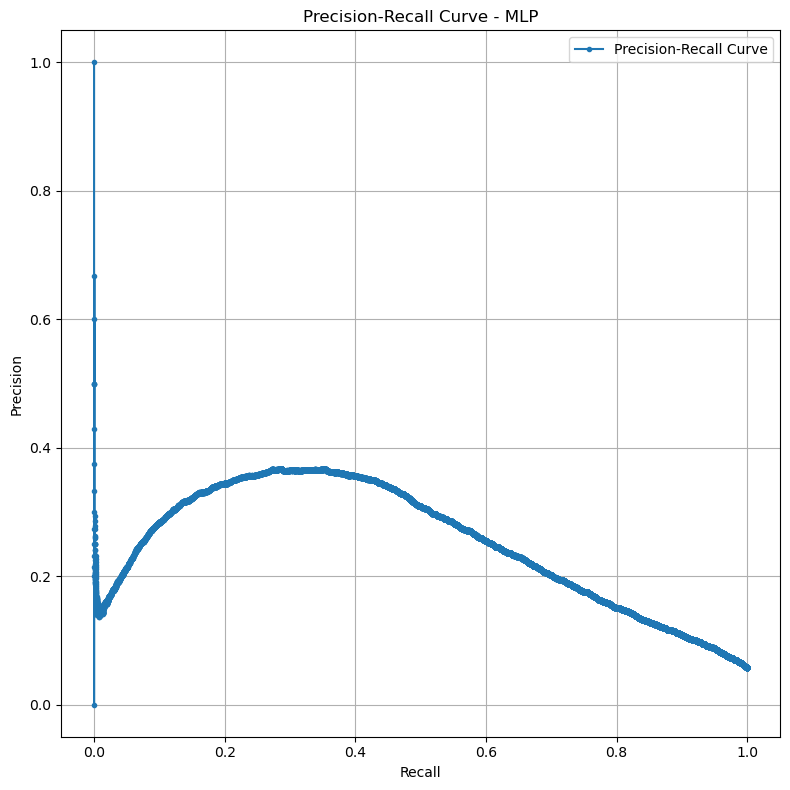

Plot Calibration Curve


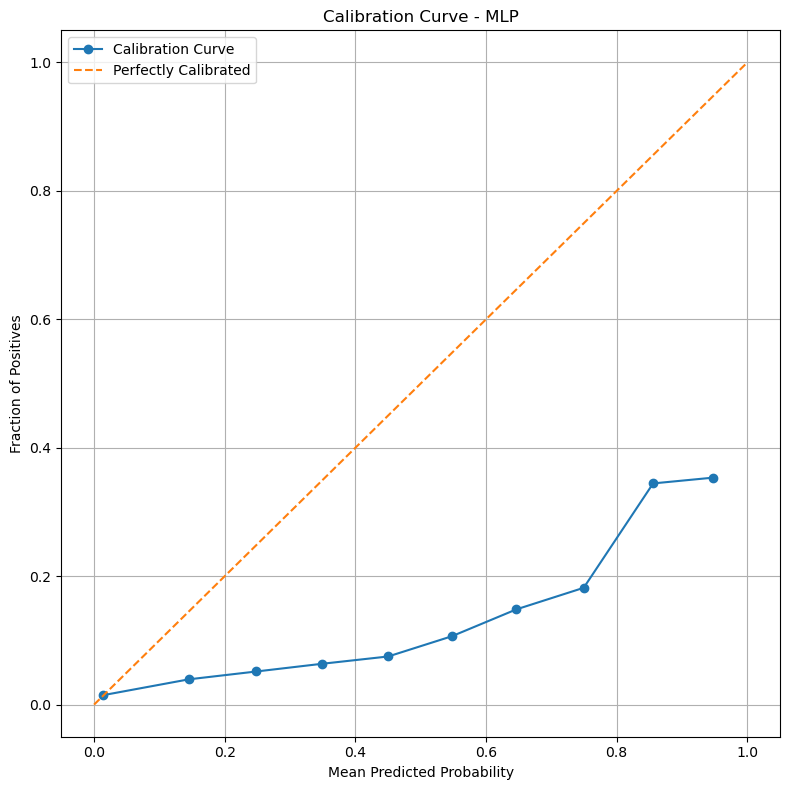

feature  importance_mean  importance_std
6                   HadAngina         0.125362        0.000678
40                AgeGroupNum         0.115091        0.000611
25                AgeCategory         0.081934        0.001185
33               BMI_Category         0.039160        0.001157
39                        BMI         0.029753        0.001147
2               GeneralHealth         0.014799        0.001432
7                   HadStroke         0.014694        0.000407
21               SmokerStatus         0.012962        0.000912
23                  ChestScan         0.007066        0.000515
1                         Sex         0.006470        0.000736
38          WeightInKilograms         0.005579        0.000882
14                HadDiabetes         0.004009        0.000693
34         PhysicalHealthDays         0.002914        0.000560
28               FluVaxLast12         0.001935        0.000507
5                RemovedTeeth         0.001658        0.001020
3             LastCheckupTime         0.001586        0.000736
4          PhysicalActivities         0.001332        0.000507
13               HadArthritis         0.000789        0.000602
12           HadKidneyDisease         0.000651        0.000268
26            AlcoholDrinkers         0.000510        0.000439
10                    HadCOPD         0.000425        0.000400
0                       State         0.000341        0.001725
22            ECigaretteUsage         0.000131        0.000804
36                 SleepHours        -0.000147        0.000340
35           MentalHealthDays        -0.000270        0.000693
15        DeafOrHardOfHearing        -0.000288        0.000440
9               HadSkinCancer        -0.000355        0.000431
18          DifficultyWalking        -0.000411        0.000421
16    BlindOrVisionDifficulty        -0.000522        0.000406
31           HighRiskLastYear        -0.001074        0.000337
24      RaceEthnicityCategory        -0.001217        0.000541
19  DifficultyDressingBathing        -0.001221        0.000340
20          DifficultyErrands        -0.001344        0.000250
37             HeightInMeters        -0.001439        0.000540
8                   HadAsthma        -0.001495        0.000505
29              PneumoVaxEver        -0.001723        0.000371
17    DifficultyConcentrating        -0.001956        0.000367
32                   CovidPos        -0.002169        0.000784
11      HadDepressiveDisorder        -0.002348        0.000468
30          TetanusLast10Tdap        -0.002468        0.001104
27                 HIVTesting        -0.003313        0.000383

Plot Permutation Importance


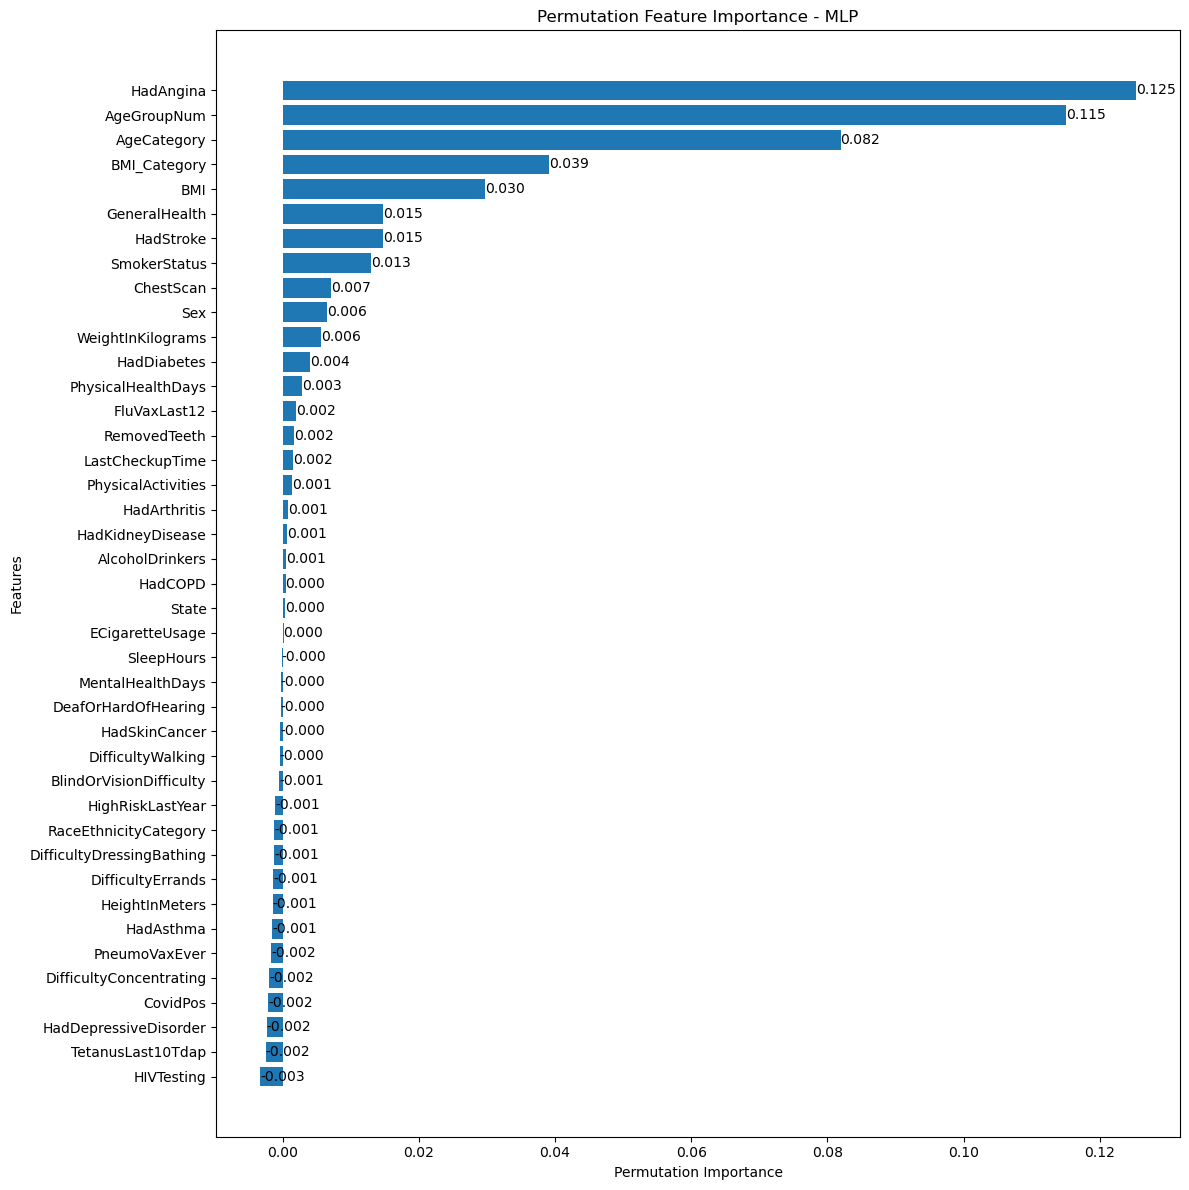

In [22]:
# Record number of columns to fill input dimension of MLP.
input_dimension = X_train_dummies.shape[1]


# Transform numpy array to torch tensors and create torch dataset.
def data_to_tensor(
        X_train_dummies,
        X_validation_dummies,
        X_test_dummies,
        y_train,
        y_validation,
        y_test):
    X_train_tensor = torch.tensor(
        X_train_dummies.to_numpy(), dtype=torch.float32)
    X_validation_tensor = torch.tensor(
        X_validation_dummies.to_numpy(), dtype=torch.float32)
    X_test_tensor = torch.tensor(
        X_test_dummies.to_numpy(), dtype=torch.float32)
    y_train_tensor = torch.tensor(
        y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
    y_validation_tensor = torch.tensor(
        y_validation.to_numpy(), dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(
        y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    validation_ds = TensorDataset(X_validation_tensor, y_validation_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)
    return train_ds, validation_ds, test_ds


# Define a class to stop training when detected overfitting.
class EarlyStopping:
    def __init__(self, patience, mode='max'):
        # Set some class attribute to record
        self.patience = patience
        self.mode = mode
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_model = None
        self.best_proba = None

    def __call__(self, model, proba, score):
        # Use deepcopy to store copies of the instances
        if self.best_score is None:
            self.best_model = deepcopy(model)
            self.best_proba = deepcopy(proba)
            self.best_score = deepcopy(score)
        else:
            if self.mode == 'max':
                improve = score - self.best_score > 0
            else:
                improve = self.best_score - score > 0
            if improve:
                self.best_model = deepcopy(model)
                self.best_proba = deepcopy(proba)
                self.best_score = deepcopy(score)
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True


# Define the structure of neurol network
class MLP(nn.Module):
    # Leave some hyperparameters for tuning.
    def __init__(self, input_dim, num_layers, hidden_dim, dropout):
        super().__init__()
        layers = []
        # Make the number of hidden layers adjustable
        for i in range(num_layers):
            layers.extend([
                nn.Linear(hidden_dim, hidden_dim),
                # Normalize output, mitigate over-fitting.
                nn.BatchNorm1d(hidden_dim),
                # ReLU is non-linear activation function, which is the core of hidden layers to
                # capture non-linear relationship of dataset.
                nn.ReLU(),
                # Drop some neuron output to mitigate over-fitting
                nn.Dropout(dropout)
            ])
        # Define the actual structure
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            # Unpack hidden layers into model structure
            *layers,
            # Full connection layer to output result
            nn.Linear(hidden_dim, 1),
        )

    # Define the forward propagation process.
    def forward(self, X):
        # Put into model for propagation
        return self.model(X)


# Define a train function to reuse in optuna and train final model
def trainMLP(batch_size, num_layers, hidden_dim, dropout, pos_weight, lr):
    # Define pytorch datalodaer
    train_ds, validation_ds, _ = data_to_tensor(
        X_train_dummies,
        X_validation_dummies,
        X_test_dummies,
        y_train,
        y_validation,
        y_test=y_test
    )
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, generator=g)
    validation_loader = DataLoader(validation_ds, batch_size=batch_size)
    # Instantiate MLP model, and sent it to GPU if available
    model = MLP(
        input_dim=input_dimension,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    # Set weight to mitigate imbalanced target.
    pos_weight = torch.tensor([pos_weight], device=device)
    # Use BCEWithLogitsLoss as loss function, which is suitable for binary classification
    # with imbalanced data
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    # Specify optimizer. Optimizer is a algorithm to update model parameters to minimize
    # loss function.
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Instantiate early stopper. When there are no improvement in eval function, stop the
    # training and restore best model.
    early_stopper = EarlyStopping(patience=10, mode='max')
    # Train the neurol network
    for epoch in range(200):
        start_time = time.time()
        # Set model to train mode
        model.train()
        # Record loss for batches
        total_loss = 0
        # Feed model in batches
        for xb, yb in train_loader:
            # Sent batches to GPU when available.
            xb, yb = xb.to(device), yb.to(device)
            # Get the logits of forward propagation.
            logits = model(xb)
            # Use loss function to calculate losses.
            loss = criterion(logits, yb)
            # Clean optimizer's gradient record.
            optimizer.zero_grad()
            # Back-propagation and calculate gradient
            loss.backward()
            # Use optimizer to update parameters.
            optimizer.step()
            # Record loss for the batches
            total_loss += loss.item()
        # Get average losses
        avg_loss = total_loss / len(train_loader)
        # Set model to evaluate mode
        model.eval()
        logits = []
        # Tell model not to calculate and record gradient
        with torch.no_grad():
            for xb, yb in validation_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits.append(model(xb))
            logits = torch.cat(logits, dim=0)
        # Use sigmoid to get probability
        proba = torch.sigmoid(logits).cpu().numpy().squeeze()
        # Calculate the average precision score, i.e., the area under the PR curve.
        score = average_precision_score(y_validation, proba)
        end_time = time.time()
        # Print verbose
        print(
            f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Score: {score:.4f}, {end_time - start_time:.2f}', flush=True)
        # Use early stopper to check improvement and detect overfitting
        early_stopper(model, proba, score)
        if early_stopper.early_stop:
            print(
                f'Early stopping triggered at epoch {epoch+1} with score {early_stopper.best_score}', flush=True)
            break
    # Restore model, proba, score from best epoch
    model = deepcopy(early_stopper.best_model)
    proba = deepcopy(early_stopper.best_proba)
    score = deepcopy(early_stopper.best_score)
    # Return model, proba, score to external
    return model, proba, score


class wrap_mlp(ClassifierMixin):
    def __init__(self, model, batch_size):
        self.classes_ = np.array([0, 1])
        self.model = model
        self.batch_size = batch_size

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X_test):
        _, _, X_test_permutation, _ = process_data(
            X_train, X_validation, X_test)
        _, _, test_ds = data_to_tensor(
            X_train_dummies,
            X_validation_dummies,
            X_test_permutation,
            y_train,
            y_validation,
            y_test
        )
        test_loader = DataLoader(test_ds, batch_size=self.batch_size)
        self.model.eval()
        logits = []
        with torch.no_grad():
            for xb in test_loader:
                xb = xb[0].to(device)
                logits.append(self.model(xb))
            logits = torch.cat(logits, dim=0)
        proba = torch.sigmoid(logits).cpu().numpy()
        return np.hstack(tup=[1 - proba, proba])

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


# Define optuna objective
def mlp_objective(trial):
    # How much records being feeded into model each time
    batch_size = trial.suggest_int('batch_size', 2048, 16384)
    # Number of hidden layers
    num_layers = trial.suggest_int('num_layers', 1, 4)
    # Dimension of hidden layers, i.e., neurons.
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    # How many portion of neurons being dropped to avoid over-fitting.
    dropout = trial.suggest_float('dropout', 0, 0.5)
    # Set wights to handle imbalanced target.
    pos_weight = trial.suggest_float('pos_weight', 0.1, 10)
    # Set learning rate.
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Use hyperparameters to train model and get score. Do not need model and proba during tunning.
    _, _, score = trainMLP(
        batch_size=batch_size,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        dropout=dropout,
        pos_weight=pos_weight,
        lr=lr
    )
    return score


# Define optuna study object, and direction is to maximize area under PR-Curve
# Evaluated on validation set.
output_seperate('Searching Hyperparameters')
mlp_study = optuna.create_study(direction='maximize', sampler=sampler)
mlp_study.optimize(mlp_objective, n_trials=n_trials)

# Use best hyperparameters to train final model and retrieve the results on the test set
output_seperate('Train model with best hyperparameters...')
mlp_model, _, _ = trainMLP(**mlp_study.best_params)
wrapped_mlp = wrap_mlp(
    mlp_model, batch_size=mlp_study.best_params['batch_size'])
mlp_proba = wrapped_mlp.predict_proba(X_test)[:,1]
mlp_score = average_precision_score(y_test, mlp_proba)
mlp_pred = (mlp_proba > 0.5).astype(int)
mlp_results = output_results(
    mlp_score, mlp_study, y_test, mlp_pred, mlp_proba)
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test, mlp_proba, 'MLP')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test, mlp_proba, 'MLP')

mlp_important_df = calculate_permutation_importance(wrapped_mlp, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance,
                 (12, 12), mlp_important_df, 'MLP')

## 6.5. Model comparison


Plot Precison-Recall Curve Comparison


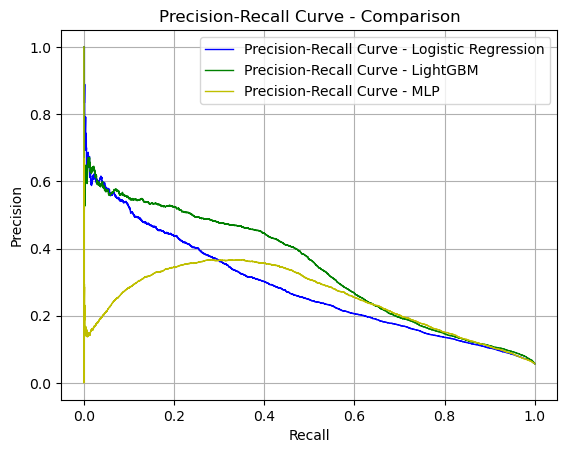

Plot Calibration Curve Compaision


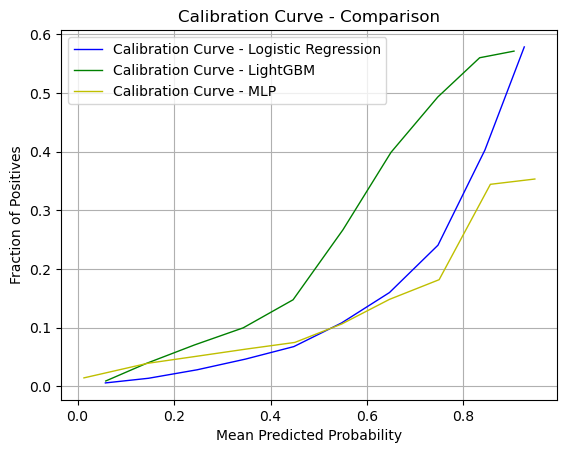

Plot Permutation Importance


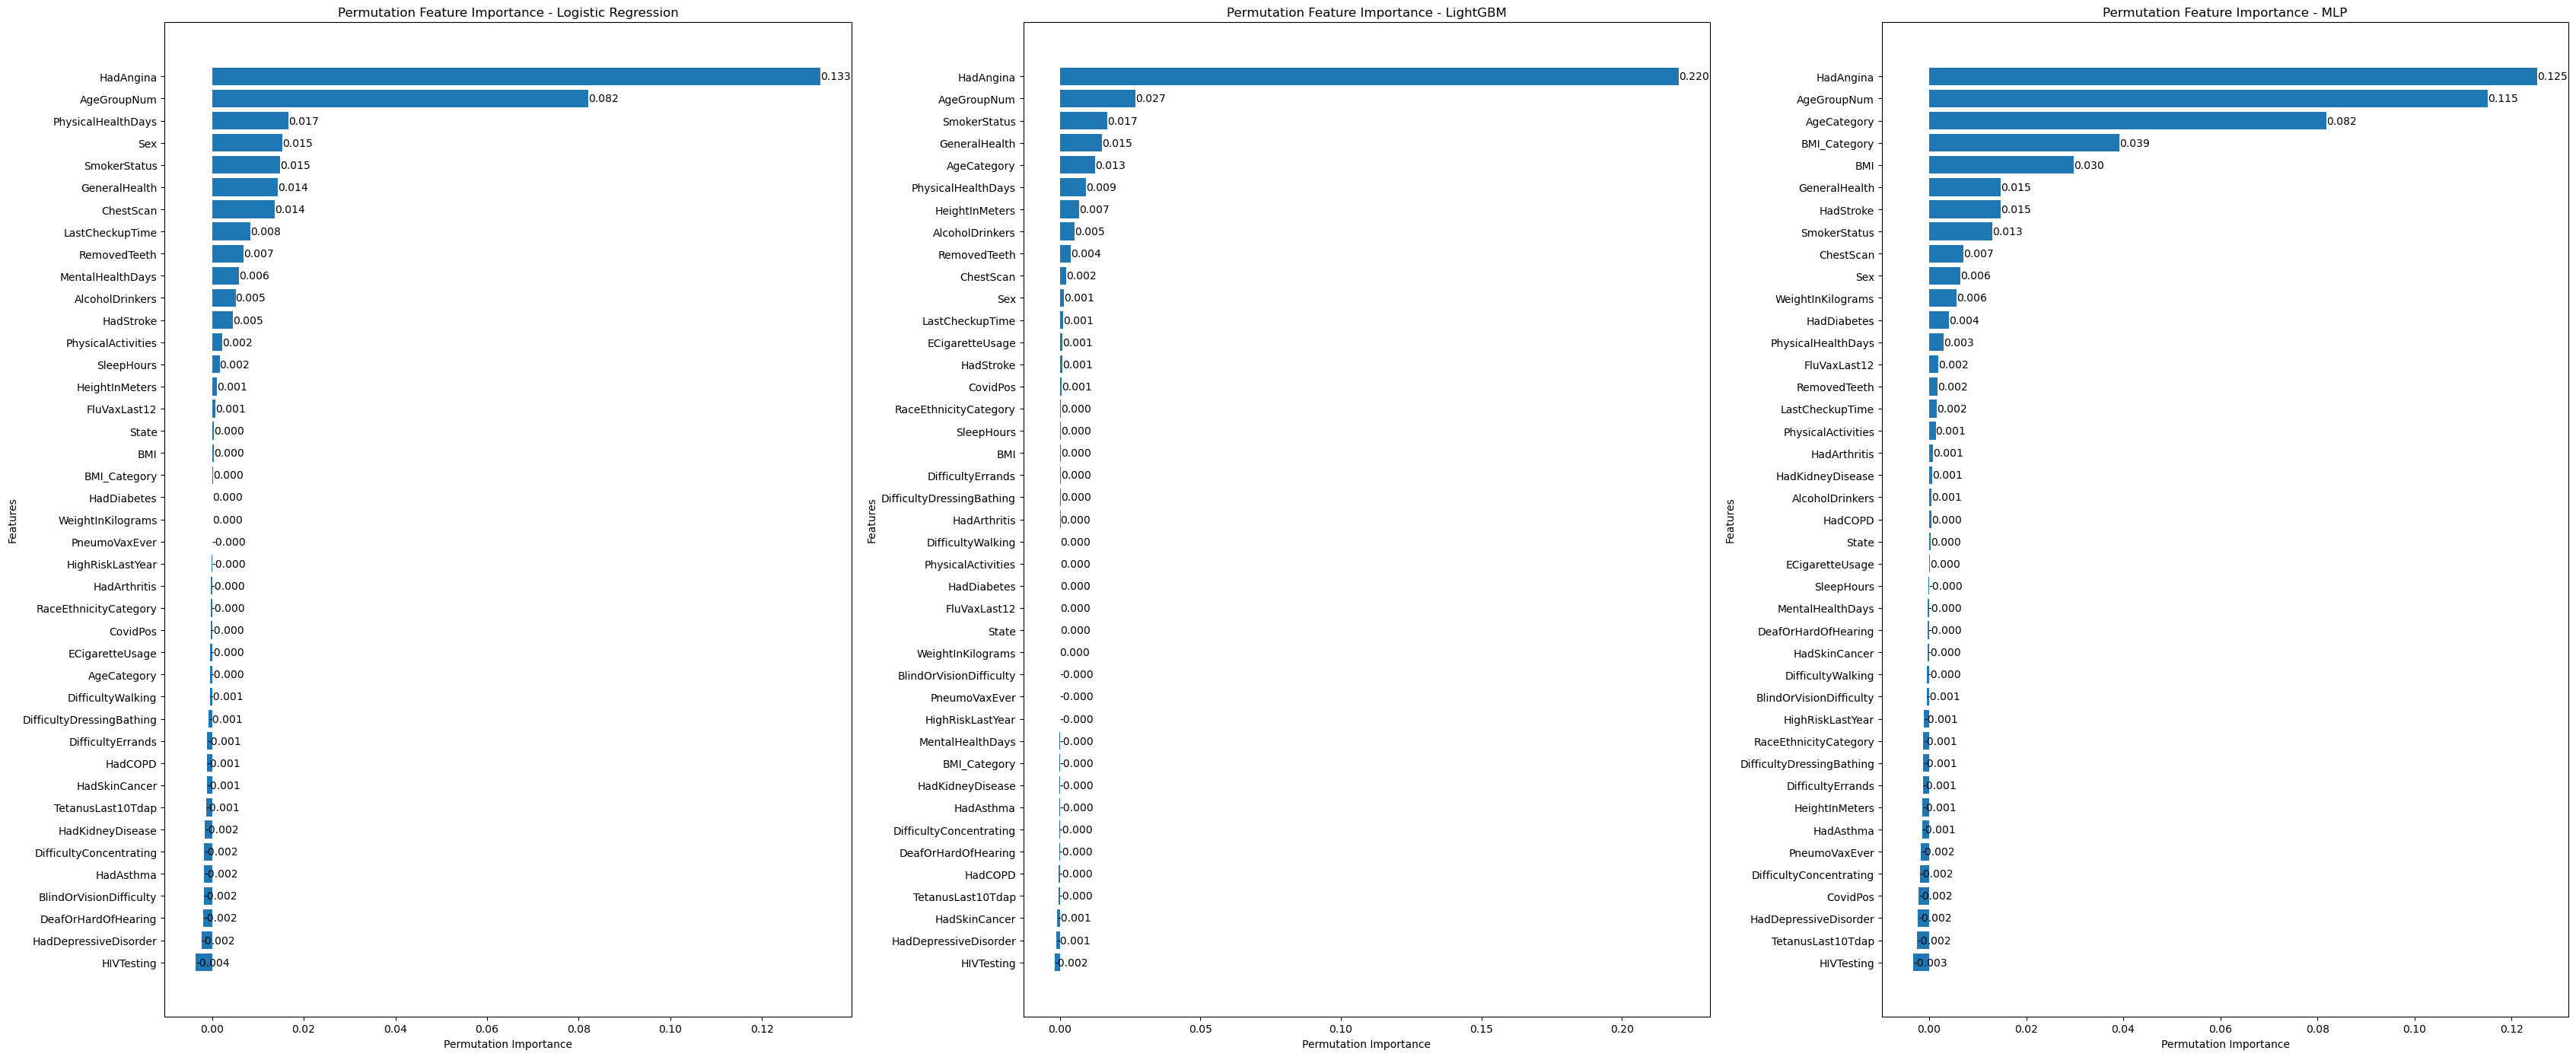

PR AUC   ROC AUC  F1 Score  Precision    Recall
Logistic Regression  0.283605  0.828819  0.297485   0.194055  0.636997
LightGBM             0.342687  0.853125  0.431669   0.397884  0.471724
MLP                  0.249698  0.843336  0.340140   0.230319  0.650139

In [23]:
# Plot PR curve Comparison
output_seperate('Plot Precison-Recall Curve Comparison')
fig, ax = plt.subplots()
precision, recall, _ = precision_recall_curve(y_test, logistic_proba)
ax.plot(recall, precision, color='b', linewidth=1,
        label='Precision-Recall Curve - Logistic Regression')
precision, recall, _ = precision_recall_curve(y_test, lgbm_proba)
ax.plot(recall, precision, color='g', linewidth=1,
        label='Precision-Recall Curve - LightGBM')
precision, recall, _ = precision_recall_curve(y_test, mlp_proba)
ax.plot(recall, precision, color='y', linewidth=1,
        label='Precision-Recall Curve - MLP')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title(f'Precision-Recall Curve - Comparison')
ax.legend()
ax.grid()
plt.show()

# Plot Calibaration Curve comparison
output_seperate('Plot Calibration Curve Compaision')
fig, ax = plt.subplots()
prob_true, prob_pred = calibration_curve(y_test, logistic_proba, n_bins=10)
ax.plot(prob_pred, prob_true, color='b', linewidth=1,
        label='Calibration Curve - Logistic Regression')
prob_true, prob_pred = calibration_curve(y_test, lgbm_proba, n_bins=10)
ax.plot(prob_pred, prob_true, color='g', linewidth=1,
        label='Calibration Curve - LightGBM')
prob_true, prob_pred = calibration_curve(y_test, mlp_proba, n_bins=10)
ax.plot(prob_pred, prob_true, color='y', linewidth=1,
        label='Calibration Curve - MLP')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title(f'Calibration Curve - Comparison')
ax.legend()
ax.grid()
plt.show()

# Plot permutation importance comparison
output_seperate('Plot Permutation Importance')
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(34, 14))
plot_permutation_importance(logistic_important_df,
                            'Logistic Regression', ax=axes[0])
plot_permutation_importance(lgbm_important_df, 'LightGBM', ax=axes[1])
plot_permutation_importance(mlp_important_df, 'MLP', ax=axes[2])
plt.tight_layout()
plt.show()

# Print scores comparison
comparison = pd.concat([logistic_results, lgbm_results, mlp_results])
comparison.index = ['Logistic Regression', 'LightGBM', 'MLP']
display(comparison)

# *LightGBM with SHAP and without imputation

# 0. Initialize Environment


In [24]:
# -------------------------------
# PROJECT OBJECTIVES
# -------------------------------
# 1) Clean, explore, and analyze data on cardiovascular disease;
# 2) Build predictive models for CVD risk using key indicators;
# 3) Create visualizations to support findings;
# 4) Demonstrate collaboration in producing a final report.

# ----------------------------
# PROJECT WORKFLOW
# ----------------------------
# Step 1: Data acquisition & cleaning (DONE)
# Step 2: Feature engineering
# Step 3: Exploratory and descriptive data analysis
# Step 4: Predictive modeling
# Step 5: Data visualization
# Step 6: Interpretation and discussion
# Step 7: Conclusion
# Step 8: References

# -------------------------------------------------------------
# IMPORT LIBRARIES
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import torch
import torch.nn as nn
import gc

from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.base import ClassifierMixin
from sklearn.calibration import calibration_curve
from torch.utils.data import TensorDataset, DataLoader
from lightgbm import LGBMClassifier, early_stopping
import optuna
import kagglehub
import shap

# -------------------------------------------------------------
# SEEDING
# -------------------------------------------------------------
seed = 88888
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
g = torch.Generator().manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sampler = optuna.samplers.TPESampler(seed=seed)
n_trials = 50
n_repeats = 10

# -------------------------------------------------------------
# DATA LOADING
# -------------------------------------------------------------
path = kagglehub.dataset_download(
    "kamilpytlak/personal-key-indicators-of-heart-disease")
file = path + '/2022/heart_2022_with_nans.csv'
heart_df = pd.read_csv(file)


# Utility function to seperate outputs
def output_seperate(text):
    print('='*79, flush=True)
    print(text, flush=True)
    print('='*79, flush=True)

# 1.Feature Engineering

In [25]:
# Define target
target = 'HadHeartAttack'
# Drop rows with missing target variable and create a clean copy
heart_clean = heart_df.dropna(subset=['HadHeartAttack'])
# Reset index after row drops
heart_clean.reset_index(drop=True, inplace=True)
# Seperate features and target
y = heart_clean[target]
X = heart_clean.drop(columns=target)
# Train/test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)
# Train/validation splits
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=seed, stratify=y_train)

# ---------------------------------------------
# CREATE BMI CATEGORY
# ---------------------------------------------


def get_bmi_category(bmi):
    if pd.isnull(bmi):
        return None
    if bmi < 18.5:
        return 'Underweight'
    elif bmi < 25:
        return 'Normal'
    elif bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'


X_train['BMI_Category'] = X_train['BMI'].apply(get_bmi_category)
X_validation['BMI_Category'] = X_validation['BMI'].apply(get_bmi_category)
X_test['BMI_Category'] = X_test['BMI'].apply(get_bmi_category)


# ---------------------------------------------
# Convert AgeCategory into Numeric Order
# ---------------------------------------------
age_order = X['AgeCategory'].value_counts(
    dropna=False).sort_index().index.to_list()
age_group_numbers = {age: idx for idx, age in enumerate(age_order)}
X_train['AgeGroupNum'] = X_train['AgeCategory'].map(age_group_numbers)
X_validation['AgeGroupNum'] = X_validation['AgeCategory'].map(
    age_group_numbers)
X_test['AgeGroupNum'] = X_test['AgeCategory'].map(age_group_numbers)
col_names = X_train.columns.tolist()

# ---------------------------------------------
# Convert object cols into category
# ---------------------------------------------
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_validation[col] = X_validation[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Mapping target from 'Yes/No' to '1/0'
y_train = y_train.map({'Yes': 1, 'No': 0})
y_validation = y_validation.map({'Yes': 1, 'No': 0})
y_test = y_test.map({'Yes': 1, 'No': 0})


output_seperate('Feature engineering complete. Sample data:')
display(X_train[['BMI_Category', 'AgeGroupNum']].head(10))

Feature engineering complete. Sample data:


BMI_Category  AgeGroupNum
231375       Normal            9
253304        Obese            6
84768    Overweight            2
217385        Obese           10
201405       Normal            0
73484           NaN           12
337056       Normal            6
166732       Normal            3
247092        Obese            9
202184   Overweight            7

In [26]:
# Utility function for plotting Precision-Recall Curve
def plot_pr_curve(y_test, proba, model_name, ax):
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ax.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve - {model_name}')
    ax.legend()
    ax.grid()
    return ax


# Utility function for plotting Calibration Curve
def plot_cb_curve(y_test, proba, model_name, ax):
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=10)
    ax.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration Curve - {model_name}')
    ax.legend()
    ax.grid()
    return ax


# Utility function for printing results
def output_results(score, study, y_test, pred, proba):
    output_seperate('Best Hyperparameters:')
    display(study.best_params)
    results = {
        'PR AUC': [score],
        'ROC AUC': [roc_auc_score(y_test, proba)],
        'F1 Score': [f1_score(y_test, pred)],
        'Precision': [precision_score(y_test, pred)],
        'Recall': [recall_score(y_test, pred)]
    }
    results = pd.DataFrame(results)
    output_seperate('Results')
    display(results.T)
    return results


# Utility function for plotting Permutation Importance
def plot_permutation_importance(importance_df, model_name, ax):
    bars = ax.barh(importance_df['feature'], importance_df['importance_mean'])
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
                f'{bar.get_width():.3f}', va='center')
    ax.set_xlabel('Permutation Importance')
    ax.set_ylabel('Features')
    ax.set_title(f'Permutation Feature Importance - {model_name}')
    ax.invert_yaxis()
    return ax


# Simple wrapper for immediate plotting
def plot_immediately(plot_func, figsize, *args):
    fig, ax = plt.subplots(figsize=figsize)
    plot_func(*args, ax=ax)
    plt.tight_layout()
    plt.show()


# Utility function for permutation importance
def calculate_permutation_importance(model, X_test):
    result = permutation_importance(
        estimator=model,
        X=X_test,
        y=y_test,
        n_repeats=n_repeats,
        random_state=seed,
        scoring='average_precision'
    )
    # Create a df to store results
    importance_df = pd.DataFrame({
        'feature': col_names,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std
    }).sort_values(by='importance_mean', ascending=False)
    display(importance_df)
    return importance_df

# 2. Training LightGBM

[I 2025-04-13 18:10:26,395] A new study created in memory with name: no-name-733b0d97-373a-4260-9c7f-a7a183bb3e46


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:27,255] Trial 0 finished with value: 0.4273260697912644 and parameters: {'n_estimators': 371, 'learning_rate': 0.06888934642989925, 'max_depth': 9, 'num_leaves': 31, 'min_child_samples': 89, 'subsample': 0.7819898490051065, 'colsample_bytree': 0.6960934748335856, 'reg_alpha': 0.00013442173776006218, 'reg_lambda': 4.356931466704218e-08, 'scale_pos_weight': 2.358734322318435}. Best is trial 0 with value: 0.4273260697912644.


Early stopping, best iteration is:
[23]	valid_0's average_precision: 0.427326	valid_0's binary_logloss: 0.162227
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:27,763] Trial 1 finished with value: 0.39089229041398577 and parameters: {'n_estimators': 360, 'learning_rate': 0.19443218481846689, 'max_depth': 20, 'num_leaves': 52, 'min_child_samples': 55, 'subsample': 0.7348771706186736, 'colsample_bytree': 0.9170045016718991, 'reg_alpha': 0.404623088499892, 'reg_lambda': 0.03855127113556386, 'scale_pos_weight': 3.9357074038466657}. Best is trial 0 with value: 0.4273260697912644.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.390892	valid_0's binary_logloss: 0.171255
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:28,247] Trial 2 finished with value: 0.3545326340331672 and parameters: {'n_estimators': 201, 'learning_rate': 0.10247974876198356, 'max_depth': 9, 'num_leaves': 24, 'min_child_samples': 58, 'subsample': 0.6235393372085656, 'colsample_bytree': 0.7910693389579644, 'reg_alpha': 0.00042501629517502284, 'reg_lambda': 4.463267692039243e-06, 'scale_pos_weight': 9.357042058514635}. Best is trial 0 with value: 0.4273260697912644.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.354533	valid_0's binary_logloss: 0.185402
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:28,641] Trial 3 finished with value: 0.42872940653080394 and parameters: {'n_estimators': 282, 'learning_rate': 0.055535347340893895, 'max_depth': 12, 'num_leaves': 146, 'min_child_samples': 21, 'subsample': 0.7908833229543983, 'colsample_bytree': 0.6176973405873165, 'reg_alpha': 0.2560600981374757, 'reg_lambda': 0.4432046642146085, 'scale_pos_weight': 2.4262280551110256}. Best is trial 3 with value: 0.42872940653080394.


Early stopping, best iteration is:
[23]	valid_0's average_precision: 0.428729	valid_0's binary_logloss: 0.162275
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:31,745] Trial 4 finished with value: 0.43785819449813307 and parameters: {'n_estimators': 338, 'learning_rate': 0.01606861226690527, 'max_depth': 9, 'num_leaves': 37, 'min_child_samples': 95, 'subsample': 0.854891640707834, 'colsample_bytree': 0.5326690063819919, 'reg_alpha': 2.4083018502211476e-08, 'reg_lambda': 2.4942701467240546e-07, 'scale_pos_weight': 0.8178861091453676}. Best is trial 4 with value: 0.43785819449813307.


Did not meet early stopping. Best iteration is:
[329]	valid_0's average_precision: 0.437858	valid_0's binary_logloss: 0.146566
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:32,314] Trial 5 finished with value: 0.4264965563538389 and parameters: {'n_estimators': 337, 'learning_rate': 0.18818889887386833, 'max_depth': 19, 'num_leaves': 39, 'min_child_samples': 52, 'subsample': 0.8370223189532731, 'colsample_bytree': 0.9381474941383354, 'reg_alpha': 0.04987584680445025, 'reg_lambda': 3.84294719067898e-07, 'scale_pos_weight': 0.22498691568378756}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[10]	valid_0's average_precision: 0.426497	valid_0's binary_logloss: 0.176424
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:33,083] Trial 6 finished with value: 0.4276911268064332 and parameters: {'n_estimators': 467, 'learning_rate': 0.019747798498915958, 'max_depth': 5, 'num_leaves': 32, 'min_child_samples': 93, 'subsample': 0.6670602932143849, 'colsample_bytree': 0.5075122378964843, 'reg_alpha': 0.1451885935191396, 'reg_lambda': 1.855813528549327e-06, 'scale_pos_weight': 5.065990040290208}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[23]	valid_0's average_precision: 0.427691	valid_0's binary_logloss: 0.183311
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:33,874] Trial 7 finished with value: 0.4233917513903064 and parameters: {'n_estimators': 174, 'learning_rate': 0.01862935015763944, 'max_depth': 20, 'num_leaves': 95, 'min_child_samples': 35, 'subsample': 0.969087154572375, 'colsample_bytree': 0.8293526467539787, 'reg_alpha': 6.566199734502469e-05, 'reg_lambda': 9.470400514619504e-08, 'scale_pos_weight': 5.26985189476205}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[24]	valid_0's average_precision: 0.423392	valid_0's binary_logloss: 0.178456
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:34,497] Trial 8 finished with value: 0.3688725697436536 and parameters: {'n_estimators': 159, 'learning_rate': 0.16095625219604107, 'max_depth': 12, 'num_leaves': 65, 'min_child_samples': 58, 'subsample': 0.7232636498662011, 'colsample_bytree': 0.6124406777384479, 'reg_alpha': 1.1594464595380025, 'reg_lambda': 3.340720785053467e-07, 'scale_pos_weight': 9.427754615944501}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[1]	valid_0's average_precision: 0.368873	valid_0's binary_logloss: 0.184306
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:35,152] Trial 9 finished with value: 0.4290784759656431 and parameters: {'n_estimators': 302, 'learning_rate': 0.01242783253877007, 'max_depth': 5, 'num_leaves': 52, 'min_child_samples': 35, 'subsample': 0.8965274326180741, 'colsample_bytree': 0.6565632780806754, 'reg_alpha': 3.6425067597235805e-07, 'reg_lambda': 3.702741781401391e-05, 'scale_pos_weight': 5.479874929464757}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[29]	valid_0's average_precision: 0.429078	valid_0's binary_logloss: 0.185209
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:37,414] Trial 10 finished with value: 0.43503632280468957 and parameters: {'n_estimators': 482, 'learning_rate': 0.028025643423405147, 'max_depth': 16, 'num_leaves': 98, 'min_child_samples': 76, 'subsample': 0.9933511831020967, 'colsample_bytree': 0.5200678151868876, 'reg_alpha': 3.268578367278605e-08, 'reg_lambda': 0.0017040832410216708, 'scale_pos_weight': 0.31975203026920607}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[161]	valid_0's average_precision: 0.435036	valid_0's binary_logloss: 0.165471
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:39,626] Trial 11 finished with value: 0.4353577742717431 and parameters: {'n_estimators': 494, 'learning_rate': 0.03085073143549936, 'max_depth': 16, 'num_leaves': 99, 'min_child_samples': 79, 'subsample': 0.9964975708405405, 'colsample_bytree': 0.514748215040539, 'reg_alpha': 1.053616516202559e-08, 'reg_lambda': 0.00561574588362149, 'scale_pos_weight': 0.3797433602171028}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[145]	valid_0's average_precision: 0.435358	valid_0's binary_logloss: 0.160522
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:41,776] Trial 12 finished with value: 0.4357878081720064 and parameters: {'n_estimators': 418, 'learning_rate': 0.033712758040575726, 'max_depth': 16, 'num_leaves': 113, 'min_child_samples': 100, 'subsample': 0.5365564247802086, 'colsample_bytree': 0.567073740441835, 'reg_alpha': 1.05053190161921e-08, 'reg_lambda': 0.0010548024041585064, 'scale_pos_weight': 1.814590616325067}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[137]	valid_0's average_precision: 0.435788	valid_0's binary_logloss: 0.153116
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:43,558] Trial 13 finished with value: 0.4336780950454341 and parameters: {'n_estimators': 412, 'learning_rate': 0.036499925790369675, 'max_depth': 9, 'num_leaves': 126, 'min_child_samples': 100, 'subsample': 0.522799494977866, 'colsample_bytree': 0.5938827011940462, 'reg_alpha': 8.970004271273554e-07, 'reg_lambda': 0.00018581493527389326, 'scale_pos_weight': 2.306361725310888}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[104]	valid_0's average_precision: 0.433678	valid_0's binary_logloss: 0.160556
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:44,981] Trial 14 finished with value: 0.42999746378259873 and parameters: {'n_estimators': 421, 'learning_rate': 0.012575010658290737, 'max_depth': 15, 'num_leaves': 122, 'min_child_samples': 77, 'subsample': 0.5173628711324485, 'colsample_bytree': 0.7220966957031913, 'reg_alpha': 1.924817734993808e-06, 'reg_lambda': 3.3372807948829153, 'scale_pos_weight': 3.3877233743740858}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[68]	valid_0's average_precision: 0.429997	valid_0's binary_logloss: 0.170234
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:45,982] Trial 15 finished with value: 0.4232818643270224 and parameters: {'n_estimators': 237, 'learning_rate': 0.018459597138791216, 'max_depth': 14, 'num_leaves': 77, 'min_child_samples': 99, 'subsample': 0.6072272266735385, 'colsample_bytree': 0.5609086929820687, 'reg_alpha': 1.5787866480592996e-07, 'reg_lambda': 4.898057003035523e-05, 'scale_pos_weight': 6.597440046924987}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[14]	valid_0's average_precision: 0.423282	valid_0's binary_logloss: 0.18587
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:47,251] Trial 16 finished with value: 0.43397611425472415 and parameters: {'n_estimators': 101, 'learning_rate': 0.04897370748808834, 'max_depth': 18, 'num_leaves': 116, 'min_child_samples': 83, 'subsample': 0.8806427494330522, 'colsample_bytree': 0.658659061110714, 'reg_alpha': 5.430950425483945e-06, 'reg_lambda': 0.028432143702484994, 'scale_pos_weight': 1.4381478586223269}. Best is trial 4 with value: 0.43785819449813307.


Did not meet early stopping. Best iteration is:
[78]	valid_0's average_precision: 0.433976	valid_0's binary_logloss: 0.148934
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:47,967] Trial 17 finished with value: 0.4198894768138696 and parameters: {'n_estimators': 417, 'learning_rate': 0.023158080812006543, 'max_depth': 7, 'num_leaves': 141, 'min_child_samples': 73, 'subsample': 0.9236760510481627, 'colsample_bytree': 0.9938677861615544, 'reg_alpha': 0.004491387031537933, 'reg_lambda': 1.8254884687584226e-08, 'scale_pos_weight': 6.945222077126962}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[15]	valid_0's average_precision: 0.419889	valid_0's binary_logloss: 0.182616
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[302]	valid_0's average_precision: 0.4362	valid_0's binary_logloss: 0.149691


[I 2025-04-13 18:10:51,211] Trial 18 finished with value: 0.43620006641645837 and parameters: {'n_estimators': 302, 'learning_rate': 0.01070254923108235, 'max_depth': 11, 'num_leaves': 80, 'min_child_samples': 67, 'subsample': 0.5775043593982121, 'colsample_bytree': 0.5643580524852658, 'reg_alpha': 1.1176999000734934e-05, 'reg_lambda': 0.0007741955990256934, 'scale_pos_weight': 1.4729301948745692}. Best is trial 4 with value: 0.43785819449813307.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:52,438] Trial 19 finished with value: 0.4269777516472767 and parameters: {'n_estimators': 269, 'learning_rate': 0.010097479596927073, 'max_depth': 11, 'num_leaves': 77, 'min_child_samples': 64, 'subsample': 0.6864616727286522, 'colsample_bytree': 0.7779735489386279, 'reg_alpha': 8.769979246074643, 'reg_lambda': 2.1640474858554072e-05, 'scale_pos_weight': 3.8107506893642844}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[70]	valid_0's average_precision: 0.426978	valid_0's binary_logloss: 0.173287
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[319]	valid_0's average_precision: 0.436865	valid_0's binary_logloss: 0.146605


[I 2025-04-13 18:10:55,206] Trial 20 finished with value: 0.4368653664619636 and parameters: {'n_estimators': 335, 'learning_rate': 0.013577441068078242, 'max_depth': 10, 'num_leaves': 56, 'min_child_samples': 41, 'subsample': 0.8342494034500243, 'colsample_bytree': 0.6646228303953772, 'reg_alpha': 1.2740849856259115e-05, 'reg_lambda': 4.974988364542106e-06, 'scale_pos_weight': 1.173670158259092}. Best is trial 4 with value: 0.43785819449813307.


Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:57,758] Trial 21 finished with value: 0.43661255769327323 and parameters: {'n_estimators': 324, 'learning_rate': 0.01441795484192695, 'max_depth': 10, 'num_leaves': 49, 'min_child_samples': 42, 'subsample': 0.8300770263684512, 'colsample_bytree': 0.6579838530491804, 'reg_alpha': 2.0629694466559697e-05, 'reg_lambda': 2.3350863643298964e-06, 'scale_pos_weight': 1.123895556119919}. Best is trial 4 with value: 0.43785819449813307.


Did not meet early stopping. Best iteration is:
[284]	valid_0's average_precision: 0.436613	valid_0's binary_logloss: 0.146532
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:10:59,978] Trial 22 finished with value: 0.4362254492643357 and parameters: {'n_estimators': 323, 'learning_rate': 0.015956290649608743, 'max_depth': 7, 'num_leaves': 50, 'min_child_samples': 41, 'subsample': 0.8271123894361145, 'colsample_bytree': 0.6669411018728417, 'reg_alpha': 0.0011790363629943393, 'reg_lambda': 2.972762173134212e-06, 'scale_pos_weight': 1.013885615123297}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[237]	valid_0's average_precision: 0.436225	valid_0's binary_logloss: 0.146451
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:01,221] Trial 23 finished with value: 0.43122253832337587 and parameters: {'n_estimators': 368, 'learning_rate': 0.01464445012020485, 'max_depth': 10, 'num_leaves': 62, 'min_child_samples': 19, 'subsample': 0.8481371682267488, 'colsample_bytree': 0.7340330014977202, 'reg_alpha': 2.2320242613662033e-05, 'reg_lambda': 4.897924940073278e-07, 'scale_pos_weight': 2.9348787759979356}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[85]	valid_0's average_precision: 0.431223	valid_0's binary_logloss: 0.167405
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:02,244] Trial 24 finished with value: 0.43497093262816633 and parameters: {'n_estimators': 249, 'learning_rate': 0.024710290153362322, 'max_depth': 7, 'num_leaves': 41, 'min_child_samples': 43, 'subsample': 0.7834763611575648, 'colsample_bytree': 0.8283503622551925, 'reg_alpha': 0.00529591574634304, 'reg_lambda': 8.823901903420029e-06, 'scale_pos_weight': 0.9280568427773984}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[81]	valid_0's average_precision: 0.434971	valid_0's binary_logloss: 0.150099
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:03,303] Trial 25 finished with value: 0.42693962324263035 and parameters: {'n_estimators': 343, 'learning_rate': 0.014070735929020582, 'max_depth': 13, 'num_leaves': 64, 'min_child_samples': 28, 'subsample': 0.9075685468902671, 'colsample_bytree': 0.6863842350204186, 'reg_alpha': 9.444410232878311e-08, 'reg_lambda': 9.182765895582412e-07, 'scale_pos_weight': 4.18469988147139}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[55]	valid_0's average_precision: 0.42694	valid_0's binary_logloss: 0.177536
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:04,960] Trial 26 finished with value: 0.4353087218695729 and parameters: {'n_estimators': 381, 'learning_rate': 0.020958396236090377, 'max_depth': 8, 'num_leaves': 20, 'min_child_samples': 48, 'subsample': 0.9415437679057259, 'colsample_bytree': 0.6281240421869493, 'reg_alpha': 1.5991816140086451e-06, 'reg_lambda': 1.1866867789659766e-08, 'scale_pos_weight': 1.821425680158752}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[175]	valid_0's average_precision: 0.435309	valid_0's binary_logloss: 0.154465
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:07,389] Trial 27 finished with value: 0.4355936049402731 and parameters: {'n_estimators': 325, 'learning_rate': 0.016186484586476254, 'max_depth': 10, 'num_leaves': 44, 'min_child_samples': 10, 'subsample': 0.8671103341619716, 'colsample_bytree': 0.760506340476265, 'reg_alpha': 3.241546044632317e-05, 'reg_lambda': 2.1991063181502294e-07, 'scale_pos_weight': 0.9499324983634534}. Best is trial 4 with value: 0.43785819449813307.


Did not meet early stopping. Best iteration is:
[298]	valid_0's average_precision: 0.435594	valid_0's binary_logloss: 0.146227
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:08,055] Trial 28 finished with value: 0.4080604142602315 and parameters: {'n_estimators': 389, 'learning_rate': 0.03796725495707978, 'max_depth': 11, 'num_leaves': 60, 'min_child_samples': 34, 'subsample': 0.810769945027272, 'colsample_bytree': 0.7098217100378086, 'reg_alpha': 4.797083505428224e-06, 'reg_lambda': 1.253693596784343e-05, 'scale_pos_weight': 7.944509955039688}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[8]	valid_0's average_precision: 0.40806	valid_0's binary_logloss: 0.185884
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:08,730] Trial 29 finished with value: 0.4246022712894152 and parameters: {'n_estimators': 237, 'learning_rate': 0.08696942635148545, 'max_depth': 8, 'num_leaves': 31, 'min_child_samples': 45, 'subsample': 0.7607664579079436, 'colsample_bytree': 0.5839917283907679, 'reg_alpha': 0.00021414254326919003, 'reg_lambda': 7.109763386295523e-08, 'scale_pos_weight': 2.665774706725758}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[12]	valid_0's average_precision: 0.424602	valid_0's binary_logloss: 0.165609
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:10,385] Trial 30 finished with value: 0.4306178711228843 and parameters: {'n_estimators': 274, 'learning_rate': 0.01160316068691307, 'max_depth': 10, 'num_leaves': 69, 'min_child_samples': 28, 'subsample': 0.7684914494732478, 'colsample_bytree': 0.536943772639571, 'reg_alpha': 0.0008871500077963501, 'reg_lambda': 0.00013375136353397683, 'scale_pos_weight': 3.1222408214012485}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[99]	valid_0's average_precision: 0.430618	valid_0's binary_logloss: 0.171085
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:11,993] Trial 31 finished with value: 0.43574527179553346 and parameters: {'n_estimators': 318, 'learning_rate': 0.015138313290580371, 'max_depth': 7, 'num_leaves': 51, 'min_child_samples': 40, 'subsample': 0.819550156001641, 'colsample_bytree': 0.6763887996515869, 'reg_alpha': 0.005041632082802316, 'reg_lambda': 3.284601739566397e-06, 'scale_pos_weight': 1.242239173989798}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[150]	valid_0's average_precision: 0.435745	valid_0's binary_logloss: 0.149357
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:14,262] Trial 32 finished with value: 0.4378527350715796 and parameters: {'n_estimators': 351, 'learning_rate': 0.01647571286247033, 'max_depth': 6, 'num_leaves': 44, 'min_child_samples': 49, 'subsample': 0.8563398855169365, 'colsample_bytree': 0.6594044154380846, 'reg_alpha': 0.0007942431200226413, 'reg_lambda': 1.8880708250320758e-06, 'scale_pos_weight': 0.6750139382948586}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[267]	valid_0's average_precision: 0.437853	valid_0's binary_logloss: 0.148779
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:15,734] Trial 33 finished with value: 0.435406455659326 and parameters: {'n_estimators': 444, 'learning_rate': 0.0265501834012896, 'max_depth': 6, 'num_leaves': 32, 'min_child_samples': 51, 'subsample': 0.8562319608478027, 'colsample_bytree': 0.6355917895878143, 'reg_alpha': 0.018072591033821972, 'reg_lambda': 7.29680179867182e-08, 'scale_pos_weight': 2.1461165939116906}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[136]	valid_0's average_precision: 0.435406	valid_0's binary_logloss: 0.159125
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:16,531] Trial 34 finished with value: 0.4350525689844934 and parameters: {'n_estimators': 355, 'learning_rate': 0.012527498815912756, 'max_depth': 9, 'num_leaves': 39, 'min_child_samples': 64, 'subsample': 0.7139852236285383, 'colsample_bytree': 0.6982673540707347, 'reg_alpha': 0.0009640504922426221, 'reg_lambda': 1.8495832535597143e-06, 'scale_pos_weight': 0.17276427020760798}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[199]	valid_0's average_precision: 0.435053	valid_0's binary_logloss: 0.186255
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:18,431] Trial 35 finished with value: 0.4359113725163762 and parameters: {'n_estimators': 390, 'learning_rate': 0.018183951145855564, 'max_depth': 8, 'num_leaves': 26, 'min_child_samples': 56, 'subsample': 0.7995051057190175, 'colsample_bytree': 0.8203670616176122, 'reg_alpha': 0.00010935238173418347, 'reg_lambda': 7.1189296543784585e-06, 'scale_pos_weight': 0.7383603331934052}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[230]	valid_0's average_precision: 0.435911	valid_0's binary_logloss: 0.148186
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:20,101] Trial 36 finished with value: 0.43745794025513524 and parameters: {'n_estimators': 350, 'learning_rate': 0.022348460221230864, 'max_depth': 6, 'num_leaves': 57, 'min_child_samples': 28, 'subsample': 0.939665363239744, 'colsample_bytree': 0.6398562650585475, 'reg_alpha': 0.00024100476906082393, 'reg_lambda': 8.211636360263642e-07, 'scale_pos_weight': 1.9294330998095282}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[150]	valid_0's average_precision: 0.437458	valid_0's binary_logloss: 0.155415
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:20,743] Trial 37 finished with value: 0.42583102492699093 and parameters: {'n_estimators': 368, 'learning_rate': 0.06152120369870666, 'max_depth': 6, 'num_leaves': 55, 'min_child_samples': 24, 'subsample': 0.9560034826960526, 'colsample_bytree': 0.5975621314213018, 'reg_alpha': 0.0003557270331684688, 'reg_lambda': 2.3950953248374147e-07, 'scale_pos_weight': 4.500423713098893}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[8]	valid_0's average_precision: 0.425831	valid_0's binary_logloss: 0.177781
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:22,174] Trial 38 finished with value: 0.43714336513366175 and parameters: {'n_estimators': 343, 'learning_rate': 0.022070969062641808, 'max_depth': 5, 'num_leaves': 70, 'min_child_samples': 32, 'subsample': 0.8888695534570489, 'colsample_bytree': 0.628375016733222, 'reg_alpha': 0.03797140323283642, 'reg_lambda': 3.0409187514616457e-08, 'scale_pos_weight': 1.9601917105736537}. Best is trial 4 with value: 0.43785819449813307.


Early stopping, best iteration is:
[143]	valid_0's average_precision: 0.437143	valid_0's binary_logloss: 0.156386
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:24,610] Trial 39 finished with value: 0.4382833027906389 and parameters: {'n_estimators': 287, 'learning_rate': 0.022322458624416393, 'max_depth': 5, 'num_leaves': 72, 'min_child_samples': 14, 'subsample': 0.9193325865835991, 'colsample_bytree': 0.5437575152602134, 'reg_alpha': 0.0707224080618987, 'reg_lambda': 2.6504421088532286e-08, 'scale_pos_weight': 1.8586763767627514}. Best is trial 39 with value: 0.4382833027906389.


Did not meet early stopping. Best iteration is:
[255]	valid_0's average_precision: 0.438283	valid_0's binary_logloss: 0.154287
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:25,393] Trial 40 finished with value: 0.4258335562096933 and parameters: {'n_estimators': 208, 'learning_rate': 0.040754975402660015, 'max_depth': 6, 'num_leaves': 85, 'min_child_samples': 13, 'subsample': 0.9268440125903521, 'colsample_bytree': 0.5392686768867279, 'reg_alpha': 1.2521254235097754, 'reg_lambda': 1.6904406548306131e-07, 'scale_pos_weight': 3.643171762787299}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[14]	valid_0's average_precision: 0.425834	valid_0's binary_logloss: 0.174325
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:26,803] Trial 41 finished with value: 0.43719713785796466 and parameters: {'n_estimators': 293, 'learning_rate': 0.021950208955677616, 'max_depth': 5, 'num_leaves': 68, 'min_child_samples': 21, 'subsample': 0.884617957709544, 'colsample_bytree': 0.6296076797701098, 'reg_alpha': 0.06276471132446104, 'reg_lambda': 2.0625880531933525e-08, 'scale_pos_weight': 1.691594332053132}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[144]	valid_0's average_precision: 0.437197	valid_0's binary_logloss: 0.152699
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:27,795] Trial 42 finished with value: 0.43492080906151687 and parameters: {'n_estimators': 301, 'learning_rate': 0.027455435702371793, 'max_depth': 5, 'num_leaves': 72, 'min_child_samples': 17, 'subsample': 0.9687464708774878, 'colsample_bytree': 0.6097691132112746, 'reg_alpha': 0.2431099956345309, 'reg_lambda': 1.2167816294276662e-08, 'scale_pos_weight': 2.5592586422995467}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[66]	valid_0's average_precision: 0.434921	valid_0's binary_logloss: 0.165658
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:29,802] Trial 43 finished with value: 0.4367749939105124 and parameters: {'n_estimators': 284, 'learning_rate': 0.017767717377736757, 'max_depth': 6, 'num_leaves': 92, 'min_child_samples': 23, 'subsample': 0.9074461024857322, 'colsample_bytree': 0.5588654590436912, 'reg_alpha': 0.7194335127900193, 'reg_lambda': 7.624046382433997e-07, 'scale_pos_weight': 1.6641648556244755}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[161]	valid_0's average_precision: 0.436775	valid_0's binary_logloss: 0.152445
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:31,490] Trial 44 finished with value: 0.43648740665974606 and parameters: {'n_estimators': 257, 'learning_rate': 0.03238616370044661, 'max_depth': 5, 'num_leaves': 46, 'min_child_samples': 15, 'subsample': 0.8721693437004869, 'colsample_bytree': 0.5074892998074052, 'reg_alpha': 0.05910143448319577, 'reg_lambda': 4.393430174209642e-08, 'scale_pos_weight': 0.5590559707410703}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[139]	valid_0's average_precision: 0.436487	valid_0's binary_logloss: 0.152288
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:33,052] Trial 45 finished with value: 0.43568471809349935 and parameters: {'n_estimators': 309, 'learning_rate': 0.021689462129607418, 'max_depth': 6, 'num_leaves': 35, 'min_child_samples': 27, 'subsample': 0.9366056843636986, 'colsample_bytree': 0.5430379289327392, 'reg_alpha': 0.011488424082369459, 'reg_lambda': 1.287194357697996e-07, 'scale_pos_weight': 0.17342602077883895}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[122]	valid_0's average_precision: 0.435685	valid_0's binary_logloss: 0.188254
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:33,902] Trial 46 finished with value: 0.4353552493016484 and parameters: {'n_estimators': 289, 'learning_rate': 0.030149938237663203, 'max_depth': 5, 'num_leaves': 59, 'min_child_samples': 87, 'subsample': 0.9848201817232551, 'colsample_bytree': 0.8799706738299078, 'reg_alpha': 3.85494713508709, 'reg_lambda': 3.8474829880490637e-08, 'scale_pos_weight': 2.2498010628796825}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[65]	valid_0's average_precision: 0.435355	valid_0's binary_logloss: 0.160424
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:34,613] Trial 47 finished with value: 0.41060163584801196 and parameters: {'n_estimators': 214, 'learning_rate': 0.04623482698857563, 'max_depth': 8, 'num_leaves': 87, 'min_child_samples': 11, 'subsample': 0.8988327853694671, 'colsample_bytree': 0.5883377502749452, 'reg_alpha': 0.1531765911952018, 'reg_lambda': 7.464154471709731e-07, 'scale_pos_weight': 9.835013277740014}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[5]	valid_0's average_precision: 0.410602	valid_0's binary_logloss: 0.191908
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:35,371] Trial 48 finished with value: 0.4244564256998449 and parameters: {'n_estimators': 397, 'learning_rate': 0.024751913571908448, 'max_depth': 7, 'num_leaves': 25, 'min_child_samples': 21, 'subsample': 0.9590814147572061, 'colsample_bytree': 0.6420945719499543, 'reg_alpha': 0.0019959510209166965, 'reg_lambda': 2.513856470187926e-08, 'scale_pos_weight': 3.071107993430234}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[35]	valid_0's average_precision: 0.424456	valid_0's binary_logloss: 0.171662
Training until validation scores don't improve for 50 rounds


[I 2025-04-13 18:11:36,419] Trial 49 finished with value: 0.43626622777041063 and parameters: {'n_estimators': 354, 'learning_rate': 0.14034473905510414, 'max_depth': 6, 'num_leaves': 67, 'min_child_samples': 92, 'subsample': 0.7385257162682172, 'colsample_bytree': 0.5291255787788093, 'reg_alpha': 0.459256364394137, 'reg_lambda': 1.1096995726829989e-07, 'scale_pos_weight': 0.6295250480636394}. Best is trial 39 with value: 0.4382833027906389.


Early stopping, best iteration is:
[47]	valid_0's average_precision: 0.436266	valid_0's binary_logloss: 0.149493
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[255]	valid_0's average_precision: 0.438283	valid_0's binary_logloss: 0.154287
Best Hyperparameters:


{'n_estimators': 287,
 'learning_rate': 0.022322458624416393,
 'max_depth': 5,
 'num_leaves': 72,
 'min_child_samples': 14,
 'subsample': 0.9193325865835991,
 'colsample_bytree': 0.5437575152602134,
 'reg_alpha': 0.0707224080618987,
 'reg_lambda': 2.6504421088532286e-08,
 'scale_pos_weight': 1.8586763767627514}

Results


0
PR AUC     0.418807
ROC AUC    0.889292
F1 Score   0.454349
Precision  0.497395
Recall     0.418160

Plot Precision-Recall Curve


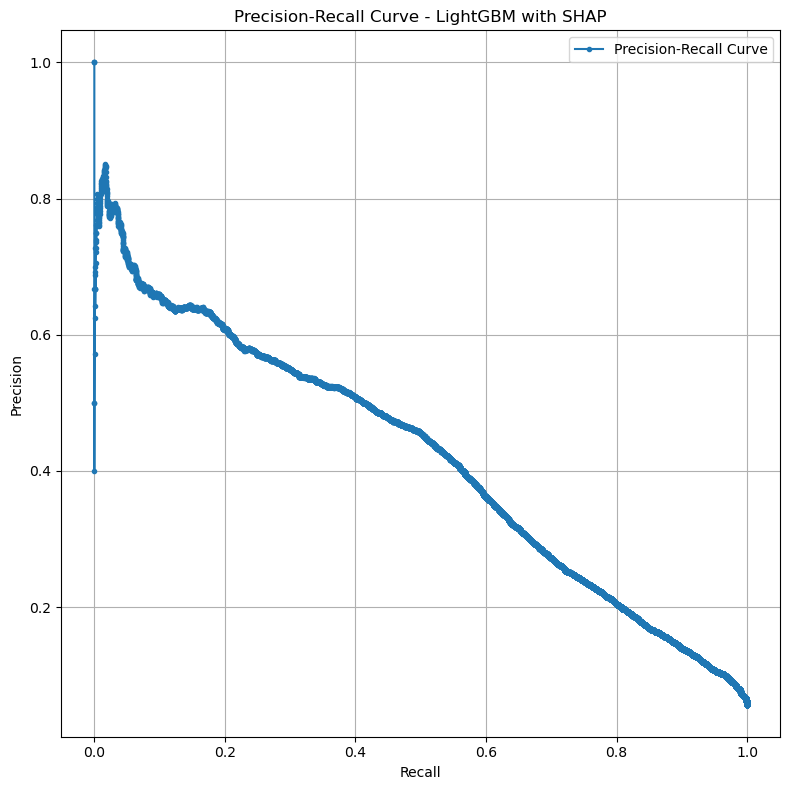

Plot Calibration Curve


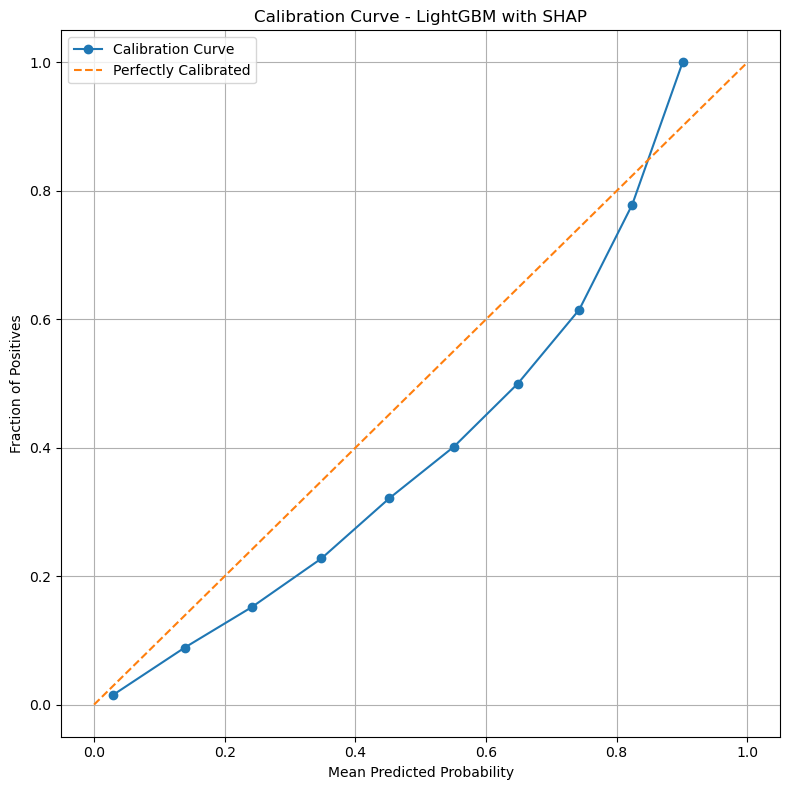

Plot Permutation Importance


feature  importance_mean  importance_std
9                   HadAngina         0.255720        0.002401
1                         Sex         0.023604        0.001574
10                  HadStroke         0.019852        0.001193
2               GeneralHealth         0.011686        0.002110
40                AgeGroupNum         0.009536        0.001350
28                AgeCategory         0.008547        0.001163
24               SmokerStatus         0.008343        0.001169
26                  ChestScan         0.007519        0.001206
8                RemovedTeeth         0.005498        0.000387
17                HadDiabetes         0.004383        0.001093
0                       State         0.002633        0.000966
16               HadArthritis         0.001350        0.000347
34               FluVaxLast12         0.001335        0.000346
32            AlcoholDrinkers         0.001062        0.000544
27      RaceEthnicityCategory         0.000957        0.000428
7                  SleepHours         0.000951        0.000553
31                        BMI         0.000637        0.000647
13                    HadCOPD         0.000399        0.000411
19    BlindOrVisionDifficulty         0.000388        0.000120
3          PhysicalHealthDays         0.000353        0.000341
5             LastCheckupTime         0.000320        0.000244
38                   CovidPos         0.000313        0.000380
33                 HIVTesting         0.000199        0.000066
4            MentalHealthDays         0.000199        0.000288
22  DifficultyDressingBathing         0.000079        0.000032
12              HadSkinCancer         0.000076        0.000265
30          WeightInKilograms         0.000054        0.000272
11                  HadAsthma         0.000052        0.000178
36          TetanusLast10Tdap         0.000046        0.000114
23          DifficultyErrands         0.000034        0.000019
25            ECigaretteUsage         0.000018        0.000043
14      HadDepressiveDisorder         0.000007        0.000056
39               BMI_Category        -0.000042        0.000037
35              PneumoVaxEver        -0.000057        0.000062
37           HighRiskLastYear        -0.000080        0.000051
20    DifficultyConcentrating        -0.000111        0.000044
15           HadKidneyDisease        -0.000144        0.000163
18        DeafOrHardOfHearing        -0.000177        0.000125
6          PhysicalActivities        -0.000326        0.000142
21          DifficultyWalking        -0.000337        0.000256
29             HeightInMeters        -0.000465        0.000299

Plot Permutation Importance


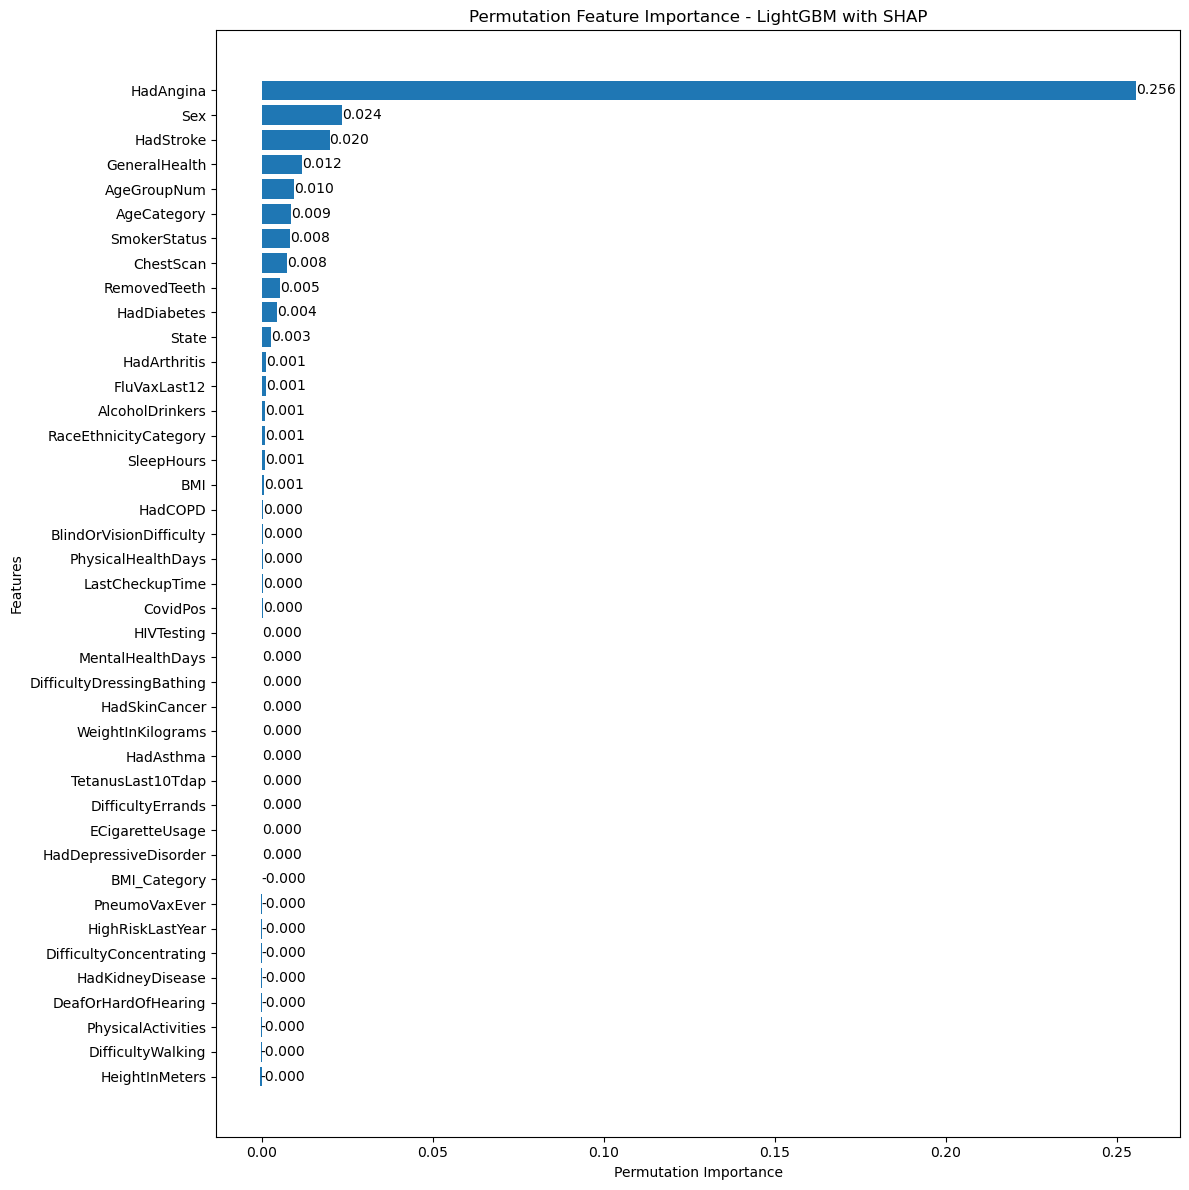

/tmp/ipykernel_86754/1846017779.py:68: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


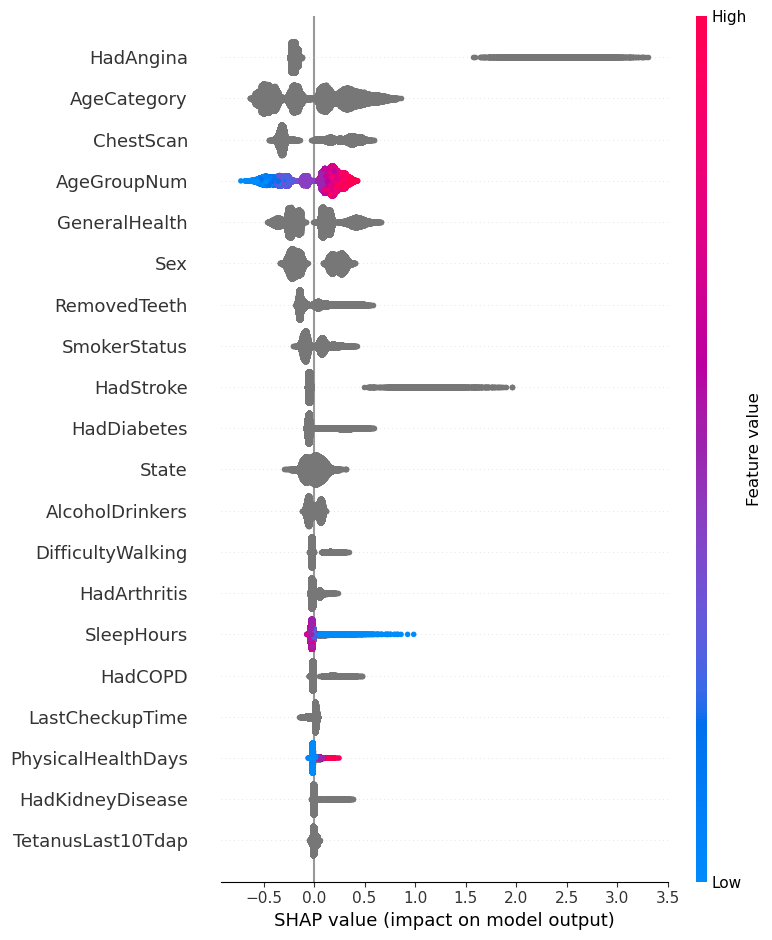

In [27]:
# ---------------------------------------------------
# LIGHTGBM + SHAP + PERMUTATION IMPORTANCE
# ---------------------------------------------------

# LightGBM builds a group of decision trees where each tree attempts to correct
# errors of the previous trees.
def lgbm_shap_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.1, 10)
    }
    model = LGBMClassifier(
        **params,
        objective='binary',
        random_state=seed,
        verbose=-1)
    model.fit(
        X_train, y_train,
        eval_set=[(X_validation, y_validation)],
        eval_metric="average_precision",
        callbacks=[early_stopping(stopping_rounds=50)]
    )
    preds = model.predict_proba(X_validation)[:, 1]
    return average_precision_score(y_validation, preds)

lgbm_shap_study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=seed))
lgbm_shap_study.optimize(lgbm_shap_objective, n_trials=n_trials)

lgbm_shap_model = LGBMClassifier(
        **lgbm_shap_study.best_params,
        objective='binary',
        random_state=seed
        )
lgbm_shap_model.fit(
    X_train, y_train,
    eval_set=[(X_validation, y_validation)],
    eval_metric='average_precision',
    callbacks=[early_stopping(stopping_rounds=50)]
)
lgbm_shap_proba = lgbm_shap_model.predict_proba(X_test)[:, 1]
lgbm_shap_pred = lgbm_shap_model.predict(X_test)
lgbm_shap_score = average_precision_score(y_test, lgbm_shap_proba)
lgbm_shap_results = output_results(
    lgbm_shap_score, lgbm_shap_study, y_test, lgbm_shap_pred, lgbm_shap_proba)
# Plot results
output_seperate('Plot Precision-Recall Curve')
plot_immediately(plot_pr_curve, (8, 8), y_test, lgbm_shap_proba, 'LightGBM with SHAP')
output_seperate('Plot Calibration Curve')
plot_immediately(plot_cb_curve, (8, 8), y_test, lgbm_shap_proba, 'LightGBM with SHAP')
output_seperate('Plot Permutation Importance')
# Permutation Importance
lgbm_shap_important_df = calculate_permutation_importance(lgbm_shap_model, X_test)
output_seperate('Plot Permutation Importance')
plot_immediately(plot_permutation_importance, (12, 12),
                 lgbm_shap_important_df, 'LightGBM with SHAP')

# SHAP Summary
explainer = shap.Explainer(lgbm_shap_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


